In [3]:
# Check GPU type
!nvidia-smi

Thu Oct 10 12:05:32 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 565.90                 Driver Version: 565.90         CUDA Version: 12.7     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3060 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   58C    P8             23W /  115W |     284MiB /   6144MiB |      2%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [4]:
# Install ultralytics
!pip -q install  ultralytics

In [5]:
# Import libraries
import pandas as pd
import os
from pathlib import Path
import shutil
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tqdm.notebook import tqdm
import cv2
import yaml
import matplotlib.pyplot as plt
from ultralytics import YOLO
import multiprocessing

# import ipywidgets as widgets
# widgets.IntSlider()


In [6]:
# Path to where your data is stored
DATA_DIR = Path('')

# Preview data files available
os.listdir(DATA_DIR)

['.git',
 '.gitignore',
 'benchmark_submission.csv',
 'Code.ipynb',
 'data.yaml',
 'datasets',
 'images',
 'images.zip',
 'LICENSE',
 'pytorch_env',
 'README.md',
 'requirements.txt',
 'runs',
 'SampleSubmission.csv',
 'Test.csv',
 'Train.csv',
 'Untitled-1.py',
 'yolo11n.pt',
 'yolov8n.pt']

In [7]:
# Set up directoris for training a yolo model

# Images directories
DATASET_DIR = Path('datasets/dataset')

print(DATASET_DIR)
IMAGES_DIR = DATASET_DIR / 'images'
TRAIN_IMAGES_DIR = IMAGES_DIR / 'train'
VAL_IMAGES_DIR = IMAGES_DIR / 'val'
TEST_IMAGES_DIR = IMAGES_DIR / 'test'

# Labels directories
LABELS_DIR = DATASET_DIR / 'labels'
TRAIN_LABELS_DIR = LABELS_DIR / 'train'
VAL_LABELS_DIR = LABELS_DIR / 'val'
TEST_LABELS_DIR = LABELS_DIR / 'test'

datasets\dataset


In [6]:
# Unzip images to 'images' dir
# shutil.unpack_archive(DATA_DIR / 'images.zip', 'images')

In [9]:
# Load train and test files
train = pd.read_csv(DATA_DIR / 'Train.csv')
test = pd.read_csv(DATA_DIR / 'Test.csv')
ss = pd.read_csv(DATA_DIR / 'SampleSubmission.csv')

# Add an image_path column
train['image_path'] = [Path('images/' + x) for x in train.Image_ID]
test['image_path'] = [Path('images/' + x) for x in test.Image_ID]

# Map str classes to ints (label encoding targets)
class_mapper = {x:y for x,y in zip(sorted(train['class'].unique().tolist()), range(train['class'].nunique()))}
train['class_id'] = train['class'].map(class_mapper)

# Preview the head of the train set
train.head()

Image_ID  confidence                  class         ymin        xmin  \
0  id_11543h.jpg         1.0  Pepper_Bacterial_Spot   194.649671  328.803454   
1  id_11543h.jpg         1.0  Pepper_Bacterial_Spot   149.632401  256.768914   
2  id_11543h.jpg         1.0  Pepper_Bacterial_Spot   234.046875  327.138158   
3  id_11543h.jpg         1.0  Pepper_Bacterial_Spot   221.277138  340.411184   
4  id_11ee1c.jpg         1.0        Pepper_Fusarium  2000.563598  989.588908   

          ymax         xmax            image_path  class_id  
0   208.107730   341.967928  images\id_11543h.jpg         5  
1   162.910362   266.195724  images\id_11543h.jpg         5  
2   252.712993   338.876645  images\id_11543h.jpg         5  
3   238.593750   354.651316  images\id_11543h.jpg         5  
4  2184.252196  1401.748952  images\id_11ee1c.jpg         8

In [10]:
test.head()

Image_ID  confidence  class  ymin  xmin  ymax  xmax  \
0  id_128pxx.jpg         NaN    NaN   NaN   NaN   NaN   NaN   
1  id_12jbci.jpg         NaN    NaN   NaN   NaN   NaN   NaN   
2  id_143s4o.jpg         NaN    NaN   NaN   NaN   NaN   NaN   
3  id_14tfmb.jpg         NaN    NaN   NaN   NaN   NaN   NaN   
4  id_14tw4o.jpg         NaN    NaN   NaN   NaN   NaN   NaN   

             image_path  
0  images\id_128pxx.jpg  
1  images\id_12jbci.jpg  
2  images\id_143s4o.jpg  
3  images\id_14tfmb.jpg  
4  images\id_14tw4o.jpg

In [11]:
ss.head()

Image_ID                      class  confidence  ymin  xmin  ymax  \
0  id_128pxx.jpg  Corn_Cercospora_Leaf_Spot         0.5   100   100   100   
1  id_128pxx.jpg           Corn_Common_Rust         0.5   100   100   100   
2  id_128pxx.jpg               Corn_Healthy         0.5   100   100   100   
3  id_128pxx.jpg  Corn_Northern_Leaf_Blight         0.5   100   100   100   
4  id_128pxx.jpg                Corn_Streak         0.5   100   100   100   

   xmax  
0   100  
1   100  
2   100  
3   100  
4   100

In [12]:
# Split data into training and validation
train_unique_imgs_df = train.drop_duplicates(subset = ['Image_ID'], ignore_index = True)
X_train, X_val = train_test_split(train_unique_imgs_df, test_size = 0.25, stratify=train_unique_imgs_df['class'], random_state=42)

X_train = train[train.Image_ID.isin(X_train.Image_ID)]
X_val = train[train.Image_ID.isin(X_val.Image_ID)]

# Check shapes of training and validation data
X_train.shape, X_val.shape

((30777, 9), (10252, 9))

In [13]:
# Preview target distribution, seems there a class imbalance that needs to be handled
X_train['class'].value_counts(normalize = True), X_val['class'].value_counts(normalize = True)

(class
 Corn_Cercospora_Leaf_Spot    0.160444
 Tomato_Septoria              0.159047
 Tomato_Late_Blight           0.098905
 Corn_Streak                  0.077201
 Tomato_Healthy               0.069045
 Pepper_Septoria              0.051922
 Pepper_Leaf_Mosaic           0.051662
 Tomato_Early_Blight          0.047763
 Pepper_Bacterial_Spot        0.047665
 Corn_Common_Rust             0.040290
 Pepper_Leaf_Curl             0.037561
 Corn_Healthy                 0.037561
 Tomato_Fusarium              0.019950
 Pepper_Healthy               0.017935
 Pepper_Late_Blight           0.014296
 Pepper_Leaf_Blight           0.012574
 Tomato_Bacterial_Spot        0.011860
 Pepper_Cercospora            0.011405
 Pepper_Fusarium              0.011340
 Tomato_Leaf_Curl             0.011177
 Corn_Northern_Leaf_Blight    0.004289
 Tomato_Mosaic                0.003314
 Pepper_Early_Blight          0.002794
 Name: proportion, dtype: float64,
 class
 Corn_Cercospora_Leaf_Spot    0.156067
 Tomato_Septori

In [14]:
# Check if dirs exist, if they do, remove them, otherwise create them.
# This only needs to run once
for DIR in [TRAIN_IMAGES_DIR,VAL_IMAGES_DIR, TEST_IMAGES_DIR, TRAIN_LABELS_DIR,VAL_LABELS_DIR,TEST_LABELS_DIR]:
  if DIR.exists():
    shutil.rmtree(DIR)
  DIR.mkdir(parents=True, exist_ok = True)

In [15]:
# Copy train, val and test images to their respective dirs
for img in tqdm(X_train.image_path.unique()):
  shutil.copy(img, TRAIN_IMAGES_DIR / img.parts[-1])

for img in tqdm(X_val.image_path.unique()):
  shutil.copy(img, VAL_IMAGES_DIR / img.parts[-1])

for img in tqdm(test.image_path.unique()):
  shutil.copy(img, TEST_IMAGES_DIR / img.parts[-1])

  0%|          | 0/3676 [00:00<?, ?it/s]

  0%|          | 0/1226 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

In [16]:
X_train.head()

Image_ID  confidence                      class        ymin  \
0  id_11543h.jpg         1.0      Pepper_Bacterial_Spot  194.649671   
1  id_11543h.jpg         1.0      Pepper_Bacterial_Spot  149.632401   
2  id_11543h.jpg         1.0      Pepper_Bacterial_Spot  234.046875   
3  id_11543h.jpg         1.0      Pepper_Bacterial_Spot  221.277138   
6  id_11gglx.jpg         1.0  Corn_Cercospora_Leaf_Spot  774.562500   

          xmin        ymax         xmax            image_path  class_id  
0   328.803454  208.107730   341.967928  images\id_11543h.jpg         5  
1   256.768914  162.910362   266.195724  images\id_11543h.jpg         5  
2   327.138158  252.712993   338.876645  images\id_11543h.jpg         5  
3   340.411184  238.593750   354.651316  images\id_11543h.jpg         5  
6  2735.933839  850.476742  2834.348725  images\id_11gglx.jpg         0

In [17]:
from concurrent.futures import ThreadPoolExecutor, as_completed
from pathlib import Path
import numpy as np
from PIL import Image
from tqdm import tqdm
import shutil
import pandas as pd

# Function to convert the bboxes to YOLO format
def convert_to_yolo(bbox, width, height):
    ymin, xmin, ymax, xmax = bbox['ymin'], bbox['xmin'], bbox['ymax'], bbox['xmax']
    class_id = bbox['class_id']

    # Normalize the coordinates
    x_center = (xmin + xmax) / 2 / width
    y_center = (ymin + ymax) / 2 / height
    bbox_width = (xmax - xmin) / width
    bbox_height = (ymax - ymin) / height

    return f"{class_id} {x_center:.6f} {y_center:.6f} {bbox_width:.6f} {bbox_height:.6f}"

# Top-level function to save annotations for a single image
def save_yolo_annotations_task(image_path, bboxes, output_dir):
    try:
        img = np.array(Image.open(str(image_path)))
        height, width, _ = img.shape
    except Exception as e:
        print(f"Error opening image {image_path}: {e}")
        return

    label_file = Path(output_dir) / f"{Path(image_path).stem}.txt"
    try:
        with open(label_file, 'w') as f:
            for bbox in bboxes:
                annotation = convert_to_yolo(bbox, width, height)
                f.write(f"{annotation}\n")
    except Exception as e:
        print(f"Error writing to {label_file}: {e}")

# Function to clear output directory
def clear_output_dir(output_dir):
    if Path(output_dir).exists():
        shutil.rmtree(output_dir)
    Path(output_dir).mkdir(parents=True, exist_ok=True)

# Function to process the dataset and save annotations using ThreadPoolExecutor
def process_dataset(dataframe, output_dir, max_workers=4):
    # Clear the output directory to prevent duplicate annotations
    clear_output_dir(output_dir)

    # Group the DataFrame by 'image_path'
    grouped = dataframe.groupby('image_path')
    tasks = [(image_path, group.to_dict('records'), output_dir) for image_path, group in grouped]

    # Use ThreadPoolExecutor to process tasks
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        # Submit all tasks to the executor
        futures = [executor.submit(save_yolo_annotations_task, *task) for task in tasks]

        # Use tqdm to display a progress bar as tasks complete
        for _ in tqdm(as_completed(futures), total=len(futures), desc=f"Processing {Path(output_dir).name}"):
            pass  # Progress bar updates as each task completes

# Save train and validation labels to their respective dirs
process_dataset(X_train, TRAIN_LABELS_DIR)
process_dataset(X_val, VAL_LABELS_DIR)

# import multiprocessing
# from pathlib import Path
# import numpy as np
# from PIL import Image
# from tqdm import tqdm
# import shutil
# import pandas as pd

# # Function to convert the bboxes to YOLO format
# def convert_to_yolo(bbox, width, height):
#     ymin, xmin, ymax, xmax = bbox['ymin'], bbox['xmin'], bbox['ymax'], bbox['xmax']
#     class_id = bbox['class_id']

#     # Normalize the coordinates
#     x_center = (xmin + xmax) / 2 / width
#     y_center = (ymin + ymax) / 2 / height
#     bbox_width = (xmax - xmin) / width
#     bbox_height = (ymax - ymin) / height

#     return f"{class_id} {x_center:.6f} {y_center:.6f} {bbox_width:.6f} {bbox_height:.6f}"

# # Top-level function to save annotations for a single image
# def save_yolo_annotations_task(task):
#     image_path, bboxes, output_dir = task
#     try:
#         img = np.array(Image.open(str(image_path)))
#         height, width, _ = img.shape
#     except Exception as e:
#         print(f"Error opening image {image_path}: {e}")
#         return

#     label_file = Path(output_dir) / f"{Path(image_path).stem}.txt"
#     with open(label_file, 'w') as f:
#         for bbox in bboxes:
#             annotation = convert_to_yolo(bbox, width, height)
#             f.write(f"{annotation}\n")

# # Function to clear output directory
# def clear_output_dir(output_dir):
#     if Path(output_dir).exists():
#         shutil.rmtree(output_dir)
#     Path(output_dir).mkdir(parents=True, exist_ok=True)

# # Function to process the dataset and save annotations
# def process_dataset(dataframe, output_dir):
#     # Clear the output directory to prevent duplicate annotations
#     clear_output_dir(output_dir)

#     # Group the DataFrame by 'image_path'
#     grouped = dataframe.groupby('image_path')
#     tasks = [(image_path, group.to_dict('records'), output_dir) for image_path, group in grouped]

#     # Use multiprocessing Pool to process tasks
#     with multiprocessing.Pool() as pool:
#         list(tqdm(pool.imap_unordered(save_yolo_annotations_task, tasks), total=len(tasks)))


# # Save train and validation labels to their respective dirs
# process_dataset(X_train, TRAIN_LABELS_DIR)
# process_dataset(X_val, VAL_LABELS_DIR)

Processing val: 100%|██████████| 1226/1226 [00:28<00:00, 43.33it/s]


In [18]:
# Train images dir
TRAIN_IMAGES_DIR

WindowsPath('datasets/dataset/images/train')

In [19]:
print(str(TRAIN_IMAGES_DIR))

datasets\dataset\images\train


In [20]:
# Create a data.yaml file required by yolo
class_names = sorted(train['class'].unique().tolist())
num_classes = len(class_names)

data_yaml = {
    'train': 'C:/Users/richa/OneDrive/Desktop/AI/neuralNetwork/' + str(TRAIN_IMAGES_DIR),
    'val': 'C:/Users/richa/OneDrive/Desktop/AI/neuralNetwork/' + str(VAL_IMAGES_DIR),
    'test': 'C:/Users/richa/OneDrive/Desktop/AI/neuralNetwork/' + str(TEST_IMAGES_DIR),
    'nc': num_classes,
    'names': class_names
}

yaml_path = 'data.yaml'
with open(yaml_path, 'w') as file:
    yaml.dump(data_yaml, file, default_flow_style=False)

# Preview data yaml file
data_yaml

{'train': 'C:/Users/richa/OneDrive/Desktop/AI/neuralNetwork/datasets\\dataset\\images\\train',
 'val': 'C:/Users/richa/OneDrive/Desktop/AI/neuralNetwork/datasets\\dataset\\images\\val',
 'test': 'C:/Users/richa/OneDrive/Desktop/AI/neuralNetwork/datasets\\dataset\\images\\test',
 'nc': 23,
 'names': ['Corn_Cercospora_Leaf_Spot',
  'Corn_Common_Rust',
  'Corn_Healthy',
  'Corn_Northern_Leaf_Blight',
  'Corn_Streak',
  'Pepper_Bacterial_Spot',
  'Pepper_Cercospora',
  'Pepper_Early_Blight',
  'Pepper_Fusarium',
  'Pepper_Healthy',
  'Pepper_Late_Blight',
  'Pepper_Leaf_Blight',
  'Pepper_Leaf_Curl',
  'Pepper_Leaf_Mosaic',
  'Pepper_Septoria',
  'Tomato_Bacterial_Spot',
  'Tomato_Early_Blight',
  'Tomato_Fusarium',
  'Tomato_Healthy',
  'Tomato_Late_Blight',
  'Tomato_Leaf_Curl',
  'Tomato_Mosaic',
  'Tomato_Septoria']}

Plotting id_11543h.jpg with 4 bounding boxes.


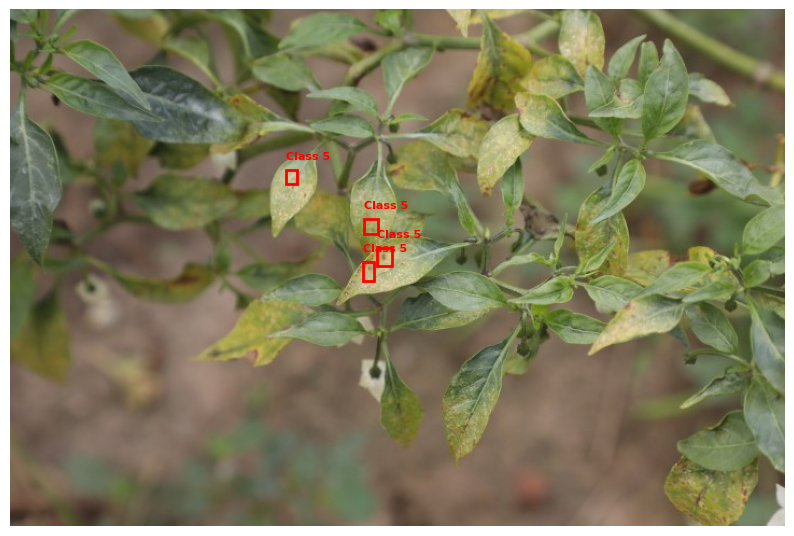

Plotting id_11gglx.jpg with 11 bounding boxes.


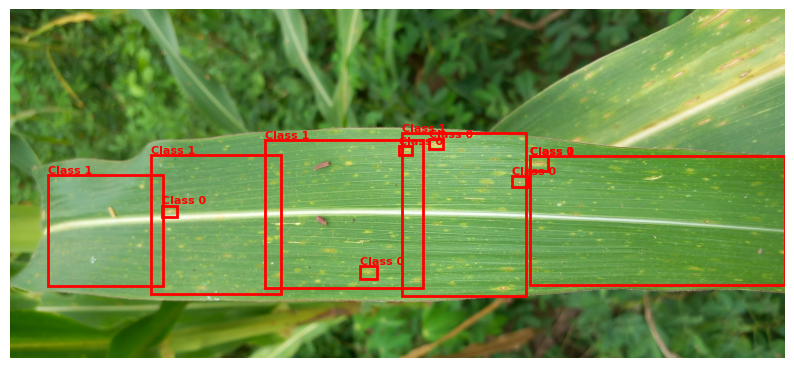

Plotting id_11zffz.jpg with 10 bounding boxes.


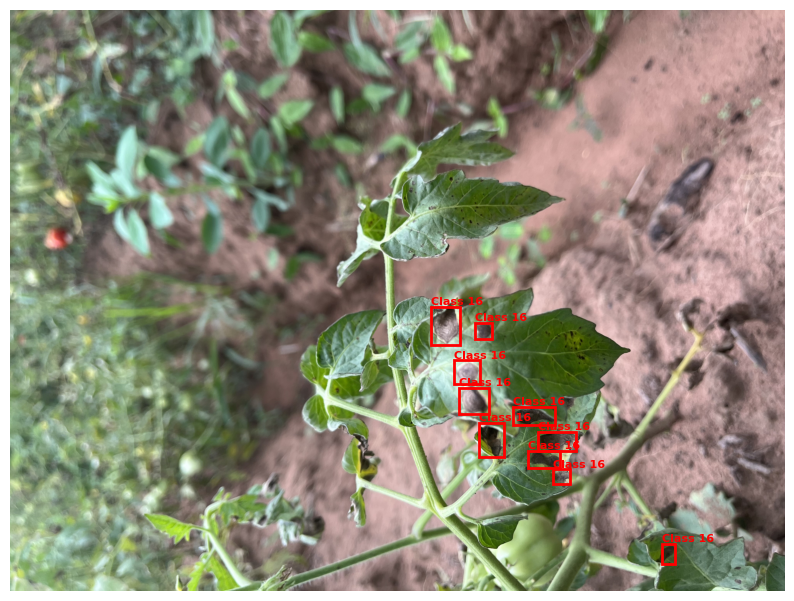

Plotting id_127uhh.jpg with 1 bounding boxes.


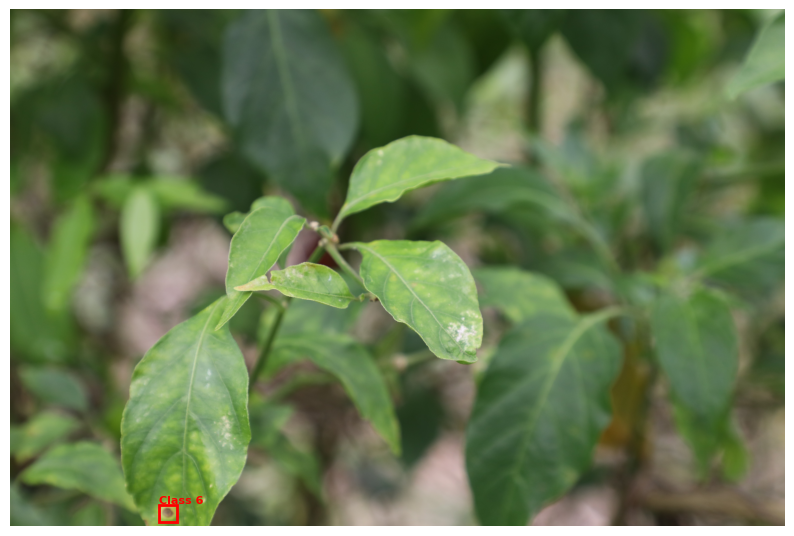

Plotting id_12q33h.jpg with 3 bounding boxes.


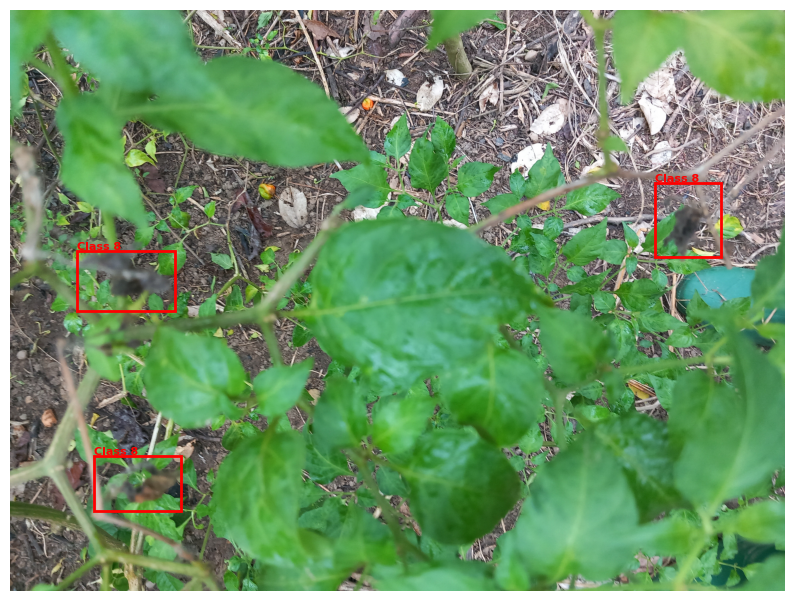

In [21]:
# Plot some images and their bboxes to ensure the conversion was done correctly
def load_annotations(label_path):
    with open(label_path, 'r') as f:
        lines = f.readlines()
    boxes = []
    for line in lines:
        class_id, x_center, y_center, width, height = map(float, line.strip().split())
        boxes.append((class_id, x_center, y_center, width, height))
    return boxes

# Function to plot an image with its bounding boxes
def plot_image_with_boxes(image_path, boxes):
    # Load the image
    image = np.array(Image.open(str(image_path)))


    # Get image dimensions
    h, w, _ = image.shape

    # Plot the image
    plt.figure(figsize=(10, 10))
    plt.imshow(image)

    # Plot each bounding box
    for box in boxes:
        class_id, x_center, y_center, width, height = box
        # Convert YOLO format to corner coordinates
        xmin = int((x_center - width / 2) * w)
        ymin = int((y_center - height / 2) * h)
        xmax = int((x_center + width / 2) * w)
        ymax = int((y_center + height / 2) * h)

        # Draw the bounding box
        plt.gca().add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                          edgecolor='red', facecolor='none', linewidth=2))
        plt.text(xmin, ymin - 10, f'Class {int(class_id)}', color='red', fontsize=8, weight='bold')

    plt.axis('off')
    plt.show()

# Directories for images and labels
IMAGE_DIR = TRAIN_IMAGES_DIR
LABEL_DIR = TRAIN_LABELS_DIR

# Plot a few images with their annotations
for image_name in os.listdir(IMAGE_DIR)[:5]:
    image_path = IMAGE_DIR / image_name
    label_path = LABEL_DIR / (image_name.replace('.jpg', '.txt').replace('.png', '.txt'))

    if label_path.exists():
        boxes = load_annotations(label_path)
        print(f"Plotting {image_name} with {len(boxes)} bounding boxes.")
        plot_image_with_boxes(image_path, boxes)
    else:
        print(f"No annotations found for {image_name}.")


In [22]:
import torch

print("PyTorch Version:", torch.__version__)
print("CUDA Available:", torch.cuda.is_available())
print("Number of CUDA Devices:", torch.cuda.device_count())
print("CUDA Device Name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No CUDA Device")


PyTorch Version: 2.0.1+cu117
CUDA Available: True
Number of CUDA Devices: 1
CUDA Device Name: NVIDIA GeForce RTX 3060 Laptop GPU


In [1]:
import pandas as pd
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from PIL import Image
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torchvision.transforms as transforms

# -----------------------------
# 1. Setup and Configuration
# -----------------------------

# Set device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Paths
train_csv_path = 'Train.csv'  # Path to your training CSV
images_dir = 'datasets/dataset/images/train'  # Path to your images directory
model_weights_path = 'custom_cnn_model.pth'  # Path to save/load your model weights

# -----------------------------
# 2. Data Preparation
# -----------------------------

# Load train data
train = pd.read_csv(train_csv_path)

# Encode class labels into numerical format using LabelEncoder
label_encoder = LabelEncoder()
train['class'] = label_encoder.fit_transform(train['class'])

# Check for missing image files and filter them out
valid_images = [img_id for img_id in train['Image_ID'] if os.path.exists(os.path.join(images_dir, img_id))]
train = train[train['Image_ID'].isin(valid_images)].reset_index(drop=True)

print(f"Number of training samples after filtering: {len(train)}")

# Split data into training and validation sets (80% train, 20% val)
train_df, val_df = train_test_split(
    train, 
    test_size=0.2, 
    random_state=42, 
    stratify=train['class']
)

print(f"Training samples: {len(train_df)}, Validation samples: {len(val_df)}")

# -----------------------------
# 3. Dataset and DataLoader
# -----------------------------

# Define a Custom Dataset Class for Loading Images and Annotations
class CustomDataset(Dataset):
    def __init__(self, dataframe, images_dir, transforms=None):
        self.dataframe = dataframe
        self.images_dir = images_dir
        self.transforms = transforms if transforms else transforms.Compose([transforms.ToTensor()])

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        image_id = self.dataframe.iloc[idx]['Image_ID']
        image_path = os.path.join(self.images_dir, image_id)
        
        # Load and preprocess the image
        try:
            image = Image.open(image_path).convert("RGB")
        except Exception as e:
            print(f"Error loading image {image_path}: {e}")
            return None, None  # Return None if the image cannot be opened
        
        # Extract bounding box coordinates
        bbox = torch.tensor(
            [self.dataframe.iloc[idx][c] for c in ['xmin', 'ymin', 'xmax', 'ymax']], 
            dtype=torch.float32
        )
        
        # Extract class label
        label = torch.tensor(self.dataframe.iloc[idx]['class'], dtype=torch.long)
        
        # Apply transformations
        if self.transforms:
            image = self.transforms(image)
        
        return image, {'boxes': bbox, 'labels': label}

# Define transformations for the images
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize images to 256x256
    transforms.ToTensor()
])

# Instantiate the training dataset and DataLoader
train_dataset = CustomDataset(dataframe=train_df, images_dir=images_dir, transforms=transform)
train_loader = DataLoader(
    train_dataset, 
    batch_size=16,          # Adjust based on your GPU memory
    shuffle=True,           # Shuffle for training
    num_workers=4,          # Number of subprocesses for data loading
    pin_memory=True         # Copy tensors into CUDA pinned memory
)

# Instantiate the validation dataset and DataLoader
val_dataset = CustomDataset(dataframe=val_df, images_dir=images_dir, transforms=transform)
val_loader = DataLoader(
    val_dataset, 
    batch_size=16,          # Adjust based on your GPU memory
    shuffle=False,          # No need to shuffle for evaluation
    num_workers=4,          # Number of subprocesses for data loading
    pin_memory=True         # Copy tensors into CUDA pinned memory
)

# -----------------------------
# 4. Model Definition
# -----------------------------

# Define the CustomCNN model
class CustomCNN(nn.Module):
    def __init__(self, num_classes):
        super(CustomCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.flattened_size = self._get_flattened_size()
        self.fc1 = nn.Linear(self.flattened_size, 256)
        self.fc2_bbox = nn.Linear(256, 4)      # Bounding box coordinates [xmin, ymin, xmax, ymax]
        self.fc2_class = nn.Linear(256, num_classes)  # Class prediction

    def _get_flattened_size(self):
        dummy_input = torch.zeros(1, 3, 256, 256)
        dummy_output = self._forward_conv(dummy_input)
        return dummy_output.view(1, -1).size(1)

    def _forward_conv(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        return x

    def forward(self, x):
        x = self._forward_conv(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        bbox_output = self.fc2_bbox(x)
        class_output = self.fc2_class(x)
        return bbox_output, class_output

# Define number of classes based on unique labels
num_classes = len(train['class'].unique())

# Instantiate the model and move to the correct device
model = CustomCNN(num_classes=num_classes).to(device)

# Print the model structure (optional)
print(f"Custom CNN Model:\n{model}")

# -----------------------------
# 5. Training Loop
# -----------------------------

# Define loss functions and optimizer
bbox_loss_fn = nn.MSELoss()
class_loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 3
for epoch in range(num_epochs):
    print(f"\nStarting Epoch {epoch + 1}/{num_epochs}")
    model.train()
    total_bbox_loss, total_class_loss = 0.0, 0.0

    for batch_idx, (images, targets) in enumerate(tqdm(train_loader, desc="Training")):
        if images is None or targets is None:
            print(f"Skipping batch {batch_idx + 1} due to None values.")
            continue

        # Move data to the correct device
        images = images.to(device)
        bboxes = targets['boxes'].to(device)
        labels = targets['labels'].to(device)

        # Forward pass
        pred_bboxes, pred_labels = model(images)

        # Calculate losses
        bbox_loss = bbox_loss_fn(pred_bboxes, bboxes)
        class_loss = class_loss_fn(pred_labels, labels)
        total_loss = bbox_loss + class_loss

        # Backward pass and optimization
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        # Accumulate losses
        total_bbox_loss += bbox_loss.item()
        total_class_loss += class_loss.item()

    avg_bbox_loss = total_bbox_loss / len(train_loader)
    avg_class_loss = total_class_loss / len(train_loader)
    print(f'Epoch [{epoch+1}/{num_epochs}], BBox Loss: {avg_bbox_loss:.4f}, Class Loss: {avg_class_loss:.4f}')

# Save the trained model
torch.save(model.state_dict(), model_weights_path)
print(f"\nModel saved to '{model_weights_path}'")

# -----------------------------
# 6. Evaluation Metrics
# -----------------------------

def calculate_iou(box1, box2):
    """
    Calculate Intersection over Union (IoU) between two bounding boxes.
    Boxes are in the format [xmin, ymin, xmax, ymax]
    """
    x_left = max(box1[0], box2[0])
    y_top    = max(box1[1], box2[1])
    x_right  = min(box1[2], box2[2])
    y_bottom = min(box1[3], box2[3])

    if x_right < x_left or y_bottom < y_top:
        return 0.0  # No overlap

    intersection_area = (x_right - x_left) * (y_bottom - y_top)
    box1_area = (box1[2]-box1[0]) * (box1[3]-box1[1])
    box2_area = (box2[2]-box2[0]) * (box2[3]-box2[1])
    iou = intersection_area / float(box1_area + box2_area - intersection_area)
    return iou

def evaluate_classification(model, dataloader, device):
    """
    Evaluate classification performance: Accuracy, Precision, Recall, F1-Score, Confusion Matrix
    """
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, targets in tqdm(dataloader, desc="Evaluating Classification"):
            # Handle possible None batches
            if images is None or targets is None:
                continue

            images = images.to(device)
            labels = targets['labels'].to(device)

            # Forward pass
            _, preds = model(images)  # Assuming model returns (bbox, class)
            preds = torch.argmax(preds, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_labels, all_preds, average='weighted', zero_division=0
    )
    conf_matrix = confusion_matrix(all_labels, all_preds)

    print("\n--- Classification Evaluation ---")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision (Weighted): {precision:.4f}")
    print(f"Recall (Weighted): {recall:.4f}")
    print(f"F1-Score (Weighted): {f1:.4f}")
    print("Confusion Matrix:")
    print(conf_matrix)

def evaluate_bounding_boxes(model, dataloader, device, iou_threshold=0.5):
    """
    Evaluate bounding box predictions: Mean IoU and Precision at IoU threshold
    """
    model.eval()
    all_iou = []
    matched = 0
    total = 0

    with torch.no_grad():
        for images, targets in tqdm(dataloader, desc="Evaluating Bounding Boxes"):
            # Handle possible None batches
            if images is None or targets is None:
                continue

            images = images.to(device)
            true_bboxes = targets['boxes'].to(device)

            # Forward pass
            pred_bboxes, _ = model(images)

            # Move tensors to CPU for processing
            pred_bboxes = pred_bboxes.cpu().numpy()
            true_bboxes = true_bboxes.cpu().numpy()

            # Iterate over each prediction and true box
            for pred_box, true_box in zip(pred_bboxes, true_bboxes):
                iou = calculate_iou(pred_box, true_box)
                all_iou.append(iou)
                if iou >= iou_threshold:
                    matched += 1
                total += 1

    # Calculate metrics
    mean_iou = np.mean(all_iou) if all_iou else 0
    precision_at_iou = matched / total if total > 0 else 0

    print("\n--- Bounding Box Evaluation ---")
    print(f"Mean IoU: {mean_iou:.4f}")
    print(f"Precision at IoU >= {iou_threshold}: {precision_at_iou:.4f}")

def visualize_predictions(model, dataloader, device, label_encoder, num_samples=5):
    """
    Visualize a few samples of ground truth and predicted bounding boxes along with class labels
    """
    model.eval()
    samples_visualized = 0

    with torch.no_grad():
        for images, targets in dataloader:
            # Handle possible None batches
            if images is None or targets is None:
                continue

            images = images.to(device)
            true_bboxes = targets['boxes'].to(device)
            true_labels = targets['labels'].to(device)

            # Forward pass
            pred_bboxes, pred_labels = model(images)
            preds = torch.argmax(pred_labels, dim=1)

            # Move tensors to CPU for visualization
            images = images.cpu().numpy()
            true_bboxes = true_bboxes.cpu().numpy()
            preds = preds.cpu().numpy()
            pred_bboxes = pred_bboxes.cpu().numpy()

            for img, true_box, true_label, pred_box, pred_label in zip(
                images, true_bboxes, true_labels, pred_bboxes, preds
            ):
                if samples_visualized >= num_samples:
                    return

                fig, ax = plt.subplots(1)
                img = np.transpose(img, (1, 2, 0))  # Convert from (C, H, W) to (H, W, C)
                ax.imshow(img)

                # Plot Ground Truth Bounding Box
                gt_xmin, gt_ymin, gt_xmax, gt_ymax = true_box
                gt_width = gt_xmax - gt_xmin
                gt_height = gt_ymax - gt_ymin
                gt_rect = patches.Rectangle(
                    (gt_xmin, gt_ymin), gt_width, gt_height, 
                    linewidth=2, edgecolor='g', facecolor='none', label='Ground Truth'
                )
                ax.add_patch(gt_rect)

                # Plot Predicted Bounding Box
                pred_xmin, pred_ymin, pred_xmax, pred_ymax = pred_box
                pred_width = pred_xmax - pred_xmin
                pred_height = pred_ymax - pred_ymin
                pred_rect = patches.Rectangle(
                    (pred_xmin, pred_ymin), pred_width, pred_height, 
                    linewidth=2, edgecolor='r', facecolor='none', label='Prediction'
                )
                ax.add_patch(pred_rect)

                # Add Labels
                gt_class = label_encoder.inverse_transform([true_label])[0]
                pred_class = label_encoder.inverse_transform([pred_label])[0]
                plt.title(f"GT: {gt_class} | Pred: {pred_class}")

                # Create Legend
                handles = [
                    patches.Patch(color='g', label='Ground Truth'),
                    patches.Patch(color='r', label='Prediction')
                ]
                plt.legend(handles=handles)

                plt.show()

                samples_visualized += 1

# -----------------------------
# 7. Model Evaluation
# -----------------------------

# Load the trained model weights (already saved in 'custom_cnn_model.pth')
if os.path.exists(model_weights_path):
    model.load_state_dict(torch.load(model_weights_path, map_location=device))
    model.eval()  # Set model to evaluation mode
    print(f"\nModel loaded from '{model_weights_path}' and set to evaluation mode.")
else:
    print(f"\nModel weights file '{model_weights_path}' not found. Please ensure the file exists.")
    # Optionally, exit the script or proceed without evaluation
    exit()

# Evaluate Classification
evaluate_classification(model, val_loader, device)

# Evaluate Bounding Boxes
evaluate_bounding_boxes(model, val_loader, device, iou_threshold=0.5)

# Visualize Predictions (Optional)
visualize_predictions(model, val_loader, device, label_encoder, num_samples=5)


Number of training samples after filtering: 30777
Starting Epoch 1/3


100%|██████████| 1924/1924 [49:59<00:00,  1.56s/it]  


Epoch [1/3], BBox Loss: 686501.5837, Class Loss: 31.3220
Starting Epoch 2/3


100%|██████████| 1924/1924 [44:47<00:00,  1.40s/it]


Epoch [2/3], BBox Loss: 597145.1029, Class Loss: 14.2802
Starting Epoch 3/3


100%|██████████| 1924/1924 [44:53<00:00,  1.40s/it]

Epoch [3/3], BBox Loss: 547705.4585, Class Loss: 11.8878


Using device: cuda
Number of training samples after filtering: 30777
Training samples: 24621, Validation samples: 6156
Custom CNN Model:
CustomCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=65536, out_features=256, bias=True)
  (fc2_bbox): Linear(in_features=256, out_features=4, bias=True)
  (fc2_class): Linear(in_features=256, out_features=23, bias=True)
)

Starting Epoch 1/1


Training: 100%|██████████| 1539/1539 [36:18<00:00,  1.42s/it]


Epoch [1/1], BBox Loss: 693309.6264, Class Loss: 38.6877

Model saved to 'custom_cnn_model.pth'

Model loaded from 'custom_cnn_model.pth' and set to evaluation mode.


Evaluating Classification: 100%|██████████| 385/385 [08:52<00:00,  1.38s/it]



--- Classification Evaluation ---
Accuracy: 0.0825
Precision (Weighted): 0.1072
Recall (Weighted): 0.0825
F1-Score (Weighted): 0.0529
Confusion Matrix:
[[134   0   0   0   0   0   0   0   0   0   0   0   0 854   0   0   0   0
    0   0   0   0   0]
 [ 11   0   0   0   0   0   0   0   0   0   0   0   0 234   0   0   0   3
    0   0   0   0   0]
 [  1   0   0   0   0   0   0   0   0   0   0   0   0 230   0   0   0   0
    0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0  25   0   0   0   1
    0   0   0   0   0]
 [  8   0   0   0   0   0   0   0   0   1   0   0   0 461   0   0   0   0
    5   0   0   0   0]
 [  7   0   0   0   0   0   0   0   0   0   3   0   0 269   0   0   0   7
    8   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   2   3   0   0  58   0   0   0   3
    3   1   0   0   0]
 [  0   0   0   0   0   0   0   0   0   1   0   0   0  10   0   0   0   2
    4   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0  66   0   0   0  

Evaluating Bounding Boxes: 100%|██████████| 385/385 [08:51<00:00,  1.38s/it]



--- Bounding Box Evaluation ---
Mean IoU: 0.0073
Precision at IoU >= 0.5: 0.0005


TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

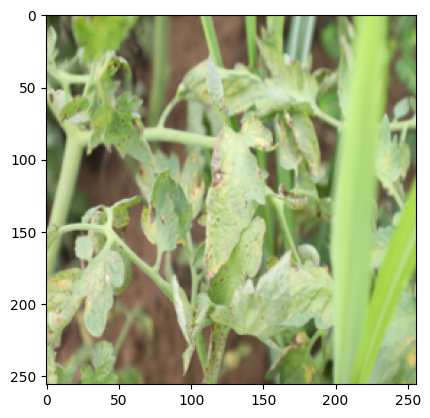

In [2]:
import pandas as pd
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from PIL import Image
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torchvision.transforms as transforms

# -----------------------------
# 1. Setup and Configuration
# -----------------------------

# Set device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Paths
train_csv_path = 'Train.csv'  # Path to your training CSV
images_dir = 'datasets/dataset/images/train'  # Path to your images directory
model_weights_path = 'custom_cnn_model.pth'  # Path to save/load your model weights

# -----------------------------
# 2. Data Preparation
# -----------------------------

# Load train data
train = pd.read_csv(train_csv_path)

# Encode class labels into numerical format using LabelEncoder
label_encoder = LabelEncoder()
train['class'] = label_encoder.fit_transform(train['class'])

# Check for missing image files and filter them out
valid_images = [img_id for img_id in train['Image_ID'] if os.path.exists(os.path.join(images_dir, img_id))]
train = train[train['Image_ID'].isin(valid_images)].reset_index(drop=True)

print(f"Number of training samples after filtering: {len(train)}")

# Split data into training and validation sets (80% train, 20% val)
train_df, val_df = train_test_split(
    train, 
    test_size=0.2, 
    random_state=42, 
    stratify=train['class']
)

print(f"Training samples: {len(train_df)}, Validation samples: {len(val_df)}")

# -----------------------------
# 3. Dataset and DataLoader
# -----------------------------

# Define a Custom Dataset Class for Loading Images and Annotations
class CustomDataset(Dataset):
    def __init__(self, dataframe, images_dir, transforms=None):
        self.dataframe = dataframe
        self.images_dir = images_dir
        self.transforms = transforms if transforms else transforms.Compose([transforms.ToTensor()])

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        image_id = self.dataframe.iloc[idx]['Image_ID']
        image_path = os.path.join(self.images_dir, image_id)
        
        # Load and preprocess the image
        try:
            image = Image.open(image_path).convert("RGB")
        except Exception as e:
            raise RuntimeError(f"Error loading image {image_path}: {e}")
        
        # Extract bounding box coordinates
        bbox = torch.tensor(
            [self.dataframe.iloc[idx][c] for c in ['xmin', 'ymin', 'xmax', 'ymax']], 
            dtype=torch.float32
        )
        
        # Extract class label
        label = torch.tensor(self.dataframe.iloc[idx]['class'], dtype=torch.long)
        
        # Apply transformations
        if self.transforms:
            image = self.transforms(image)
        
        return image, {'boxes': bbox, 'labels': label}

# Define transformations for the images
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize images to 256x256
    transforms.ToTensor()
])

# Instantiate the training dataset and DataLoader
train_dataset = CustomDataset(dataframe=train_df, images_dir=images_dir, transforms=transform)
train_loader = DataLoader(
    train_dataset, 
    batch_size=16,          # Adjust based on your GPU memory
    shuffle=True,           # Shuffle for training
    num_workers=0,          # Set to 0 for easier debugging
    pin_memory=True         # Copy tensors into CUDA pinned memory
)

# Instantiate the validation dataset and DataLoader
val_dataset = CustomDataset(dataframe=val_df, images_dir=images_dir, transforms=transform)
val_loader = DataLoader(
    val_dataset, 
    batch_size=16,          # Adjust based on your GPU memory
    shuffle=False,          # No need to shuffle for evaluation
    num_workers=0,          # Set to 0 for easier debugging
    pin_memory=True         # Copy tensors into CUDA pinned memory
)

# -----------------------------
# 4. Model Definition
# -----------------------------

# Define the CustomCNN model
class CustomCNN(nn.Module):
    def __init__(self, num_classes):
        super(CustomCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.flattened_size = self._get_flattened_size()
        self.fc1 = nn.Linear(self.flattened_size, 256)
        self.fc2_bbox = nn.Linear(256, 4)      # Bounding box coordinates [xmin, ymin, xmax, ymax]
        self.fc2_class = nn.Linear(256, num_classes)  # Class prediction

    def _get_flattened_size(self):
        dummy_input = torch.zeros(1, 3, 256, 256)
        dummy_output = self._forward_conv(dummy_input)
        return dummy_output.view(1, -1).size(1)

    def _forward_conv(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        return x

    def forward(self, x):
        x = self._forward_conv(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        bbox_output = self.fc2_bbox(x)
        class_output = self.fc2_class(x)
        return bbox_output, class_output

# Define number of classes based on unique labels
num_classes = len(train['class'].unique())

# Instantiate the model and move to the correct device
model = CustomCNN(num_classes=num_classes).to(device)

# Print the model structure (optional)
print(f"Custom CNN Model:\n{model}")

# -----------------------------
# 5. Training Loop
# -----------------------------

# Define loss functions and optimizer
bbox_loss_fn = nn.MSELoss()
class_loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 1
for epoch in range(num_epochs):
    print(f"\nStarting Epoch {epoch + 1}/{num_epochs}")
    model.train()
    total_bbox_loss, total_class_loss = 0.0, 0.0

    for batch_idx, (images, targets) in enumerate(tqdm(train_loader, desc="Training")):
        # Skip batches where images or targets are None
        if images is None or targets is None:
            print(f"Skipping batch {batch_idx + 1} due to None values.")
            continue

        # Move data to the correct device
        images = images.to(device)
        bboxes = targets['boxes'].to(device)
        labels = targets['labels'].to(device)

        # Forward pass
        pred_bboxes, pred_labels = model(images)

        # Calculate losses
        bbox_loss = bbox_loss_fn(pred_bboxes, bboxes)
        class_loss = class_loss_fn(pred_labels, labels)
        total_loss = bbox_loss + class_loss

        # Backward pass and optimization
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        # Accumulate losses
        total_bbox_loss += bbox_loss.item()
        total_class_loss += class_loss.item()

    avg_bbox_loss = total_bbox_loss / len(train_loader)
    avg_class_loss = total_class_loss / len(train_loader)
    print(f'Epoch [{epoch+1}/{num_epochs}], BBox Loss: {avg_bbox_loss:.4f}, Class Loss: {avg_class_loss:.4f}')

# Save the trained model
torch.save(model.state_dict(), model_weights_path)
print(f"\nModel saved to '{model_weights_path}'")

# -----------------------------
# 6. Evaluation Metrics
# -----------------------------

def calculate_iou(box1, box2):
    """
    Calculate Intersection over Union (IoU) between two bounding boxes.
    Boxes are in the format [xmin, ymin, xmax, ymax]
    """
    x_left = max(box1[0], box2[0])
    y_top    = max(box1[1], box2[1])
    x_right  = min(box1[2], box2[2])
    y_bottom = min(box1[3], box2[3])

    if x_right < x_left or y_bottom < y_top:
        return 0.0  # No overlap

    intersection_area = (x_right - x_left) * (y_bottom - y_top)
    box1_area = (box1[2]-box1[0]) * (box1[3]-box1[1])
    box2_area = (box2[2]-box2[0]) * (box2[3]-box2[1])
    iou = intersection_area / float(box1_area + box2_area - intersection_area)
    return iou

def evaluate_classification(model, dataloader, device):
    """
    Evaluate classification performance: Accuracy, Precision, Recall, F1-Score, Confusion Matrix
    """
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, targets in tqdm(dataloader, desc="Evaluating Classification"):
            # Skip batches where images or targets are None
            if images is None or targets is None:
                continue

            images = images.to(device)
            labels = targets['labels'].to(device)

            # Forward pass
            _, preds = model(images)  # Assuming model returns (bbox, class)
            preds = torch.argmax(preds, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_labels, all_preds, average='weighted', zero_division=0
    )
    conf_matrix = confusion_matrix(all_labels, all_preds)

    print("\n--- Classification Evaluation ---")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision (Weighted): {precision:.4f}")
    print(f"Recall (Weighted): {recall:.4f}")
    print(f"F1-Score (Weighted): {f1:.4f}")
    print("Confusion Matrix:")
    print(conf_matrix)

def evaluate_bounding_boxes(model, dataloader, device, iou_threshold=0.5):
    """
    Evaluate bounding box predictions: Mean IoU and Precision at IoU threshold
    """
    model.eval()
    all_iou = []
    matched = 0
    total = 0

    with torch.no_grad():
        for images, targets in tqdm(dataloader, desc="Evaluating Bounding Boxes"):
            # Skip batches where images or targets are None
            if images is None or targets is None:
                continue

            images = images.to(device)
            true_bboxes = targets['boxes'].to(device)

            # Forward pass
            pred_bboxes, _ = model(images)

            # Move tensors to CPU for processing
            pred_bboxes = pred_bboxes.cpu().numpy()
            true_bboxes = true_bboxes.cpu().numpy()

            # Iterate over each prediction and true box
            for pred_box, true_box in zip(pred_bboxes, true_bboxes):
                iou = calculate_iou(pred_box, true_box)
                all_iou.append(iou)
                if iou >= iou_threshold:
                    matched += 1
                total += 1

    # Calculate metrics
    mean_iou = np.mean(all_iou) if all_iou else 0
    precision_at_iou = matched / total if total > 0 else 0

    print("\n--- Bounding Box Evaluation ---")
    print(f"Mean IoU: {mean_iou:.4f}")
    print(f"Precision at IoU >= {iou_threshold}: {precision_at_iou:.4f}")

def visualize_predictions(model, dataloader, device, label_encoder, num_samples=5):
    """
    Visualize a few samples of ground truth and predicted bounding boxes along with class labels
    """
    model.eval()
    samples_visualized = 0

    with torch.no_grad():
        for images, targets in dataloader:
            # Skip batches where images or targets are None
            if images is None or targets is None:
                continue

            images = images.to(device)
            true_bboxes = targets['boxes'].to(device)
            true_labels = targets['labels'].to(device)

            # Forward pass
            pred_bboxes, pred_labels = model(images)
            preds = torch.argmax(pred_labels, dim=1)

            # Move tensors to CPU for visualization
            images = images.cpu().numpy()
            true_bboxes = true_bboxes.cpu().numpy()
            preds = preds.cpu().numpy()
            pred_bboxes = pred_bboxes.cpu().numpy()

            for img, true_box, true_label, pred_box, pred_label in zip(
                images, true_bboxes, true_labels, pred_bboxes, preds
            ):
                if samples_visualized >= num_samples:
                    return

                fig, ax = plt.subplots(1)
                img = np.transpose(img, (1, 2, 0))  # Convert from (C, H, W) to (H, W, C)
                ax.imshow(img)

                # Plot Ground Truth Bounding Box
                gt_xmin, gt_ymin, gt_xmax, gt_ymax = true_box
                gt_width = gt_xmax - gt_xmin
                gt_height = gt_ymax - gt_ymin
                gt_rect = patches.Rectangle(
                    (gt_xmin, gt_ymin), gt_width, gt_height, 
                    linewidth=2, edgecolor='g', facecolor='none', label='Ground Truth'
                )
                ax.add_patch(gt_rect)

                # Plot Predicted Bounding Box
                pred_xmin, pred_ymin, pred_xmax, pred_ymax = pred_box
                pred_width = pred_xmax - pred_xmin
                pred_height = pred_ymax - pred_ymin
                pred_rect = patches.Rectangle(
                    (pred_xmin, pred_ymin), pred_width, pred_height, 
                    linewidth=2, edgecolor='r', facecolor='none', label='Prediction'
                )
                ax.add_patch(pred_rect)

                # Add Labels
                gt_class = label_encoder.inverse_transform([true_label])[0]
                pred_class = label_encoder.inverse_transform([pred_label])[0]
                plt.title(f"GT: {gt_class} | Pred: {pred_class}")

                # Create Legend
                handles = [
                    patches.Patch(color='g', label='Ground Truth'),
                    patches.Patch(color='r', label='Prediction')
                ]
                plt.legend(handles=handles)

                plt.show()

                samples_visualized += 1

# -----------------------------
# 7. Model Evaluation
# -----------------------------

# Load the trained model weights (already saved in 'custom_cnn_model.pth')
if os.path.exists(model_weights_path):
    try:
        model.load_state_dict(torch.load(model_weights_path, map_location=device))
        model.eval()  # Set model to evaluation mode
        print(f"\nModel loaded from '{model_weights_path}' and set to evaluation mode.")
    except Exception as e:
        print(f"\nError loading model weights: {e}")
        exit()
else:
    print(f"\nModel weights file '{model_weights_path}' not found. Please ensure the file exists.")
    exit()

# Evaluate Classification
evaluate_classification(model, val_loader, device)

# Evaluate Bounding Boxes
evaluate_bounding_boxes(model, val_loader, device, iou_threshold=0.5)

# Visualize Predictions (Optional)
visualize_predictions(model, val_loader, device, label_encoder, num_samples=5)


In [5]:
import pandas as pd
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from PIL import Image
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torchvision.transforms as transforms

# -----------------------------
# 1. Setup and Configuration
# -----------------------------

# Set device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Paths
train_csv_path = 'Train.csv'  # Path to your training CSV
images_dir = 'datasets/dataset/images/train'  # Path to your images directory
model_weights_path = 'custom_cnn_model.pth'  # Path to save/load your model weights

# -----------------------------
# 2. Data Preparation
# -----------------------------

# Load train data
train = pd.read_csv(train_csv_path)

# Encode class labels into numerical format using LabelEncoder
label_encoder = LabelEncoder()
train['class'] = label_encoder.fit_transform(train['class'])

# Check for missing image files and filter them out
valid_images = [img_id for img_id in train['Image_ID'] if os.path.exists(os.path.join(images_dir, img_id))]
train = train[train['Image_ID'].isin(valid_images)].reset_index(drop=True)

print(f"Number of training samples after filtering: {len(train)}")

# Split data into training and validation sets (80% train, 20% val)
train_df, val_df = train_test_split(
    train, 
    test_size=0.2, 
    random_state=42, 
    stratify=train['class']
)

print(f"Training samples: {len(train_df)}, Validation samples: {len(val_df)}")

# -----------------------------
# 3. Dataset and DataLoader
# -----------------------------

# Define a Custom Dataset Class for Loading Images and Annotations
class CustomDataset(Dataset):
    def __init__(self, dataframe, images_dir, transforms=None):
        self.dataframe = dataframe
        self.images_dir = images_dir
        self.transforms = transforms if transforms else transforms.Compose([transforms.ToTensor()])

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        image_id = self.dataframe.iloc[idx]['Image_ID']
        image_path = os.path.join(self.images_dir, image_id)
        
        # Load and preprocess the image
        try:
            image = Image.open(image_path).convert("RGB")
        except Exception as e:
            raise RuntimeError(f"Error loading image {image_path}: {e}")
        
        # Extract bounding box coordinates
        bbox = torch.tensor(
            [self.dataframe.iloc[idx][c] for c in ['xmin', 'ymin', 'xmax', 'ymax']], 
            dtype=torch.float32
        )
        
        # Extract class label
        label = torch.tensor(self.dataframe.iloc[idx]['class'], dtype=torch.long)
        
        # Apply transformations
        if self.transforms:
            image = self.transforms(image)
        
        return image, {'boxes': bbox, 'labels': label}

# Define transformations for the images
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize images to 256x256
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # ImageNet mean
                         std=[0.229, 0.224, 0.225])   # ImageNet std
])

# Instantiate the training dataset and DataLoader
train_dataset = CustomDataset(dataframe=train_df, images_dir=images_dir, transforms=transform)
train_loader = DataLoader(
    train_dataset, 
    batch_size=32,          # Adjust based on your GPU memory
    shuffle=True,           # Shuffle for training
    num_workers=0,          # Set to 0 for easier debugging
    pin_memory=True         # Copy tensors into CUDA pinned memory
)

# Instantiate the validation dataset and DataLoader
val_dataset = CustomDataset(dataframe=val_df, images_dir=images_dir, transforms=transform)
val_loader = DataLoader(
    val_dataset, 
    batch_size=32,          # Adjust based on your GPU memory
    shuffle=False,          # No need to shuffle for evaluation
    num_workers=0,          # Set to 0 for easier debugging
    pin_memory=True         # Copy tensors into CUDA pinned memory
)

# -----------------------------
# 4. Model Definition
# -----------------------------

# Define the CustomCNN model
class CustomCNN(nn.Module):
    def __init__(self, num_classes):
        super(CustomCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.flattened_size = self._get_flattened_size()
        self.fc1 = nn.Linear(self.flattened_size, 256)
        self.fc2_bbox = nn.Linear(256, 4)      # Bounding box coordinates [xmin, ymin, xmax, ymax]
        self.fc2_class = nn.Linear(256, num_classes)  # Class prediction

    def _get_flattened_size(self):
        dummy_input = torch.zeros(1, 3, 256, 256)
        dummy_output = self._forward_conv(dummy_input)
        return dummy_output.view(1, -1).size(1)

    def _forward_conv(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        return x

    def forward(self, x):
        x = self._forward_conv(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        bbox_output = self.fc2_bbox(x)
        class_output = self.fc2_class(x)
        return bbox_output, class_output

# Define number of classes based on unique labels
num_classes = len(train['class'].unique())

# Instantiate the model and move to the correct device
model = CustomCNN(num_classes=num_classes).to(device)

# Print the model structure (optional)
print(f"Custom CNN Model:\n{model}")

# -----------------------------
# 5. Training Loop
# -----------------------------

# Define loss functions and optimizer

# IoU Loss Function
class IoULoss(nn.Module):
    def __init__(self):
        super(IoULoss, self).__init__()

    def forward(self, pred_boxes, target_boxes):
        # Convert boxes from (xmin, ymin, xmax, ymax) to (x1, y1, x2, y2)
        pred_boxes = torch.sigmoid(pred_boxes)  # Ensure predictions are between 0 and 1
        target_boxes = torch.sigmoid(target_boxes)
        
        # Intersection coordinates
        x1 = torch.max(pred_boxes[:, 0], target_boxes[:, 0])
        y1 = torch.max(pred_boxes[:, 1], target_boxes[:, 1])
        x2 = torch.min(pred_boxes[:, 2], target_boxes[:, 2])
        y2 = torch.min(pred_boxes[:, 3], target_boxes[:, 3])
        
        # Intersection area
        intersection = (x2 - x1).clamp(min=0) * (y2 - y1).clamp(min=0)
        
        # Areas of the boxes
        pred_area = (pred_boxes[:, 2] - pred_boxes[:, 0]).clamp(min=0) * \
                    (pred_boxes[:, 3] - pred_boxes[:, 1]).clamp(min=0)
        target_area = (target_boxes[:, 2] - target_boxes[:, 0]).clamp(min=0) * \
                      (target_boxes[:, 3] - target_boxes[:, 1]).clamp(min=0)
        
        # Union area
        union = pred_area + target_area - intersection + 1e-6  # Add epsilon to prevent division by zero
        
        # IoU
        iou = intersection / union
        
        # IoU Loss
        loss = 1 - iou
        return loss.mean()

# Initialize IoU Loss
iou_loss_fn = IoULoss()

# Cross Entropy Loss for classification
class_loss_fn = nn.CrossEntropyLoss()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Learning Rate Scheduler (Optional)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# Training loop with validation
num_epochs = 5  # Increased from 1 to 5

for epoch in range(num_epochs):
    print(f"\n=== Epoch {epoch + 1}/{num_epochs} ===")
    model.train()
    total_iou_loss, total_class_loss = 0.0, 0.0
    train_loader_iter = tqdm(train_loader, desc="Training", leave=False)
    
    for batch_idx, (images, targets) in enumerate(train_loader_iter):
        # Skip batches where images or targets are None
        if images is None or targets is None:
            print(f"Skipping batch {batch_idx + 1} due to None values.")
            continue

        # Move data to the correct device
        images = images.to(device)
        bboxes = targets['boxes'].to(device)
        labels = targets['labels'].to(device)

        # Forward pass
        pred_bboxes, pred_labels = model(images)

        # Calculate losses
        bbox_loss = iou_loss_fn(pred_bboxes, bboxes)
        class_loss = class_loss_fn(pred_labels, labels)
        total_loss = bbox_loss + class_loss

        # Backward pass and optimization
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        # Accumulate losses
        total_iou_loss += bbox_loss.item()
        total_class_loss += class_loss.item()

        # Update progress bar
        train_loader_iter.set_postfix({'IoU Loss': bbox_loss.item(), 'Class Loss': class_loss.item()})

    avg_iou_loss = total_iou_loss / len(train_loader)
    avg_class_loss = total_class_loss / len(train_loader)
    print(f"Training Losses -> IoU Loss: {avg_iou_loss:.4f}, Class Loss: {avg_class_loss:.4f}")

    # Step the scheduler
    scheduler.step()

    # -----------------------------
    # 6. Validation After Each Epoch
    # -----------------------------

    def calculate_iou(box1, box2):
        """
        Calculate Intersection over Union (IoU) between two bounding boxes.
        Boxes are in the format [xmin, ymin, xmax, ymax]
        """
        x_left = max(box1[0], box2[0])
        y_top    = max(box1[1], box2[1])
        x_right  = min(box1[2], box2[2])
        y_bottom = min(box1[3], box2[3])

        if x_right < x_left or y_bottom < y_top:
            return 0.0  # No overlap

        intersection_area = (x_right - x_left) * (y_bottom - y_top)
        box1_area = (box1[2]-box1[0]) * (box1[3]-box1[1])
        box2_area = (box2[2]-box2[0]) * (box2[3]-box2[1])
        iou = intersection_area / float(box1_area + box2_area - intersection_area)
        return iou

    def evaluate_classification(model, dataloader, device):
        """
        Evaluate classification performance: Accuracy, Precision, Recall, F1-Score, Confusion Matrix
        """
        model.eval()
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for images, targets in tqdm(dataloader, desc="Validation Classification", leave=False):
                # Skip batches where images or targets are None
                if images is None or targets is None:
                    continue

                images = images.to(device)
                labels = targets['labels'].to(device)

                # Forward pass
                _, preds = model(images)  # Assuming model returns (bbox, class)
                preds = torch.argmax(preds, dim=1)

                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        # Calculate metrics
        accuracy = accuracy_score(all_labels, all_preds)
        precision, recall, f1, _ = precision_recall_fscore_support(
            all_labels, all_preds, average='weighted', zero_division=0
        )
        conf_matrix = confusion_matrix(all_labels, all_preds)

        print("\n--- Classification Evaluation ---")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision (Weighted): {precision:.4f}")
        print(f"Recall (Weighted): {recall:.4f}")
        print(f"F1-Score (Weighted): {f1:.4f}")
        print("Confusion Matrix:")
        print(conf_matrix)

    def evaluate_bounding_boxes(model, dataloader, device, iou_threshold=0.5):
        """
        Evaluate bounding box predictions: Mean IoU and Precision at IoU threshold
        """
        model.eval()
        all_iou = []
        matched = 0
        total = 0

        with torch.no_grad():
            for images, targets in tqdm(dataloader, desc="Validation Bounding Boxes", leave=False):
                # Skip batches where images or targets are None
                if images is None or targets is None:
                    continue

                images = images.to(device)
                true_bboxes = targets['boxes'].to(device)

                # Forward pass
                pred_bboxes, _ = model(images)

                # Move tensors to CPU for processing
                pred_bboxes = pred_bboxes.cpu().numpy()
                true_bboxes = true_bboxes.cpu().numpy()

                # Iterate over each prediction and true box
                for pred_box, true_box in zip(pred_bboxes, true_bboxes):
                    iou = calculate_iou(pred_box, true_box)
                    all_iou.append(iou)
                    if iou >= iou_threshold:
                        matched += 1
                    total += 1

        # Calculate metrics
        mean_iou = np.mean(all_iou) if all_iou else 0
        precision_at_iou = matched / total if total > 0 else 0

        print("\n--- Bounding Box Evaluation ---")
        print(f"Mean IoU: {mean_iou:.4f}")
        print(f"Precision at IoU >= {iou_threshold}: {precision_at_iou:.4f}")

    # Perform validation
    print(f"\n=== Validation After Epoch {epoch + 1} ===")
    evaluate_classification(model, val_loader, device)
    evaluate_bounding_boxes(model, val_loader, device, iou_threshold=0.5)

    # -----------------------------
    # 7. Save the Trained Model
    # -----------------------------

    # Save the trained model after each epoch
    checkpoint_path = f'custom_cnn_model_epoch_{epoch + 1}.pth'
    torch.save(model.state_dict(), checkpoint_path)
    print(f"Checkpoint saved to '{checkpoint_path}'")

# -----------------------------
# 8. Final Evaluation (Optional)
# -----------------------------

# Load the best model (if saved separately)
# model.load_state_dict(torch.load(best_model_path, map_location=device))
# model.eval()

# -----------------------------
# 9. Visualization of Predictions (Optional)
# -----------------------------

def visualize_predictions(model, dataloader, device, label_encoder, num_samples=5):
    """
    Visualize a few samples of ground truth and predicted bounding boxes along with class labels
    """
    model.eval()
    samples_visualized = 0

    with torch.no_grad():
        for images, targets in dataloader:
            # Skip batches where images or targets are None
            if images is None or targets is None:
                continue

            images = images.to(device)
            true_bboxes = targets['boxes'].to(device)
            true_labels = targets['labels'].to(device)

            # Forward pass
            pred_bboxes, pred_labels = model(images)
            preds = torch.argmax(pred_labels, dim=1)

            # Move tensors to CPU for visualization
            images = images.cpu().numpy()
            true_bboxes = true_bboxes.cpu().numpy()
            preds = preds.cpu().numpy()
            pred_bboxes = pred_bboxes.cpu().numpy()

            for img, true_box, true_label, pred_box, pred_label in zip(
                images, true_bboxes, true_labels, pred_bboxes, preds
            ):
                if samples_visualized >= num_samples:
                    return

                fig, ax = plt.subplots(1)
                img = np.transpose(img, (1, 2, 0))  # Convert from (C, H, W) to (H, W, C)
                # Unnormalize the image for visualization
                img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
                img = np.clip(img, 0, 1)
                ax.imshow(img)

                # Plot Ground Truth Bounding Box
                gt_xmin, gt_ymin, gt_xmax, gt_ymax = true_box
                gt_width = gt_xmax - gt_xmin
                gt_height = gt_ymax - gt_ymin
                gt_rect = patches.Rectangle(
                    (gt_xmin, gt_ymin), gt_width, gt_height, 
                    linewidth=2, edgecolor='g', facecolor='none', label='Ground Truth'
                )
                ax.add_patch(gt_rect)

                # Plot Predicted Bounding Box
                pred_xmin, pred_ymin, pred_xmax, pred_ymax = pred_box
                pred_width = pred_xmax - pred_xmin
                pred_height = pred_ymax - pred_ymin
                pred_rect = patches.Rectangle(
                    (pred_xmin, pred_ymin), pred_width, pred_height, 
                    linewidth=2, edgecolor='r', facecolor='none', label='Prediction'
                )
                ax.add_patch(pred_rect)

                # Add Labels
                gt_class = label_encoder.inverse_transform([true_label])[0]
                pred_class = label_encoder.inverse_transform([pred_label])[0]
                plt.title(f"GT: {gt_class} | Pred: {pred_class}")

                # Create Legend
                handles = [
                    patches.Patch(color='g', label='Ground Truth'),
                    patches.Patch(color='r', label='Prediction')
                ]
                plt.legend(handles=handles)

                plt.show()

                samples_visualized += 1

# Visualize some predictions after training
print("\n=== Visualizing Predictions on Validation Set ===")
visualize_predictions(model, val_loader, device, label_encoder, num_samples=5)


Using device: cuda
Number of training samples after filtering: 30777
Training samples: 24621, Validation samples: 6156
Custom CNN Model:
CustomCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=65536, out_features=256, bias=True)
  (fc2_bbox): Linear(in_features=256, out_features=4, bias=True)
  (fc2_class): Linear(in_features=256, out_features=23, bias=True)
)

=== Epoch 1/5 ===


KeyboardInterrupt: 

In [23]:
# Load a yolo pretrained model
model = YOLO('yolov8n.pt')

# Fine tune model to our data
model.train(
    data='data.yaml',          # Path to the dataset configuration
    epochs=3,                 # Number of epochs
    imgsz=1024,                # Image size (height, width)
    batch=8,                   # Batch size
    device=0,                  # Device to use (0 for the first GPU)
    patience=5,
    verbose=True,)


Ultralytics 8.3.9  Python-3.10.2 torch-2.0.1+cu117 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)
engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=data.yaml, epochs=3, time=None, patience=5, batch=8, imgsz=1024, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train32, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxe

train: Scanning C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\labels\train.cache... 3676 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3676/3676 [00:00<?, ?it/s]
val: Scanning C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\labels\val.cache... 1226 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1226/1226 [00:00<?, ?it/s]


Plotting labels to runs\detect\train32\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00037, momentum=0.9) with parameter groups 63 weight(decay=0.0), 70 weight(decay=0.0005), 69 bias(decay=0.0)
Image sizes 1024 train, 1024 val
Using 8 dataloader workers
Logging results to runs\detect\train32
Starting training for 3 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/3       3.7G      2.443      4.981      1.886         32       1024: 100%|██████████| 460/460 [01:44<00:00,  4.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 77/77 [00:14<00:00,  5.21it/s]


                   all       1226      10252      0.329     0.0896     0.0493      0.019

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/3      3.59G      2.329      3.902      1.662         61       1024: 100%|██████████| 460/460 [01:35<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 77/77 [00:16<00:00,  4.55it/s]


                   all       1226      10252      0.393      0.127     0.0694     0.0265

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/3      4.24G      2.246      3.509      1.621         74       1024: 100%|██████████| 460/460 [01:35<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 77/77 [00:19<00:00,  3.96it/s]


                   all       1226      10252      0.273      0.173     0.0909     0.0368

3 epochs completed in 0.097 hours.
Optimizer stripped from runs\detect\train32\weights\last.pt, 5.7MB
Optimizer stripped from runs\detect\train32\weights\best.pt, 5.7MB

Validating runs\detect\train32\weights\best.pt...
Ultralytics 8.3.9  Python-3.10.2 torch-2.0.1+cu117 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)
Model summary (fused): 186 layers, 2,688,853 parameters, 0 gradients, 6.8 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 77/77 [00:17<00:00,  4.47it/s]


                   all       1226      10252      0.274      0.171     0.0909     0.0368
Corn_Cercospora_Leaf_Spot        202       1600       0.26      0.504       0.28      0.102
      Corn_Common_Rust         79        442      0.252      0.394      0.204     0.0723
          Corn_Healthy         63        415      0.296      0.212      0.154     0.0555
Corn_Northern_Leaf_Blight         12         25          0          0          0          0
           Corn_Streak         87        804      0.152      0.572      0.213     0.0643
 Pepper_Bacterial_Spot        132        476      0.191       0.11     0.0756     0.0201
     Pepper_Cercospora         41        121          0          0     0.0173    0.00661
   Pepper_Early_Blight          2         15          1          0          0          0
       Pepper_Fusarium         52        123          0          0     0.0181    0.00719
        Pepper_Healthy         68        184      0.148      0.636      0.231     0.0876
    Pepper_Late

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x000001BFB6C8EFB0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.

In [24]:
# Validate the model on the validation set
model = YOLO('C:/Users/richa/OneDrive/Desktop/AI/neuralNetwork/runs/detect/train9/weights/best.pt')
results = model.val()

Ultralytics 8.3.9  Python-3.10.2 torch-2.0.1+cu117 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)
Model summary (fused): 186 layers, 2,688,853 parameters, 0 gradients, 6.8 GFLOPs


val: Scanning C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\labels\val.cache... 1226 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1226/1226 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 77/77 [00:20<00:00,  3.73it/s]


                   all       1226      10252      0.388      0.231      0.158     0.0662
Corn_Cercospora_Leaf_Spot        202       1600      0.349      0.411      0.319      0.125
      Corn_Common_Rust         79        442      0.299      0.262        0.2     0.0848
          Corn_Healthy         63        415       0.29      0.349      0.197     0.0736
Corn_Northern_Leaf_Blight         12         25          0          0          0          0
           Corn_Streak         87        804      0.188      0.567      0.224     0.0749
 Pepper_Bacterial_Spot        132        476      0.211      0.273      0.145     0.0396
     Pepper_Cercospora         41        121          0          0     0.0357     0.0125
   Pepper_Early_Blight          2         15          1          0          0          0
       Pepper_Fusarium         52        123      0.286      0.504      0.333      0.103
        Pepper_Healthy         68        184      0.243      0.788      0.464      0.198
    Pepper_Late

In [25]:
# Load the trained YOLO model
model = YOLO(r'C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\runs\detect\train9\weights\best.pt')

# Path to the test images directory
test_dir_path = r'C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test'
# test_dir_path = '/datasets/dataset/images/test'

# Get a list of all image files in the test directory
image_files = os.listdir(test_dir_path)

# Initialize an empty list to store the results for all images
all_data = []

# Iterate through each image in the directory
for image_file in tqdm(image_files):
    # Full path to the image
    img_path = os.path.join(test_dir_path, image_file)

    # Make predictions on the image
    results = model(img_path)

    # Extract bounding boxes, confidence scores, and class labels
    boxes = results[0].boxes.xyxy.tolist()  # Bounding boxes in xyxy format
    classes = results[0].boxes.cls.tolist()  # Class indices
    confidences = results[0].boxes.conf.tolist()  # Confidence scores
    names = results[0].names  # Class names dictionary


    # Iterate through the results for this image
    for box, cls, conf in zip(boxes, classes, confidences):
        x1, y1, x2, y2 = box
        detected_class = names[int(cls)]  # Get the class name from the names dictionary

        # Add the result to the all_data list
        all_data.append({
            'Image_ID': image_file,
            'class': detected_class,
            'confidence': conf,
            'ymin': y1,
            'xmin': x1,
            'ymax': y2,
            'xmax': x2
        })

# Convert the list to a DataFrame for all images
sub = pd.DataFrame(all_data)

  0%|          | 0/2101 [00:00<?, ?it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_128pxx.jpg: 704x1024 (no detections), 72.6ms
Speed: 5.8ms preprocess, 72.6ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


  0%|          | 1/2101 [00:00<10:35,  3.30it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_12jbci.jpg: 704x1024 3 Corn_Streaks, 18.2ms
Speed: 0.0ms preprocess, 18.2ms inference, 12.6ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_143s4o.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 68.7ms
Speed: 6.2ms preprocess, 68.7ms inference, 3.9ms postprocess per image at shape (1, 3, 480, 1024)


  0%|          | 3/2101 [00:00<05:20,  6.55it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_14tfmb.jpg: 768x1024 1 Pepper_Fusarium, 1 Pepper_Healthy, 66.7ms
Speed: 0.2ms preprocess, 66.7ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


  0%|          | 4/2101 [00:00<05:32,  6.31it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_14tw4o.jpg: 768x1024 3 Tomato_Early_Blights, 18.2ms
Speed: 3.0ms preprocess, 18.2ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


  0%|          | 5/2101 [00:00<05:06,  6.84it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_15ozvw.jpg: 768x1024 (no detections), 12.2ms
Speed: 5.9ms preprocess, 12.2ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


  0%|          | 6/2101 [00:00<04:53,  7.14it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_163zns.jpg: 704x1024 2 Tomato_Early_Blights, 12.0ms
Speed: 6.5ms preprocess, 12.0ms inference, 6.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_1645r4.jpg: 480x1024 7 Corn_Cercospora_Leaf_Spots, 12.3ms
Speed: 5.5ms preprocess, 12.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


  0%|          | 8/2101 [00:01<03:57,  8.80it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_167cbn.jpg: 704x1024 14 Tomato_Healthys, 1 Tomato_Septoria, 18.2ms
Speed: 0.0ms preprocess, 18.2ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_176skz.jpg: 768x1024 (no detections), 18.2ms
Speed: 6.0ms preprocess, 18.2ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


  0%|          | 10/2101 [00:01<03:12, 10.86it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_17bwk9.jpg: 1024x768 (no detections), 66.6ms
Speed: 5.9ms preprocess, 66.6ms inference, 0.0ms postprocess per image at shape (1, 3, 1024, 768)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_17u3md.jpg: 768x1024 10 Tomato_Healthys, 4 Tomato_Septorias, 18.2ms
Speed: 6.2ms preprocess, 18.2ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


  1%|          | 12/2101 [00:01<03:39,  9.50it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_18r32q.jpg: 768x1024 8 Tomato_Septorias, 15.5ms
Speed: 6.0ms preprocess, 15.5ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_18wf25.jpg: 768x1024 5 Corn_Streaks, 12.3ms
Speed: 6.1ms preprocess, 12.3ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


  1%|          | 14/2101 [00:01<03:59,  8.72it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_1ag8gc.jpg: 768x1024 7 Pepper_Healthys, 12.0ms
Speed: 12.1ms preprocess, 12.0ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


  1%|          | 15/2101 [00:01<04:04,  8.55it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_1awm9t.jpg: 768x1024 2 Pepper_Bacterial_Spots, 14.8ms
Speed: 7.2ms preprocess, 14.8ms inference, 2.1ms postprocess per image at shape (1, 3, 768, 1024)


  1%|          | 16/2101 [00:02<04:17,  8.09it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_1b3zwu.jpg: 768x1024 1 Pepper_Bacterial_Spot, 18.3ms
Speed: 6.1ms preprocess, 18.3ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


  1%|          | 17/2101 [00:02<04:18,  8.05it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_1ba1dt.jpg: 480x1024 5 Corn_Cercospora_Leaf_Spots, 19.3ms
Speed: 0.0ms preprocess, 19.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_1bkn2l.jpg: 768x1024 4 Tomato_Healthys, 1 Tomato_Septoria, 16.3ms
Speed: 7.2ms preprocess, 16.3ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)


  1%|          | 19/2101 [00:02<04:12,  8.25it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_1cl2pj.jpg: 704x1024 1 Pepper_Bacterial_Spot, 1 Pepper_Healthy, 15.9ms
Speed: 5.7ms preprocess, 15.9ms inference, 3.3ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_1do3cp.jpg: 768x1024 1 Pepper_Bacterial_Spot, 18.3ms
Speed: 5.8ms preprocess, 18.3ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


  1%|          | 21/2101 [00:02<03:52,  8.94it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_1duv4p.jpg: 704x1024 1 Corn_Streak, 12.5ms
Speed: 5.6ms preprocess, 12.5ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_1ecbrb.jpg: 480x1024 9 Corn_Cercospora_Leaf_Spots, 10.8ms
Speed: 4.0ms preprocess, 10.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 1024)


  1%|          | 23/2101 [00:02<03:20, 10.38it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_1ei3l5.jpg: 768x1024 (no detections), 45.2ms
Speed: 9.0ms preprocess, 45.2ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_1f4a7k.jpg: 768x1024 (no detections), 26.2ms
Speed: 12.9ms preprocess, 26.2ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


  1%|          | 25/2101 [00:03<04:10,  8.30it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_1fjr8m.jpg: 768x1024 4 Tomato_Early_Blights, 2 Tomato_Late_Blights, 0.1ms
Speed: 6.2ms preprocess, 0.1ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


  1%|          | 26/2101 [00:03<04:15,  8.12it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_1flm7s.jpg: 768x1024 3 Pepper_Healthys, 7.7ms
Speed: 8.3ms preprocess, 7.7ms inference, 0.7ms postprocess per image at shape (1, 3, 768, 1024)


  1%|▏         | 27/2101 [00:03<04:13,  8.17it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_1gj2dl.jpg: 704x1024 2 Pepper_Bacterial_Spots, 8.2ms
Speed: 6.2ms preprocess, 8.2ms inference, 1.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_1h4quq.jpg: 704x1024 (no detections), 9.5ms
Speed: 7.5ms preprocess, 9.5ms inference, 1.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_1i7ofl.jpg: 704x1024 1 Pepper_Healthy, 8.0ms
Speed: 5.1ms preprocess, 8.0ms inference, 2.0ms postprocess per image at shape (1, 3, 704, 1024)


  1%|▏         | 30/2101 [00:03<02:56, 11.71it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_1iazt1.jpg: 768x1024 1 Tomato_Early_Blight, 8.0ms
Speed: 18.2ms preprocess, 8.0ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_1ic5o7.jpg: 768x1024 2 Pepper_Bacterial_Spots, 5.3ms
Speed: 13.8ms preprocess, 5.3ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


  2%|▏         | 32/2101 [00:03<03:01, 11.38it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_1ilfn6.jpg: 480x1024 2 Corn_Cercospora_Leaf_Spots, 1 Corn_Healthy, 7.1ms
Speed: 4.0ms preprocess, 7.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_1ipxx9.jpg: 768x1024 2 Pepper_Healthys, 15.0ms
Speed: 0.0ms preprocess, 15.0ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


  2%|▏         | 34/2101 [00:03<03:06, 11.09it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_1j317w.jpg: 768x1024 5 Pepper_Healthys, 6.9ms
Speed: 12.0ms preprocess, 6.9ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_1jc2nw.jpg: 768x1024 1 Corn_Cercospora_Leaf_Spot, 9 Corn_Streaks, 4.8ms
Speed: 6.3ms preprocess, 4.8ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


  2%|▏         | 36/2101 [00:04<03:34,  9.62it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_1jqp7v.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 0.0ms
Speed: 15.1ms preprocess, 0.0ms inference, 15.6ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_1kuwad.jpg: 480x1024 2 Corn_Cercospora_Leaf_Spots, 15.0ms
Speed: 0.0ms preprocess, 15.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


  2%|▏         | 38/2101 [00:04<03:24, 10.07it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_1lgvqd.jpg: 480x1024 2 Corn_Cercospora_Leaf_Spots, 6.6ms
Speed: 12.9ms preprocess, 6.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_1muuin.jpg: 768x1024 1 Pepper_Healthy, 3.3ms
Speed: 7.5ms preprocess, 3.3ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


  2%|▏         | 40/2101 [00:04<03:20, 10.27it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_1n8epx.jpg: 768x1024 1 Tomato_Healthy, 0.0ms
Speed: 15.0ms preprocess, 0.0ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_1p2rir.jpg: 768x1024 10 Pepper_Healthys, 15.6ms
Speed: 0.0ms preprocess, 15.6ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


  2%|▏         | 42/2101 [00:04<03:33,  9.64it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_1pfyy3.jpg: 768x1024 (no detections), 12.1ms
Speed: 15.6ms preprocess, 12.1ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_1qbqle.jpg: 768x1024 6 Pepper_Bacterial_Spots, 9.1ms
Speed: 9.3ms preprocess, 9.1ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)


  2%|▏         | 44/2101 [00:04<03:46,  9.07it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_1r1ydr.jpg: 704x1024 6 Pepper_Leaf_Curls, 52.5ms
Speed: 6.9ms preprocess, 52.5ms inference, 3.6ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_1rr1gd.jpg: 480x1024 (no detections), 23.5ms
Speed: 16.3ms preprocess, 23.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 1024)


  2%|▏         | 46/2101 [00:05<03:32,  9.68it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_1sgtif.jpg: 768x1024 7 Corn_Streaks, 5.8ms
Speed: 6.9ms preprocess, 5.8ms inference, 5.3ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_1t6gmo.jpg: 704x1024 3 Pepper_Bacterial_Spots, 11.0ms
Speed: 19.1ms preprocess, 11.0ms inference, 2.0ms postprocess per image at shape (1, 3, 704, 1024)


  2%|▏         | 48/2101 [00:05<03:24, 10.06it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_1u3kxg.jpg: 480x1024 8 Corn_Healthys, 0.0ms
Speed: 3.6ms preprocess, 0.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_1ujan6.jpg: 704x1024 10 Pepper_Bacterial_Spots, 8.9ms
Speed: 6.4ms preprocess, 8.9ms inference, 2.6ms postprocess per image at shape (1, 3, 704, 1024)


  2%|▏         | 50/2101 [00:05<03:01, 11.32it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_1ur7gy.jpg: 480x1024 7 Corn_Common_Rusts, 12.1ms
Speed: 0.0ms preprocess, 12.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_1v2dkb.jpg: 768x1024 (no detections), 6.0ms
Speed: 6.1ms preprocess, 6.0ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


  2%|▏         | 52/2101 [00:05<03:14, 10.55it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_1w1k4c.jpg: 768x1024 1 Pepper_Leaf_Curl, 7.6ms
Speed: 16.6ms preprocess, 7.6ms inference, 0.1ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_1wni6m.jpg: 768x1024 (no detections), 9.6ms
Speed: 13.6ms preprocess, 9.6ms inference, 2.8ms postprocess per image at shape (1, 3, 768, 1024)


  3%|▎         | 54/2101 [00:05<03:30,  9.74it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_1x2zqp.jpg: 704x1024 1 Tomato_Late_Blight, 2 Tomato_Septorias, 9.6ms
Speed: 7.5ms preprocess, 9.6ms inference, 3.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_1x9sri.jpg: 768x1024 6 Pepper_Healthys, 6.2ms
Speed: 6.3ms preprocess, 6.2ms inference, 5.9ms postprocess per image at shape (1, 3, 768, 1024)


  3%|▎         | 56/2101 [00:06<03:20, 10.18it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_1yplsq.jpg: 768x1024 5 Pepper_Healthys, 6.2ms
Speed: 6.3ms preprocess, 6.2ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_1zr69f.jpg: 704x1024 3 Tomato_Healthys, 9.6ms
Speed: 6.1ms preprocess, 9.6ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


  3%|▎         | 58/2101 [00:06<03:14, 10.51it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_21hqo6.jpg: 480x1024 13 Corn_Common_Rusts, 6.3ms
Speed: 5.1ms preprocess, 6.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_23mmij.jpg: 480x1024 11 Corn_Healthys, 9.4ms
Speed: 3.6ms preprocess, 9.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 1024)


  3%|▎         | 60/2101 [00:06<03:03, 11.14it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_249ds8.jpg: 768x1024 (no detections), 9.2ms
Speed: 5.9ms preprocess, 9.2ms inference, 0.9ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_24jt81.jpg: 768x1024 (no detections), 6.2ms
Speed: 6.0ms preprocess, 6.2ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


  3%|▎         | 62/2101 [00:06<03:17, 10.30it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_25gjbm.jpg: 768x1024 6 Pepper_Healthys, 6.2ms
Speed: 6.1ms preprocess, 6.2ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_27yxhg.jpg: 768x1024 21 Tomato_Healthys, 5.9ms
Speed: 12.0ms preprocess, 5.9ms inference, 6.4ms postprocess per image at shape (1, 3, 768, 1024)


  3%|▎         | 64/2101 [00:06<03:28,  9.77it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_28jitl.jpg: 704x1024 2 Tomato_Septorias, 10.2ms
Speed: 7.3ms preprocess, 10.2ms inference, 0.5ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_29dnro.jpg: 768x1024 (no detections), 12.3ms
Speed: 6.0ms preprocess, 12.3ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


  3%|▎         | 66/2101 [00:06<03:17, 10.30it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_29h9oe.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 10 Corn_Healthys, 7.0ms
Speed: 4.0ms preprocess, 7.0ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_29vdgx.jpg: 768x1024 (no detections), 6.1ms
Speed: 6.1ms preprocess, 6.1ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


  3%|▎         | 68/2101 [00:07<03:17, 10.30it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_2a6san.jpg: 768x1024 2 Tomato_Early_Blights, 1 Tomato_Healthy, 3 Tomato_Late_Blights, 8.1ms
Speed: 6.5ms preprocess, 8.1ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_2b3fgf.jpg: 704x1024 2 Pepper_Bacterial_Spots, 8.2ms
Speed: 6.1ms preprocess, 8.2ms inference, 2.0ms postprocess per image at shape (1, 3, 704, 1024)


  3%|▎         | 70/2101 [00:07<03:13, 10.50it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_2bbwro.jpg: 480x1024 2 Corn_Cercospora_Leaf_Spots, 12.0ms
Speed: 0.0ms preprocess, 12.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_2bqycr.jpg: 768x1024 2 Pepper_Fusariums, 9.0ms
Speed: 15.6ms preprocess, 9.0ms inference, 1.6ms postprocess per image at shape (1, 3, 768, 1024)


  3%|▎         | 72/2101 [00:07<03:17, 10.25it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_2bssym.jpg: 704x1024 1 Pepper_Leaf_Curl, 12.7ms
Speed: 15.7ms preprocess, 12.7ms inference, 2.4ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_2c8vd5.jpg: 480x1024 4 Corn_Cercospora_Leaf_Spots, 2 Corn_Healthys, 12.0ms
Speed: 0.0ms preprocess, 12.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


  4%|▎         | 74/2101 [00:07<02:51, 11.79it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_2e9mkl.jpg: 704x1024 1 Pepper_Healthy, 2 Pepper_Leaf_Curls, 11.3ms
Speed: 19.8ms preprocess, 11.3ms inference, 2.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_2fic1h.jpg: 768x1024 4 Pepper_Healthys, 10.7ms
Speed: 0.0ms preprocess, 10.7ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


  4%|▎         | 76/2101 [00:07<02:44, 12.34it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_2fudj5.jpg: 768x1024 1 Tomato_Early_Blight, 36.4ms
Speed: 12.1ms preprocess, 36.4ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_2g429q.jpg: 768x1024 7 Pepper_Bacterial_Spots, 24.2ms
Speed: 12.1ms preprocess, 24.2ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


  4%|▎         | 78/2101 [00:08<03:22,  9.97it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_2gbmnw.jpg: 480x1024 4 Corn_Cercospora_Leaf_Spots, 12.0ms
Speed: 0.0ms preprocess, 12.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_2h8kwk.jpg: 480x1024 6 Corn_Healthys, 0.0ms
Speed: 0.0ms preprocess, 0.0ms inference, 12.6ms postprocess per image at shape (1, 3, 480, 1024)


  4%|▍         | 80/2101 [00:08<03:13, 10.44it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_2hejli.jpg: 704x1024 1 Tomato_Septoria, 7.4ms
Speed: 5.5ms preprocess, 7.4ms inference, 2.3ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_2hg8h5.jpg: 704x1024 3 Corn_Streaks, 6.1ms
Speed: 4.9ms preprocess, 6.1ms inference, 2.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_2hi12d.jpg: 1024x768 1 Pepper_Leaf_Curl, 13.2ms
Speed: 6.1ms preprocess, 13.2ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 768)


  4%|▍         | 83/2101 [00:08<02:37, 12.82it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_2hm6i2.jpg: 480x1024 5 Corn_Cercospora_Leaf_Spots, 5.0ms
Speed: 7.1ms preprocess, 5.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_2j3vuq.jpg: 704x1024 14 Tomato_Healthys, 7.2ms
Speed: 5.0ms preprocess, 7.2ms inference, 1.0ms postprocess per image at shape (1, 3, 704, 1024)


  4%|▍         | 85/2101 [00:08<02:25, 13.84it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_2j8ruh.jpg: 480x1024 (no detections), 12.0ms
Speed: 0.0ms preprocess, 12.0ms inference, 0.1ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_2jjwoe.jpg: 768x1024 (no detections), 15.7ms
Speed: 0.0ms preprocess, 15.7ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


  4%|▍         | 87/2101 [00:08<02:34, 13.07it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_2k475s.jpg: 768x1024 1 Tomato_Early_Blight, 2 Tomato_Healthys, 7.1ms
Speed: 5.9ms preprocess, 7.1ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_2kgi6f.jpg: 768x1024 (no detections), 14.3ms
Speed: 6.0ms preprocess, 14.3ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


  4%|▍         | 89/2101 [00:08<02:58, 11.27it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_2l3s11.jpg: 704x1024 3 Tomato_Septorias, 10.1ms
Speed: 7.0ms preprocess, 10.1ms inference, 2.6ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_2lr93j.jpg: 768x1024 (no detections), 6.2ms
Speed: 5.9ms preprocess, 6.2ms inference, 6.1ms postprocess per image at shape (1, 3, 768, 1024)


  4%|▍         | 91/2101 [00:09<02:56, 11.41it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_2lxhbi.jpg: 768x1024 2 Pepper_Fusariums, 5 Pepper_Healthys, 6.1ms
Speed: 6.2ms preprocess, 6.1ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_2mdbse.jpg: 768x1024 1 Tomato_Healthy, 2 Tomato_Septorias, 11.9ms
Speed: 6.8ms preprocess, 11.9ms inference, 3.0ms postprocess per image at shape (1, 3, 768, 1024)


  4%|▍         | 93/2101 [00:09<03:20, 10.02it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_2mi3wt.jpg: 768x1024 3 Pepper_Leaf_Curls, 12.1ms
Speed: 0.0ms preprocess, 12.1ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_2oc7n8.jpg: 768x1024 (no detections), 0.0ms
Speed: 15.7ms preprocess, 0.0ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


  5%|▍         | 95/2101 [00:09<03:35,  9.29it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_2oos4m.jpg: 768x1024 3 Tomato_Early_Blights, 4 Tomato_Late_Blights, 6.9ms
Speed: 8.2ms preprocess, 6.9ms inference, 5.4ms postprocess per image at shape (1, 3, 768, 1024)


  5%|▍         | 96/2101 [00:09<03:39,  9.12it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_2pqh9a.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 0.0ms
Speed: 15.0ms preprocess, 0.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_2q7lnt.jpg: 480x1024 2 Corn_Cercospora_Leaf_Spots, 6.2ms
Speed: 6.1ms preprocess, 6.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


  5%|▍         | 98/2101 [00:09<03:27,  9.67it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_2rl9gr.jpg: 768x1024 (no detections), 6.6ms
Speed: 6.2ms preprocess, 6.6ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


  5%|▍         | 99/2101 [00:10<03:33,  9.36it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_2rstzs.jpg: 768x1024 3 Pepper_Bacterial_Spots, 5.1ms
Speed: 7.1ms preprocess, 5.1ms inference, 6.1ms postprocess per image at shape (1, 3, 768, 1024)


  5%|▍         | 100/2101 [00:10<03:37,  9.21it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_2sg62b.jpg: 480x1024 (no detections), 6.0ms
Speed: 1.5ms preprocess, 6.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_2tyvws.jpg: 704x1024 (no detections), 12.5ms
Speed: 6.3ms preprocess, 12.5ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


  5%|▍         | 102/2101 [00:10<03:02, 10.96it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_2ugj8h.jpg: 480x1024 (no detections), 7.9ms
Speed: 4.0ms preprocess, 7.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_2uz6sz.jpg: 704x1024 11 Corn_Streaks, 8.2ms
Speed: 6.6ms preprocess, 8.2ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)


  5%|▍         | 104/2101 [00:10<02:40, 12.45it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_2vh4ug.jpg: 768x1024 3 Pepper_Bacterial_Spots, 20.2ms
Speed: 0.0ms preprocess, 20.2ms inference, 0.2ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_2wgano.jpg: 704x1024 4 Corn_Streaks, 26.2ms
Speed: 0.0ms preprocess, 26.2ms inference, 1.0ms postprocess per image at shape (1, 3, 704, 1024)


  5%|▌         | 106/2101 [00:10<02:38, 12.60it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_2x9ksf.jpg: 704x1024 4 Corn_Streaks, 12.1ms
Speed: 41.5ms preprocess, 12.1ms inference, 1.5ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_2xucw1.jpg: 704x1024 (no detections), 12.6ms
Speed: 0.0ms preprocess, 12.6ms inference, 1.3ms postprocess per image at shape (1, 3, 704, 1024)


  5%|▌         | 108/2101 [00:10<02:24, 13.75it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_2zgnzd.jpg: 768x1024 (no detections), 15.7ms
Speed: 0.0ms preprocess, 15.7ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_31ll76.jpg: 480x1024 7 Corn_Healthys, 14.1ms
Speed: 0.0ms preprocess, 14.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


  5%|▌         | 110/2101 [00:10<02:37, 12.68it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_31ll7c.jpg: 768x1024 (no detections), 6.7ms
Speed: 4.0ms preprocess, 6.7ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_31ox6x.jpg: 768x1024 2 Pepper_Leaf_Curls, 11.9ms
Speed: 6.1ms preprocess, 11.9ms inference, 0.3ms postprocess per image at shape (1, 3, 768, 1024)


  5%|▌         | 112/2101 [00:11<03:07, 10.64it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_31qjz4.jpg: 768x1024 1 Tomato_Healthy, 3 Tomato_Late_Blights, 12 Tomato_Septorias, 6.0ms
Speed: 6.1ms preprocess, 6.0ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_31rg58.jpg: 1024x768 (no detections), 12.4ms
Speed: 0.0ms preprocess, 12.4ms inference, 0.0ms postprocess per image at shape (1, 3, 1024, 768)


  5%|▌         | 114/2101 [00:11<03:08, 10.55it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_31vsit.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 6.0ms
Speed: 6.1ms preprocess, 6.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_321ino.jpg: 704x1024 2 Pepper_Fusariums, 2 Tomato_Fusariums, 9.5ms
Speed: 6.0ms preprocess, 9.5ms inference, 2.0ms postprocess per image at shape (1, 3, 704, 1024)


  6%|▌         | 116/2101 [00:11<02:49, 11.73it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_3242wv.jpg: 480x1024 4 Corn_Cercospora_Leaf_Spots, 6.3ms
Speed: 2.2ms preprocess, 6.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_32zk99.jpg: 704x1024 (no detections), 8.1ms
Speed: 4.7ms preprocess, 8.1ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


  6%|▌         | 118/2101 [00:11<02:32, 12.97it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_33ptzo.jpg: 768x1024 2 Tomato_Early_Blights, 1 Tomato_Late_Blight, 7.6ms
Speed: 10.5ms preprocess, 7.6ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_344lib.jpg: 768x1024 (no detections), 5.9ms
Speed: 6.2ms preprocess, 5.9ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


  6%|▌         | 120/2101 [00:11<02:53, 11.39it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_35152d.jpg: 768x1024 4 Tomato_Early_Blights, 1 Tomato_Late_Blight, 1 Tomato_Septoria, 12.0ms
Speed: 6.0ms preprocess, 12.0ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_354gu8.jpg: 768x1024 4 Pepper_Fusariums, 7.0ms
Speed: 0.0ms preprocess, 7.0ms inference, 7.6ms postprocess per image at shape (1, 3, 768, 1024)


  6%|▌         | 122/2101 [00:12<03:23,  9.71it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_35etjl.jpg: 704x1024 (no detections), 11.4ms
Speed: 5.9ms preprocess, 11.4ms inference, 0.9ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_3635c9.jpg: 480x1024 2 Corn_Cercospora_Leaf_Spots, 10.8ms
Speed: 0.0ms preprocess, 10.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


  6%|▌         | 124/2101 [00:12<02:53, 11.42it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_368nze.jpg: 704x1024 9 Corn_Streaks, 10.1ms
Speed: 5.4ms preprocess, 10.1ms inference, 1.5ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_36g54u.jpg: 768x1024 1 Tomato_Early_Blight, 1 Tomato_Late_Blight, 6.3ms
Speed: 5.6ms preprocess, 6.3ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


  6%|▌         | 126/2101 [00:12<02:49, 11.65it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_376wxu.jpg: 704x1024 (no detections), 5.2ms
Speed: 4.1ms preprocess, 5.2ms inference, 5.6ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_3955bb.jpg: 704x1024 5 Tomato_Early_Blights, 4 Tomato_Late_Blights, 7 Tomato_Septorias, 7.5ms
Speed: 6.9ms preprocess, 7.5ms inference, 2.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_395gfp.jpg: 480x1024 8 Corn_Healthys, 9.8ms
Speed: 1.0ms preprocess, 9.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


  6%|▌         | 129/2101 [00:12<02:25, 13.60it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_3a3l1q.jpg: 768x1024 (no detections), 6.3ms
Speed: 5.9ms preprocess, 6.3ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_3aeu3j.jpg: 768x1024 6 Tomato_Fusariums, 6.0ms
Speed: 6.3ms preprocess, 6.0ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


  6%|▌         | 131/2101 [00:12<02:48, 11.67it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_3b8rfv.jpg: 480x1024 2 Corn_Cercospora_Leaf_Spots, 6.2ms
Speed: 6.2ms preprocess, 6.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_3ba63d.jpg: 480x1024 2 Corn_Common_Rusts, 7.8ms
Speed: 5.9ms preprocess, 7.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 1024)


  6%|▋         | 133/2101 [00:12<02:46, 11.82it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_3bqpk5.jpg: 704x1024 26 Tomato_Healthys, 1 Tomato_Septoria, 11.7ms
Speed: 6.0ms preprocess, 11.7ms inference, 2.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_3chb9m.jpg: 768x1024 1 Pepper_Leaf_Curl, 17.9ms
Speed: 0.0ms preprocess, 17.9ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)


  6%|▋         | 135/2101 [00:13<02:44, 11.93it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_3cjmik.jpg: 704x1024 (no detections), 5.9ms
Speed: 6.3ms preprocess, 5.9ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_3d6efs.jpg: 480x1024 7 Corn_Cercospora_Leaf_Spots, 12.4ms
Speed: 0.0ms preprocess, 12.4ms inference, 7.1ms postprocess per image at shape (1, 3, 480, 1024)


  7%|▋         | 137/2101 [00:13<02:33, 12.77it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_3d76rn.jpg: 768x1024 (no detections), 15.7ms
Speed: 0.0ms preprocess, 15.7ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_3d9beu.jpg: 768x1024 2 Corn_Streaks, 0.0ms
Speed: 18.1ms preprocess, 0.0ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


  7%|▋         | 139/2101 [00:13<02:55, 11.21it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_3dvunx.jpg: 704x1024 6 Pepper_Leaf_Curls, 20.4ms
Speed: 0.0ms preprocess, 20.4ms inference, 0.8ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_3f8vcd.jpg: 480x1024 (no detections), 30.3ms
Speed: 0.0ms preprocess, 30.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


  7%|▋         | 141/2101 [00:13<02:39, 12.32it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_3fj2ng.jpg: 480x1024 13 Corn_Common_Rusts, 8.5ms
Speed: 15.6ms preprocess, 8.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_3flda1.jpg: 768x1024 1 Pepper_Healthy, 0.0ms
Speed: 12.2ms preprocess, 0.0ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


  7%|▋         | 143/2101 [00:13<02:53, 11.29it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_3gdbjx.jpg: 704x1024 (no detections), 8.2ms
Speed: 8.2ms preprocess, 8.2ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_3gqe9k.jpg: 768x1024 (no detections), 2.3ms
Speed: 6.0ms preprocess, 2.3ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


  7%|▋         | 145/2101 [00:13<02:49, 11.56it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_3gyfjv.jpg: 480x1024 (no detections), 10.5ms
Speed: 0.0ms preprocess, 10.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_3h2g1q.jpg: 768x1024 8 Corn_Streaks, 6.1ms
Speed: 6.1ms preprocess, 6.1ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


  7%|▋         | 147/2101 [00:14<02:55, 11.15it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_3iem2y.jpg: 768x1024 (no detections), 5.9ms
Speed: 5.9ms preprocess, 5.9ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_3j5uzk.jpg: 768x1024 (no detections), 6.1ms
Speed: 6.3ms preprocess, 6.1ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


  7%|▋         | 149/2101 [00:14<03:09, 10.28it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_3kgyvx.jpg: 768x1024 5 Pepper_Fusariums, 11.9ms
Speed: 0.0ms preprocess, 11.9ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_3lqynv.jpg: 768x1024 (no detections), 12.1ms
Speed: 6.0ms preprocess, 12.1ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


  7%|▋         | 151/2101 [00:14<03:32,  9.18it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_3mbuzw.jpg: 768x1024 3 Pepper_Bacterial_Spots, 6.4ms
Speed: 6.1ms preprocess, 6.4ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_3mmvls.jpg: 704x1024 3 Corn_Streaks, 7.7ms
Speed: 5.6ms preprocess, 7.7ms inference, 2.0ms postprocess per image at shape (1, 3, 704, 1024)


  7%|▋         | 153/2101 [00:14<03:02, 10.68it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_3n8txk.jpg: 768x1024 5 Pepper_Fusariums, 1 Pepper_Healthy, 6.0ms
Speed: 4.3ms preprocess, 6.0ms inference, 6.2ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_3npb6z.jpg: 768x1024 1 Pepper_Healthy, 8.3ms
Speed: 10.1ms preprocess, 8.3ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


  7%|▋         | 155/2101 [00:14<03:18,  9.80it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_3orain.jpg: 768x1024 4 Pepper_Healthys, 7.7ms
Speed: 6.0ms preprocess, 7.7ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_3otwhd.jpg: 704x1024 9 Tomato_Early_Blights, 1 Tomato_Late_Blight, 9.7ms
Speed: 5.6ms preprocess, 9.7ms inference, 1.0ms postprocess per image at shape (1, 3, 704, 1024)


  7%|▋         | 157/2101 [00:15<02:52, 11.30it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_3p14hw.jpg: 480x1024 5 Corn_Cercospora_Leaf_Spots, 13.9ms
Speed: 4.0ms preprocess, 13.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_3pdf1g.jpg: 768x1024 2 Pepper_Bacterial_Spots, 10.7ms
Speed: 3.4ms preprocess, 10.7ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)


  8%|▊         | 159/2101 [00:15<02:57, 10.91it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_3qsykd.jpg: 768x1024 5 Corn_Streaks, 12.4ms
Speed: 0.0ms preprocess, 12.4ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_3r9xg4.jpg: 768x1024 1 Corn_Streak, 11.9ms
Speed: 5.8ms preprocess, 11.9ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


  8%|▊         | 161/2101 [00:15<03:13, 10.01it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_3ra9ha.jpg: 768x1024 (no detections), 6.4ms
Speed: 5.9ms preprocess, 6.4ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_3rz5sc.jpg: 704x1024 30 Tomato_Healthys, 11.2ms
Speed: 6.5ms preprocess, 11.2ms inference, 2.0ms postprocess per image at shape (1, 3, 704, 1024)


  8%|▊         | 163/2101 [00:15<03:02, 10.64it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_3s2n38.jpg: 480x1024 (no detections), 5.7ms
Speed: 3.2ms preprocess, 5.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_3s4wk9.jpg: 480x1024 31 Corn_Cercospora_Leaf_Spots, 19.2ms
Speed: 0.0ms preprocess, 19.2ms inference, 3.0ms postprocess per image at shape (1, 3, 480, 1024)


  8%|▊         | 165/2101 [00:15<03:01, 10.69it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_3sdsm9.jpg: 768x1024 6 Pepper_Leaf_Curls, 8.3ms
Speed: 7.4ms preprocess, 8.3ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_3sxmps.jpg: 704x1024 16 Corn_Streaks, 7.0ms
Speed: 5.3ms preprocess, 7.0ms inference, 1.0ms postprocess per image at shape (1, 3, 704, 1024)


  8%|▊         | 167/2101 [00:16<02:52, 11.22it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_3uw9qu.jpg: 768x1024 5 Tomato_Healthys, 8.4ms
Speed: 16.5ms preprocess, 8.4ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_3veyaf.jpg: 768x1024 (no detections), 12.1ms
Speed: 6.0ms preprocess, 12.1ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


  8%|▊         | 169/2101 [00:16<03:08, 10.23it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_3vps2a.jpg: 704x1024 2 Tomato_Septorias, 6.5ms
Speed: 5.8ms preprocess, 6.5ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_3vyyov.jpg: 704x1024 (no detections), 8.3ms
Speed: 6.7ms preprocess, 8.3ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_3ww7zp.jpg: 1024x768 1 Tomato_Early_Blight, 5.3ms
Speed: 6.2ms preprocess, 5.3ms inference, 0.0ms postprocess per image at shape (1, 3, 1024, 768)


  8%|▊         | 172/2101 [00:16<02:33, 12.58it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_3wwsu6.jpg: 768x1024 1 Tomato_Early_Blight, 1 Tomato_Healthy, 1 Tomato_Septoria, 7.1ms
Speed: 5.8ms preprocess, 7.1ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_3x6jk4.jpg: 768x1024 1 Tomato_Early_Blight, 10.9ms
Speed: 2.4ms preprocess, 10.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)


  8%|▊         | 174/2101 [00:16<02:35, 12.42it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_3xd98y.jpg: 768x1024 2 Pepper_Fusariums, 1 Pepper_Healthy, 2.8ms
Speed: 6.0ms preprocess, 2.8ms inference, 6.3ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_3xfbz7.jpg: 480x1024 11 Corn_Common_Rusts, 6.9ms
Speed: 4.0ms preprocess, 6.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


  8%|▊         | 176/2101 [00:16<02:43, 11.81it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_3xys2u.jpg: 768x1024 11 Tomato_Healthys, 3.5ms
Speed: 6.4ms preprocess, 3.5ms inference, 6.2ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_3zb7ib.jpg: 768x1024 1 Pepper_Fusarium, 2 Pepper_Leaf_Curls, 12.6ms
Speed: 1.9ms preprocess, 12.6ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


  8%|▊         | 178/2101 [00:17<03:10, 10.07it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_3zz57h.jpg: 704x1024 3 Pepper_Leaf_Curls, 9.3ms
Speed: 7.1ms preprocess, 9.3ms inference, 1.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_42cen6.jpg: 768x1024 (no detections), 6.1ms
Speed: 5.3ms preprocess, 6.1ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


  9%|▊         | 180/2101 [00:17<02:59, 10.70it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_42fu9t.jpg: 768x1024 (no detections), 30.1ms
Speed: 6.0ms preprocess, 30.1ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_448jk9.jpg: 768x1024 (no detections), 33.2ms
Speed: 8.1ms preprocess, 33.2ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


  9%|▊         | 182/2101 [00:17<03:24,  9.38it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_44kap9.jpg: 768x1024 12 Tomato_Healthys, 7 Tomato_Septorias, 12.7ms
Speed: 0.0ms preprocess, 12.7ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_453a2w.jpg: 704x1024 (no detections), 9.1ms
Speed: 4.4ms preprocess, 9.1ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


  9%|▉         | 184/2101 [00:17<03:07, 10.21it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_45m535.jpg: 768x1024 2 Tomato_Late_Blights, 2 Tomato_Septorias, 12.9ms
Speed: 6.0ms preprocess, 12.9ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_4685lf.jpg: 768x1024 4 Pepper_Leaf_Curls, 8.0ms
Speed: 6.0ms preprocess, 8.0ms inference, 1.7ms postprocess per image at shape (1, 3, 768, 1024)


  9%|▉         | 186/2101 [00:17<03:22,  9.47it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_46yqvy.jpg: 768x1024 4 Tomato_Early_Blights, 3 Tomato_Late_Blights, 12.6ms
Speed: 0.0ms preprocess, 12.6ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_47mu5q.jpg: 768x1024 (no detections), 9.9ms
Speed: 6.0ms preprocess, 9.9ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


  9%|▉         | 188/2101 [00:18<03:29,  9.13it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_49svy3.jpg: 704x1024 5 Tomato_Healthys, 1 Tomato_Septoria, 12.4ms
Speed: 2.8ms preprocess, 12.4ms inference, 1.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_49yggj.jpg: 768x1024 1 Pepper_Healthy, 7.3ms
Speed: 6.4ms preprocess, 7.3ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


  9%|▉         | 190/2101 [00:18<03:12,  9.94it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_4a1acf.jpg: 480x1024 (no detections), 9.9ms
Speed: 3.3ms preprocess, 9.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_4b3j4p.jpg: 480x1024 (no detections), 6.0ms
Speed: 1.2ms preprocess, 6.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


  9%|▉         | 192/2101 [00:18<03:03, 10.39it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_4b6imu.jpg: 480x1024 4 Corn_Cercospora_Leaf_Spots, 7.2ms
Speed: 3.0ms preprocess, 7.2ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_4bum3e.jpg: 480x1024 5 Corn_Common_Rusts, 10.7ms
Speed: 3.8ms preprocess, 10.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


  9%|▉         | 194/2101 [00:18<02:51, 11.10it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_4cpauh.jpg: 704x1024 1 Tomato_Early_Blight, 1 Tomato_Late_Blight, 5 Tomato_Septorias, 9.6ms
Speed: 6.3ms preprocess, 9.6ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_4cuok5.jpg: 704x1024 2 Corn_Streaks, 8.4ms
Speed: 4.7ms preprocess, 8.4ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_4dbgfb.jpg: 768x1024 (no detections), 0.0ms
Speed: 2.8ms preprocess, 0.0ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


  9%|▉         | 197/2101 [00:18<02:32, 12.47it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_4dbpyl.jpg: 768x1024 2 Pepper_Healthys, 6.2ms
Speed: 5.8ms preprocess, 6.2ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_4dibnv.jpg: 768x1024 4 Pepper_Fusariums, 4.3ms
Speed: 6.3ms preprocess, 4.3ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


  9%|▉         | 199/2101 [00:19<02:55, 10.86it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_4dn5fx.jpg: 768x1024 3 Pepper_Fusariums, 9.1ms
Speed: 6.1ms preprocess, 9.1ms inference, 2.9ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_4e982g.jpg: 704x1024 3 Tomato_Early_Blights, 7.4ms
Speed: 4.8ms preprocess, 7.4ms inference, 0.8ms postprocess per image at shape (1, 3, 704, 1024)


 10%|▉         | 201/2101 [00:19<02:55, 10.80it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_4ehke9.jpg: 480x1024 14 Corn_Common_Rusts, 6.1ms
Speed: 3.3ms preprocess, 6.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_4ekbhi.jpg: 704x1024 (no detections), 9.2ms
Speed: 3.2ms preprocess, 9.2ms inference, 1.0ms postprocess per image at shape (1, 3, 704, 1024)


 10%|▉         | 203/2101 [00:19<02:34, 12.32it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_4elbl1.jpg: 768x1024 (no detections), 7.2ms
Speed: 5.0ms preprocess, 7.2ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_4fk43b.jpg: 768x1024 22 Tomato_Healthys, 12.0ms
Speed: 6.2ms preprocess, 12.0ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 10%|▉         | 205/2101 [00:19<03:05, 10.20it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_4fwxuw.jpg: 768x1024 4 Tomato_Early_Blights, 7 Tomato_Late_Blights, 1 Tomato_Septoria, 12.5ms
Speed: 2.8ms preprocess, 12.5ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_4fxqs4.jpg: 768x1024 4 Pepper_Bacterial_Spots, 7.8ms
Speed: 7.4ms preprocess, 7.8ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 10%|▉         | 207/2101 [00:19<03:24,  9.28it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_4gtki1.jpg: 768x1024 1 Tomato_Early_Blight, 21.4ms
Speed: 0.0ms preprocess, 21.4ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_4h2tir.jpg: 768x1024 (no detections), 32.5ms
Speed: 9.9ms preprocess, 32.5ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 10%|▉         | 209/2101 [00:20<03:40,  8.56it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_4hcwzu.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 20.2ms
Speed: 4.0ms preprocess, 20.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_4ib7rg.jpg: 768x1024 17 Tomato_Healthys, 11.0ms
Speed: 6.0ms preprocess, 11.0ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 10%|█         | 211/2101 [00:20<03:37,  8.67it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_4jnmej.jpg: 704x1024 2 Pepper_Bacterial_Spots, 1 Pepper_Healthy, 8.2ms
Speed: 7.0ms preprocess, 8.2ms inference, 0.9ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_4l9mss.jpg: 768x1024 1 Pepper_Leaf_Curl, 4.8ms
Speed: 6.1ms preprocess, 4.8ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 10%|█         | 213/2101 [00:20<03:17,  9.58it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_4lh9hl.jpg: 480x1024 13 Corn_Cercospora_Leaf_Spots, 6.8ms
Speed: 7.1ms preprocess, 6.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_4lj2qc.jpg: 768x1024 (no detections), 8.1ms
Speed: 7.8ms preprocess, 8.1ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 10%|█         | 215/2101 [00:20<03:10,  9.89it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_4m651z.jpg: 1024x768 (no detections), 8.5ms
Speed: 9.7ms preprocess, 8.5ms inference, 0.0ms postprocess per image at shape (1, 3, 1024, 768)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_4mdsot.jpg: 768x1024 3 Pepper_Healthys, 1 Pepper_Leaf_Curl, 6.0ms
Speed: 4.2ms preprocess, 6.0ms inference, 6.8ms postprocess per image at shape (1, 3, 768, 1024)


 10%|█         | 217/2101 [00:20<03:08, 10.01it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_4mnuo1.jpg: 768x1024 1 Pepper_Fusarium, 13.0ms
Speed: 6.0ms preprocess, 13.0ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_4ocj2l.jpg: 768x1024 8 Tomato_Septorias, 7.0ms
Speed: 10.8ms preprocess, 7.0ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 10%|█         | 219/2101 [00:21<03:26,  9.10it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_4ovqvp.jpg: 768x1024 28 Corn_Streaks, 12.3ms
Speed: 5.9ms preprocess, 12.3ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 10%|█         | 220/2101 [00:21<03:36,  8.69it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_4p2irc.jpg: 704x1024 2 Pepper_Bacterial_Spots, 7.3ms
Speed: 5.1ms preprocess, 7.3ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 11%|█         | 221/2101 [00:21<04:20,  7.21it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_4pd3u5.jpg: 704x1024 2 Pepper_Leaf_Curls, 9.5ms
Speed: 7.1ms preprocess, 9.5ms inference, 2.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_4pe56v.jpg: 768x1024 3 Tomato_Septorias, 6.3ms
Speed: 6.1ms preprocess, 6.3ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 11%|█         | 223/2101 [00:21<03:38,  8.59it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_4pghlm.jpg: 704x1024 2 Tomato_Healthys, 7 Tomato_Septorias, 9.7ms
Speed: 5.1ms preprocess, 9.7ms inference, 1.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_4q5hnv.jpg: 480x1024 (no detections), 3.6ms
Speed: 4.0ms preprocess, 3.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 11%|█         | 225/2101 [00:21<03:02, 10.25it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_4q5z3j.jpg: 768x1024 8 Pepper_Bacterial_Spots, 8.4ms
Speed: 16.2ms preprocess, 8.4ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_4qddjz.jpg: 704x1024 1 Pepper_Bacterial_Spot, 32.0ms
Speed: 6.3ms preprocess, 32.0ms inference, 2.0ms postprocess per image at shape (1, 3, 704, 1024)


 11%|█         | 227/2101 [00:22<03:50,  8.13it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_4qt66h.jpg: 704x1024 3 Tomato_Early_Blights, 2 Tomato_Late_Blights, 1 Tomato_Septoria, 37.3ms
Speed: 10.3ms preprocess, 37.3ms inference, 3.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_4s92lg.jpg: 480x1024 14 Corn_Cercospora_Leaf_Spots, 9.8ms
Speed: 0.9ms preprocess, 9.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 1024)


 11%|█         | 229/2101 [00:22<03:23,  9.18it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_4t4xzp.jpg: 768x1024 1 Tomato_Late_Blight, 6.2ms
Speed: 5.8ms preprocess, 6.2ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_4ucv2f.jpg: 480x1024 9 Corn_Healthys, 8.0ms
Speed: 7.9ms preprocess, 8.0ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 1024)


 11%|█         | 231/2101 [00:22<03:25,  9.10it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_4uguai.jpg: 768x1024 1 Pepper_Healthy, 10.2ms
Speed: 3.7ms preprocess, 10.2ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_4vkilt.jpg: 768x1024 (no detections), 2.0ms
Speed: 5.8ms preprocess, 2.0ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 11%|█         | 233/2101 [00:22<03:24,  9.12it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_4xlzdn.jpg: 768x1024 3 Pepper_Healthys, 0.0ms
Speed: 5.9ms preprocess, 0.0ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 11%|█         | 234/2101 [00:22<03:39,  8.50it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_4xtjo9.jpg: 768x1024 (no detections), 7.4ms
Speed: 7.8ms preprocess, 7.4ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_4y5wkn.jpg: 704x1024 2 Corn_Streaks, 8.8ms
Speed: 6.5ms preprocess, 8.8ms inference, 0.2ms postprocess per image at shape (1, 3, 704, 1024)


 11%|█         | 236/2101 [00:23<03:00, 10.33it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_51cost.jpg: 768x1024 (no detections), 11.0ms
Speed: 6.1ms preprocess, 11.0ms inference, 0.8ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_51d3zm.jpg: 768x1024 (no detections), 8.1ms
Speed: 6.2ms preprocess, 8.1ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 11%|█▏        | 238/2101 [00:23<03:13,  9.61it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_51hikg.jpg: 768x1024 2 Pepper_Bacterial_Spots, 18.2ms
Speed: 0.0ms preprocess, 18.2ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_51imjc.jpg: 768x1024 (no detections), 7.0ms
Speed: 9.9ms preprocess, 7.0ms inference, 0.8ms postprocess per image at shape (1, 3, 768, 1024)


 11%|█▏        | 240/2101 [00:23<03:21,  9.24it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_52b2lm.jpg: 704x1024 (no detections), 12.0ms
Speed: 5.7ms preprocess, 12.0ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_52ez3v.jpg: 768x1024 3 Tomato_Healthys, 4 Tomato_Septorias, 12.5ms
Speed: 0.9ms preprocess, 12.5ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 12%|█▏        | 242/2101 [00:23<03:11,  9.72it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_531xmh.jpg: 768x1024 (no detections), 4.6ms
Speed: 8.0ms preprocess, 4.6ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_53qnw9.jpg: 704x1024 (no detections), 6.9ms
Speed: 5.3ms preprocess, 6.9ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 12%|█▏        | 244/2101 [00:23<02:55, 10.57it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_547zax.jpg: 768x1024 8 Corn_Streaks, 4.6ms
Speed: 6.2ms preprocess, 4.6ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_548kqt.jpg: 704x1024 (no detections), 8.0ms
Speed: 5.3ms preprocess, 8.0ms inference, 1.0ms postprocess per image at shape (1, 3, 704, 1024)


 12%|█▏        | 246/2101 [00:24<02:51, 10.80it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_54rowo.jpg: 768x1024 8 Corn_Streaks, 10.7ms
Speed: 14.3ms preprocess, 10.7ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_552d3a.jpg: 480x1024 (no detections), 7.9ms
Speed: 3.0ms preprocess, 7.9ms inference, 7.1ms postprocess per image at shape (1, 3, 480, 1024)


 12%|█▏        | 248/2101 [00:24<02:57, 10.46it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_55fkot.jpg: 480x1024 (no detections), 16.5ms
Speed: 6.1ms preprocess, 16.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_55g5f4.jpg: 704x1024 2 Tomato_Healthys, 8 Tomato_Septorias, 29.6ms
Speed: 9.2ms preprocess, 29.6ms inference, 6.4ms postprocess per image at shape (1, 3, 704, 1024)


 12%|█▏        | 250/2101 [00:24<02:47, 11.04it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_55ibj2.jpg: 704x1024 1 Tomato_Late_Blight, 1 Tomato_Septoria, 42.0ms
Speed: 3.7ms preprocess, 42.0ms inference, 1.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_55qasa.jpg: 768x1024 1 Pepper_Bacterial_Spot, 3.8ms
Speed: 5.1ms preprocess, 3.8ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 12%|█▏        | 252/2101 [00:24<02:49, 10.93it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_55vjcs.jpg: 704x1024 (no detections), 5.4ms
Speed: 5.6ms preprocess, 5.4ms inference, 4.1ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_56iu3x.jpg: 704x1024 2 Pepper_Leaf_Curls, 7.0ms
Speed: 8.2ms preprocess, 7.0ms inference, 2.1ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_579elr.jpg: 768x1024 (no detections), 10.0ms
Speed: 6.0ms preprocess, 10.0ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 12%|█▏        | 255/2101 [00:24<02:25, 12.73it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_57eby8.jpg: 768x1024 8 Corn_Streaks, 8.8ms
Speed: 4.8ms preprocess, 8.8ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_57tgn5.jpg: 480x1024 5 Corn_Cercospora_Leaf_Spots, 10.2ms
Speed: 5.9ms preprocess, 10.2ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 1024)


 12%|█▏        | 257/2101 [00:24<02:38, 11.62it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_582pu9.jpg: 704x1024 2 Pepper_Bacterial_Spots, 1 Pepper_Leaf_Blight, 0.0ms
Speed: 6.9ms preprocess, 0.0ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_583k2d.jpg: 480x1024 4 Corn_Cercospora_Leaf_Spots, 7.9ms
Speed: 6.0ms preprocess, 7.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 1024)


 12%|█▏        | 259/2101 [00:25<03:12,  9.58it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_585c6e.jpg: 1024x768 1 Pepper_Bacterial_Spot, 11.6ms
Speed: 1.9ms preprocess, 11.6ms inference, 0.0ms postprocess per image at shape (1, 3, 1024, 768)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_597dyb.jpg: 480x1024 (no detections), 18.3ms
Speed: 0.0ms preprocess, 18.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 12%|█▏        | 261/2101 [00:25<02:49, 10.85it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_59lcde.jpg: 768x1024 4 Pepper_Healthys, 6.1ms
Speed: 6.4ms preprocess, 6.1ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_59wz6j.jpg: 768x1024 1 Tomato_Fusarium, 7.5ms
Speed: 12.7ms preprocess, 7.5ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 13%|█▎        | 263/2101 [00:25<02:56, 10.42it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_5a5kr6.jpg: 480x1024 6 Corn_Cercospora_Leaf_Spots, 7.1ms
Speed: 5.0ms preprocess, 7.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_5axpej.jpg: 704x1024 3 Pepper_Leaf_Curls, 9.3ms
Speed: 8.4ms preprocess, 9.3ms inference, 2.0ms postprocess per image at shape (1, 3, 704, 1024)


 13%|█▎        | 265/2101 [00:25<02:33, 11.94it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_5bbjmw.jpg: 768x1024 7 Pepper_Bacterial_Spots, 1 Tomato_Late_Blight, 7.7ms
Speed: 7.6ms preprocess, 7.7ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_5bpv34.jpg: 768x1024 (no detections), 2.8ms
Speed: 7.2ms preprocess, 2.8ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 13%|█▎        | 267/2101 [00:25<02:35, 11.76it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_5cdy71.jpg: 768x1024 2 Pepper_Bacterial_Spots, 12.5ms
Speed: 0.0ms preprocess, 12.5ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_5cj4ox.jpg: 480x1024 9 Corn_Cercospora_Leaf_Spots, 8.1ms
Speed: 5.0ms preprocess, 8.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 1024)


 13%|█▎        | 269/2101 [00:26<02:41, 11.37it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_5cvje7.jpg: 704x1024 3 Pepper_Leaf_Curls, 5.9ms
Speed: 5.9ms preprocess, 5.9ms inference, 6.6ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_5edo28.jpg: 704x1024 7 Corn_Streaks, 9.2ms
Speed: 6.2ms preprocess, 9.2ms inference, 2.8ms postprocess per image at shape (1, 3, 704, 1024)


 13%|█▎        | 271/2101 [00:26<03:03,  9.97it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_5em74c.jpg: 704x1024 (no detections), 12.4ms
Speed: 2.0ms preprocess, 12.4ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_5fc5fb.jpg: 704x1024 15 Tomato_Healthys, 12.2ms
Speed: 1.4ms preprocess, 12.2ms inference, 0.9ms postprocess per image at shape (1, 3, 704, 1024)


 13%|█▎        | 273/2101 [00:26<03:26,  8.86it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_5fnzn2.jpg: 768x1024 (no detections), 0.9ms
Speed: 5.2ms preprocess, 0.9ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 13%|█▎        | 274/2101 [00:26<03:24,  8.91it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_5fx7ix.jpg: 768x1024 3 Tomato_Early_Blights, 2 Tomato_Healthys, 1 Tomato_Septoria, 12.1ms
Speed: 3.1ms preprocess, 12.1ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 13%|█▎        | 275/2101 [00:26<03:28,  8.74it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_5ha6ak.jpg: 768x1024 (no detections), 9.7ms
Speed: 7.5ms preprocess, 9.7ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 13%|█▎        | 276/2101 [00:26<03:30,  8.66it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_5i5ois.jpg: 768x1024 3 Pepper_Healthys, 5.8ms
Speed: 5.1ms preprocess, 5.8ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 13%|█▎        | 277/2101 [00:27<03:30,  8.67it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_5i7mpd.jpg: 768x1024 (no detections), 11.8ms
Speed: 12.4ms preprocess, 11.8ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)


 13%|█▎        | 278/2101 [00:27<03:30,  8.66it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_5ix9gy.jpg: 768x1024 15 Tomato_Septorias, 17.3ms
Speed: 0.9ms preprocess, 17.3ms inference, 0.4ms postprocess per image at shape (1, 3, 768, 1024)


 13%|█▎        | 279/2101 [00:27<03:41,  8.21it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_5m2mei.jpg: 768x1024 2 Pepper_Fusariums, 7 Pepper_Healthys, 11.6ms
Speed: 6.2ms preprocess, 11.6ms inference, 0.2ms postprocess per image at shape (1, 3, 768, 1024)


 13%|█▎        | 280/2101 [00:27<03:41,  8.23it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_5m8zts.jpg: 704x1024 4 Pepper_Bacterial_Spots, 10.2ms
Speed: 2.9ms preprocess, 10.2ms inference, 1.9ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_5mpvw2.jpg: 480x1024 16 Corn_Cercospora_Leaf_Spots, 0.0ms
Speed: 2.9ms preprocess, 0.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 13%|█▎        | 282/2101 [00:27<02:54, 10.42it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_5n4q1c.jpg: 768x1024 1 Pepper_Healthy, 12.2ms
Speed: 12.4ms preprocess, 12.2ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_5n7ojq.jpg: 768x1024 3 Pepper_Healthys, 10.9ms
Speed: 10.9ms preprocess, 10.9ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 14%|█▎        | 284/2101 [00:27<03:06,  9.72it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_5na183.jpg: 704x1024 3 Pepper_Bacterial_Spots, 1 Pepper_Leaf_Blight, 15.0ms
Speed: 5.7ms preprocess, 15.0ms inference, 1.4ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_5o7llc.jpg: 704x1024 7 Pepper_Bacterial_Spots, 11.0ms
Speed: 6.1ms preprocess, 11.0ms inference, 1.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_5orfrk.jpg: 768x1024 14 Pepper_Healthys, 11.6ms
Speed: 6.0ms preprocess, 11.6ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 14%|█▎        | 287/2101 [00:28<02:42, 11.17it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_5ouj35.jpg: 768x1024 4 Corn_Streaks, 11.9ms
Speed: 12.7ms preprocess, 11.9ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_5p5kxc.jpg: 480x1024 10 Corn_Cercospora_Leaf_Spots, 6.3ms
Speed: 6.1ms preprocess, 6.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 14%|█▍        | 289/2101 [00:28<02:48, 10.78it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_5p7jwh.jpg: 768x1024 (no detections), 10.9ms
Speed: 6.1ms preprocess, 10.9ms inference, 0.8ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_5pzodk.jpg: 704x1024 (no detections), 39.6ms
Speed: 7.0ms preprocess, 39.6ms inference, 1.0ms postprocess per image at shape (1, 3, 704, 1024)


 14%|█▍        | 291/2101 [00:28<03:36,  8.36it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_5q1b17.jpg: 768x1024 1 Pepper_Fusarium, 42.4ms
Speed: 0.0ms preprocess, 42.4ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 14%|█▍        | 292/2101 [00:28<03:52,  7.76it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_5qsqhn.jpg: 768x1024 (no detections), 24.3ms
Speed: 6.4ms preprocess, 24.3ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 14%|█▍        | 293/2101 [00:28<03:57,  7.61it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_5qzo5c.jpg: 768x1024 (no detections), 7.0ms
Speed: 6.6ms preprocess, 7.0ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 14%|█▍        | 294/2101 [00:29<04:08,  7.27it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_5r5lor.jpg: 704x1024 2 Pepper_Leaf_Curls, 11.9ms
Speed: 6.3ms preprocess, 11.9ms inference, 1.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_5rhlbz.jpg: 768x1024 (no detections), 9.8ms
Speed: 4.3ms preprocess, 9.8ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 14%|█▍        | 296/2101 [00:29<03:20,  9.00it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_5s6bb8.jpg: 768x1024 1 Tomato_Healthy, 7.1ms
Speed: 4.9ms preprocess, 7.1ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 14%|█▍        | 297/2101 [00:29<03:22,  8.89it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_5sfgyq.jpg: 768x1024 (no detections), 9.2ms
Speed: 4.5ms preprocess, 9.2ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 14%|█▍        | 298/2101 [00:29<03:36,  8.33it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_5sgfkz.jpg: 768x1024 (no detections), 0.0ms
Speed: 2.7ms preprocess, 0.0ms inference, 12.3ms postprocess per image at shape (1, 3, 768, 1024)


 14%|█▍        | 299/2101 [00:29<03:33,  8.43it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_5suxct.jpg: 768x1024 (no detections), 8.0ms
Speed: 10.1ms preprocess, 8.0ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 14%|█▍        | 300/2101 [00:29<03:36,  8.31it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_5txzmq.jpg: 768x1024 1 Pepper_Bacterial_Spot, 5.5ms
Speed: 7.0ms preprocess, 5.5ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 14%|█▍        | 301/2101 [00:29<03:38,  8.25it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_5uic4r.jpg: 768x1024 1 Tomato_Early_Blight, 1 Tomato_Healthy, 1 Tomato_Late_Blight, 8.7ms
Speed: 6.3ms preprocess, 8.7ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)


 14%|█▍        | 302/2101 [00:30<03:47,  7.92it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_5vopsr.jpg: 480x1024 2 Corn_Cercospora_Leaf_Spots, 6.1ms
Speed: 3.9ms preprocess, 6.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_5vzldu.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 7.2ms
Speed: 4.0ms preprocess, 7.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 14%|█▍        | 304/2101 [00:30<03:23,  8.84it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_5wnslm.jpg: 768x1024 1 Pepper_Healthy, 12.2ms
Speed: 6.2ms preprocess, 12.2ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 15%|█▍        | 305/2101 [00:30<03:26,  8.68it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_5xo7p2.jpg: 704x1024 32 Tomato_Healthys, 8.1ms
Speed: 6.0ms preprocess, 8.1ms inference, 1.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_5y2eds.jpg: 704x1024 1 Pepper_Leaf_Curl, 7.9ms
Speed: 5.0ms preprocess, 7.9ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_5z642c.jpg: 480x1024 3 Corn_Healthys, 11.9ms
Speed: 0.0ms preprocess, 11.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 15%|█▍        | 308/2101 [00:30<02:23, 12.47it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_5zch4o.jpg: 768x1024 2 Pepper_Leaf_Curls, 10.1ms
Speed: 5.8ms preprocess, 10.1ms inference, 1.6ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_5zp2z6.jpg: 768x1024 9 Pepper_Healthys, 10.8ms
Speed: 9.9ms preprocess, 10.8ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 15%|█▍        | 310/2101 [00:30<02:46, 10.76it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_5zxk1b.jpg: 480x1024 22 Corn_Cercospora_Leaf_Spots, 18.2ms
Speed: 8.8ms preprocess, 18.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_61feie.jpg: 480x1024 (no detections), 18.6ms
Speed: 6.4ms preprocess, 18.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 15%|█▍        | 312/2101 [00:30<02:49, 10.54it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_61o6u5.jpg: 704x1024 1 Tomato_Septoria, 10.2ms
Speed: 8.3ms preprocess, 10.2ms inference, 1.8ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_621lrw.jpg: 480x1024 9 Corn_Cercospora_Leaf_Spots, 6.0ms
Speed: 4.1ms preprocess, 6.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 15%|█▍        | 314/2101 [00:31<02:30, 11.88it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_625l96.jpg: 768x1024 6 Tomato_Healthys, 7.1ms
Speed: 5.9ms preprocess, 7.1ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_63ebfz.jpg: 768x1024 3 Pepper_Leaf_Curls, 6.3ms
Speed: 5.8ms preprocess, 6.3ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)


 15%|█▌        | 316/2101 [00:31<02:50, 10.47it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_644x7c.jpg: 480x1024 (no detections), 2.1ms
Speed: 4.1ms preprocess, 2.1ms inference, 6.0ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_64g3s2.jpg: 704x1024 2 Pepper_Bacterial_Spots, 7.4ms
Speed: 5.0ms preprocess, 7.4ms inference, 0.4ms postprocess per image at shape (1, 3, 704, 1024)


 15%|█▌        | 318/2101 [00:31<02:39, 11.15it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_64kwgz.jpg: 704x1024 (no detections), 8.0ms
Speed: 6.1ms preprocess, 8.0ms inference, 1.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_65fkic.jpg: 768x1024 1 Tomato_Septoria, 7.7ms
Speed: 15.4ms preprocess, 7.7ms inference, 1.4ms postprocess per image at shape (1, 3, 768, 1024)


 15%|█▌        | 320/2101 [00:31<02:33, 11.60it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_65xlnh.jpg: 768x1024 (no detections), 6.2ms
Speed: 6.0ms preprocess, 6.2ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_66l41h.jpg: 704x1024 2 Pepper_Bacterial_Spots, 1 Pepper_Leaf_Curl, 11.6ms
Speed: 6.4ms preprocess, 11.6ms inference, 1.0ms postprocess per image at shape (1, 3, 704, 1024)


 15%|█▌        | 322/2101 [00:31<03:13,  9.20it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_66sevr.jpg: 768x1024 (no detections), 3.7ms
Speed: 5.1ms preprocess, 3.7ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_69lt2k.jpg: 704x1024 1 Tomato_Early_Blight, 9.0ms
Speed: 5.1ms preprocess, 9.0ms inference, 2.0ms postprocess per image at shape (1, 3, 704, 1024)


 15%|█▌        | 324/2101 [00:32<03:01,  9.78it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_69tg4u.jpg: 480x1024 3 Corn_Healthys, 2.8ms
Speed: 4.2ms preprocess, 2.8ms inference, 6.3ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_6ablj3.jpg: 768x1024 8 Tomato_Healthys, 4 Tomato_Septorias, 5.9ms
Speed: 5.9ms preprocess, 5.9ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 16%|█▌        | 326/2101 [00:32<03:04,  9.60it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_6agg8e.jpg: 480x1024 (no detections), 10.9ms
Speed: 0.0ms preprocess, 10.9ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_6bhffh.jpg: 768x1024 1 Pepper_Leaf_Curl, 12.0ms
Speed: 5.9ms preprocess, 12.0ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 16%|█▌        | 328/2101 [00:32<03:02,  9.70it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_6bmjw1.jpg: 480x1024 (no detections), 8.0ms
Speed: 4.1ms preprocess, 8.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_6byeue.jpg: 768x1024 1 Pepper_Bacterial_Spot, 3 Pepper_Leaf_Curls, 8.3ms
Speed: 10.2ms preprocess, 8.3ms inference, 6.0ms postprocess per image at shape (1, 3, 768, 1024)


 16%|█▌        | 330/2101 [00:32<02:58,  9.95it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_6cyq6v.jpg: 768x1024 2 Pepper_Fusariums, 36.8ms
Speed: 8.9ms preprocess, 36.8ms inference, 3.2ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_6d7eip.jpg: 768x1024 1 Tomato_Healthy, 11 Tomato_Septorias, 6.1ms
Speed: 7.2ms preprocess, 6.1ms inference, 6.0ms postprocess per image at shape (1, 3, 768, 1024)


 16%|█▌        | 332/2101 [00:32<03:24,  8.63it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_6dkki5.jpg: 704x1024 16 Tomato_Healthys, 11.9ms
Speed: 7.1ms preprocess, 11.9ms inference, 1.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_6dkqbf.jpg: 480x1024 (no detections), 11.9ms
Speed: 0.0ms preprocess, 11.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 16%|█▌        | 334/2101 [00:33<02:57,  9.94it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_6eec86.jpg: 704x1024 2 Tomato_Healthys, 11.4ms
Speed: 8.1ms preprocess, 11.4ms inference, 1.2ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_6efwbi.jpg: 768x1024 1 Pepper_Healthy, 12.0ms
Speed: 2.2ms preprocess, 12.0ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 16%|█▌        | 336/2101 [00:33<02:50, 10.38it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_6eifyu.jpg: 768x1024 2 Tomato_Early_Blights, 8 Tomato_Late_Blights, 3 Tomato_Septorias, 4.8ms
Speed: 6.1ms preprocess, 4.8ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_6fq6o2.jpg: 768x1024 1 Pepper_Fusarium, 2 Pepper_Healthys, 8.1ms
Speed: 5.8ms preprocess, 8.1ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 16%|█▌        | 338/2101 [00:33<03:06,  9.47it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_6gsmac.jpg: 768x1024 (no detections), 7.2ms
Speed: 5.9ms preprocess, 7.2ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_6h1lng.jpg: 768x1024 6 Pepper_Leaf_Curls, 8.7ms
Speed: 6.0ms preprocess, 8.7ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)


 16%|█▌        | 340/2101 [00:33<03:15,  8.99it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_6h2aqe.jpg: 768x1024 (no detections), 8.0ms
Speed: 7.2ms preprocess, 8.0ms inference, 0.4ms postprocess per image at shape (1, 3, 768, 1024)


 16%|█▌        | 341/2101 [00:33<03:22,  8.68it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_6in2d1.jpg: 768x1024 1 Tomato_Healthy, 1 Tomato_Late_Blight, 3.8ms
Speed: 5.2ms preprocess, 3.8ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 16%|█▋        | 342/2101 [00:34<03:31,  8.30it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_6j38xe.jpg: 704x1024 7 Corn_Streaks, 11.1ms
Speed: 6.1ms preprocess, 11.1ms inference, 1.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_6jqwnt.jpg: 768x1024 (no detections), 11.3ms
Speed: 2.9ms preprocess, 11.3ms inference, 0.9ms postprocess per image at shape (1, 3, 768, 1024)


 16%|█▋        | 344/2101 [00:34<03:19,  8.80it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_6jthdg.jpg: 704x1024 16 Tomato_Healthys, 8.6ms
Speed: 5.6ms preprocess, 8.6ms inference, 1.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_6kug84.jpg: 768x1024 1 Pepper_Healthy, 3.9ms
Speed: 6.9ms preprocess, 3.9ms inference, 5.8ms postprocess per image at shape (1, 3, 768, 1024)


 16%|█▋        | 346/2101 [00:34<02:58,  9.83it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_6kvuya.jpg: 1024x768 1 Pepper_Bacterial_Spot, 6.5ms
Speed: 7.1ms preprocess, 6.5ms inference, 0.0ms postprocess per image at shape (1, 3, 1024, 768)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_6lhtdr.jpg: 480x1024 3 Corn_Cercospora_Leaf_Spots, 9.2ms
Speed: 9.0ms preprocess, 9.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 17%|█▋        | 348/2101 [00:34<02:44, 10.63it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_6ls5fz.jpg: 768x1024 (no detections), 6.2ms
Speed: 6.1ms preprocess, 6.2ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_6lvqcr.jpg: 480x1024 (no detections), 18.1ms
Speed: 5.2ms preprocess, 18.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 17%|█▋        | 350/2101 [00:34<02:50, 10.24it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_6mbwwd.jpg: 704x1024 4 Corn_Streaks, 41.8ms
Speed: 7.1ms preprocess, 41.8ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_6me9oq.jpg: 704x1024 (no detections), 30.9ms
Speed: 9.0ms preprocess, 30.9ms inference, 0.9ms postprocess per image at shape (1, 3, 704, 1024)


 17%|█▋        | 352/2101 [00:34<02:38, 11.06it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_6mlwm7.jpg: 704x1024 (no detections), 11.7ms
Speed: 6.5ms preprocess, 11.7ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_6n3beb.jpg: 768x1024 1 Pepper_Leaf_Curl, 14 Tomato_Healthys, 11.5ms
Speed: 1.9ms preprocess, 11.5ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)


 17%|█▋        | 354/2101 [00:35<02:36, 11.20it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_6p5yhs.jpg: 704x1024 1 Tomato_Healthy, 5 Tomato_Septorias, 11.7ms
Speed: 7.8ms preprocess, 11.7ms inference, 1.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_6rve6o.jpg: 768x1024 1 Corn_Cercospora_Leaf_Spot, 9 Corn_Streaks, 14.8ms
Speed: 6.2ms preprocess, 14.8ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 17%|█▋        | 356/2101 [00:35<02:35, 11.23it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_6snfwg.jpg: 704x1024 2 Tomato_Late_Blights, 6 Tomato_Septorias, 10.1ms
Speed: 11.8ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_6t3ibh.jpg: 768x1024 (no detections), 11.9ms
Speed: 1.3ms preprocess, 11.9ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 17%|█▋        | 358/2101 [00:35<02:38, 11.02it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_6t5h6b.jpg: 768x1024 (no detections), 10.1ms
Speed: 6.1ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_6ubjte.jpg: 768x1024 4 Pepper_Bacterial_Spots, 7.8ms
Speed: 10.0ms preprocess, 7.8ms inference, 1.3ms postprocess per image at shape (1, 3, 768, 1024)


 17%|█▋        | 360/2101 [00:35<02:48, 10.32it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_6voqfp.jpg: 768x1024 (no detections), 12.3ms
Speed: 1.8ms preprocess, 12.3ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_6vybhj.jpg: 768x1024 2 Pepper_Healthys, 11.0ms
Speed: 6.1ms preprocess, 11.0ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 17%|█▋        | 362/2101 [00:35<03:01,  9.60it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_6wkf5g.jpg: 480x1024 1 Corn_Common_Rust, 5.8ms
Speed: 4.1ms preprocess, 5.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_6wury1.jpg: 768x1024 1 Pepper_Healthy, 6.3ms
Speed: 0.9ms preprocess, 6.3ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 17%|█▋        | 364/2101 [00:36<02:55,  9.89it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_6x353x.jpg: 480x1024 9 Corn_Healthys, 9.0ms
Speed: 4.3ms preprocess, 9.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_6xxb78.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 6.0ms
Speed: 9.0ms preprocess, 6.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 1024)


 17%|█▋        | 366/2101 [00:36<02:45, 10.46it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_6y9eed.jpg: 480x1024 4 Corn_Common_Rusts, 5.9ms
Speed: 3.3ms preprocess, 5.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_6ytlea.jpg: 768x1024 (no detections), 6.9ms
Speed: 5.2ms preprocess, 6.9ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)


 18%|█▊        | 368/2101 [00:36<02:47, 10.32it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_6z198g.jpg: 768x1024 1 Pepper_Healthy, 3.0ms
Speed: 5.8ms preprocess, 3.0ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_6z6rcn.jpg: 704x1024 6 Tomato_Early_Blights, 2 Tomato_Late_Blights, 27.3ms
Speed: 6.5ms preprocess, 27.3ms inference, 2.0ms postprocess per image at shape (1, 3, 704, 1024)


 18%|█▊        | 370/2101 [00:36<02:47, 10.36it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_6zyo3m.jpg: 768x1024 1 Pepper_Healthy, 4.7ms
Speed: 6.1ms preprocess, 4.7ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_713xf1.jpg: 704x1024 7 Pepper_Leaf_Curls, 10.2ms
Speed: 3.8ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 704, 1024)


 18%|█▊        | 372/2101 [00:36<02:33, 11.27it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_7164i5.jpg: 768x1024 1 Pepper_Fusarium, 5.5ms
Speed: 6.3ms preprocess, 5.5ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_71dbgd.jpg: 704x1024 3 Corn_Streaks, 9.0ms
Speed: 5.0ms preprocess, 9.0ms inference, 1.0ms postprocess per image at shape (1, 3, 704, 1024)


 18%|█▊        | 374/2101 [00:37<02:33, 11.28it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_729m1t.jpg: 768x1024 (no detections), 6.0ms
Speed: 4.9ms preprocess, 6.0ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_72e33f.jpg: 704x1024 28 Tomato_Healthys, 9.3ms
Speed: 4.8ms preprocess, 9.3ms inference, 2.0ms postprocess per image at shape (1, 3, 704, 1024)


 18%|█▊        | 376/2101 [00:37<02:27, 11.69it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_72kon6.jpg: 768x1024 (no detections), 6.2ms
Speed: 6.0ms preprocess, 6.2ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_72yd92.jpg: 768x1024 3 Corn_Streaks, 10.4ms
Speed: 2.9ms preprocess, 10.4ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 18%|█▊        | 378/2101 [00:37<02:46, 10.37it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_73pdc3.jpg: 768x1024 (no detections), 6.4ms
Speed: 3.9ms preprocess, 6.4ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_73qle5.jpg: 768x1024 1 Corn_Streak, 3.2ms
Speed: 8.8ms preprocess, 3.2ms inference, 6.9ms postprocess per image at shape (1, 3, 768, 1024)


 18%|█▊        | 380/2101 [00:37<02:58,  9.66it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_74wdvd.jpg: 768x1024 (no detections), 9.9ms
Speed: 6.1ms preprocess, 9.9ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_74x6an.jpg: 704x1024 7 Corn_Streaks, 10.3ms
Speed: 5.2ms preprocess, 10.3ms inference, 1.0ms postprocess per image at shape (1, 3, 704, 1024)


 18%|█▊        | 382/2101 [00:37<02:47, 10.28it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_75ekgs.jpg: 768x1024 1 Tomato_Healthy, 1 Tomato_Septoria, 6.0ms
Speed: 5.9ms preprocess, 6.0ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_75kyhd.jpg: 704x1024 1 Tomato_Late_Blight, 12 Tomato_Septorias, 8.1ms
Speed: 4.0ms preprocess, 8.1ms inference, 2.0ms postprocess per image at shape (1, 3, 704, 1024)


 18%|█▊        | 384/2101 [00:37<02:44, 10.41it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_76klav.jpg: 768x1024 1 Tomato_Late_Blight, 3 Tomato_Septorias, 6.5ms
Speed: 4.8ms preprocess, 6.5ms inference, 6.7ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_773byq.jpg: 768x1024 1 Tomato_Early_Blight, 8.8ms
Speed: 12.6ms preprocess, 8.8ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 18%|█▊        | 386/2101 [00:38<02:56,  9.74it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_79w816.jpg: 768x1024 1 Tomato_Late_Blight, 6 Tomato_Septorias, 8.9ms
Speed: 5.8ms preprocess, 8.9ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_7a1y4r.jpg: 704x1024 (no detections), 9.5ms
Speed: 4.5ms preprocess, 9.5ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 18%|█▊        | 388/2101 [00:38<02:41, 10.57it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_7ae4e6.jpg: 480x1024 7 Corn_Cercospora_Leaf_Spots, 5.4ms
Speed: 3.6ms preprocess, 5.4ms inference, 6.1ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_7au5v9.jpg: 768x1024 3 Pepper_Healthys, 10.9ms
Speed: 5.5ms preprocess, 10.9ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 19%|█▊        | 390/2101 [00:38<02:45, 10.33it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_7avwiz.jpg: 704x1024 (no detections), 12.1ms
Speed: 5.0ms preprocess, 12.1ms inference, 1.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_7b7zsf.jpg: 704x1024 (no detections), 12.0ms
Speed: 2.4ms preprocess, 12.0ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_7bp5p5.jpg: 768x1024 2 Tomato_Septorias, 36.4ms
Speed: 4.8ms preprocess, 36.4ms inference, 6.1ms postprocess per image at shape (1, 3, 768, 1024)


 19%|█▊        | 393/2101 [00:38<02:27, 11.58it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_7btwd9.jpg: 768x1024 (no detections), 24.9ms
Speed: 6.7ms preprocess, 24.9ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_7cyjb2.jpg: 768x1024 (no detections), 9.2ms
Speed: 4.7ms preprocess, 9.2ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)


 19%|█▉        | 395/2101 [00:39<02:48, 10.12it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_7dyks5.jpg: 704x1024 4 Pepper_Bacterial_Spots, 66.4ms
Speed: 9.0ms preprocess, 66.4ms inference, 0.7ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_7e9jo7.jpg: 768x1024 (no detections), 5.0ms
Speed: 7.4ms preprocess, 5.0ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 19%|█▉        | 397/2101 [00:39<02:53,  9.82it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_7ex4u9.jpg: 768x1024 1 Pepper_Fusarium, 1 Tomato_Fusarium, 11.2ms
Speed: 1.7ms preprocess, 11.2ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_7f5smu.jpg: 768x1024 2 Pepper_Bacterial_Spots, 4.9ms
Speed: 6.1ms preprocess, 4.9ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 19%|█▉        | 399/2101 [00:39<03:01,  9.40it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_7f7inx.jpg: 768x1024 13 Pepper_Healthys, 11.1ms
Speed: 6.0ms preprocess, 11.1ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 19%|█▉        | 400/2101 [00:39<03:08,  9.02it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_7fahu3.jpg: 768x1024 1 Tomato_Early_Blight, 12 Tomato_Septorias, 5.2ms
Speed: 7.4ms preprocess, 5.2ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 19%|█▉        | 401/2101 [00:39<03:12,  8.85it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_7fiufn.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 4 Corn_Common_Rusts, 5.2ms
Speed: 3.9ms preprocess, 5.2ms inference, 4.0ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_7hjpgy.jpg: 768x1024 (no detections), 8.3ms
Speed: 10.1ms preprocess, 8.3ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 19%|█▉        | 403/2101 [00:39<03:03,  9.23it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_7hkomo.jpg: 768x1024 1 Pepper_Leaf_Curl, 6.9ms
Speed: 8.1ms preprocess, 6.9ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 19%|█▉        | 404/2101 [00:40<03:16,  8.63it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_7iteag.jpg: 480x1024 (no detections), 4.6ms
Speed: 4.2ms preprocess, 4.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_7jw9qe.jpg: 768x1024 1 Tomato_Healthy, 8 Tomato_Septorias, 12.4ms
Speed: 1.7ms preprocess, 12.4ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 19%|█▉        | 406/2101 [00:40<03:10,  8.88it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_7kabk1.jpg: 768x1024 1 Corn_Streak, 8.3ms
Speed: 4.1ms preprocess, 8.3ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 19%|█▉        | 407/2101 [00:40<03:21,  8.40it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_7m9zxt.jpg: 768x1024 3 Corn_Cercospora_Leaf_Spots, 14 Corn_Streaks, 9.2ms
Speed: 3.8ms preprocess, 9.2ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 19%|█▉        | 408/2101 [00:40<03:25,  8.22it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_7mc54q.jpg: 768x1024 2 Pepper_Bacterial_Spots, 7.0ms
Speed: 8.2ms preprocess, 7.0ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 19%|█▉        | 409/2101 [00:40<03:21,  8.38it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_7o8axf.jpg: 768x1024 (no detections), 36.2ms
Speed: 12.3ms preprocess, 36.2ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 20%|█▉        | 410/2101 [00:40<03:38,  7.74it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_7oi1bn.jpg: 768x1024 5 Corn_Streaks, 6.9ms
Speed: 5.1ms preprocess, 6.9ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 20%|█▉        | 411/2101 [00:41<03:44,  7.54it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_7ostio.jpg: 480x1024 5 Corn_Cercospora_Leaf_Spots, 10.8ms
Speed: 2.9ms preprocess, 10.8ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_7pqdur.jpg: 704x1024 4 Tomato_Septorias, 11.3ms
Speed: 5.0ms preprocess, 11.3ms inference, 1.0ms postprocess per image at shape (1, 3, 704, 1024)


 20%|█▉        | 413/2101 [00:41<02:56,  9.58it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_7q588w.jpg: 704x1024 2 Tomato_Early_Blights, 10.2ms
Speed: 7.0ms preprocess, 10.2ms inference, 1.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_7qxjy3.jpg: 480x1024 1 Corn_Healthy, 4.3ms
Speed: 4.0ms preprocess, 4.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 20%|█▉        | 415/2101 [00:41<02:32, 11.08it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_7r1mme.jpg: 768x1024 (no detections), 9.2ms
Speed: 5.1ms preprocess, 9.2ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_7rstkc.jpg: 480x1024 9 Corn_Healthys, 6.1ms
Speed: 2.8ms preprocess, 6.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 20%|█▉        | 417/2101 [00:41<02:33, 10.94it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_7t3wma.jpg: 704x1024 (no detections), 9.0ms
Speed: 11.1ms preprocess, 9.0ms inference, 1.2ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_7tpm36.jpg: 768x1024 3 Pepper_Healthys, 10.4ms
Speed: 5.6ms preprocess, 10.4ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 20%|█▉        | 419/2101 [00:41<02:31, 11.11it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_7u24fq.jpg: 704x1024 6 Tomato_Healthys, 11.0ms
Speed: 4.7ms preprocess, 11.0ms inference, 1.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_7u2vej.jpg: 480x1024 7 Corn_Common_Rusts, 11.5ms
Speed: 0.0ms preprocess, 11.5ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)


 20%|██        | 421/2101 [00:41<02:13, 12.54it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_7vwwth.jpg: 768x1024 (no detections), 6.3ms
Speed: 6.4ms preprocess, 6.3ms inference, 5.8ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_7w3ion.jpg: 480x1024 (no detections), 5.2ms
Speed: 7.0ms preprocess, 5.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 20%|██        | 423/2101 [00:41<02:23, 11.72it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_7wpj7b.jpg: 768x1024 5 Tomato_Healthys, 6 Tomato_Septorias, 12.0ms
Speed: 6.1ms preprocess, 12.0ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_7yi124.jpg: 768x1024 6 Pepper_Bacterial_Spots, 1 Tomato_Late_Blight, 8.5ms
Speed: 6.1ms preprocess, 8.5ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 20%|██        | 425/2101 [00:42<02:32, 11.03it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_7zm8n7.jpg: 480x1024 12 Corn_Cercospora_Leaf_Spots, 7.2ms
Speed: 4.0ms preprocess, 7.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_81awdy.jpg: 768x1024 11 Tomato_Septorias, 9.0ms
Speed: 6.0ms preprocess, 9.0ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 20%|██        | 427/2101 [00:42<02:36, 10.69it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_81hzx1.jpg: 768x1024 (no detections), 12.2ms
Speed: 1.9ms preprocess, 12.2ms inference, 0.4ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_81v7vh.jpg: 768x1024 1 Tomato_Healthy, 7.3ms
Speed: 6.6ms preprocess, 7.3ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 20%|██        | 429/2101 [00:42<02:45, 10.08it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_81zaub.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 8.0ms
Speed: 4.2ms preprocess, 8.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_823ado.jpg: 768x1024 2 Tomato_Early_Blights, 36.2ms
Speed: 12.5ms preprocess, 36.2ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)


 21%|██        | 431/2101 [00:42<03:04,  9.04it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_82aph4.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 8.5ms
Speed: 5.3ms preprocess, 8.5ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_82sfhl.jpg: 768x1024 8 Corn_Streaks, 10.4ms
Speed: 4.6ms preprocess, 10.4ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 21%|██        | 433/2101 [00:43<02:59,  9.32it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_8435o8.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 12.1ms
Speed: 4.2ms preprocess, 12.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 1024)


 21%|██        | 434/2101 [00:43<02:57,  9.39it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_84t5vq.jpg: 704x1024 1 Tomato_Early_Blight, 10.1ms
Speed: 7.1ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_858lid.jpg: 768x1024 19 Tomato_Healthys, 9.9ms
Speed: 6.0ms preprocess, 9.9ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 21%|██        | 436/2101 [00:43<02:45, 10.08it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_86z6zd.jpg: 768x1024 (no detections), 13.1ms
Speed: 1.1ms preprocess, 13.1ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_873iil.jpg: 768x1024 2 Pepper_Leaf_Curls, 10.7ms
Speed: 2.8ms preprocess, 10.7ms inference, 1.4ms postprocess per image at shape (1, 3, 768, 1024)


 21%|██        | 438/2101 [00:43<02:53,  9.58it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_88t8ce.jpg: 480x1024 (no detections), 9.1ms
Speed: 3.0ms preprocess, 9.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_89spfc.jpg: 704x1024 17 Tomato_Healthys, 8.1ms
Speed: 5.0ms preprocess, 8.1ms inference, 1.0ms postprocess per image at shape (1, 3, 704, 1024)


 21%|██        | 440/2101 [00:43<02:35, 10.69it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_89t6h3.jpg: 768x1024 6 Pepper_Bacterial_Spots, 1 Pepper_Cercospora, 12.9ms
Speed: 4.5ms preprocess, 12.9ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_89uywz.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 3 Corn_Healthys, 4.9ms
Speed: 4.4ms preprocess, 4.9ms inference, 4.0ms postprocess per image at shape (1, 3, 480, 1024)


 21%|██        | 442/2101 [00:43<02:36, 10.57it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_8a7a7c.jpg: 480x1024 9 Corn_Cercospora_Leaf_Spots, 7.7ms
Speed: 5.1ms preprocess, 7.7ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_8beigq.jpg: 704x1024 1 Pepper_Bacterial_Spot, 8.0ms
Speed: 6.9ms preprocess, 8.0ms inference, 1.0ms postprocess per image at shape (1, 3, 704, 1024)


 21%|██        | 444/2101 [00:44<02:16, 12.12it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_8bij5v.jpg: 768x1024 5 Tomato_Early_Blights, 7 Tomato_Septorias, 12.2ms
Speed: 4.7ms preprocess, 12.2ms inference, 0.2ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_8cznb8.jpg: 768x1024 3 Pepper_Fusariums, 10.0ms
Speed: 4.4ms preprocess, 10.0ms inference, 1.9ms postprocess per image at shape (1, 3, 768, 1024)


 21%|██        | 446/2101 [00:44<02:35, 10.66it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_8dg3gv.jpg: 704x1024 7 Tomato_Healthys, 1 Tomato_Septoria, 10.6ms
Speed: 8.2ms preprocess, 10.6ms inference, 1.8ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_8ecz7a.jpg: 768x1024 2 Tomato_Early_Blights, 2 Tomato_Late_Blights, 0.0ms
Speed: 4.0ms preprocess, 0.0ms inference, 12.3ms postprocess per image at shape (1, 3, 768, 1024)


 21%|██▏       | 448/2101 [00:44<02:30, 10.96it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_8ex65i.jpg: 480x1024 1 Corn_Common_Rust, 7.6ms
Speed: 3.5ms preprocess, 7.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_8eywkt.jpg: 768x1024 (no detections), 1.8ms
Speed: 6.4ms preprocess, 1.8ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 21%|██▏       | 450/2101 [00:44<02:31, 10.87it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_8ez5ji.jpg: 768x1024 3 Pepper_Healthys, 34.1ms
Speed: 6.7ms preprocess, 34.1ms inference, 2.4ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_8ezudn.jpg: 480x1024 5 Corn_Cercospora_Leaf_Spots, 2 Corn_Healthys, 17.8ms
Speed: 10.1ms preprocess, 17.8ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 1024)


 22%|██▏       | 452/2101 [00:44<02:48,  9.81it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_8fq1tc.jpg: 768x1024 2 Tomato_Early_Blights, 3 Tomato_Late_Blights, 1 Tomato_Septoria, 8.2ms
Speed: 6.9ms preprocess, 8.2ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_8gt3nu.jpg: 768x1024 2 Tomato_Early_Blights, 2 Tomato_Healthys, 2 Tomato_Late_Blights, 4.2ms
Speed: 6.2ms preprocess, 4.2ms inference, 6.0ms postprocess per image at shape (1, 3, 768, 1024)


 22%|██▏       | 454/2101 [00:45<03:04,  8.92it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_8h8htl.jpg: 768x1024 2 Pepper_Fusariums, 12.1ms
Speed: 1.0ms preprocess, 12.1ms inference, 1.3ms postprocess per image at shape (1, 3, 768, 1024)


 22%|██▏       | 455/2101 [00:45<03:07,  8.79it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_8i9ymq.jpg: 768x1024 1 Tomato_Healthy, 1 Tomato_Septoria, 9.5ms
Speed: 3.2ms preprocess, 9.5ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)


 22%|██▏       | 456/2101 [00:45<03:07,  8.76it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_8ibswv.jpg: 768x1024 (no detections), 6.0ms
Speed: 6.1ms preprocess, 6.0ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 22%|██▏       | 457/2101 [00:45<03:08,  8.73it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_8ie3x6.jpg: 480x1024 11 Corn_Healthys, 4.3ms
Speed: 4.4ms preprocess, 4.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_8ijngt.jpg: 768x1024 4 Pepper_Fusariums, 11.9ms
Speed: 4.3ms preprocess, 11.9ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 22%|██▏       | 459/2101 [00:45<02:58,  9.20it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_8im4h2.jpg: 704x1024 5 Tomato_Septorias, 13.2ms
Speed: 5.7ms preprocess, 13.2ms inference, 2.4ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_8iztl1.jpg: 704x1024 7 Tomato_Healthys, 9.1ms
Speed: 6.1ms preprocess, 9.1ms inference, 2.0ms postprocess per image at shape (1, 3, 704, 1024)


 22%|██▏       | 461/2101 [00:45<02:24, 11.39it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_8j4fp7.jpg: 768x1024 (no detections), 8.6ms
Speed: 12.9ms preprocess, 8.6ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_8k9n4c.jpg: 768x1024 (no detections), 6.0ms
Speed: 6.1ms preprocess, 6.0ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 22%|██▏       | 463/2101 [00:46<02:37, 10.37it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_8kekkl.jpg: 768x1024 1 Tomato_Healthy, 7 Tomato_Septorias, 7.9ms
Speed: 6.4ms preprocess, 7.9ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_8khdbi.jpg: 768x1024 2 Tomato_Early_Blights, 6 Tomato_Late_Blights, 7.0ms
Speed: 8.5ms preprocess, 7.0ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 22%|██▏       | 465/2101 [00:46<02:52,  9.47it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_8kszxa.jpg: 480x1024 2 Corn_Cercospora_Leaf_Spots, 8.1ms
Speed: 6.9ms preprocess, 8.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_8l3hm3.jpg: 768x1024 2 Tomato_Healthys, 3 Tomato_Septorias, 6.4ms
Speed: 5.7ms preprocess, 6.4ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 22%|██▏       | 467/2101 [00:46<02:54,  9.38it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_8lz1qy.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 7.5ms
Speed: 5.8ms preprocess, 7.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_8mlgdz.jpg: 480x1024 2 Corn_Cercospora_Leaf_Spots, 12.7ms
Speed: 0.0ms preprocess, 12.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 22%|██▏       | 469/2101 [00:46<02:38, 10.30it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_8mrspk.jpg: 480x1024 (no detections), 6.0ms
Speed: 4.5ms preprocess, 6.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_8nneme.jpg: 704x1024 (no detections), 31.6ms
Speed: 6.9ms preprocess, 31.6ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 22%|██▏       | 471/2101 [00:46<02:28, 10.95it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_8odeo5.jpg: 704x1024 1 Pepper_Healthy, 23.0ms
Speed: 13.1ms preprocess, 23.0ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_8pu1d9.jpg: 480x1024 8 Corn_Cercospora_Leaf_Spots, 17.7ms
Speed: 9.0ms preprocess, 17.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 1024)


 23%|██▎       | 473/2101 [00:47<03:04,  8.82it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_8pxury.jpg: 768x1024 1 Pepper_Healthy, 14.5ms
Speed: 18.6ms preprocess, 14.5ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 23%|██▎       | 474/2101 [00:47<03:09,  8.59it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_8pzfm1.jpg: 704x1024 1 Tomato_Late_Blight, 1 Tomato_Septoria, 6.1ms
Speed: 5.8ms preprocess, 6.1ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_8q3it3.jpg: 480x1024 2 Corn_Cercospora_Leaf_Spots, 7.1ms
Speed: 6.9ms preprocess, 7.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 1024)


 23%|██▎       | 476/2101 [00:47<02:35, 10.42it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_8qe4sh.jpg: 480x1024 8 Corn_Cercospora_Leaf_Spots, 12.2ms
Speed: 0.0ms preprocess, 12.2ms inference, 0.2ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_8qminv.jpg: 768x1024 7 Corn_Streaks, 6.5ms
Speed: 6.0ms preprocess, 6.5ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 23%|██▎       | 478/2101 [00:47<02:35, 10.45it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_8rjabw.jpg: 768x1024 1 Tomato_Early_Blight, 3 Tomato_Late_Blights, 1 Tomato_Septoria, 6.2ms
Speed: 5.2ms preprocess, 6.2ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_8rx1wr.jpg: 704x1024 (no detections), 6.4ms
Speed: 5.9ms preprocess, 6.4ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 23%|██▎       | 480/2101 [00:47<02:32, 10.65it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_8stz9b.jpg: 704x1024 (no detections), 6.2ms
Speed: 5.7ms preprocess, 6.2ms inference, 1.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_8t239a.jpg: 768x1024 3 Pepper_Healthys, 11.2ms
Speed: 3.3ms preprocess, 11.2ms inference, 1.3ms postprocess per image at shape (1, 3, 768, 1024)


 23%|██▎       | 482/2101 [00:47<02:19, 11.59it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_8t6sd1.jpg: 768x1024 (no detections), 3.4ms
Speed: 8.8ms preprocess, 3.4ms inference, 6.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_8tib8k.jpg: 768x1024 32 Tomato_Healthys, 6.2ms
Speed: 5.9ms preprocess, 6.2ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 23%|██▎       | 484/2101 [00:48<02:39, 10.11it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_8u5umc.jpg: 480x1024 5 Corn_Healthys, 12.2ms
Speed: 5.9ms preprocess, 12.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_8ufnbr.jpg: 768x1024 5 Pepper_Healthys, 9.6ms
Speed: 6.2ms preprocess, 9.6ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 23%|██▎       | 486/2101 [00:48<02:38, 10.22it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_8ufry4.jpg: 704x1024 (no detections), 10.8ms
Speed: 3.4ms preprocess, 10.8ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_8ul61q.jpg: 480x1024 5 Corn_Cercospora_Leaf_Spots, 0.0ms
Speed: 2.9ms preprocess, 0.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 23%|██▎       | 488/2101 [00:48<02:17, 11.75it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_8vu549.jpg: 480x1024 5 Corn_Healthys, 8.2ms
Speed: 7.0ms preprocess, 8.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_8vwpsa.jpg: 768x1024 4 Tomato_Healthys, 4 Tomato_Septorias, 15.3ms
Speed: 1.9ms preprocess, 15.3ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)


 23%|██▎       | 490/2101 [00:48<02:22, 11.33it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_8wedbj.jpg: 768x1024 1 Pepper_Healthy, 7.5ms
Speed: 9.8ms preprocess, 7.5ms inference, 1.7ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_8xpclv.jpg: 768x1024 6 Pepper_Fusariums, 5.6ms
Speed: 4.6ms preprocess, 5.6ms inference, 6.1ms postprocess per image at shape (1, 3, 768, 1024)


 23%|██▎       | 492/2101 [00:48<02:32, 10.53it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_8xxudj.jpg: 480x1024 6 Corn_Common_Rusts, 9.7ms
Speed: 7.5ms preprocess, 9.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_8y8wlr.jpg: 768x1024 3 Pepper_Healthys, 60.9ms
Speed: 8.1ms preprocess, 60.9ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 24%|██▎       | 494/2101 [00:49<02:37, 10.21it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_8zdqys.jpg: 768x1024 3 Tomato_Late_Blights, 1 Tomato_Septoria, 34.4ms
Speed: 10.8ms preprocess, 34.4ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_8zerhw.jpg: 768x1024 34 Corn_Streaks, 31.6ms
Speed: 7.8ms preprocess, 31.6ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 24%|██▎       | 496/2101 [00:49<03:00,  8.89it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_915g8c.jpg: 704x1024 (no detections), 5.9ms
Speed: 6.4ms preprocess, 5.9ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_916cou.jpg: 704x1024 1 Tomato_Septoria, 3.8ms
Speed: 3.9ms preprocess, 3.8ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_9173ov.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 7.2ms
Speed: 5.8ms preprocess, 7.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 1024)


 24%|██▍       | 499/2101 [00:49<02:21, 11.35it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_91kyxj.jpg: 704x1024 7 Tomato_Healthys, 6 Tomato_Septorias, 12.1ms
Speed: 1.1ms preprocess, 12.1ms inference, 1.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_91p5wb.jpg: 1024x768 8 Pepper_Bacterial_Spots, 8.2ms
Speed: 6.9ms preprocess, 8.2ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 768)


 24%|██▍       | 501/2101 [00:49<02:05, 12.76it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_923wue.jpg: 480x1024 4 Corn_Cercospora_Leaf_Spots, 8.1ms
Speed: 4.8ms preprocess, 8.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_934rzx.jpg: 768x1024 4 Pepper_Healthys, 8.5ms
Speed: 9.4ms preprocess, 8.5ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 24%|██▍       | 503/2101 [00:49<02:16, 11.68it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_93fksw.jpg: 768x1024 3 Pepper_Fusariums, 6.5ms
Speed: 4.3ms preprocess, 6.5ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_9414hc.jpg: 704x1024 (no detections), 12.5ms
Speed: 0.0ms preprocess, 12.5ms inference, 1.0ms postprocess per image at shape (1, 3, 704, 1024)


 24%|██▍       | 505/2101 [00:49<02:12, 12.03it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_956uk4.jpg: 768x1024 3 Tomato_Early_Blights, 1 Tomato_Late_Blight, 11.0ms
Speed: 3.3ms preprocess, 11.0ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_95g1ep.jpg: 768x1024 1 Pepper_Bacterial_Spot, 6.4ms
Speed: 5.8ms preprocess, 6.4ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 24%|██▍       | 507/2101 [00:50<02:24, 11.00it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_95vzyj.jpg: 768x1024 2 Pepper_Fusariums, 10.0ms
Speed: 6.1ms preprocess, 10.0ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_96gf81.jpg: 768x1024 (no detections), 7.1ms
Speed: 9.9ms preprocess, 7.1ms inference, 0.8ms postprocess per image at shape (1, 3, 768, 1024)


 24%|██▍       | 509/2101 [00:50<02:47,  9.52it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_97h8ww.jpg: 768x1024 1 Pepper_Bacterial_Spot, 7.9ms
Speed: 5.2ms preprocess, 7.9ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_97jknw.jpg: 768x1024 (no detections), 6.9ms
Speed: 8.3ms preprocess, 6.9ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 24%|██▍       | 511/2101 [00:50<02:49,  9.41it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_98awiq.jpg: 768x1024 2 Tomato_Early_Blights, 4 Tomato_Septorias, 7.3ms
Speed: 8.0ms preprocess, 7.3ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_98gj7h.jpg: 768x1024 (no detections), 2.8ms
Speed: 6.1ms preprocess, 2.8ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 24%|██▍       | 513/2101 [00:50<02:53,  9.14it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_9952c6.jpg: 768x1024 (no detections), 12.7ms
Speed: 0.0ms preprocess, 12.7ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 24%|██▍       | 514/2101 [00:51<02:58,  8.88it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_99u23h.jpg: 768x1024 7 Tomato_Healthys, 36.1ms
Speed: 10.2ms preprocess, 36.1ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 25%|██▍       | 515/2101 [00:51<03:12,  8.23it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_9abncz.jpg: 768x1024 5 Corn_Streaks, 30.4ms
Speed: 5.2ms preprocess, 30.4ms inference, 6.8ms postprocess per image at shape (1, 3, 768, 1024)


 25%|██▍       | 516/2101 [00:51<03:21,  7.85it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_9bl54o.jpg: 768x1024 3 Pepper_Healthys, 13.0ms
Speed: 2.3ms preprocess, 13.0ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)


 25%|██▍       | 517/2101 [00:51<03:16,  8.04it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_9dqwsl.jpg: 768x1024 5 Pepper_Fusariums, 5 Pepper_Healthys, 12.6ms
Speed: 0.9ms preprocess, 12.6ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 25%|██▍       | 518/2101 [00:51<03:15,  8.09it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_9efz9u.jpg: 704x1024 (no detections), 4.8ms
Speed: 6.1ms preprocess, 4.8ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_9f1lu2.jpg: 768x1024 7 Corn_Streaks, 12.1ms
Speed: 6.4ms preprocess, 12.1ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 25%|██▍       | 520/2101 [00:51<02:46,  9.48it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_9fx3wt.jpg: 480x1024 (no detections), 8.7ms
Speed: 3.7ms preprocess, 8.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_9h1g6g.jpg: 704x1024 2 Corn_Streaks, 7.0ms
Speed: 10.9ms preprocess, 7.0ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 25%|██▍       | 522/2101 [00:51<02:20, 11.24it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_9ha8vd.jpg: 704x1024 1 Pepper_Leaf_Blight, 12.9ms
Speed: 6.1ms preprocess, 12.9ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_9i759h.jpg: 768x1024 1 Pepper_Leaf_Curl, 9.8ms
Speed: 6.0ms preprocess, 9.8ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 25%|██▍       | 524/2101 [00:52<02:19, 11.27it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_9iobrn.jpg: 768x1024 (no detections), 8.1ms
Speed: 10.9ms preprocess, 8.1ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_9iuxhl.jpg: 704x1024 1 Pepper_Leaf_Curl, 10.1ms
Speed: 5.9ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 704, 1024)


 25%|██▌       | 526/2101 [00:52<02:13, 11.77it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_9j1i1c.jpg: 768x1024 1 Tomato_Late_Blight, 5 Tomato_Septorias, 9.2ms
Speed: 6.1ms preprocess, 9.2ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_9j3gcw.jpg: 704x1024 (no detections), 6.2ms
Speed: 6.1ms preprocess, 6.2ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 25%|██▌       | 528/2101 [00:52<02:07, 12.37it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_9j9flv.jpg: 768x1024 1 Pepper_Fusarium, 8.2ms
Speed: 7.8ms preprocess, 8.2ms inference, 0.6ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_9jofpt.jpg: 768x1024 1 Pepper_Healthy, 1 Pepper_Leaf_Curl, 8.4ms
Speed: 10.3ms preprocess, 8.4ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 25%|██▌       | 530/2101 [00:52<02:28, 10.60it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_9krfb9.jpg: 768x1024 28 Tomato_Healthys, 9.1ms
Speed: 7.4ms preprocess, 9.1ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_9l2ay7.jpg: 1024x768 (no detections), 14.0ms
Speed: 1.2ms preprocess, 14.0ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 768)


 25%|██▌       | 532/2101 [00:52<02:32, 10.30it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_9legf4.jpg: 768x1024 15 Tomato_Healthys, 4 Tomato_Septorias, 4.8ms
Speed: 7.2ms preprocess, 4.8ms inference, 6.6ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_9lmvp9.jpg: 768x1024 (no detections), 8.5ms
Speed: 6.9ms preprocess, 8.5ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 25%|██▌       | 534/2101 [00:53<02:49,  9.26it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_9lxok1.jpg: 768x1024 1 Tomato_Late_Blight, 32.3ms
Speed: 9.0ms preprocess, 32.3ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 25%|██▌       | 535/2101 [00:53<03:09,  8.27it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_9m4n6r.jpg: 768x1024 4 Pepper_Healthys, 34.4ms
Speed: 11.1ms preprocess, 34.4ms inference, 1.7ms postprocess per image at shape (1, 3, 768, 1024)


 26%|██▌       | 536/2101 [00:53<03:07,  8.36it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_9myeru.jpg: 768x1024 2 Pepper_Bacterial_Spots, 30.1ms
Speed: 11.9ms preprocess, 30.1ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 26%|██▌       | 537/2101 [00:53<03:25,  7.60it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_9oecyz.jpg: 704x1024 6 Corn_Streaks, 9.0ms
Speed: 5.0ms preprocess, 9.0ms inference, 1.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_9ooeau.jpg: 480x1024 5 Corn_Cercospora_Leaf_Spots, 11.1ms
Speed: 9.8ms preprocess, 11.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 1024)


 26%|██▌       | 539/2101 [00:53<02:47,  9.30it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_9oy1kb.jpg: 704x1024 1 Pepper_Bacterial_Spot, 11.6ms
Speed: 6.4ms preprocess, 11.6ms inference, 2.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_9p2pp3.jpg: 768x1024 4 Tomato_Early_Blights, 1 Tomato_Late_Blight, 0.0ms
Speed: 5.8ms preprocess, 0.0ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 26%|██▌       | 541/2101 [00:53<02:32, 10.20it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_9plzqb.jpg: 480x1024 3 Corn_Common_Rusts, 9.3ms
Speed: 9.1ms preprocess, 9.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_9s93kr.jpg: 768x1024 12 Corn_Streaks, 8.2ms
Speed: 8.9ms preprocess, 8.2ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)


 26%|██▌       | 543/2101 [00:54<02:43,  9.54it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_9tnknt.jpg: 768x1024 4 Tomato_Early_Blights, 3 Tomato_Late_Blights, 8.8ms
Speed: 5.3ms preprocess, 8.8ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)


 26%|██▌       | 544/2101 [00:54<02:50,  9.14it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_9uekrs.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 12.6ms
Speed: 0.0ms preprocess, 12.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_9ulqob.jpg: 704x1024 (no detections), 7.2ms
Speed: 8.3ms preprocess, 7.2ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 26%|██▌       | 546/2101 [00:54<02:24, 10.78it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_9v3rev.jpg: 768x1024 (no detections), 6.3ms
Speed: 6.0ms preprocess, 6.3ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_9vzs7i.jpg: 768x1024 (no detections), 12.0ms
Speed: 6.9ms preprocess, 12.0ms inference, 0.9ms postprocess per image at shape (1, 3, 768, 1024)


 26%|██▌       | 548/2101 [00:54<02:40,  9.67it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_9x647j.jpg: 480x1024 14 Corn_Common_Rusts, 12.4ms
Speed: 0.0ms preprocess, 12.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_9x6o81.jpg: 768x1024 (no detections), 8.4ms
Speed: 6.9ms preprocess, 8.4ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 26%|██▌       | 550/2101 [00:54<02:40,  9.68it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_9xfxds.jpg: 768x1024 14 Corn_Streaks, 9.1ms
Speed: 6.1ms preprocess, 9.1ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_9xmn2m.jpg: 768x1024 24 Tomato_Healthys, 5.3ms
Speed: 7.1ms preprocess, 5.3ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 26%|██▋       | 552/2101 [00:55<03:03,  8.43it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_9yfh9i.jpg: 768x1024 (no detections), 5.8ms
Speed: 11.8ms preprocess, 5.8ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 26%|██▋       | 553/2101 [00:55<03:06,  8.31it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_9zrvwf.jpg: 768x1024 2 Pepper_Leaf_Curls, 7.0ms
Speed: 6.2ms preprocess, 7.0ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 26%|██▋       | 554/2101 [00:55<03:06,  8.31it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_9zunmp.jpg: 480x1024 3 Corn_Cercospora_Leaf_Spots, 19.2ms
Speed: 4.9ms preprocess, 19.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_a18dsf.jpg: 768x1024 36 Tomato_Healthys, 38.4ms
Speed: 7.6ms preprocess, 38.4ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 26%|██▋       | 556/2101 [00:55<03:08,  8.21it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_a1ik2w.jpg: 768x1024 1 Corn_Streak, 32.8ms
Speed: 6.5ms preprocess, 32.8ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 27%|██▋       | 557/2101 [00:55<03:15,  7.89it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_a2iczv.jpg: 768x1024 (no detections), 12.2ms
Speed: 0.0ms preprocess, 12.2ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 27%|██▋       | 558/2101 [00:55<03:12,  8.01it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_a34mxy.jpg: 768x1024 1 Pepper_Healthy, 2.5ms
Speed: 9.9ms preprocess, 2.5ms inference, 6.8ms postprocess per image at shape (1, 3, 768, 1024)


 27%|██▋       | 559/2101 [00:55<03:09,  8.12it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_a361cu.jpg: 480x1024 6 Corn_Healthys, 13.0ms
Speed: 0.0ms preprocess, 13.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_a43w8n.jpg: 704x1024 3 Pepper_Bacterial_Spots, 5.6ms
Speed: 5.7ms preprocess, 5.6ms inference, 5.8ms postprocess per image at shape (1, 3, 704, 1024)


 27%|██▋       | 561/2101 [00:56<02:29, 10.28it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_a4eidi.jpg: 768x1024 1 Pepper_Bacterial_Spot, 9.0ms
Speed: 6.1ms preprocess, 9.0ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_a4p8jj.jpg: 480x1024 6 Corn_Cercospora_Leaf_Spots, 5.9ms
Speed: 3.8ms preprocess, 5.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 27%|██▋       | 563/2101 [00:56<02:40,  9.57it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_a4wilf.jpg: 768x1024 (no detections), 7.9ms
Speed: 9.3ms preprocess, 7.9ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_a62a5s.jpg: 768x1024 1 Corn_Cercospora_Leaf_Spot, 4 Corn_Streaks, 12.4ms
Speed: 1.9ms preprocess, 12.4ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 27%|██▋       | 565/2101 [00:56<02:45,  9.28it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_a6km4h.jpg: 768x1024 5 Pepper_Healthys, 12.9ms
Speed: 1.3ms preprocess, 12.9ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 27%|██▋       | 566/2101 [00:56<02:49,  9.05it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_a8c6w8.jpg: 480x1024 2 Corn_Cercospora_Leaf_Spots, 6.0ms
Speed: 6.5ms preprocess, 6.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_a8hgcl.jpg: 768x1024 1 Corn_Cercospora_Leaf_Spot, 9.8ms
Speed: 8.3ms preprocess, 9.8ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)


 27%|██▋       | 568/2101 [00:56<02:41,  9.49it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_a9aet4.jpg: 768x1024 (no detections), 6.6ms
Speed: 6.4ms preprocess, 6.6ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 27%|██▋       | 569/2101 [00:56<02:44,  9.32it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_a9ckto.jpg: 768x1024 (no detections), 7.4ms
Speed: 11.3ms preprocess, 7.4ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 27%|██▋       | 570/2101 [00:57<02:47,  9.16it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_a9h8yw.jpg: 768x1024 (no detections), 9.1ms
Speed: 5.8ms preprocess, 9.1ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 27%|██▋       | 571/2101 [00:57<02:47,  9.12it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_aamief.jpg: 480x1024 14 Corn_Cercospora_Leaf_Spots, 8.2ms
Speed: 2.8ms preprocess, 8.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_aawd6w.jpg: 768x1024 (no detections), 6.0ms
Speed: 5.3ms preprocess, 6.0ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 27%|██▋       | 573/2101 [00:57<02:39,  9.60it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_adki5u.jpg: 480x1024 6 Corn_Cercospora_Leaf_Spots, 7.2ms
Speed: 8.8ms preprocess, 7.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_adozns.jpg: 704x1024 1 Pepper_Leaf_Curl, 10.2ms
Speed: 6.6ms preprocess, 10.2ms inference, 0.9ms postprocess per image at shape (1, 3, 704, 1024)


 27%|██▋       | 575/2101 [00:57<03:08,  8.08it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_ae5kx3.jpg: 768x1024 (no detections), 3.9ms
Speed: 6.1ms preprocess, 3.9ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 27%|██▋       | 576/2101 [00:57<03:11,  7.98it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_afocdo.jpg: 704x1024 5 Pepper_Bacterial_Spots, 1 Pepper_Leaf_Blight, 1 Tomato_Early_Blight, 11.2ms
Speed: 6.7ms preprocess, 11.2ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_ais9dz.jpg: 768x1024 2 Pepper_Healthys, 39.2ms
Speed: 4.0ms preprocess, 39.2ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 28%|██▊       | 578/2101 [00:58<02:52,  8.84it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_aj5p67.jpg: 768x1024 (no detections), 37.7ms
Speed: 7.3ms preprocess, 37.7ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 28%|██▊       | 579/2101 [00:58<03:01,  8.37it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_al9ua9.jpg: 480x1024 14 Corn_Cercospora_Leaf_Spots, 24.6ms
Speed: 0.0ms preprocess, 24.6ms inference, 5.7ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_ald851.jpg: 768x1024 5 Pepper_Bacterial_Spots, 2 Pepper_Leaf_Blights, 17.2ms
Speed: 8.3ms preprocess, 17.2ms inference, 14.2ms postprocess per image at shape (1, 3, 768, 1024)


 28%|██▊       | 581/2101 [00:58<02:45,  9.18it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_alksbp.jpg: 768x1024 2 Pepper_Leaf_Curls, 7.3ms
Speed: 5.9ms preprocess, 7.3ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)


 28%|██▊       | 582/2101 [00:58<02:45,  9.16it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_alyp95.jpg: 480x1024 2 Corn_Cercospora_Leaf_Spots, 6.4ms
Speed: 3.5ms preprocess, 6.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_amugf1.jpg: 480x1024 (no detections), 9.1ms
Speed: 4.1ms preprocess, 9.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 28%|██▊       | 584/2101 [00:58<02:27, 10.31it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_ao2r69.jpg: 768x1024 1 Tomato_Early_Blight, 1 Tomato_Healthy, 8.3ms
Speed: 6.3ms preprocess, 8.3ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_aols4a.jpg: 768x1024 (no detections), 4.3ms
Speed: 5.8ms preprocess, 4.3ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 28%|██▊       | 586/2101 [00:58<02:30, 10.04it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_aoubd3.jpg: 480x1024 11 Corn_Common_Rusts, 7.1ms
Speed: 9.2ms preprocess, 7.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_aovzli.jpg: 704x1024 (no detections), 12.3ms
Speed: 0.0ms preprocess, 12.3ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 28%|██▊       | 588/2101 [00:58<02:12, 11.40it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_apt7i5.jpg: 768x1024 2 Corn_Streaks, 5.9ms
Speed: 11.8ms preprocess, 5.9ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_aq3i1h.jpg: 480x1024 (no detections), 6.5ms
Speed: 0.8ms preprocess, 6.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 28%|██▊       | 590/2101 [00:59<02:15, 11.15it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_aqdin6.jpg: 768x1024 (no detections), 12.4ms
Speed: 0.0ms preprocess, 12.4ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_aqsfb2.jpg: 704x1024 2 Tomato_Healthys, 2 Tomato_Septorias, 11.3ms
Speed: 1.8ms preprocess, 11.3ms inference, 1.0ms postprocess per image at shape (1, 3, 704, 1024)


 28%|██▊       | 592/2101 [00:59<02:05, 11.99it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_arlzsy.jpg: 768x1024 1 Pepper_Fusarium, 11 Pepper_Healthys, 20.8ms
Speed: 0.0ms preprocess, 20.8ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_arntjq.jpg: 768x1024 1 Tomato_Late_Blight, 15.8ms
Speed: 6.1ms preprocess, 15.8ms inference, 1.7ms postprocess per image at shape (1, 3, 768, 1024)


 28%|██▊       | 594/2101 [00:59<02:19, 10.83it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_asozwl.jpg: 768x1024 (no detections), 5.8ms
Speed: 5.1ms preprocess, 5.8ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_atam6w.jpg: 768x1024 (no detections), 8.3ms
Speed: 10.1ms preprocess, 8.3ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 28%|██▊       | 596/2101 [00:59<02:18, 10.89it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_av1me3.jpg: 768x1024 (no detections), 7.7ms
Speed: 5.1ms preprocess, 7.7ms inference, 0.6ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_awr46o.jpg: 768x1024 4 Pepper_Fusariums, 8.4ms
Speed: 5.7ms preprocess, 8.4ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 28%|██▊       | 598/2101 [00:59<02:30,  9.98it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_axf8fk.jpg: 704x1024 1 Tomato_Septoria, 10.1ms
Speed: 4.2ms preprocess, 10.1ms inference, 1.8ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_axktj2.jpg: 704x1024 1 Corn_Streak, 12.1ms
Speed: 0.0ms preprocess, 12.1ms inference, 1.2ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_ayeiia.jpg: 768x1024 9 Corn_Streaks, 9.1ms
Speed: 5.0ms preprocess, 9.1ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 29%|██▊       | 601/2101 [01:00<02:10, 11.52it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_ayklsb.jpg: 704x1024 (no detections), 30.2ms
Speed: 6.5ms preprocess, 30.2ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_azkhqh.jpg: 704x1024 1 Tomato_Late_Blight, 5 Tomato_Septorias, 30.0ms
Speed: 13.4ms preprocess, 30.0ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 29%|██▊       | 603/2101 [01:00<02:02, 12.26it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_b1mlcd.jpg: 704x1024 2 Pepper_Bacterial_Spots, 30.4ms
Speed: 7.3ms preprocess, 30.4ms inference, 3.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_b3m1rt.jpg: 704x1024 1 Pepper_Bacterial_Spot, 4 Pepper_Leaf_Curls, 6.9ms
Speed: 8.9ms preprocess, 6.9ms inference, 1.0ms postprocess per image at shape (1, 3, 704, 1024)


 29%|██▉       | 605/2101 [01:00<02:20, 10.64it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_b53h5f.jpg: 480x1024 7 Corn_Cercospora_Leaf_Spots, 9.0ms
Speed: 4.0ms preprocess, 9.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_b57hwl.jpg: 768x1024 6 Pepper_Leaf_Curls, 11.9ms
Speed: 3.5ms preprocess, 11.9ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 29%|██▉       | 607/2101 [01:00<02:20, 10.64it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_b6xvk6.jpg: 704x1024 (no detections), 1.9ms
Speed: 5.2ms preprocess, 1.9ms inference, 6.1ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_b7rak7.jpg: 768x1024 1 Tomato_Early_Blight, 3 Tomato_Septorias, 9.4ms
Speed: 6.1ms preprocess, 9.4ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 29%|██▉       | 609/2101 [01:00<02:12, 11.28it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_b936hs.jpg: 768x1024 1 Pepper_Bacterial_Spot, 9.8ms
Speed: 5.9ms preprocess, 9.8ms inference, 3.3ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_ba497i.jpg: 704x1024 4 Tomato_Fusariums, 12.3ms
Speed: 6.0ms preprocess, 12.3ms inference, 1.0ms postprocess per image at shape (1, 3, 704, 1024)


 29%|██▉       | 611/2101 [01:00<02:07, 11.66it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_baah8x.jpg: 768x1024 7 Corn_Streaks, 3.7ms
Speed: 5.9ms preprocess, 3.7ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_balc2h.jpg: 768x1024 7 Tomato_Septorias, 0.0ms
Speed: 1.9ms preprocess, 0.0ms inference, 12.3ms postprocess per image at shape (1, 3, 768, 1024)


 29%|██▉       | 613/2101 [01:01<02:17, 10.83it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_bb4gyf.jpg: 704x1024 5 Tomato_Early_Blights, 3 Tomato_Late_Blights, 9.1ms
Speed: 4.0ms preprocess, 9.1ms inference, 1.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_bbargq.jpg: 768x1024 1 Tomato_Early_Blight, 1 Tomato_Late_Blight, 8.7ms
Speed: 4.5ms preprocess, 8.7ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 29%|██▉       | 615/2101 [01:01<02:07, 11.62it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_bbipv7.jpg: 768x1024 8 Corn_Streaks, 11.8ms
Speed: 2.3ms preprocess, 11.8ms inference, 0.4ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_bcphfe.jpg: 480x1024 5 Corn_Cercospora_Leaf_Spots, 11.9ms
Speed: 6.2ms preprocess, 11.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 29%|██▉       | 617/2101 [01:01<02:12, 11.17it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_bd3i3d.jpg: 768x1024 18 Tomato_Healthys, 1 Tomato_Leaf_Curl, 4.7ms
Speed: 6.1ms preprocess, 4.7ms inference, 33.8ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_bdv523.jpg: 480x1024 4 Corn_Cercospora_Leaf_Spots, 4.8ms
Speed: 4.0ms preprocess, 4.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 29%|██▉       | 619/2101 [01:01<02:21, 10.49it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_benqsu.jpg: 704x1024 4 Tomato_Septorias, 1.9ms
Speed: 5.7ms preprocess, 1.9ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_bfa75p.jpg: 480x1024 7 Corn_Cercospora_Leaf_Spots, 5.3ms
Speed: 3.9ms preprocess, 5.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 30%|██▉       | 621/2101 [01:01<02:02, 12.07it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_bfgdei.jpg: 704x1024 7 Corn_Streaks, 6.1ms
Speed: 8.4ms preprocess, 6.1ms inference, 1.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_bg26bh.jpg: 704x1024 1 Pepper_Leaf_Curl, 10.0ms
Speed: 6.0ms preprocess, 10.0ms inference, 1.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_bg729r.jpg: 480x1024 (no detections), 12.7ms
Speed: 0.0ms preprocess, 12.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 1024)


 30%|██▉       | 624/2101 [01:02<01:40, 14.65it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_bgnocb.jpg: 480x1024 (no detections), 3.8ms
Speed: 8.6ms preprocess, 3.8ms inference, 5.5ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_bhr3l9.jpg: 768x1024 7 Corn_Streaks, 2.8ms
Speed: 5.9ms preprocess, 2.8ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 30%|██▉       | 626/2101 [01:02<01:52, 13.06it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_bhwpqz.jpg: 768x1024 (no detections), 6.2ms
Speed: 4.7ms preprocess, 6.2ms inference, 5.9ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_bizwcx.jpg: 768x1024 5 Pepper_Fusariums, 12.2ms
Speed: 4.4ms preprocess, 12.2ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 30%|██▉       | 628/2101 [01:02<02:09, 11.36it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_bj5tvk.jpg: 768x1024 9 Pepper_Healthys, 9.3ms
Speed: 5.7ms preprocess, 9.3ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_bj8g6o.jpg: 704x1024 2 Pepper_Leaf_Curls, 15.8ms
Speed: 0.0ms preprocess, 15.8ms inference, 1.9ms postprocess per image at shape (1, 3, 704, 1024)


 30%|██▉       | 630/2101 [01:02<02:03, 11.88it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_bk2qa8.jpg: 768x1024 (no detections), 10.6ms
Speed: 5.6ms preprocess, 10.6ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_bkmc61.jpg: 768x1024 1 Pepper_Fusarium, 10.1ms
Speed: 5.8ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 30%|███       | 632/2101 [01:02<02:15, 10.81it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_bkxxtd.jpg: 480x1024 10 Corn_Cercospora_Leaf_Spots, 6.4ms
Speed: 6.5ms preprocess, 6.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_bl13p1.jpg: 704x1024 3 Pepper_Bacterial_Spots, 6.6ms
Speed: 6.5ms preprocess, 6.6ms inference, 5.4ms postprocess per image at shape (1, 3, 704, 1024)


 30%|███       | 634/2101 [01:02<02:09, 11.30it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_blogez.jpg: 704x1024 7 Tomato_Healthys, 9.8ms
Speed: 6.3ms preprocess, 9.8ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_blvrue.jpg: 704x1024 1 Pepper_Bacterial_Spot, 1 Tomato_Early_Blight, 12.2ms
Speed: 3.6ms preprocess, 12.2ms inference, 0.8ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_bm7n4h.jpg: 704x1024 1 Pepper_Bacterial_Spot, 9.1ms
Speed: 6.0ms preprocess, 9.1ms inference, 1.0ms postprocess per image at shape (1, 3, 704, 1024)


 30%|███       | 637/2101 [01:03<01:42, 14.30it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_bm9o3p.jpg: 768x1024 12 Tomato_Healthys, 1 Tomato_Leaf_Curl, 23.2ms
Speed: 0.0ms preprocess, 23.2ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_bmwjs3.jpg: 768x1024 9 Tomato_Septorias, 36.2ms
Speed: 6.3ms preprocess, 36.2ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 30%|███       | 639/2101 [01:03<02:11, 11.13it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_bn3jdx.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 16.6ms
Speed: 5.2ms preprocess, 16.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_bneq55.jpg: 768x1024 5 Tomato_Early_Blights, 3 Tomato_Late_Blights, 32.5ms
Speed: 8.0ms preprocess, 32.5ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 31%|███       | 641/2101 [01:03<02:25, 10.07it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_bnqdre.jpg: 480x1024 4 Corn_Cercospora_Leaf_Spots, 17.1ms
Speed: 4.0ms preprocess, 17.1ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_bodkar.jpg: 768x1024 2 Pepper_Fusariums, 10.1ms
Speed: 11.0ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 31%|███       | 643/2101 [01:03<02:28,  9.80it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_bok537.jpg: 768x1024 (no detections), 9.1ms
Speed: 5.1ms preprocess, 9.1ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_bpoy14.jpg: 704x1024 2 Tomato_Early_Blights, 3 Tomato_Late_Blights, 1 Tomato_Septoria, 0.0ms
Speed: 0.8ms preprocess, 0.0ms inference, 13.3ms postprocess per image at shape (1, 3, 704, 1024)


 31%|███       | 645/2101 [01:04<02:19, 10.41it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_bqbu9m.jpg: 704x1024 1 Tomato_Healthy, 5 Tomato_Septorias, 7.2ms
Speed: 6.2ms preprocess, 7.2ms inference, 1.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_bqknox.jpg: 480x1024 (no detections), 9.1ms
Speed: 3.7ms preprocess, 9.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 31%|███       | 647/2101 [01:04<02:01, 11.94it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_brje4r.jpg: 480x1024 (no detections), 6.4ms
Speed: 3.7ms preprocess, 6.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_brsmnd.jpg: 704x1024 24 Tomato_Healthys, 12.0ms
Speed: 2.8ms preprocess, 12.0ms inference, 5.8ms postprocess per image at shape (1, 3, 704, 1024)


 31%|███       | 649/2101 [01:04<01:58, 12.28it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_bsvqyu.jpg: 768x1024 5 Pepper_Healthys, 12.0ms
Speed: 2.2ms preprocess, 12.0ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_bu7pd5.jpg: 704x1024 1 Pepper_Bacterial_Spot, 0.0ms
Speed: 0.4ms preprocess, 0.0ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 31%|███       | 651/2101 [01:04<01:52, 12.89it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_buyppa.jpg: 768x1024 1 Tomato_Healthy, 6.3ms
Speed: 6.1ms preprocess, 6.3ms inference, 7.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_bvcgpc.jpg: 768x1024 (no detections), 8.0ms
Speed: 9.9ms preprocess, 8.0ms inference, 0.1ms postprocess per image at shape (1, 3, 768, 1024)


 31%|███       | 653/2101 [01:04<02:09, 11.17it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_bw9xeh.jpg: 768x1024 (no detections), 8.9ms
Speed: 4.3ms preprocess, 8.9ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_bwuzoy.jpg: 768x1024 29 Corn_Streaks, 7.0ms
Speed: 8.2ms preprocess, 7.0ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 31%|███       | 655/2101 [01:04<02:20, 10.32it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_bwv9mn.jpg: 704x1024 1 Pepper_Leaf_Blight, 4.0ms
Speed: 4.8ms preprocess, 4.0ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_bx27gf.jpg: 768x1024 4 Corn_Streaks, 5.8ms
Speed: 5.7ms preprocess, 5.8ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 31%|███▏      | 657/2101 [01:05<02:10, 11.06it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_bx8pre.jpg: 480x1024 (no detections), 7.8ms
Speed: 4.0ms preprocess, 7.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_bxga6y.jpg: 480x1024 8 Corn_Cercospora_Leaf_Spots, 8.0ms
Speed: 4.2ms preprocess, 8.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 1024)


 31%|███▏      | 659/2101 [01:05<02:02, 11.75it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_bxoagn.jpg: 1024x768 (no detections), 8.2ms
Speed: 6.4ms preprocess, 8.2ms inference, 0.0ms postprocess per image at shape (1, 3, 1024, 768)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_bxrqf7.jpg: 768x1024 11 Corn_Streaks, 8.0ms
Speed: 5.5ms preprocess, 8.0ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 31%|███▏      | 661/2101 [01:05<02:02, 11.75it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_bxz1md.jpg: 768x1024 1 Tomato_Early_Blight, 6.2ms
Speed: 5.7ms preprocess, 6.2ms inference, 5.6ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_bychfe.jpg: 768x1024 1 Pepper_Bacterial_Spot, 29.1ms
Speed: 7.2ms preprocess, 29.1ms inference, 6.4ms postprocess per image at shape (1, 3, 768, 1024)


 32%|███▏      | 663/2101 [01:05<02:28,  9.68it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_byl4f4.jpg: 768x1024 1 Pepper_Healthy, 30.0ms
Speed: 12.4ms preprocess, 30.0ms inference, 6.1ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_bywimn.jpg: 480x1024 10 Corn_Healthys, 23.1ms
Speed: 6.2ms preprocess, 23.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 1024)


 32%|███▏      | 665/2101 [01:05<02:31,  9.46it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_c2lsit.jpg: 704x1024 4 Pepper_Bacterial_Spots, 24.9ms
Speed: 10.9ms preprocess, 24.9ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_c3abzu.jpg: 704x1024 (no detections), 5.8ms
Speed: 4.1ms preprocess, 5.8ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 32%|███▏      | 667/2101 [01:05<02:08, 11.17it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_c3pa1h.jpg: 768x1024 1 Corn_Streak, 2.1ms
Speed: 10.4ms preprocess, 2.1ms inference, 5.9ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_c429kf.jpg: 768x1024 1 Pepper_Bacterial_Spot, 7.3ms
Speed: 5.0ms preprocess, 7.3ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 32%|███▏      | 669/2101 [01:06<02:18, 10.37it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_c4br2x.jpg: 480x1024 12 Corn_Cercospora_Leaf_Spots, 7.3ms
Speed: 7.9ms preprocess, 7.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_c78beh.jpg: 768x1024 3 Tomato_Early_Blights, 4 Tomato_Late_Blights, 3.7ms
Speed: 6.3ms preprocess, 3.7ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 32%|███▏      | 671/2101 [01:06<02:15, 10.53it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_c7y52g.jpg: 768x1024 3 Tomato_Early_Blights, 1 Tomato_Late_Blight, 1 Tomato_Septoria, 12.4ms
Speed: 0.0ms preprocess, 12.4ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_c826sj.jpg: 768x1024 (no detections), 7.2ms
Speed: 5.0ms preprocess, 7.2ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 32%|███▏      | 673/2101 [01:06<02:21, 10.10it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_c9v9tg.jpg: 704x1024 (no detections), 9.8ms
Speed: 2.8ms preprocess, 9.8ms inference, 2.4ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_cacp4w.jpg: 768x1024 (no detections), 6.8ms
Speed: 9.1ms preprocess, 6.8ms inference, 0.9ms postprocess per image at shape (1, 3, 768, 1024)


 32%|███▏      | 675/2101 [01:06<02:07, 11.22it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_cadiom.jpg: 704x1024 3 Pepper_Leaf_Curls, 6 Tomato_Healthys, 4 Tomato_Leaf_Curls, 11.8ms
Speed: 3.4ms preprocess, 11.8ms inference, 1.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_cauhe7.jpg: 768x1024 (no detections), 8.7ms
Speed: 6.8ms preprocess, 8.7ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 32%|███▏      | 677/2101 [01:06<02:06, 11.26it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_cavdtj.jpg: 704x1024 2 Tomato_Early_Blights, 3 Tomato_Late_Blights, 2 Tomato_Septorias, 6.4ms
Speed: 3.5ms preprocess, 6.4ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_cayfin.jpg: 704x1024 2 Corn_Streaks, 12.1ms
Speed: 5.0ms preprocess, 12.1ms inference, 1.2ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_cb6crv.jpg: 704x1024 8 Corn_Streaks, 6.9ms
Speed: 5.0ms preprocess, 6.9ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 32%|███▏      | 680/2101 [01:06<01:35, 14.82it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_cbzpg9.jpg: 704x1024 20 Corn_Streaks, 8.7ms
Speed: 3.4ms preprocess, 8.7ms inference, 0.5ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_ccpncl.jpg: 768x1024 (no detections), 9.5ms
Speed: 6.0ms preprocess, 9.5ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 32%|███▏      | 682/2101 [01:07<01:37, 14.51it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_ccza1l.jpg: 768x1024 1 Pepper_Fusarium, 8.3ms
Speed: 5.9ms preprocess, 8.3ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_cddmqu.jpg: 768x1024 1 Pepper_Bacterial_Spot, 8.3ms
Speed: 4.8ms preprocess, 8.3ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 33%|███▎      | 684/2101 [01:07<01:53, 12.53it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_cdn8gg.jpg: 704x1024 3 Tomato_Early_Blights, 1 Tomato_Late_Blight, 7.1ms
Speed: 8.0ms preprocess, 7.1ms inference, 1.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_cdw8yr.jpg: 704x1024 (no detections), 6.4ms
Speed: 1.9ms preprocess, 6.4ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_ceg1jw.jpg: 480x1024 (no detections), 9.8ms
Speed: 8.0ms preprocess, 9.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 33%|███▎      | 687/2101 [01:07<01:35, 14.80it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_cfujak.jpg: 768x1024 1 Pepper_Bacterial_Spot, 1 Pepper_Fusarium, 18.3ms
Speed: 0.0ms preprocess, 18.3ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_cg2qds.jpg: 768x1024 6 Pepper_Healthys, 2.2ms
Speed: 5.7ms preprocess, 2.2ms inference, 6.1ms postprocess per image at shape (1, 3, 768, 1024)


 33%|███▎      | 689/2101 [01:07<01:53, 12.48it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_cg9fg6.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 3.7ms
Speed: 5.2ms preprocess, 3.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_cggrrh.jpg: 768x1024 7 Tomato_Healthys, 8 Tomato_Septorias, 8.0ms
Speed: 6.0ms preprocess, 8.0ms inference, 3.1ms postprocess per image at shape (1, 3, 768, 1024)


 33%|███▎      | 691/2101 [01:07<02:08, 10.98it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_cgsbiz.jpg: 704x1024 (no detections), 13.2ms
Speed: 0.0ms preprocess, 13.2ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_chf9bu.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 9.9ms
Speed: 5.0ms preprocess, 9.9ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_cjjo1q.jpg: 480x1024 2 Corn_Cercospora_Leaf_Spots, 6.0ms
Speed: 0.4ms preprocess, 6.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 33%|███▎      | 694/2101 [01:08<01:50, 12.78it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_cjmgyc.jpg: 768x1024 (no detections), 5.0ms
Speed: 7.4ms preprocess, 5.0ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_ck3rir.jpg: 768x1024 (no detections), 10.2ms
Speed: 9.8ms preprocess, 10.2ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 33%|███▎      | 696/2101 [01:08<02:00, 11.65it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_ckcf6h.jpg: 480x1024 (no detections), 5.6ms
Speed: 4.4ms preprocess, 5.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_ckgw2y.jpg: 704x1024 (no detections), 9.1ms
Speed: 4.2ms preprocess, 9.1ms inference, 1.0ms postprocess per image at shape (1, 3, 704, 1024)


 33%|███▎      | 698/2101 [01:08<01:49, 12.84it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_ckiesg.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 9.3ms
Speed: 5.7ms preprocess, 9.3ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_ckpzp4.jpg: 768x1024 1 Pepper_Leaf_Curl, 16.0ms
Speed: 2.2ms preprocess, 16.0ms inference, 0.8ms postprocess per image at shape (1, 3, 768, 1024)


 33%|███▎      | 700/2101 [01:08<01:55, 12.10it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_ckvqqh.jpg: 480x1024 4 Corn_Common_Rusts, 6.1ms
Speed: 6.3ms preprocess, 6.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_cl4oc2.jpg: 480x1024 11 Corn_Cercospora_Leaf_Spots, 6.6ms
Speed: 4.3ms preprocess, 6.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 33%|███▎      | 702/2101 [01:08<01:52, 12.39it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_clfnks.jpg: 768x1024 (no detections), 13.0ms
Speed: 3.4ms preprocess, 13.0ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_clg265.jpg: 480x1024 2 Corn_Cercospora_Leaf_Spots, 12.1ms
Speed: 1.3ms preprocess, 12.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 1024)


 34%|███▎      | 704/2101 [01:08<01:57, 11.91it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_clmkky.jpg: 704x1024 3 Tomato_Healthys, 11.8ms
Speed: 4.5ms preprocess, 11.8ms inference, 2.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_cmsrkl.jpg: 768x1024 (no detections), 10.9ms
Speed: 5.1ms preprocess, 10.9ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 34%|███▎      | 706/2101 [01:09<02:06, 11.05it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_cnf9sj.jpg: 704x1024 12 Pepper_Bacterial_Spots, 10.8ms
Speed: 6.4ms preprocess, 10.8ms inference, 1.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_coelzc.jpg: 768x1024 1 Tomato_Early_Blight, 1 Tomato_Healthy, 3 Tomato_Late_Blights, 36.1ms
Speed: 12.4ms preprocess, 36.1ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 34%|███▎      | 708/2101 [01:09<02:05, 11.06it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_coh23e.jpg: 704x1024 (no detections), 30.3ms
Speed: 6.2ms preprocess, 30.3ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_cojo2c.jpg: 768x1024 3 Pepper_Healthys, 29.3ms
Speed: 10.2ms preprocess, 29.3ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 34%|███▍      | 710/2101 [01:09<02:09, 10.71it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_cq1voo.jpg: 768x1024 10 Tomato_Healthys, 4 Tomato_Septorias, 29.1ms
Speed: 7.4ms preprocess, 29.1ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_crmabu.jpg: 768x1024 (no detections), 8.1ms
Speed: 6.3ms preprocess, 8.1ms inference, 0.3ms postprocess per image at shape (1, 3, 768, 1024)


 34%|███▍      | 712/2101 [01:09<02:23,  9.69it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_cs25fb.jpg: 704x1024 (no detections), 7.6ms
Speed: 4.6ms preprocess, 7.6ms inference, 1.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_cs5yaj.jpg: 704x1024 (no detections), 7.3ms
Speed: 5.8ms preprocess, 7.3ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_cszgjb.jpg: 768x1024 1 Pepper_Fusarium, 6.9ms
Speed: 10.9ms preprocess, 6.9ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 34%|███▍      | 715/2101 [01:09<01:55, 11.99it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_ct35pp.jpg: 768x1024 2 Pepper_Bacterial_Spots, 1 Tomato_Early_Blight, 10.2ms
Speed: 5.5ms preprocess, 10.2ms inference, 1.9ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_ctmew1.jpg: 704x1024 7 Corn_Streaks, 9.4ms
Speed: 2.8ms preprocess, 9.4ms inference, 1.0ms postprocess per image at shape (1, 3, 704, 1024)


 34%|███▍      | 717/2101 [01:10<01:46, 13.05it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_cu5zis.jpg: 480x1024 2 Corn_Healthys, 6.6ms
Speed: 4.6ms preprocess, 6.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_cudjiq.jpg: 768x1024 6 Pepper_Bacterial_Spots, 17.3ms
Speed: 44.2ms preprocess, 17.3ms inference, 2.7ms postprocess per image at shape (1, 3, 768, 1024)


 34%|███▍      | 719/2101 [01:10<01:52, 12.31it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_cvtq8y.jpg: 768x1024 (no detections), 12.4ms
Speed: 0.0ms preprocess, 12.4ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_cw9n1o.jpg: 768x1024 5 Tomato_Healthys, 1 Tomato_Septoria, 8.6ms
Speed: 8.3ms preprocess, 8.6ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)


 34%|███▍      | 721/2101 [01:10<02:04, 11.10it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_cwee1w.jpg: 768x1024 (no detections), 5.3ms
Speed: 5.7ms preprocess, 5.3ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_cwfgfw.jpg: 704x1024 7 Tomato_Septorias, 8.3ms
Speed: 4.1ms preprocess, 8.3ms inference, 2.2ms postprocess per image at shape (1, 3, 704, 1024)


 34%|███▍      | 723/2101 [01:10<01:57, 11.75it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_cxlyiu.jpg: 768x1024 (no detections), 6.3ms
Speed: 6.1ms preprocess, 6.3ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_cxvsqe.jpg: 768x1024 1 Pepper_Bacterial_Spot, 7.2ms
Speed: 6.2ms preprocess, 7.2ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 35%|███▍      | 725/2101 [01:10<02:07, 10.78it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_cxwa7u.jpg: 704x1024 (no detections), 12.4ms
Speed: 0.0ms preprocess, 12.4ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_cyq199.jpg: 704x1024 8 Pepper_Leaf_Curls, 12.9ms
Speed: 0.0ms preprocess, 12.9ms inference, 1.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_cze149.jpg: 704x1024 4 Pepper_Leaf_Curls, 7.2ms
Speed: 3.9ms preprocess, 7.2ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_czsg54.jpg: 768x1024 1 Tomato_Early_Blight, 1 Tomato_Late_Blight, 10.9ms
Speed: 3.3ms preprocess, 10.9ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 35%|███▍      | 729/2101 [01:11<01:41, 13.57it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_d1my4q.jpg: 768x1024 4 Pepper_Healthys, 0.0ms
Speed: 5.7ms preprocess, 0.0ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_d1s7jh.jpg: 704x1024 1 Pepper_Bacterial_Spot, 4.6ms
Speed: 8.0ms preprocess, 4.6ms inference, 6.6ms postprocess per image at shape (1, 3, 704, 1024)


 35%|███▍      | 731/2101 [01:11<01:42, 13.41it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_d1y7i4.jpg: 704x1024 11 Tomato_Healthys, 2 Tomato_Septorias, 4.4ms
Speed: 5.1ms preprocess, 4.4ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_d24cfs.jpg: 480x1024 14 Corn_Cercospora_Leaf_Spots, 10.7ms
Speed: 0.0ms preprocess, 10.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 1024)


 35%|███▍      | 733/2101 [01:11<01:34, 14.50it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_d2h417.jpg: 768x1024 2 Pepper_Healthys, 12.8ms
Speed: 1.2ms preprocess, 12.8ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_d2imj9.jpg: 480x1024 13 Corn_Common_Rusts, 7.4ms
Speed: 4.5ms preprocess, 7.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 1024)


 35%|███▍      | 735/2101 [01:11<01:48, 12.58it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_d2owzk.jpg: 768x1024 (no detections), 9.0ms
Speed: 8.8ms preprocess, 9.0ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_d2yreh.jpg: 768x1024 7 Pepper_Healthys, 12.2ms
Speed: 3.8ms preprocess, 12.2ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 35%|███▌      | 737/2101 [01:11<02:04, 10.97it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_d3f7sw.jpg: 704x1024 (no detections), 11.7ms
Speed: 6.6ms preprocess, 11.7ms inference, 1.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_d3lq2m.jpg: 768x1024 (no detections), 8.3ms
Speed: 5.9ms preprocess, 8.3ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 35%|███▌      | 739/2101 [01:11<01:51, 12.26it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_d3r29j.jpg: 768x1024 17 Tomato_Healthys, 10.0ms
Speed: 7.9ms preprocess, 10.0ms inference, 2.1ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_d3swt3.jpg: 768x1024 (no detections), 9.7ms
Speed: 6.0ms preprocess, 9.7ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 35%|███▌      | 741/2101 [01:12<02:03, 11.01it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_d4yx4o.jpg: 768x1024 1 Tomato_Early_Blight, 10.0ms
Speed: 6.2ms preprocess, 10.0ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_d5853o.jpg: 480x1024 7 Corn_Cercospora_Leaf_Spots, 11.7ms
Speed: 0.8ms preprocess, 11.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 35%|███▌      | 743/2101 [01:12<02:04, 10.94it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_d5d6wm.jpg: 704x1024 5 Corn_Streaks, 5.9ms
Speed: 5.1ms preprocess, 5.9ms inference, 6.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_d5ynnr.jpg: 768x1024 2 Pepper_Bacterial_Spots, 11.1ms
Speed: 9.3ms preprocess, 11.1ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)


 35%|███▌      | 745/2101 [01:12<01:57, 11.53it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_d6cl6u.jpg: 480x1024 11 Corn_Cercospora_Leaf_Spots, 14.1ms
Speed: 4.0ms preprocess, 14.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_d6gcio.jpg: 480x1024 4 Corn_Cercospora_Leaf_Spots, 7.4ms
Speed: 9.0ms preprocess, 7.4ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 1024)


 36%|███▌      | 747/2101 [01:12<01:53, 11.90it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_d796cy.jpg: 704x1024 (no detections), 9.3ms
Speed: 5.9ms preprocess, 9.3ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_d7c3s4.jpg: 480x1024 12 Corn_Cercospora_Leaf_Spots, 22.0ms
Speed: 5.8ms preprocess, 22.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 1024)


 36%|███▌      | 749/2101 [01:12<02:24,  9.39it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_d7lcyj.jpg: 768x1024 4 Corn_Streaks, 35.5ms
Speed: 6.3ms preprocess, 35.5ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_d8cpkz.jpg: 704x1024 5 Tomato_Healthys, 32.4ms
Speed: 10.9ms preprocess, 32.4ms inference, 2.0ms postprocess per image at shape (1, 3, 704, 1024)


 36%|███▌      | 751/2101 [01:13<02:26,  9.23it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_d938tv.jpg: 480x1024 5 Corn_Healthys, 19.3ms
Speed: 5.9ms preprocess, 19.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_d96f8m.jpg: 704x1024 4 Tomato_Septorias, 17.3ms
Speed: 6.1ms preprocess, 17.3ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 36%|███▌      | 753/2101 [01:13<02:11, 10.22it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_dan5xc.jpg: 704x1024 4 Tomato_Early_Blights, 1 Tomato_Late_Blight, 3.7ms
Speed: 5.8ms preprocess, 3.7ms inference, 5.6ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_dash9c.jpg: 768x1024 3 Pepper_Healthys, 6.4ms
Speed: 5.6ms preprocess, 6.4ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 36%|███▌      | 755/2101 [01:13<02:02, 11.01it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_dbapls.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 3 Corn_Healthys, 11.0ms
Speed: 6.7ms preprocess, 11.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_dbl1x7.jpg: 768x1024 1 Pepper_Leaf_Curl, 13.2ms
Speed: 1.8ms preprocess, 13.2ms inference, 2.3ms postprocess per image at shape (1, 3, 768, 1024)


 36%|███▌      | 757/2101 [01:13<02:03, 10.92it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_dc94tf.jpg: 768x1024 1 Pepper_Bacterial_Spot, 1 Pepper_Leaf_Curl, 7.3ms
Speed: 11.3ms preprocess, 7.3ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_dd9pni.jpg: 768x1024 2 Tomato_Late_Blights, 10 Tomato_Septorias, 5.7ms
Speed: 6.3ms preprocess, 5.7ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 36%|███▌      | 759/2101 [01:13<02:13, 10.07it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_ddka72.jpg: 768x1024 1 Pepper_Bacterial_Spot, 7.7ms
Speed: 13.3ms preprocess, 7.7ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_ddr5d8.jpg: 768x1024 1 Pepper_Healthy, 6.4ms
Speed: 4.8ms preprocess, 6.4ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 36%|███▌      | 761/2101 [01:14<02:17,  9.75it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_dgibxy.jpg: 704x1024 1 Pepper_Bacterial_Spot, 9.2ms
Speed: 5.4ms preprocess, 9.2ms inference, 1.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_dgqqwg.jpg: 480x1024 2 Corn_Cercospora_Leaf_Spots, 1 Corn_Healthy, 7.7ms
Speed: 4.0ms preprocess, 7.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 1024)


 36%|███▋      | 763/2101 [01:14<02:03, 10.83it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_di69er.jpg: 768x1024 3 Pepper_Bacterial_Spots, 8.6ms
Speed: 6.5ms preprocess, 8.6ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_djlx8f.jpg: 704x1024 3 Tomato_Healthys, 6.2ms
Speed: 5.2ms preprocess, 6.2ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 36%|███▋      | 765/2101 [01:14<01:55, 11.61it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_dkb8im.jpg: 480x1024 (no detections), 7.3ms
Speed: 3.8ms preprocess, 7.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_dkdp5z.jpg: 704x1024 (no detections), 7.4ms
Speed: 8.0ms preprocess, 7.4ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 37%|███▋      | 767/2101 [01:14<01:41, 13.10it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_dkxzos.jpg: 768x1024 1 Pepper_Healthy, 8.4ms
Speed: 7.9ms preprocess, 8.4ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_dlypj4.jpg: 768x1024 (no detections), 8.3ms
Speed: 7.1ms preprocess, 8.3ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 37%|███▋      | 769/2101 [01:14<01:52, 11.85it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_dn1wqr.jpg: 480x1024 (no detections), 4.8ms
Speed: 4.1ms preprocess, 4.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_dn3w7r.jpg: 1024x768 2 Pepper_Bacterial_Spots, 8.8ms
Speed: 6.5ms preprocess, 8.8ms inference, 0.0ms postprocess per image at shape (1, 3, 1024, 768)


 37%|███▋      | 771/2101 [01:14<01:48, 12.22it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_dni4as.jpg: 480x1024 6 Corn_Cercospora_Leaf_Spots, 8.0ms
Speed: 4.0ms preprocess, 8.0ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_dnm7cm.jpg: 768x1024 (no detections), 5.8ms
Speed: 6.0ms preprocess, 5.8ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 37%|███▋      | 773/2101 [01:15<01:53, 11.70it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_dobcyo.jpg: 768x1024 (no detections), 24.3ms
Speed: 12.1ms preprocess, 24.3ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_dozhbt.jpg: 480x1024 22 Corn_Cercospora_Leaf_Spots, 19.0ms
Speed: 5.1ms preprocess, 19.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 1024)


 37%|███▋      | 775/2101 [01:15<02:10, 10.19it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_dqol5t.jpg: 768x1024 4 Corn_Streaks, 10.0ms
Speed: 5.0ms preprocess, 10.0ms inference, 1.7ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_drh1op.jpg: 480x1024 8 Corn_Cercospora_Leaf_Spots, 13.1ms
Speed: 4.2ms preprocess, 13.1ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 1024)


 37%|███▋      | 777/2101 [01:15<02:09, 10.25it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_dry813.jpg: 768x1024 (no detections), 6.9ms
Speed: 17.3ms preprocess, 6.9ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_dscw71.jpg: 768x1024 4 Tomato_Healthys, 2 Tomato_Septorias, 12.2ms
Speed: 0.3ms preprocess, 12.2ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 37%|███▋      | 779/2101 [01:15<02:17,  9.59it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_dswvyx.jpg: 768x1024 2 Tomato_Early_Blights, 2 Tomato_Late_Blights, 2 Tomato_Septorias, 9.0ms
Speed: 5.2ms preprocess, 9.0ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_dtlkaz.jpg: 704x1024 9 Corn_Streaks, 5.8ms
Speed: 4.9ms preprocess, 5.8ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 37%|███▋      | 781/2101 [01:15<02:07, 10.35it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_dtry16.jpg: 480x1024 3 Corn_Cercospora_Leaf_Spots, 3 Corn_Healthys, 5.8ms
Speed: 5.3ms preprocess, 5.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_dttmgf.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 8.9ms
Speed: 0.7ms preprocess, 8.9ms inference, 3.4ms postprocess per image at shape (1, 3, 480, 1024)


 37%|███▋      | 783/2101 [01:16<01:58, 11.16it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_du3t2t.jpg: 704x1024 1 Tomato_Healthy, 14 Tomato_Septorias, 9.7ms
Speed: 3.7ms preprocess, 9.7ms inference, 1.2ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_dw9fjt.jpg: 768x1024 1 Pepper_Leaf_Curl, 1.8ms
Speed: 6.0ms preprocess, 1.8ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 37%|███▋      | 785/2101 [01:16<01:52, 11.66it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_dwogct.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 12.5ms
Speed: 1.4ms preprocess, 12.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_dwzsh5.jpg: 704x1024 1 Corn_Streak, 7.3ms
Speed: 6.0ms preprocess, 7.3ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 37%|███▋      | 787/2101 [01:16<01:42, 12.78it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_e12mgg.jpg: 480x1024 (no detections), 4.7ms
Speed: 4.0ms preprocess, 4.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_e2igxp.jpg: 768x1024 (no detections), 35.9ms
Speed: 7.3ms preprocess, 35.9ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 38%|███▊      | 789/2101 [01:16<01:57, 11.20it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_e2pa6s.jpg: 1024x768 11 Pepper_Leaf_Curls, 35.3ms
Speed: 18.4ms preprocess, 35.3ms inference, 2.2ms postprocess per image at shape (1, 3, 1024, 768)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_e2znq9.jpg: 768x1024 8 Pepper_Healthys, 10.9ms
Speed: 7.1ms preprocess, 10.9ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 38%|███▊      | 791/2101 [01:16<02:03, 10.59it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_e42xow.jpg: 768x1024 1 Pepper_Bacterial_Spot, 11.8ms
Speed: 3.3ms preprocess, 11.8ms inference, 0.4ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_e4ez67.jpg: 480x1024 4 Corn_Healthys, 12.2ms
Speed: 0.0ms preprocess, 12.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 1024)


 38%|███▊      | 793/2101 [01:16<02:03, 10.62it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_e7dvme.jpg: 768x1024 (no detections), 9.3ms
Speed: 3.7ms preprocess, 9.3ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_e8t46v.jpg: 768x1024 7 Pepper_Healthys, 5.6ms
Speed: 6.1ms preprocess, 5.6ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 38%|███▊      | 795/2101 [01:17<02:08, 10.13it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_e8xljn.jpg: 704x1024 12 Tomato_Healthys, 6.2ms
Speed: 8.3ms preprocess, 6.2ms inference, 1.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_e93auk.jpg: 768x1024 5 Pepper_Leaf_Curls, 6.6ms
Speed: 6.1ms preprocess, 6.6ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 38%|███▊      | 797/2101 [01:17<02:00, 10.79it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_e9euuk.jpg: 768x1024 2 Pepper_Healthys, 7.2ms
Speed: 10.9ms preprocess, 7.2ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_e9rahp.jpg: 768x1024 2 Pepper_Leaf_Curls, 9.5ms
Speed: 4.6ms preprocess, 9.5ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 38%|███▊      | 799/2101 [01:17<02:07, 10.18it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_e9wvnf.jpg: 768x1024 1 Pepper_Bacterial_Spot, 8.0ms
Speed: 8.9ms preprocess, 8.0ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_ea8ct3.jpg: 704x1024 5 Corn_Streaks, 7.2ms
Speed: 9.8ms preprocess, 7.2ms inference, 0.9ms postprocess per image at shape (1, 3, 704, 1024)


 38%|███▊      | 801/2101 [01:17<01:58, 11.01it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_eairus.jpg: 768x1024 16 Tomato_Healthys, 7.2ms
Speed: 6.9ms preprocess, 7.2ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_ebed94.jpg: 704x1024 4 Tomato_Early_Blights, 7 Tomato_Healthys, 3 Tomato_Late_Blights, 7.8ms
Speed: 4.7ms preprocess, 7.8ms inference, 1.3ms postprocess per image at shape (1, 3, 704, 1024)


 38%|███▊      | 803/2101 [01:17<01:59, 10.82it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_ebz59v.jpg: 704x1024 5 Corn_Streaks, 6.1ms
Speed: 2.9ms preprocess, 6.1ms inference, 5.7ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_ec2rik.jpg: 768x1024 6 Pepper_Healthys, 10.4ms
Speed: 6.0ms preprocess, 10.4ms inference, 1.7ms postprocess per image at shape (1, 3, 768, 1024)


 38%|███▊      | 805/2101 [01:18<01:51, 11.63it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_eckt44.jpg: 768x1024 3 Pepper_Healthys, 9.1ms
Speed: 6.0ms preprocess, 9.1ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_ecrewx.jpg: 480x1024 5 Corn_Cercospora_Leaf_Spots, 13.3ms
Speed: 0.0ms preprocess, 13.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 1024)


 38%|███▊      | 807/2101 [01:18<01:52, 11.55it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_ecxlma.jpg: 768x1024 (no detections), 7.9ms
Speed: 5.2ms preprocess, 7.9ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_ed4pdt.jpg: 768x1024 15 Tomato_Healthys, 1 Tomato_Leaf_Curl, 9.3ms
Speed: 3.9ms preprocess, 9.3ms inference, 3.1ms postprocess per image at shape (1, 3, 768, 1024)


 39%|███▊      | 809/2101 [01:18<02:01, 10.66it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_ediliw.jpg: 704x1024 (no detections), 12.0ms
Speed: 5.1ms preprocess, 12.0ms inference, 1.2ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_edjp2j.jpg: 480x1024 (no detections), 8.2ms
Speed: 3.9ms preprocess, 8.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 39%|███▊      | 811/2101 [01:18<01:46, 12.06it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_edsl8g.jpg: 768x1024 2 Pepper_Leaf_Curls, 8.8ms
Speed: 9.1ms preprocess, 8.8ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_ee3yqr.jpg: 704x1024 4 Tomato_Early_Blights, 3 Tomato_Late_Blights, 1 Tomato_Septoria, 10.1ms
Speed: 9.9ms preprocess, 10.1ms inference, 2.0ms postprocess per image at shape (1, 3, 704, 1024)


 39%|███▊      | 813/2101 [01:18<01:45, 12.27it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_eemr4h.jpg: 768x1024 1 Tomato_Healthy, 12.4ms
Speed: 4.9ms preprocess, 12.4ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_ees476.jpg: 704x1024 1 Tomato_Healthy, 5 Tomato_Septorias, 16.4ms
Speed: 0.0ms preprocess, 16.4ms inference, 1.0ms postprocess per image at shape (1, 3, 704, 1024)


 39%|███▉      | 815/2101 [01:18<01:34, 13.64it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_eg2bs1.jpg: 768x1024 13 Corn_Streaks, 14.8ms
Speed: 3.3ms preprocess, 14.8ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_ejjcf7.jpg: 704x1024 1 Pepper_Bacterial_Spot, 10.5ms
Speed: 5.4ms preprocess, 10.5ms inference, 1.2ms postprocess per image at shape (1, 3, 704, 1024)


 39%|███▉      | 817/2101 [01:19<01:47, 11.89it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_ek3i3d.jpg: 768x1024 (no detections), 15.6ms
Speed: 3.5ms preprocess, 15.6ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_el81dx.jpg: 768x1024 4 Pepper_Healthys, 11.2ms
Speed: 8.9ms preprocess, 11.2ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 39%|███▉      | 819/2101 [01:19<01:57, 10.92it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_elihq5.jpg: 768x1024 3 Tomato_Early_Blights, 11.1ms
Speed: 6.9ms preprocess, 11.1ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_elsdma.jpg: 768x1024 4 Pepper_Healthys, 12.3ms
Speed: 9.1ms preprocess, 12.3ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)


 39%|███▉      | 821/2101 [01:19<02:05, 10.17it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_eluugf.jpg: 768x1024 4 Pepper_Healthys, 11.8ms
Speed: 6.1ms preprocess, 11.8ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_emgj8i.jpg: 480x1024 2 Corn_Common_Rusts, 8.9ms
Speed: 5.2ms preprocess, 8.9ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)


 39%|███▉      | 823/2101 [01:19<02:03, 10.31it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_emro8e.jpg: 768x1024 7 Pepper_Fusariums, 8.0ms
Speed: 10.1ms preprocess, 8.0ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_en4xqh.jpg: 768x1024 2 Pepper_Bacterial_Spots, 11.4ms
Speed: 6.2ms preprocess, 11.4ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)


 39%|███▉      | 825/2101 [01:19<02:15,  9.42it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_encfd3.jpg: 480x1024 (no detections), 10.6ms
Speed: 2.6ms preprocess, 10.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_eo4vhn.jpg: 768x1024 12 Pepper_Healthys, 14.1ms
Speed: 5.9ms preprocess, 14.1ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 39%|███▉      | 827/2101 [01:20<02:11,  9.69it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_eo8h4u.jpg: 704x1024 7 Tomato_Healthys, 29.4ms
Speed: 7.2ms preprocess, 29.4ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_eoihsi.jpg: 768x1024 1 Pepper_Fusarium, 1 Pepper_Healthy, 34.6ms
Speed: 7.7ms preprocess, 34.6ms inference, 6.1ms postprocess per image at shape (1, 3, 768, 1024)


 39%|███▉      | 829/2101 [01:20<02:13,  9.50it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_eoyqyg.jpg: 768x1024 1 Pepper_Bacterial_Spot, 1 Pepper_Leaf_Curl, 33.9ms
Speed: 6.6ms preprocess, 33.9ms inference, 1.9ms postprocess per image at shape (1, 3, 768, 1024)


 40%|███▉      | 830/2101 [01:20<02:32,  8.36it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_eponqz.jpg: 480x1024 5 Corn_Common_Rusts, 15.9ms
Speed: 10.0ms preprocess, 15.9ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_ept88v.jpg: 480x1024 (no detections), 21.4ms
Speed: 1.4ms preprocess, 21.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 40%|███▉      | 832/2101 [01:20<02:17,  9.24it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_eqjzoh.jpg: 704x1024 1 Pepper_Healthy, 11.7ms
Speed: 8.1ms preprocess, 11.7ms inference, 0.5ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_ere3cz.jpg: 704x1024 1 Tomato_Healthy, 3 Tomato_Septorias, 7.2ms
Speed: 4.0ms preprocess, 7.2ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_eri6ww.jpg: 768x1024 1 Tomato_Late_Blight, 14 Tomato_Septorias, 10.8ms
Speed: 4.5ms preprocess, 10.8ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 40%|███▉      | 835/2101 [01:20<01:55, 10.98it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_ermmxi.jpg: 704x1024 1 Tomato_Septoria, 8.7ms
Speed: 4.5ms preprocess, 8.7ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_es7bb1.jpg: 768x1024 1 Pepper_Fusarium, 12.4ms
Speed: 4.6ms preprocess, 12.4ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 40%|███▉      | 837/2101 [01:21<01:49, 11.59it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_eskuxf.jpg: 768x1024 1 Pepper_Fusarium, 4 Pepper_Healthys, 7.0ms
Speed: 11.0ms preprocess, 7.0ms inference, 3.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_et1if7.jpg: 480x1024 2 Corn_Cercospora_Leaf_Spots, 9.6ms
Speed: 3.8ms preprocess, 9.6ms inference, 2.8ms postprocess per image at shape (1, 3, 480, 1024)


 40%|███▉      | 839/2101 [01:21<01:51, 11.30it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_et4hex.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 1 Corn_Healthy, 8.0ms
Speed: 3.0ms preprocess, 8.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_eth5uo.jpg: 768x1024 (no detections), 18.5ms
Speed: 0.0ms preprocess, 18.5ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 40%|████      | 841/2101 [01:21<01:53, 11.13it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_euopfo.jpg: 480x1024 10 Corn_Healthys, 10.7ms
Speed: 1.3ms preprocess, 10.7ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_evidt5.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 2.7ms
Speed: 3.3ms preprocess, 2.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 40%|████      | 843/2101 [01:21<01:47, 11.68it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_evxfo6.jpg: 768x1024 9 Tomato_Healthys, 12.3ms
Speed: 1.8ms preprocess, 12.3ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_ewaz4c.jpg: 768x1024 9 Tomato_Septorias, 6.3ms
Speed: 5.9ms preprocess, 6.3ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 40%|████      | 845/2101 [01:21<02:04, 10.05it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_ewd3zh.jpg: 768x1024 2 Corn_Cercospora_Leaf_Spots, 1 Corn_Streak, 8.1ms
Speed: 6.9ms preprocess, 8.1ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_ewl6ab.jpg: 768x1024 11 Pepper_Healthys, 9.0ms
Speed: 4.0ms preprocess, 9.0ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 40%|████      | 847/2101 [01:22<02:11,  9.54it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_ex7fii.jpg: 480x1024 7 Corn_Cercospora_Leaf_Spots, 9.9ms
Speed: 5.9ms preprocess, 9.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_exdt31.jpg: 480x1024 5 Corn_Common_Rusts, 16.3ms
Speed: 0.0ms preprocess, 16.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 1024)


 40%|████      | 849/2101 [01:22<01:59, 10.46it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_ey2hau.jpg: 480x1024 9 Corn_Healthys, 3.3ms
Speed: 3.1ms preprocess, 3.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_ey5um9.jpg: 768x1024 (no detections), 8.1ms
Speed: 8.9ms preprocess, 8.1ms inference, 0.8ms postprocess per image at shape (1, 3, 768, 1024)


 41%|████      | 851/2101 [01:22<01:57, 10.67it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_eyv4ok.jpg: 704x1024 36 Tomato_Healthys, 12.0ms
Speed: 3.1ms preprocess, 12.0ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_eyvy4e.jpg: 704x1024 1 Pepper_Bacterial_Spot, 1 Pepper_Leaf_Curl, 10.7ms
Speed: 0.5ms preprocess, 10.7ms inference, 1.2ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_ez2f4v.jpg: 768x1024 (no detections), 37.2ms
Speed: 6.4ms preprocess, 37.2ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 41%|████      | 854/2101 [01:22<01:47, 11.63it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_f2a5b3.jpg: 768x1024 1 Tomato_Healthy, 3 Tomato_Septorias, 32.3ms
Speed: 8.8ms preprocess, 32.3ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_f39664.jpg: 480x1024 2 Corn_Cercospora_Leaf_Spots, 20.0ms
Speed: 6.5ms preprocess, 20.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 1024)


 41%|████      | 856/2101 [01:22<01:57, 10.57it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_f3yjws.jpg: 768x1024 30 Tomato_Healthys, 8.5ms
Speed: 6.0ms preprocess, 8.5ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_f41pga.jpg: 768x1024 30 Tomato_Healthys, 3.8ms
Speed: 7.9ms preprocess, 3.8ms inference, 6.0ms postprocess per image at shape (1, 3, 768, 1024)


 41%|████      | 858/2101 [01:23<02:11,  9.43it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_f6cbqo.jpg: 704x1024 5 Pepper_Leaf_Curls, 9.0ms
Speed: 4.0ms preprocess, 9.0ms inference, 1.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_f7i2ix.jpg: 480x1024 7 Corn_Cercospora_Leaf_Spots, 5.9ms
Speed: 4.0ms preprocess, 5.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 41%|████      | 860/2101 [01:23<01:51, 11.09it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_f7limj.jpg: 768x1024 2 Tomato_Early_Blights, 1 Tomato_Late_Blight, 1 Tomato_Septoria, 12.0ms
Speed: 5.0ms preprocess, 12.0ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_f8ek1v.jpg: 704x1024 1 Pepper_Leaf_Blight, 7.2ms
Speed: 3.9ms preprocess, 7.2ms inference, 1.0ms postprocess per image at shape (1, 3, 704, 1024)


 41%|████      | 862/2101 [01:23<01:45, 11.71it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_f8jmz5.jpg: 704x1024 1 Pepper_Bacterial_Spot, 8.5ms
Speed: 5.4ms preprocess, 8.5ms inference, 0.6ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_f8vyce.jpg: 480x1024 (no detections), 1.9ms
Speed: 4.0ms preprocess, 1.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_f926r6.jpg: 704x1024 (no detections), 6.2ms
Speed: 5.3ms preprocess, 6.2ms inference, 1.0ms postprocess per image at shape (1, 3, 704, 1024)


 41%|████      | 865/2101 [01:23<01:25, 14.52it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_f92qpj.jpg: 768x1024 1 Corn_Streak, 7.4ms
Speed: 5.8ms preprocess, 7.4ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_f9f7ve.jpg: 480x1024 7 Corn_Healthys, 6.9ms
Speed: 4.2ms preprocess, 6.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 1024)


 41%|████▏     | 867/2101 [01:23<01:32, 13.35it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_fa7szp.jpg: 768x1024 1 Pepper_Healthy, 11.8ms
Speed: 5.9ms preprocess, 11.8ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_fbqfl4.jpg: 768x1024 3 Pepper_Fusariums, 1 Pepper_Healthy, 5.0ms
Speed: 5.6ms preprocess, 5.0ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 41%|████▏     | 869/2101 [01:23<01:45, 11.68it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_fbuq5h.jpg: 768x1024 2 Pepper_Bacterial_Spots, 8.6ms
Speed: 6.4ms preprocess, 8.6ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_fc34b4.jpg: 768x1024 6 Corn_Streaks, 7.2ms
Speed: 6.6ms preprocess, 7.2ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 41%|████▏     | 871/2101 [01:24<01:59, 10.33it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_fcp8de.jpg: 704x1024 4 Tomato_Early_Blights, 1 Tomato_Late_Blight, 5.9ms
Speed: 5.4ms preprocess, 5.9ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_fd8gqm.jpg: 768x1024 2 Pepper_Healthys, 1 Pepper_Leaf_Curl, 7.8ms
Speed: 6.9ms preprocess, 7.8ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 42%|████▏     | 873/2101 [01:24<01:51, 11.04it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_fdepai.jpg: 768x1024 3 Pepper_Fusariums, 8.2ms
Speed: 16.1ms preprocess, 8.2ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_fdgccx.jpg: 768x1024 1 Pepper_Leaf_Curl, 8.1ms
Speed: 7.9ms preprocess, 8.1ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 42%|████▏     | 875/2101 [01:24<01:59, 10.29it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_fekvfw.jpg: 768x1024 1 Pepper_Leaf_Curl, 12.2ms
Speed: 2.9ms preprocess, 12.2ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_fepqz8.jpg: 480x1024 (no detections), 10.2ms
Speed: 7.2ms preprocess, 10.2ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 1024)


 42%|████▏     | 877/2101 [01:24<01:56, 10.51it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_fg7lpj.jpg: 768x1024 2 Pepper_Fusariums, 2 Pepper_Healthys, 32.7ms
Speed: 9.9ms preprocess, 32.7ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_fgkv56.jpg: 768x1024 3 Pepper_Leaf_Curls, 34.4ms
Speed: 4.9ms preprocess, 34.4ms inference, 0.9ms postprocess per image at shape (1, 3, 768, 1024)


 42%|████▏     | 879/2101 [01:24<02:12,  9.24it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_fgvcct.jpg: 480x1024 6 Corn_Cercospora_Leaf_Spots, 24.7ms
Speed: 0.0ms preprocess, 24.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_fhiiqj.jpg: 768x1024 1 Pepper_Healthy, 9.1ms
Speed: 7.0ms preprocess, 9.1ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 42%|████▏     | 881/2101 [01:25<02:09,  9.45it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_fiw4kp.jpg: 768x1024 2 Pepper_Bacterial_Spots, 1 Pepper_Leaf_Curl, 3.9ms
Speed: 6.1ms preprocess, 3.9ms inference, 6.2ms postprocess per image at shape (1, 3, 768, 1024)


 42%|████▏     | 882/2101 [01:25<02:10,  9.32it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_fj9nsp.jpg: 704x1024 (no detections), 8.2ms
Speed: 9.9ms preprocess, 8.2ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_flqlyb.jpg: 704x1024 10 Tomato_Healthys, 7.1ms
Speed: 16.3ms preprocess, 7.1ms inference, 0.8ms postprocess per image at shape (1, 3, 704, 1024)


 42%|████▏     | 884/2101 [01:25<01:49, 11.13it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_fmkrio.jpg: 480x1024 (no detections), 7.2ms
Speed: 8.8ms preprocess, 7.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_fonfgt.jpg: 768x1024 7 Pepper_Bacterial_Spots, 8.4ms
Speed: 7.8ms preprocess, 8.4ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 42%|████▏     | 886/2101 [01:25<01:41, 11.99it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_fp42f9.jpg: 704x1024 3 Pepper_Leaf_Curls, 11.7ms
Speed: 0.0ms preprocess, 11.7ms inference, 1.8ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_fp8yh1.jpg: 704x1024 2 Tomato_Early_Blights, 2 Tomato_Late_Blights, 5.9ms
Speed: 4.2ms preprocess, 5.9ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_fprhf3.jpg: 480x1024 (no detections), 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 1024)


 42%|████▏     | 889/2101 [01:25<01:21, 14.79it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_fq79ml.jpg: 704x1024 17 Tomato_Healthys, 12.9ms
Speed: 0.9ms preprocess, 12.9ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_fr26o8.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 8 Corn_Healthys, 0.8ms
Speed: 4.0ms preprocess, 0.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 42%|████▏     | 891/2101 [01:25<01:18, 15.40it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_fr9mjb.jpg: 768x1024 14 Tomato_Healthys, 7.9ms
Speed: 5.5ms preprocess, 7.9ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_frhr24.jpg: 768x1024 3 Pepper_Healthys, 8.3ms
Speed: 5.0ms preprocess, 8.3ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 43%|████▎     | 893/2101 [01:26<01:35, 12.65it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_fsuj4a.jpg: 704x1024 (no detections), 8.0ms
Speed: 4.1ms preprocess, 8.0ms inference, 2.1ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_fttj4r.jpg: 480x1024 3 Corn_Cercospora_Leaf_Spots, 5.9ms
Speed: 6.6ms preprocess, 5.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_fuyecs.jpg: 768x1024 (no detections), 13.0ms
Speed: 1.4ms preprocess, 13.0ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 43%|████▎     | 896/2101 [01:26<01:32, 13.10it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_fv84jg.jpg: 704x1024 7 Pepper_Leaf_Curls, 19.3ms
Speed: 0.0ms preprocess, 19.3ms inference, 1.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_fvf2r2.jpg: 768x1024 (no detections), 7.9ms
Speed: 8.4ms preprocess, 7.9ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 43%|████▎     | 898/2101 [01:26<01:30, 13.37it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_fvxmr4.jpg: 480x1024 2 Corn_Cercospora_Leaf_Spots, 7.3ms
Speed: 4.1ms preprocess, 7.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_fw3983.jpg: 768x1024 1 Pepper_Bacterial_Spot, 7.9ms
Speed: 6.1ms preprocess, 7.9ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 43%|████▎     | 900/2101 [01:26<01:41, 11.88it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_fwn6yk.jpg: 768x1024 1 Tomato_Early_Blight, 8.2ms
Speed: 8.9ms preprocess, 8.2ms inference, 0.8ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_fwo9u8.jpg: 768x1024 (no detections), 6.2ms
Speed: 3.9ms preprocess, 6.2ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 43%|████▎     | 902/2101 [01:26<01:50, 10.88it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_fx1lvj.jpg: 480x1024 2 Corn_Cercospora_Leaf_Spots, 3.0ms
Speed: 4.9ms preprocess, 3.0ms inference, 6.3ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_fy6pok.jpg: 480x1024 10 Corn_Cercospora_Leaf_Spots, 5.4ms
Speed: 4.7ms preprocess, 5.4ms inference, 6.0ms postprocess per image at shape (1, 3, 480, 1024)


 43%|████▎     | 904/2101 [01:26<01:44, 11.44it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_fybv8t.jpg: 768x1024 13 Tomato_Healthys, 9.8ms
Speed: 6.2ms preprocess, 9.8ms inference, 3.2ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_fz5l1k.jpg: 768x1024 2 Tomato_Septorias, 12.4ms
Speed: 5.0ms preprocess, 12.4ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 43%|████▎     | 906/2101 [01:27<01:55, 10.36it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_fz9brn.jpg: 704x1024 (no detections), 16.0ms
Speed: 0.0ms preprocess, 16.0ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_g18k6l.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 1 Corn_Healthy, 19.1ms
Speed: 5.4ms preprocess, 19.1ms inference, 5.8ms postprocess per image at shape (1, 3, 480, 1024)


 43%|████▎     | 908/2101 [01:27<01:43, 11.57it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_g292r8.jpg: 704x1024 4 Tomato_Septorias, 33.0ms
Speed: 5.9ms preprocess, 33.0ms inference, 1.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_g2b4hm.jpg: 768x1024 18 Tomato_Healthys, 1 Tomato_Septoria, 37.0ms
Speed: 6.6ms preprocess, 37.0ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 43%|████▎     | 910/2101 [01:27<01:49, 10.90it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_g2ouyg.jpg: 480x1024 6 Corn_Cercospora_Leaf_Spots, 20.2ms
Speed: 8.4ms preprocess, 20.2ms inference, 4.0ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_g2q9e9.jpg: 768x1024 (no detections), 8.8ms
Speed: 6.0ms preprocess, 8.8ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 43%|████▎     | 912/2101 [01:27<01:57, 10.13it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_g2qawn.jpg: 768x1024 6 Pepper_Leaf_Curls, 7.3ms
Speed: 10.2ms preprocess, 7.3ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_g2syp1.jpg: 704x1024 3 Pepper_Leaf_Curls, 12.4ms
Speed: 0.8ms preprocess, 12.4ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 44%|████▎     | 914/2101 [01:27<01:48, 10.98it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_g2wexk.jpg: 704x1024 9 Corn_Streaks, 5.3ms
Speed: 7.3ms preprocess, 5.3ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_g3jqtu.jpg: 768x1024 (no detections), 9.6ms
Speed: 12.7ms preprocess, 9.6ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 44%|████▎     | 916/2101 [01:28<01:41, 11.69it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_g6atc5.jpg: 768x1024 1 Pepper_Fusarium, 11.8ms
Speed: 2.5ms preprocess, 11.8ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_g6fpt8.jpg: 1024x768 1 Pepper_Fusarium, 9.2ms
Speed: 5.2ms preprocess, 9.2ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 768)


 44%|████▎     | 918/2101 [01:28<01:41, 11.66it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_g7hao9.jpg: 768x1024 (no detections), 12.2ms
Speed: 3.6ms preprocess, 12.2ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_g7qqgn.jpg: 768x1024 12 Corn_Streaks, 8.4ms
Speed: 5.9ms preprocess, 8.4ms inference, 2.2ms postprocess per image at shape (1, 3, 768, 1024)


 44%|████▍     | 920/2101 [01:28<01:54, 10.34it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_g8aro1.jpg: 704x1024 7 Tomato_Healthys, 1 Tomato_Septoria, 6.6ms
Speed: 5.7ms preprocess, 6.6ms inference, 6.3ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_g8bojy.jpg: 768x1024 (no detections), 10.8ms
Speed: 7.5ms preprocess, 10.8ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 44%|████▍     | 922/2101 [01:28<01:46, 11.10it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_g9a4dh.jpg: 704x1024 26 Tomato_Healthys, 10.8ms
Speed: 7.6ms preprocess, 10.8ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_gaosuc.jpg: 704x1024 8 Tomato_Early_Blights, 8.2ms
Speed: 9.9ms preprocess, 8.2ms inference, 1.0ms postprocess per image at shape (1, 3, 704, 1024)


 44%|████▍     | 924/2101 [01:28<01:34, 12.44it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_gb24nk.jpg: 704x1024 (no detections), 11.8ms
Speed: 0.4ms preprocess, 11.8ms inference, 1.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_gcgn81.jpg: 768x1024 1 Pepper_Fusarium, 7.1ms
Speed: 9.6ms preprocess, 7.1ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 44%|████▍     | 926/2101 [01:28<01:30, 13.04it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_gdguzu.jpg: 480x1024 2 Corn_Cercospora_Leaf_Spots, 12.6ms
Speed: 0.0ms preprocess, 12.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_gdmets.jpg: 768x1024 1 Pepper_Fusarium, 11.8ms
Speed: 12.7ms preprocess, 11.8ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 44%|████▍     | 928/2101 [01:29<01:36, 12.19it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_gdo5qk.jpg: 768x1024 2 Tomato_Late_Blights, 3 Tomato_Septorias, 0.0ms
Speed: 6.8ms preprocess, 0.0ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_gdzuvb.jpg: 480x1024 17 Corn_Cercospora_Leaf_Spots, 19.7ms
Speed: 0.0ms preprocess, 19.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 1024)


 44%|████▍     | 930/2101 [01:29<01:41, 11.56it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_gea4uj.jpg: 480x1024 2 Corn_Cercospora_Leaf_Spots, 6 Corn_Healthys, 7.3ms
Speed: 4.0ms preprocess, 7.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_gecw5n.jpg: 704x1024 14 Tomato_Healthys, 10.1ms
Speed: 6.0ms preprocess, 10.1ms inference, 2.9ms postprocess per image at shape (1, 3, 704, 1024)


 44%|████▍     | 932/2101 [01:29<01:30, 12.93it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_gfa5r6.jpg: 480x1024 3 Corn_Cercospora_Leaf_Spots, 3.9ms
Speed: 3.1ms preprocess, 3.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_ggwul6.jpg: 704x1024 (no detections), 5.3ms
Speed: 5.3ms preprocess, 5.3ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 44%|████▍     | 934/2101 [01:29<01:22, 14.08it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_ghjppr.jpg: 704x1024 8 Tomato_Healthys, 30.1ms
Speed: 9.0ms preprocess, 30.1ms inference, 1.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_ghkcyn.jpg: 480x1024 5 Corn_Healthys, 24.4ms
Speed: 0.0ms preprocess, 24.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 45%|████▍     | 936/2101 [01:29<01:29, 12.95it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_giggl2.jpg: 768x1024 3 Tomato_Late_Blights, 13 Tomato_Septorias, 9.4ms
Speed: 6.1ms preprocess, 9.4ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_giy5ow.jpg: 768x1024 1 Pepper_Bacterial_Spot, 1 Pepper_Leaf_Blight, 8.9ms
Speed: 6.4ms preprocess, 8.9ms inference, 1.7ms postprocess per image at shape (1, 3, 768, 1024)


 45%|████▍     | 938/2101 [01:29<01:42, 11.31it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_gj7fqf.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 10.2ms
Speed: 5.9ms preprocess, 10.2ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_gkcqoc.jpg: 768x1024 (no detections), 8.0ms
Speed: 10.0ms preprocess, 8.0ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 45%|████▍     | 940/2101 [01:30<01:43, 11.25it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_glcdvh.jpg: 768x1024 2 Tomato_Early_Blights, 1 Tomato_Late_Blight, 6.6ms
Speed: 18.2ms preprocess, 6.6ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_glqk68.jpg: 768x1024 2 Pepper_Bacterial_Spots, 11.2ms
Speed: 5.5ms preprocess, 11.2ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 45%|████▍     | 942/2101 [01:30<01:54, 10.14it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_gmbomg.jpg: 480x1024 3 Corn_Cercospora_Leaf_Spots, 15.3ms
Speed: 0.0ms preprocess, 15.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_gndwyk.jpg: 768x1024 (no detections), 9.0ms
Speed: 9.3ms preprocess, 9.0ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 45%|████▍     | 944/2101 [01:30<01:50, 10.49it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_gnvuha.jpg: 768x1024 1 Tomato_Late_Blight, 9.6ms
Speed: 5.0ms preprocess, 9.6ms inference, 0.8ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_gq6auz.jpg: 480x1024 11 Corn_Cercospora_Leaf_Spots, 4.7ms
Speed: 5.1ms preprocess, 4.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 45%|████▌     | 946/2101 [01:30<01:50, 10.48it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_gqm648.jpg: 768x1024 1 Tomato_Early_Blight, 18.5ms
Speed: 0.0ms preprocess, 18.5ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_gqrqpj.jpg: 480x1024 (no detections), 8.0ms
Speed: 6.4ms preprocess, 8.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 45%|████▌     | 948/2101 [01:30<01:53, 10.19it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_gr1g74.jpg: 704x1024 3 Tomato_Early_Blights, 1 Tomato_Late_Blight, 29.4ms
Speed: 8.1ms preprocess, 29.4ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_gr7aw2.jpg: 480x1024 5 Corn_Cercospora_Leaf_Spots, 12.0ms
Speed: 6.0ms preprocess, 12.0ms inference, 6.3ms postprocess per image at shape (1, 3, 480, 1024)


 45%|████▌     | 950/2101 [01:31<01:44, 11.04it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_grykg2.jpg: 704x1024 1 Pepper_Bacterial_Spot, 26.5ms
Speed: 8.3ms preprocess, 26.5ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_gsrzkl.jpg: 768x1024 2 Pepper_Bacterial_Spots, 2 Pepper_Healthys, 12.4ms
Speed: 1.7ms preprocess, 12.4ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 45%|████▌     | 952/2101 [01:31<01:42, 11.19it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_gtetxd.jpg: 768x1024 16 Corn_Streaks, 7.0ms
Speed: 7.9ms preprocess, 7.0ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_gtgu67.jpg: 704x1024 2 Tomato_Healthys, 5 Tomato_Septorias, 6.0ms
Speed: 10.8ms preprocess, 6.0ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 45%|████▌     | 954/2101 [01:31<01:39, 11.56it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_gto1et.jpg: 480x1024 8 Corn_Cercospora_Leaf_Spots, 9.1ms
Speed: 8.5ms preprocess, 9.1ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_gufb56.jpg: 480x1024 4 Corn_Cercospora_Leaf_Spots, 9.0ms
Speed: 3.0ms preprocess, 9.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 1024)


 46%|████▌     | 956/2101 [01:31<01:36, 11.87it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_gumdcy.jpg: 768x1024 7 Corn_Streaks, 13.1ms
Speed: 0.0ms preprocess, 13.1ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_gungp7.jpg: 480x1024 4 Corn_Cercospora_Leaf_Spots, 11.0ms
Speed: 0.4ms preprocess, 11.0ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 1024)


 46%|████▌     | 958/2101 [01:31<01:40, 11.36it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_guq1wn.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 7.1ms
Speed: 14.2ms preprocess, 7.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_gvh7x7.jpg: 480x1024 6 Corn_Cercospora_Leaf_Spots, 9.4ms
Speed: 3.7ms preprocess, 9.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 46%|████▌     | 960/2101 [01:31<01:42, 11.13it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_gvhrfz.jpg: 768x1024 9 Tomato_Healthys, 1 Tomato_Leaf_Curl, 1 Tomato_Septoria, 7.1ms
Speed: 5.0ms preprocess, 7.1ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_gvp46r.jpg: 768x1024 (no detections), 8.1ms
Speed: 4.1ms preprocess, 8.1ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 46%|████▌     | 962/2101 [01:32<01:49, 10.43it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_gwhsbx.jpg: 768x1024 (no detections), 6.8ms
Speed: 9.9ms preprocess, 6.8ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_gwsemu.jpg: 768x1024 (no detections), 7.2ms
Speed: 7.7ms preprocess, 7.2ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 46%|████▌     | 964/2101 [01:32<01:51, 10.23it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_gxlf7w.jpg: 768x1024 (no detections), 0.0ms
Speed: 3.8ms preprocess, 0.0ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_gy4t47.jpg: 480x1024 3 Corn_Cercospora_Leaf_Spots, 8.0ms
Speed: 5.9ms preprocess, 8.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 1024)


 46%|████▌     | 966/2101 [01:32<01:48, 10.45it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_h29zb3.jpg: 768x1024 1 Pepper_Bacterial_Spot, 12.0ms
Speed: 1.4ms preprocess, 12.0ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_h2u3h9.jpg: 704x1024 1 Tomato_Early_Blight, 1 Tomato_Late_Blight, 6.5ms
Speed: 5.7ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 704, 1024)


 46%|████▌     | 968/2101 [01:32<01:41, 11.14it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_h2x7of.jpg: 768x1024 1 Pepper_Bacterial_Spot, 1 Pepper_Leaf_Curl, 1 Tomato_Healthy, 5.9ms
Speed: 11.9ms preprocess, 5.9ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_h3fquk.jpg: 704x1024 1 Tomato_Early_Blight, 1 Tomato_Late_Blight, 9.2ms
Speed: 3.4ms preprocess, 9.2ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 46%|████▌     | 970/2101 [01:32<01:37, 11.61it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_h3tv25.jpg: 768x1024 1 Pepper_Healthy, 10.2ms
Speed: 5.9ms preprocess, 10.2ms inference, 2.2ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_h3y3la.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 1 Corn_Healthy, 8.9ms
Speed: 12.6ms preprocess, 8.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 1024)


 46%|████▋     | 972/2101 [01:33<01:47, 10.51it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_h44l9s.jpg: 704x1024 2 Tomato_Early_Blights, 1 Tomato_Late_Blight, 8.1ms
Speed: 6.6ms preprocess, 8.1ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_h4fcz7.jpg: 704x1024 3 Pepper_Bacterial_Spots, 9.1ms
Speed: 5.2ms preprocess, 9.1ms inference, 1.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_h5vrdg.jpg: 768x1024 3 Tomato_Healthys, 18.7ms
Speed: 0.0ms preprocess, 18.7ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 46%|████▋     | 975/2101 [01:33<01:33, 12.01it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_h79fyh.jpg: 704x1024 (no detections), 9.3ms
Speed: 5.0ms preprocess, 9.3ms inference, 1.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_h913yt.jpg: 768x1024 2 Tomato_Early_Blights, 5 Tomato_Septorias, 12.3ms
Speed: 5.9ms preprocess, 12.3ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 47%|████▋     | 977/2101 [01:33<01:32, 12.12it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_h9ewld.jpg: 768x1024 2 Pepper_Healthys, 1 Pepper_Leaf_Curl, 8.9ms
Speed: 9.5ms preprocess, 8.9ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_hapl92.jpg: 704x1024 8 Tomato_Healthys, 14.6ms
Speed: 0.6ms preprocess, 14.6ms inference, 2.0ms postprocess per image at shape (1, 3, 704, 1024)


 47%|████▋     | 979/2101 [01:33<01:31, 12.27it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_hayzlx.jpg: 480x1024 2 Corn_Cercospora_Leaf_Spots, 0.9ms
Speed: 4.0ms preprocess, 0.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_hbuslk.jpg: 768x1024 7 Tomato_Healthys, 7 Tomato_Septorias, 14.0ms
Speed: 2.8ms preprocess, 14.0ms inference, 0.4ms postprocess per image at shape (1, 3, 768, 1024)


 47%|████▋     | 981/2101 [01:33<01:34, 11.84it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_hcgp9l.jpg: 768x1024 1 Pepper_Fusarium, 13.9ms
Speed: 4.3ms preprocess, 13.9ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_he7c31.jpg: 480x1024 2 Corn_Healthys, 8.1ms
Speed: 5.0ms preprocess, 8.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 1024)


 47%|████▋     | 983/2101 [01:33<01:38, 11.35it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_hei4kk.jpg: 768x1024 2 Tomato_Healthys, 16.4ms
Speed: 1.8ms preprocess, 16.4ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_hf1h63.jpg: 704x1024 4 Pepper_Leaf_Curls, 2 Tomato_Healthys, 11.5ms
Speed: 6.8ms preprocess, 11.5ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 47%|████▋     | 985/2101 [01:34<01:41, 10.99it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_hf4bye.jpg: 480x1024 7 Corn_Cercospora_Leaf_Spots, 6.2ms
Speed: 5.7ms preprocess, 6.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_hfy8rb.jpg: 704x1024 9 Tomato_Healthys, 10.2ms
Speed: 7.9ms preprocess, 10.2ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 47%|████▋     | 987/2101 [01:34<01:31, 12.19it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_hfysua.jpg: 768x1024 7 Pepper_Healthys, 8.8ms
Speed: 8.8ms preprocess, 8.8ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_hh1izs.jpg: 480x1024 3 Corn_Cercospora_Leaf_Spots, 5.4ms
Speed: 6.7ms preprocess, 5.4ms inference, 5.5ms postprocess per image at shape (1, 3, 480, 1024)


 47%|████▋     | 989/2101 [01:34<01:36, 11.49it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_hhckbu.jpg: 768x1024 1 Tomato_Healthy, 1 Tomato_Late_Blight, 36.3ms
Speed: 13.3ms preprocess, 36.3ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_hhq9aw.jpg: 704x1024 2 Pepper_Bacterial_Spots, 29.8ms
Speed: 6.6ms preprocess, 29.8ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 47%|████▋     | 991/2101 [01:34<01:44, 10.59it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_hiayoh.jpg: 768x1024 2 Tomato_Healthys, 1 Tomato_Septoria, 35.8ms
Speed: 8.1ms preprocess, 35.8ms inference, 1.4ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_hidd5i.jpg: 768x1024 1 Pepper_Bacterial_Spot, 33.6ms
Speed: 5.8ms preprocess, 33.6ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)


 47%|████▋     | 993/2101 [01:34<02:00,  9.19it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_hiyibv.jpg: 768x1024 1 Tomato_Healthy, 6 Tomato_Septorias, 24.5ms
Speed: 4.7ms preprocess, 24.5ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 47%|████▋     | 994/2101 [01:35<02:05,  8.80it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_hizwmp.jpg: 480x1024 1 Corn_Healthy, 8.9ms
Speed: 8.6ms preprocess, 8.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 47%|████▋     | 995/2101 [01:35<02:08,  8.64it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_hj9k7k.jpg: 768x1024 (no detections), 12.9ms
Speed: 6.1ms preprocess, 12.9ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 47%|████▋     | 996/2101 [01:35<02:13,  8.29it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_hje4sg.jpg: 768x1024 1 Pepper_Fusarium, 6 Pepper_Healthys, 8.9ms
Speed: 9.4ms preprocess, 8.9ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 47%|████▋     | 997/2101 [01:35<02:11,  8.40it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_hjhvmr.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 7.2ms
Speed: 5.0ms preprocess, 7.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_hka7oq.jpg: 480x1024 19 Corn_Cercospora_Leaf_Spots, 7.1ms
Speed: 5.9ms preprocess, 7.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 1024)


 48%|████▊     | 999/2101 [01:35<01:51,  9.93it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_hkv3zh.jpg: 704x1024 (no detections), 12.7ms
Speed: 0.4ms preprocess, 12.7ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_hl2gnu.jpg: 480x1024 5 Corn_Cercospora_Leaf_Spots, 4.8ms
Speed: 3.1ms preprocess, 4.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 48%|████▊     | 1001/2101 [01:35<01:32, 11.92it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_hl615f.jpg: 704x1024 4 Corn_Streaks, 8.9ms
Speed: 6.2ms preprocess, 8.9ms inference, 1.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_hleug3.jpg: 768x1024 (no detections), 4.9ms
Speed: 7.1ms preprocess, 4.9ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 48%|████▊     | 1003/2101 [01:35<01:29, 12.20it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_hm28eq.jpg: 768x1024 (no detections), 13.4ms
Speed: 0.6ms preprocess, 13.4ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_hmpreg.jpg: 768x1024 1 Tomato_Early_Blight, 1 Tomato_Late_Blight, 4 Tomato_Septorias, 8.9ms
Speed: 8.9ms preprocess, 8.9ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 48%|████▊     | 1005/2101 [01:36<01:50,  9.90it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_hn3wj3.jpg: 768x1024 1 Tomato_Early_Blight, 1 Tomato_Healthy, 1 Tomato_Septoria, 8.1ms
Speed: 5.8ms preprocess, 8.1ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_hncvkf.jpg: 704x1024 1 Tomato_Early_Blight, 9.1ms
Speed: 5.0ms preprocess, 9.1ms inference, 1.0ms postprocess per image at shape (1, 3, 704, 1024)


 48%|████▊     | 1007/2101 [01:36<01:41, 10.74it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_hnkswo.jpg: 768x1024 (no detections), 5.8ms
Speed: 6.0ms preprocess, 5.8ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_hntpbc.jpg: 768x1024 5 Pepper_Bacterial_Spots, 1 Pepper_Leaf_Blight, 8.9ms
Speed: 6.1ms preprocess, 8.9ms inference, 0.6ms postprocess per image at shape (1, 3, 768, 1024)


 48%|████▊     | 1009/2101 [01:36<01:39, 10.96it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_hnysfj.jpg: 768x1024 3 Pepper_Leaf_Curls, 11.8ms
Speed: 2.5ms preprocess, 11.8ms inference, 0.4ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_hp16gx.jpg: 480x1024 2 Corn_Healthys, 13.3ms
Speed: 0.8ms preprocess, 13.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 1024)


 48%|████▊     | 1011/2101 [01:36<01:40, 10.85it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_hp8wm3.jpg: 704x1024 2 Pepper_Leaf_Curls, 7.6ms
Speed: 7.3ms preprocess, 7.6ms inference, 1.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_hqkzm1.jpg: 768x1024 3 Pepper_Healthys, 1.6ms
Speed: 7.3ms preprocess, 1.6ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 48%|████▊     | 1013/2101 [01:36<01:34, 11.49it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_hr9qqw.jpg: 480x1024 (no detections), 18.3ms
Speed: 5.7ms preprocess, 18.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_hruvug.jpg: 480x1024 5 Corn_Healthys, 19.9ms
Speed: 7.2ms preprocess, 19.9ms inference, 3.0ms postprocess per image at shape (1, 3, 480, 1024)


 48%|████▊     | 1015/2101 [01:37<01:36, 11.28it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_htmjuz.jpg: 768x1024 8 Corn_Streaks, 30.7ms
Speed: 7.0ms preprocess, 30.7ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_htot13.jpg: 480x1024 5 Corn_Common_Rusts, 18.3ms
Speed: 2.8ms preprocess, 18.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 48%|████▊     | 1017/2101 [01:37<01:51,  9.74it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_hu4gds.jpg: 768x1024 (no detections), 34.0ms
Speed: 12.2ms preprocess, 34.0ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_hue5td.jpg: 768x1024 13 Tomato_Septorias, 6.0ms
Speed: 3.3ms preprocess, 6.0ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 49%|████▊     | 1019/2101 [01:37<02:00,  8.96it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_huyv83.jpg: 768x1024 1 Tomato_Early_Blight, 11.5ms
Speed: 2.0ms preprocess, 11.5ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_hvz48h.jpg: 768x1024 1 Pepper_Bacterial_Spot, 7.8ms
Speed: 7.9ms preprocess, 7.8ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 49%|████▊     | 1021/2101 [01:37<01:52,  9.63it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_hwveyu.jpg: 768x1024 2 Pepper_Healthys, 2.7ms
Speed: 6.3ms preprocess, 2.7ms inference, 6.1ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_hxf39h.jpg: 768x1024 (no detections), 9.1ms
Speed: 5.8ms preprocess, 9.1ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 49%|████▊     | 1023/2101 [01:37<01:55,  9.31it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_hxg4rx.jpg: 704x1024 9 Pepper_Bacterial_Spots, 8.4ms
Speed: 4.9ms preprocess, 8.4ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_hxtgug.jpg: 704x1024 6 Pepper_Leaf_Curls, 6.5ms
Speed: 4.1ms preprocess, 6.5ms inference, 0.9ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_hxwdhl.jpg: 768x1024 4 Pepper_Leaf_Curls, 8.1ms
Speed: 5.7ms preprocess, 8.1ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 49%|████▉     | 1026/2101 [01:38<01:33, 11.48it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_hxzuex.jpg: 768x1024 (no detections), 0.0ms
Speed: 5.9ms preprocess, 0.0ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_hydbz8.jpg: 768x1024 4 Pepper_Healthys, 7.1ms
Speed: 5.3ms preprocess, 7.1ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 49%|████▉     | 1028/2101 [01:38<01:39, 10.79it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_hyg81d.jpg: 480x1024 8 Corn_Cercospora_Leaf_Spots, 8.0ms
Speed: 4.0ms preprocess, 8.0ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_hypvhz.jpg: 768x1024 3 Tomato_Early_Blights, 8.8ms
Speed: 7.2ms preprocess, 8.8ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 49%|████▉     | 1030/2101 [01:38<01:46, 10.04it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_hz22nq.jpg: 704x1024 1 Tomato_Septoria, 11.4ms
Speed: 8.8ms preprocess, 11.4ms inference, 2.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_hz628c.jpg: 480x1024 21 Corn_Cercospora_Leaf_Spots, 8.3ms
Speed: 4.0ms preprocess, 8.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 49%|████▉     | 1032/2101 [01:38<01:33, 11.41it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_hzil93.jpg: 768x1024 2 Tomato_Early_Blights, 2 Tomato_Septorias, 2.7ms
Speed: 5.2ms preprocess, 2.7ms inference, 6.7ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_i1i7jv.jpg: 768x1024 1 Pepper_Bacterial_Spot, 2 Tomato_Early_Blights, 7.0ms
Speed: 6.2ms preprocess, 7.0ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 49%|████▉     | 1034/2101 [01:38<01:33, 11.40it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_i1s3cr.jpg: 480x1024 1 Corn_Common_Rust, 5.2ms
Speed: 7.3ms preprocess, 5.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_i1vv7o.jpg: 768x1024 6 Tomato_Early_Blights, 3 Tomato_Late_Blights, 2 Tomato_Septorias, 8.3ms
Speed: 6.7ms preprocess, 8.3ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 49%|████▉     | 1036/2101 [01:39<01:36, 11.03it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_i1xyc1.jpg: 704x1024 (no detections), 12.0ms
Speed: 4.4ms preprocess, 12.0ms inference, 0.2ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_i29hgm.jpg: 768x1024 (no detections), 6.3ms
Speed: 4.8ms preprocess, 6.3ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 49%|████▉     | 1038/2101 [01:39<01:29, 11.85it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_i2k73m.jpg: 480x1024 7 Corn_Cercospora_Leaf_Spots, 8.8ms
Speed: 4.0ms preprocess, 8.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_i5wdq6.jpg: 768x1024 1 Tomato_Early_Blight, 2 Tomato_Late_Blights, 1 Tomato_Septoria, 36.1ms
Speed: 13.4ms preprocess, 36.1ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)


 50%|████▉     | 1040/2101 [01:39<01:37, 10.89it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_i6nxgf.jpg: 768x1024 6 Pepper_Fusariums, 40.6ms
Speed: 1.7ms preprocess, 40.6ms inference, 1.7ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_i6u6hk.jpg: 704x1024 1 Pepper_Bacterial_Spot, 30.5ms
Speed: 4.8ms preprocess, 30.5ms inference, 2.0ms postprocess per image at shape (1, 3, 704, 1024)


 50%|████▉     | 1042/2101 [01:39<01:46,  9.94it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_i75y2h.jpg: 768x1024 1 Tomato_Early_Blight, 4 Tomato_Late_Blights, 9 Tomato_Septorias, 0.0ms
Speed: 5.6ms preprocess, 0.0ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_i7av5o.jpg: 768x1024 (no detections), 13.4ms
Speed: 2.8ms preprocess, 13.4ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 50%|████▉     | 1044/2101 [01:39<01:49,  9.65it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_i7sqx3.jpg: 480x1024 16 Corn_Common_Rusts, 8.8ms
Speed: 6.2ms preprocess, 8.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_i86q51.jpg: 480x1024 4 Corn_Common_Rusts, 1.0ms
Speed: 5.0ms preprocess, 1.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 50%|████▉     | 1046/2101 [01:40<01:38, 10.69it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_i8z6q2.jpg: 704x1024 1 Pepper_Bacterial_Spot, 3.8ms
Speed: 5.3ms preprocess, 3.8ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_i9swcc.jpg: 480x1024 2 Corn_Cercospora_Leaf_Spots, 12.5ms
Speed: 0.0ms preprocess, 12.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 50%|████▉     | 1048/2101 [01:40<01:27, 12.07it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_ib2w7q.jpg: 768x1024 (no detections), 6.0ms
Speed: 4.4ms preprocess, 6.0ms inference, 5.9ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_ibat4z.jpg: 768x1024 1 Pepper_Bacterial_Spot, 8.1ms
Speed: 5.7ms preprocess, 8.1ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 50%|████▉     | 1050/2101 [01:40<01:36, 10.93it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_ibixw2.jpg: 480x1024 11 Corn_Common_Rusts, 7.8ms
Speed: 4.3ms preprocess, 7.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_ibjec2.jpg: 768x1024 1 Tomato_Early_Blight, 3 Tomato_Late_Blights, 7 Tomato_Septorias, 7.9ms
Speed: 6.2ms preprocess, 7.9ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 50%|█████     | 1052/2101 [01:40<01:37, 10.71it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_ibw5dj.jpg: 768x1024 1 Pepper_Leaf_Curl, 1.6ms
Speed: 6.5ms preprocess, 1.6ms inference, 6.6ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_ie1w2m.jpg: 704x1024 4 Tomato_Healthys, 1 Tomato_Late_Blight, 7.0ms
Speed: 5.1ms preprocess, 7.0ms inference, 2.0ms postprocess per image at shape (1, 3, 704, 1024)


 50%|█████     | 1054/2101 [01:40<01:36, 10.88it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_if9qzy.jpg: 768x1024 (no detections), 10.9ms
Speed: 4.5ms preprocess, 10.9ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_ifacsf.jpg: 768x1024 8 Pepper_Healthys, 9.6ms
Speed: 1.8ms preprocess, 9.6ms inference, 2.8ms postprocess per image at shape (1, 3, 768, 1024)


 50%|█████     | 1056/2101 [01:40<01:39, 10.54it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_ifakmt.jpg: 768x1024 (no detections), 3.7ms
Speed: 8.4ms preprocess, 3.7ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_ifknev.jpg: 480x1024 3 Corn_Cercospora_Leaf_Spots, 12.4ms
Speed: 0.0ms preprocess, 12.4ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)


 50%|█████     | 1058/2101 [01:41<01:31, 11.37it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_igodm2.jpg: 768x1024 3 Pepper_Bacterial_Spots, 5.7ms
Speed: 5.0ms preprocess, 5.7ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_ihfvx4.jpg: 768x1024 14 Tomato_Septorias, 6.2ms
Speed: 6.4ms preprocess, 6.2ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 50%|█████     | 1060/2101 [01:41<01:39, 10.50it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_iiaglt.jpg: 704x1024 (no detections), 5.8ms
Speed: 6.5ms preprocess, 5.8ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_iicmme.jpg: 768x1024 (no detections), 11.9ms
Speed: 5.9ms preprocess, 11.9ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 51%|█████     | 1062/2101 [01:41<01:33, 11.12it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_iii6kt.jpg: 768x1024 (no detections), 9.2ms
Speed: 7.1ms preprocess, 9.2ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_ijb4j6.jpg: 768x1024 3 Pepper_Healthys, 11.4ms
Speed: 6.9ms preprocess, 11.4ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 51%|█████     | 1064/2101 [01:41<01:39, 10.41it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_ijoh2u.jpg: 768x1024 (no detections), 34.2ms
Speed: 8.1ms preprocess, 34.2ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_ijuk4f.jpg: 768x1024 1 Pepper_Leaf_Curl, 33.4ms
Speed: 10.8ms preprocess, 33.4ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)


 51%|█████     | 1066/2101 [01:41<01:52,  9.18it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_ijwxbo.jpg: 768x1024 (no detections), 36.1ms
Speed: 5.8ms preprocess, 36.1ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 51%|█████     | 1067/2101 [01:42<02:04,  8.31it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_ik5wvw.jpg: 768x1024 6 Tomato_Early_Blights, 1 Tomato_Late_Blight, 34.7ms
Speed: 8.9ms preprocess, 34.7ms inference, 2.6ms postprocess per image at shape (1, 3, 768, 1024)


 51%|█████     | 1068/2101 [01:42<02:09,  7.98it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_ik6eq5.jpg: 480x1024 4 Corn_Cercospora_Leaf_Spots, 6.0ms
Speed: 2.3ms preprocess, 6.0ms inference, 5.6ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_ikvjyx.jpg: 768x1024 (no detections), 10.7ms
Speed: 8.0ms preprocess, 10.7ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 51%|█████     | 1070/2101 [01:42<01:58,  8.73it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_il6lzl.jpg: 768x1024 6 Corn_Streaks, 6.1ms
Speed: 16.4ms preprocess, 6.1ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 51%|█████     | 1071/2101 [01:42<01:58,  8.70it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_imw33u.jpg: 768x1024 (no detections), 6.4ms
Speed: 1.7ms preprocess, 6.4ms inference, 6.0ms postprocess per image at shape (1, 3, 768, 1024)


 51%|█████     | 1072/2101 [01:42<01:56,  8.80it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_inejhl.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 13.3ms
Speed: 0.0ms preprocess, 13.3ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_inkn3f.jpg: 704x1024 1 Pepper_Fusarium, 6.9ms
Speed: 6.1ms preprocess, 6.9ms inference, 1.0ms postprocess per image at shape (1, 3, 704, 1024)


 51%|█████     | 1074/2101 [01:42<01:36, 10.68it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_inl3f5.jpg: 480x1024 25 Corn_Cercospora_Leaf_Spots, 6.5ms
Speed: 3.5ms preprocess, 6.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_ino6ds.jpg: 768x1024 5 Tomato_Healthys, 4 Tomato_Septorias, 12.1ms
Speed: 3.1ms preprocess, 12.1ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)


 51%|█████     | 1076/2101 [01:43<01:38, 10.42it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_invdvv.jpg: 704x1024 1 Tomato_Healthy, 9 Tomato_Septorias, 18.3ms
Speed: 45.9ms preprocess, 18.3ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_inxrsp.jpg: 480x1024 6 Corn_Cercospora_Leaf_Spots, 7.2ms
Speed: 14.2ms preprocess, 7.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 1024)


 51%|█████▏    | 1078/2101 [01:43<01:33, 10.95it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_iowchl.jpg: 768x1024 (no detections), 12.3ms
Speed: 0.9ms preprocess, 12.3ms inference, 0.3ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_iq68wc.jpg: 1024x768 5 Pepper_Leaf_Curls, 1 Tomato_Early_Blight, 12.0ms
Speed: 0.0ms preprocess, 12.0ms inference, 2.0ms postprocess per image at shape (1, 3, 1024, 768)


 51%|█████▏    | 1080/2101 [01:43<01:31, 11.19it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_iqpbix.jpg: 768x1024 (no detections), 7.1ms
Speed: 10.0ms preprocess, 7.1ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_ir2dck.jpg: 768x1024 (no detections), 12.3ms
Speed: 2.9ms preprocess, 12.3ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 51%|█████▏    | 1082/2101 [01:43<01:37, 10.40it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_irh248.jpg: 768x1024 2 Tomato_Early_Blights, 1 Tomato_Healthy, 2 Tomato_Late_Blights, 3 Tomato_Septorias, 12.5ms
Speed: 0.9ms preprocess, 12.5ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_is4h2k.jpg: 768x1024 1 Pepper_Bacterial_Spot, 13.2ms
Speed: 1.4ms preprocess, 13.2ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)


 52%|█████▏    | 1084/2101 [01:43<01:44,  9.72it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_isl76a.jpg: 768x1024 (no detections), 8.9ms
Speed: 8.3ms preprocess, 8.9ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 52%|█████▏    | 1085/2101 [01:43<01:47,  9.47it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_iuhhpt.jpg: 768x1024 3 Tomato_Healthys, 12.2ms
Speed: 1.2ms preprocess, 12.2ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 52%|█████▏    | 1086/2101 [01:44<01:51,  9.08it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_iuva9t.jpg: 768x1024 3 Pepper_Healthys, 36.0ms
Speed: 12.4ms preprocess, 36.0ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 52%|█████▏    | 1087/2101 [01:44<01:59,  8.47it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_ive5t8.jpg: 480x1024 5 Corn_Cercospora_Leaf_Spots, 19.2ms
Speed: 5.3ms preprocess, 19.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_ivx616.jpg: 704x1024 7 Tomato_Early_Blights, 2 Tomato_Late_Blights, 11.7ms
Speed: 0.0ms preprocess, 11.7ms inference, 1.0ms postprocess per image at shape (1, 3, 704, 1024)


 52%|█████▏    | 1089/2101 [01:44<01:36, 10.49it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_iwl6ow.jpg: 480x1024 2 Corn_Cercospora_Leaf_Spots, 1 Corn_Common_Rust, 12.1ms
Speed: 0.0ms preprocess, 12.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_iwy9c7.jpg: 704x1024 4 Pepper_Leaf_Curls, 9.9ms
Speed: 1.3ms preprocess, 9.9ms inference, 1.9ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_ix7si9.jpg: 480x1024 11 Corn_Healthys, 8.3ms
Speed: 4.0ms preprocess, 8.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 52%|█████▏    | 1092/2101 [01:44<01:17, 13.02it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_ixpnes.jpg: 768x1024 5 Pepper_Healthys, 14.2ms
Speed: 0.8ms preprocess, 14.2ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_iyfa3y.jpg: 480x1024 2 Corn_Cercospora_Leaf_Spots, 11.0ms
Speed: 3.9ms preprocess, 11.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 1024)


 52%|█████▏    | 1094/2101 [01:44<01:22, 12.15it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_iytwrm.jpg: 768x1024 (no detections), 9.3ms
Speed: 9.2ms preprocess, 9.3ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_iza9v7.jpg: 480x1024 1 Corn_Healthy, 8.8ms
Speed: 3.8ms preprocess, 8.8ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 1024)


 52%|█████▏    | 1096/2101 [01:44<01:18, 12.75it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_izf712.jpg: 768x1024 4 Pepper_Bacterial_Spots, 8.3ms
Speed: 5.9ms preprocess, 8.3ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_j1gaau.jpg: 768x1024 (no detections), 7.3ms
Speed: 5.0ms preprocess, 7.3ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 52%|█████▏    | 1098/2101 [01:45<01:30, 11.07it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_j2dx1c.jpg: 704x1024 8 Corn_Streaks, 11.4ms
Speed: 3.7ms preprocess, 11.4ms inference, 31.7ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_j2xr3t.jpg: 768x1024 (no detections), 6.0ms
Speed: 11.9ms preprocess, 6.0ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 52%|█████▏    | 1100/2101 [01:45<01:28, 11.30it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_j3ni1q.jpg: 768x1024 13 Pepper_Healthys, 8.1ms
Speed: 5.0ms preprocess, 8.1ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_j43l75.jpg: 768x1024 (no detections), 17.5ms
Speed: 0.0ms preprocess, 17.5ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 52%|█████▏    | 1102/2101 [01:45<01:34, 10.55it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_j45fyl.jpg: 480x1024 9 Corn_Healthys, 9.9ms
Speed: 1.9ms preprocess, 9.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_j53x77.jpg: 768x1024 12 Corn_Streaks, 18.7ms
Speed: 0.0ms preprocess, 18.7ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 53%|█████▎    | 1104/2101 [01:45<01:36, 10.29it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_j58yf6.jpg: 768x1024 2 Tomato_Fusariums, 1 Tomato_Late_Blight, 11.7ms
Speed: 6.0ms preprocess, 11.7ms inference, 1.4ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_j62b9f.jpg: 480x1024 7 Corn_Healthys, 5.9ms
Speed: 3.9ms preprocess, 5.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 53%|█████▎    | 1106/2101 [01:45<01:36, 10.34it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_j7asf7.jpg: 1024x768 (no detections), 6.1ms
Speed: 7.1ms preprocess, 6.1ms inference, 0.0ms postprocess per image at shape (1, 3, 1024, 768)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_j89io5.jpg: 768x1024 (no detections), 11.9ms
Speed: 2.4ms preprocess, 11.9ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 53%|█████▎    | 1108/2101 [01:46<01:34, 10.56it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_j8de4e.jpg: 704x1024 2 Pepper_Bacterial_Spots, 12.7ms
Speed: 0.7ms preprocess, 12.7ms inference, 1.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_j8n9w9.jpg: 768x1024 1 Tomato_Late_Blight, 7 Tomato_Septorias, 41.0ms
Speed: 1.3ms preprocess, 41.0ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 53%|█████▎    | 1110/2101 [01:46<01:34, 10.48it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_j8vsxn.jpg: 768x1024 1 Tomato_Early_Blight, 25.1ms
Speed: 11.0ms preprocess, 25.1ms inference, 12.3ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_j9bgho.jpg: 704x1024 (no detections), 12.4ms
Speed: 1.9ms preprocess, 12.4ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 53%|█████▎    | 1112/2101 [01:46<02:00,  8.22it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_j9k4ta.jpg: 768x1024 13 Corn_Streaks, 8.3ms
Speed: 12.2ms preprocess, 8.3ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 53%|█████▎    | 1113/2101 [01:46<02:02,  8.04it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_ja4biv.jpg: 768x1024 (no detections), 3.1ms
Speed: 6.7ms preprocess, 3.1ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 53%|█████▎    | 1114/2101 [01:46<01:59,  8.27it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_jasv8g.jpg: 768x1024 1 Pepper_Bacterial_Spot, 9.3ms
Speed: 5.9ms preprocess, 9.3ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 53%|█████▎    | 1115/2101 [01:46<01:58,  8.30it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_jatmpw.jpg: 768x1024 20 Tomato_Healthys, 9 Tomato_Septorias, 10.0ms
Speed: 6.9ms preprocess, 10.0ms inference, 0.9ms postprocess per image at shape (1, 3, 768, 1024)


 53%|█████▎    | 1116/2101 [01:47<02:01,  8.13it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_jazc6s.jpg: 480x1024 3 Corn_Cercospora_Leaf_Spots, 3 Corn_Common_Rusts, 6.4ms
Speed: 6.2ms preprocess, 6.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_jbstpq.jpg: 480x1024 2 Corn_Healthys, 9.4ms
Speed: 1.5ms preprocess, 9.4ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)


 53%|█████▎    | 1118/2101 [01:47<01:41,  9.68it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_jbtxf1.jpg: 768x1024 2 Tomato_Early_Blights, 2 Tomato_Late_Blights, 8.6ms
Speed: 7.8ms preprocess, 8.6ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 53%|█████▎    | 1119/2101 [01:47<01:44,  9.41it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_jbw2pa.jpg: 704x1024 (no detections), 12.0ms
Speed: 8.8ms preprocess, 12.0ms inference, 1.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_jendnb.jpg: 480x1024 2 Corn_Cercospora_Leaf_Spots, 6.4ms
Speed: 3.9ms preprocess, 6.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 53%|█████▎    | 1121/2101 [01:47<01:33, 10.48it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_jf1rha.jpg: 768x1024 5 Pepper_Healthys, 10.9ms
Speed: 6.3ms preprocess, 10.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_jfhzw6.jpg: 768x1024 1 Pepper_Healthy, 11.9ms
Speed: 5.4ms preprocess, 11.9ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 53%|█████▎    | 1123/2101 [01:47<01:40,  9.76it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_jfvt92.jpg: 480x1024 2 Corn_Cercospora_Leaf_Spots, 8.3ms
Speed: 6.1ms preprocess, 8.3ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_jichkb.jpg: 768x1024 3 Pepper_Bacterial_Spots, 12.8ms
Speed: 3.3ms preprocess, 12.8ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)


 54%|█████▎    | 1125/2101 [01:47<01:39,  9.84it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_jikz24.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 7.4ms
Speed: 6.2ms preprocess, 7.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_jilso9.jpg: 768x1024 2 Tomato_Early_Blights, 1 Tomato_Healthy, 6.4ms
Speed: 11.9ms preprocess, 6.4ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 54%|█████▎    | 1127/2101 [01:48<01:36, 10.07it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_jj56k4.jpg: 704x1024 2 Pepper_Bacterial_Spots, 1 Pepper_Leaf_Blight, 9.2ms
Speed: 2.8ms preprocess, 9.2ms inference, 1.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_jj91ad.jpg: 768x1024 (no detections), 3.8ms
Speed: 8.1ms preprocess, 3.8ms inference, 6.2ms postprocess per image at shape (1, 3, 768, 1024)


 54%|█████▎    | 1129/2101 [01:48<01:30, 10.78it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_jk1pii.jpg: 704x1024 2 Tomato_Early_Blights, 36.1ms
Speed: 3.8ms preprocess, 36.1ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_jk1u1s.jpg: 480x1024 5 Corn_Cercospora_Leaf_Spots, 14.8ms
Speed: 5.0ms preprocess, 14.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 54%|█████▍    | 1131/2101 [01:48<01:24, 11.46it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_jkyyj1.jpg: 704x1024 1 Tomato_Early_Blight, 1 Tomato_Late_Blight, 2 Tomato_Septorias, 25.4ms
Speed: 6.0ms preprocess, 25.4ms inference, 6.3ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_jlibpi.jpg: 480x1024 5 Corn_Cercospora_Leaf_Spots, 20.2ms
Speed: 2.8ms preprocess, 20.2ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 1024)


 54%|█████▍    | 1133/2101 [01:48<01:22, 11.68it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_jly7x5.jpg: 480x1024 2 Corn_Cercospora_Leaf_Spots, 17.0ms
Speed: 6.0ms preprocess, 17.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_jmrdw8.jpg: 704x1024 1 Pepper_Leaf_Curl, 6.4ms
Speed: 3.8ms preprocess, 6.4ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 54%|█████▍    | 1135/2101 [01:48<01:13, 13.13it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_jmxusg.jpg: 768x1024 8 Corn_Streaks, 10.9ms
Speed: 9.6ms preprocess, 10.9ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_joj4r2.jpg: 480x1024 4 Corn_Healthys, 6.0ms
Speed: 0.4ms preprocess, 6.0ms inference, 5.9ms postprocess per image at shape (1, 3, 480, 1024)


 54%|█████▍    | 1137/2101 [01:48<01:21, 11.76it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_jpg2tw.jpg: 768x1024 (no detections), 7.9ms
Speed: 6.2ms preprocess, 7.9ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_jppat3.jpg: 1024x768 2 Pepper_Bacterial_Spots, 3 Pepper_Leaf_Blights, 1 Tomato_Early_Blight, 7.2ms
Speed: 5.1ms preprocess, 7.2ms inference, 1.9ms postprocess per image at shape (1, 3, 1024, 768)


 54%|█████▍    | 1139/2101 [01:49<01:24, 11.38it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_jq3e8d.jpg: 768x1024 1 Corn_Cercospora_Leaf_Spot, 10.3ms
Speed: 5.1ms preprocess, 10.3ms inference, 1.5ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_jr7llb.jpg: 768x1024 1 Tomato_Late_Blight, 3 Tomato_Septorias, 7.0ms
Speed: 5.7ms preprocess, 7.0ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 54%|█████▍    | 1141/2101 [01:49<01:38,  9.77it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_jtx27m.jpg: 768x1024 (no detections), 7.2ms
Speed: 5.9ms preprocess, 7.2ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_jvuh5s.jpg: 768x1024 20 Corn_Streaks, 6.0ms
Speed: 6.3ms preprocess, 6.0ms inference, 1.5ms postprocess per image at shape (1, 3, 768, 1024)


 54%|█████▍    | 1143/2101 [01:49<01:44,  9.19it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_jw5v4g.jpg: 480x1024 14 Corn_Cercospora_Leaf_Spots, 14.2ms
Speed: 4.0ms preprocess, 14.2ms inference, 2.9ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_jx29w7.jpg: 480x1024 2 Corn_Cercospora_Leaf_Spots, 7.1ms
Speed: 4.2ms preprocess, 7.1ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 1024)


 54%|█████▍    | 1145/2101 [01:49<01:36,  9.90it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_jx3gsf.jpg: 768x1024 2 Tomato_Healthys, 15 Tomato_Septorias, 6.8ms
Speed: 6.1ms preprocess, 6.8ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_jx4ifj.jpg: 768x1024 7 Pepper_Healthys, 6.2ms
Speed: 5.7ms preprocess, 6.2ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 55%|█████▍    | 1147/2101 [01:50<01:42,  9.31it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_jylaut.jpg: 768x1024 1 Tomato_Healthy, 5 Tomato_Septorias, 7.1ms
Speed: 7.5ms preprocess, 7.1ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 55%|█████▍    | 1148/2101 [01:50<01:44,  9.13it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_jyoay4.jpg: 480x1024 3 Corn_Cercospora_Leaf_Spots, 11.2ms
Speed: 4.0ms preprocess, 11.2ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_jz6iej.jpg: 768x1024 1 Pepper_Bacterial_Spot, 1 Pepper_Leaf_Blight, 5.8ms
Speed: 3.5ms preprocess, 5.8ms inference, 5.1ms postprocess per image at shape (1, 3, 768, 1024)


 55%|█████▍    | 1150/2101 [01:50<01:41,  9.41it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_jzhp42.jpg: 704x1024 7 Corn_Streaks, 10.4ms
Speed: 13.9ms preprocess, 10.4ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_jzrsdt.jpg: 480x1024 (no detections), 6.1ms
Speed: 6.1ms preprocess, 6.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 55%|█████▍    | 1152/2101 [01:50<01:27, 10.81it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_k1uwef.jpg: 704x1024 2 Tomato_Septorias, 5.5ms
Speed: 5.4ms preprocess, 5.5ms inference, 4.3ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_k1vgb1.jpg: 704x1024 2 Tomato_Septorias, 6.1ms
Speed: 6.2ms preprocess, 6.1ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_k2hml9.jpg: 704x1024 1 Pepper_Bacterial_Spot, 6.2ms
Speed: 6.3ms preprocess, 6.2ms inference, 5.8ms postprocess per image at shape (1, 3, 704, 1024)


 55%|█████▍    | 1155/2101 [01:50<01:07, 14.03it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_k2ysxl.jpg: 480x1024 (no detections), 7.2ms
Speed: 4.8ms preprocess, 7.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_k3nh6g.jpg: 768x1024 3 Tomato_Early_Blights, 1 Tomato_Healthy, 12.2ms
Speed: 6.4ms preprocess, 12.2ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 55%|█████▌    | 1157/2101 [01:50<01:14, 12.60it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_k41qiu.jpg: 768x1024 4 Pepper_Fusariums, 1 Pepper_Healthy, 9.2ms
Speed: 6.6ms preprocess, 9.2ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_k4ei9p.jpg: 704x1024 (no detections), 8.3ms
Speed: 5.4ms preprocess, 8.3ms inference, 0.8ms postprocess per image at shape (1, 3, 704, 1024)


 55%|█████▌    | 1159/2101 [01:50<01:13, 12.79it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_k6rvh9.jpg: 704x1024 6 Tomato_Healthys, 10.5ms
Speed: 5.0ms preprocess, 10.5ms inference, 1.2ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_k6x9x7.jpg: 704x1024 (no detections), 7.3ms
Speed: 6.0ms preprocess, 7.3ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_k9mvdp.jpg: 480x1024 12 Corn_Cercospora_Leaf_Spots, 8.2ms
Speed: 5.2ms preprocess, 8.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 55%|█████▌    | 1162/2101 [01:51<01:05, 14.27it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_k9nnhm.jpg: 704x1024 (no detections), 8.3ms
Speed: 5.0ms preprocess, 8.3ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_ka5hhm.jpg: 768x1024 3 Pepper_Fusariums, 5.5ms
Speed: 7.0ms preprocess, 5.5ms inference, 5.4ms postprocess per image at shape (1, 3, 768, 1024)


 55%|█████▌    | 1164/2101 [01:51<01:09, 13.52it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_kaaoti.jpg: 768x1024 (no detections), 5.8ms
Speed: 7.1ms preprocess, 5.8ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_kb9v32.jpg: 768x1024 3 Pepper_Healthys, 44.6ms
Speed: 10.0ms preprocess, 44.6ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 55%|█████▌    | 1166/2101 [01:51<01:26, 10.79it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_kbgoon.jpg: 704x1024 1 Tomato_Early_Blight, 30.5ms
Speed: 9.2ms preprocess, 30.5ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_kbjt26.jpg: 704x1024 2 Pepper_Leaf_Curls, 12.1ms
Speed: 3.4ms preprocess, 12.1ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 56%|█████▌    | 1168/2101 [01:51<01:17, 12.08it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_kcxdy4.jpg: 768x1024 (no detections), 12.4ms
Speed: 5.8ms preprocess, 12.4ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_kd931u.jpg: 768x1024 1 Pepper_Healthy, 7.9ms
Speed: 6.1ms preprocess, 7.9ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 56%|█████▌    | 1170/2101 [01:51<01:25, 10.86it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_kdsomh.jpg: 768x1024 12 Tomato_Healthys, 3 Tomato_Leaf_Curls, 6.5ms
Speed: 5.9ms preprocess, 6.5ms inference, 5.8ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_ke4s5l.jpg: 704x1024 9 Pepper_Leaf_Curls, 9.2ms
Speed: 4.7ms preprocess, 9.2ms inference, 1.0ms postprocess per image at shape (1, 3, 704, 1024)


 56%|█████▌    | 1172/2101 [01:52<01:21, 11.44it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_kee4ko.jpg: 704x1024 17 Tomato_Healthys, 6.8ms
Speed: 3.6ms preprocess, 6.8ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_keo7kb.jpg: 704x1024 1 Corn_Streak, 8.1ms
Speed: 10.0ms preprocess, 8.1ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_kf6fm8.jpg: 704x1024 5 Pepper_Bacterial_Spots, 11.2ms
Speed: 8.2ms preprocess, 11.2ms inference, 1.0ms postprocess per image at shape (1, 3, 704, 1024)


 56%|█████▌    | 1175/2101 [01:52<01:05, 14.10it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_kg8wst.jpg: 768x1024 22 Tomato_Healthys, 4 Tomato_Septorias, 3.0ms
Speed: 17.3ms preprocess, 3.0ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_kgwzs6.jpg: 768x1024 1 Pepper_Bacterial_Spot, 1 Pepper_Cercospora, 5.4ms
Speed: 6.0ms preprocess, 5.4ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 56%|█████▌    | 1177/2101 [01:52<01:16, 12.10it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_khdayu.jpg: 480x1024 3 Corn_Cercospora_Leaf_Spots, 6.3ms
Speed: 4.7ms preprocess, 6.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_khgn7q.jpg: 768x1024 2 Pepper_Leaf_Curls, 6.8ms
Speed: 6.1ms preprocess, 6.8ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 56%|█████▌    | 1179/2101 [01:52<01:20, 11.42it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_kikbak.jpg: 704x1024 (no detections), 8.3ms
Speed: 6.3ms preprocess, 8.3ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_kiqrpq.jpg: 768x1024 (no detections), 6.1ms
Speed: 6.9ms preprocess, 6.1ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 56%|█████▌    | 1181/2101 [01:52<01:18, 11.77it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_kjkx6m.jpg: 768x1024 4 Pepper_Leaf_Curls, 9.9ms
Speed: 8.0ms preprocess, 9.9ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_kkm1lv.jpg: 704x1024 1 Pepper_Leaf_Curl, 10.9ms
Speed: 4.7ms preprocess, 10.9ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 56%|█████▋    | 1183/2101 [01:52<01:17, 11.84it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_kkwkuj.jpg: 768x1024 (no detections), 10.2ms
Speed: 8.0ms preprocess, 10.2ms inference, 0.6ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_kl9e6s.jpg: 768x1024 (no detections), 6.0ms
Speed: 14.2ms preprocess, 6.0ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 56%|█████▋    | 1185/2101 [01:53<01:29, 10.27it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_klde9s.jpg: 768x1024 (no detections), 9.8ms
Speed: 7.1ms preprocess, 9.8ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_kn7z35.jpg: 480x1024 11 Corn_Cercospora_Leaf_Spots, 7.7ms
Speed: 4.6ms preprocess, 7.7ms inference, 4.7ms postprocess per image at shape (1, 3, 480, 1024)


 56%|█████▋    | 1187/2101 [01:53<01:29, 10.19it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_ko15l7.jpg: 768x1024 1 Pepper_Bacterial_Spot, 1 Pepper_Fusarium, 9.0ms
Speed: 7.4ms preprocess, 9.0ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_kp9u82.jpg: 768x1024 2 Tomato_Healthys, 8.3ms
Speed: 6.2ms preprocess, 8.3ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 57%|█████▋    | 1189/2101 [01:53<01:38,  9.25it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_kptmz3.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 2 Corn_Common_Rusts, 0.0ms
Speed: 15.7ms preprocess, 0.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_kq8g7c.jpg: 768x1024 1 Pepper_Bacterial_Spot, 11.9ms
Speed: 6.7ms preprocess, 11.9ms inference, 3.6ms postprocess per image at shape (1, 3, 768, 1024)


 57%|█████▋    | 1191/2101 [01:53<01:40,  9.02it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_kr9trr.jpg: 768x1024 7 Pepper_Leaf_Curls, 10.1ms
Speed: 6.1ms preprocess, 10.1ms inference, 0.4ms postprocess per image at shape (1, 3, 768, 1024)


 57%|█████▋    | 1192/2101 [01:54<01:43,  8.82it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_krdhxb.jpg: 480x1024 3 Corn_Cercospora_Leaf_Spots, 6.1ms
Speed: 0.2ms preprocess, 6.1ms inference, 7.4ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_krgx6h.jpg: 768x1024 (no detections), 7.5ms
Speed: 7.4ms preprocess, 7.5ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 57%|█████▋    | 1194/2101 [01:54<01:37,  9.34it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_krjuve.jpg: 768x1024 6 Tomato_Healthys, 5.3ms
Speed: 8.7ms preprocess, 5.3ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 57%|█████▋    | 1195/2101 [01:54<01:38,  9.20it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_krxr3u.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 3.5ms
Speed: 8.7ms preprocess, 3.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_ks4jyj.jpg: 768x1024 (no detections), 8.2ms
Speed: 7.5ms preprocess, 8.2ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 57%|█████▋    | 1197/2101 [01:54<01:33,  9.64it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_ksby5v.jpg: 704x1024 2 Tomato_Healthys, 2 Tomato_Septorias, 8.3ms
Speed: 6.9ms preprocess, 8.3ms inference, 2.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_ksmh4p.jpg: 704x1024 3 Pepper_Bacterial_Spots, 0.0ms
Speed: 5.9ms preprocess, 0.0ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 57%|█████▋    | 1199/2101 [01:54<01:40,  8.99it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_ksqpvl.jpg: 704x1024 2 Tomato_Early_Blights, 1 Tomato_Late_Blight, 6.7ms
Speed: 8.7ms preprocess, 6.7ms inference, 1.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_kttv87.jpg: 704x1024 (no detections), 11.0ms
Speed: 5.0ms preprocess, 11.0ms inference, 1.0ms postprocess per image at shape (1, 3, 704, 1024)


 57%|█████▋    | 1201/2101 [01:54<01:22, 10.92it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_kuhdwt.jpg: 768x1024 (no detections), 11.3ms
Speed: 8.8ms preprocess, 11.3ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_kup1dy.jpg: 704x1024 5 Tomato_Healthys, 2 Tomato_Septorias, 11.8ms
Speed: 1.9ms preprocess, 11.8ms inference, 1.0ms postprocess per image at shape (1, 3, 704, 1024)


 57%|█████▋    | 1203/2101 [01:55<01:19, 11.36it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_kv9anz.jpg: 768x1024 (no detections), 9.3ms
Speed: 7.2ms preprocess, 9.3ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_kvi68g.jpg: 704x1024 6 Pepper_Leaf_Curls, 8.4ms
Speed: 4.1ms preprocess, 8.4ms inference, 2.0ms postprocess per image at shape (1, 3, 704, 1024)


 57%|█████▋    | 1205/2101 [01:55<01:14, 12.08it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_kvmq85.jpg: 768x1024 1 Pepper_Fusarium, 1 Pepper_Leaf_Curl, 9.4ms
Speed: 8.2ms preprocess, 9.4ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_kvrdtv.jpg: 768x1024 2 Pepper_Fusariums, 1 Tomato_Late_Blight, 4.1ms
Speed: 15.6ms preprocess, 4.1ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 57%|█████▋    | 1207/2101 [01:55<01:24, 10.64it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_kvwsg9.jpg: 768x1024 1 Pepper_Leaf_Curl, 15.0ms
Speed: 0.0ms preprocess, 15.0ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_kvyq3g.jpg: 768x1024 1 Corn_Streak, 6.7ms
Speed: 6.8ms preprocess, 6.7ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 58%|█████▊    | 1209/2101 [01:55<01:35,  9.30it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_kxou2s.jpg: 768x1024 (no detections), 10.2ms
Speed: 18.4ms preprocess, 10.2ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_ky7g4z.jpg: 768x1024 1 Tomato_Healthy, 1 Tomato_Late_Blight, 1 Tomato_Septoria, 12.7ms
Speed: 5.0ms preprocess, 12.7ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 58%|█████▊    | 1211/2101 [01:55<01:36,  9.20it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_kzwcvk.jpg: 480x1024 5 Corn_Cercospora_Leaf_Spots, 1 Corn_Healthy, 7.9ms
Speed: 4.6ms preprocess, 7.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_l1gmfp.jpg: 768x1024 7 Pepper_Healthys, 12.4ms
Speed: 6.0ms preprocess, 12.4ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 58%|█████▊    | 1213/2101 [01:56<01:33,  9.54it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_l21hv1.jpg: 768x1024 4 Tomato_Early_Blights, 4 Tomato_Late_Blights, 9.3ms
Speed: 6.9ms preprocess, 9.3ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_l2b28t.jpg: 704x1024 1 Tomato_Septoria, 8.4ms
Speed: 9.7ms preprocess, 8.4ms inference, 1.4ms postprocess per image at shape (1, 3, 704, 1024)


 58%|█████▊    | 1215/2101 [01:56<01:25, 10.32it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_l3nfqh.jpg: 704x1024 (no detections), 5.8ms
Speed: 6.0ms preprocess, 5.8ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_l3nhpd.jpg: 480x1024 6 Corn_Healthys, 5.9ms
Speed: 6.3ms preprocess, 5.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 58%|█████▊    | 1217/2101 [01:56<01:16, 11.63it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_l4lkfx.jpg: 768x1024 (no detections), 48.2ms
Speed: 10.5ms preprocess, 48.2ms inference, 0.3ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_l5bxe4.jpg: 768x1024 (no detections), 39.3ms
Speed: 12.0ms preprocess, 39.3ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 58%|█████▊    | 1219/2101 [01:56<01:31,  9.61it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_l5k4kv.jpg: 768x1024 2 Tomato_Early_Blights, 1 Tomato_Late_Blight, 12.3ms
Speed: 0.0ms preprocess, 12.3ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_l62kut.jpg: 768x1024 5 Tomato_Fusariums, 5.9ms
Speed: 4.0ms preprocess, 5.9ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 58%|█████▊    | 1221/2101 [01:56<01:32,  9.49it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_l7jatg.jpg: 768x1024 1 Pepper_Bacterial_Spot, 1 Pepper_Healthy, 6.2ms
Speed: 6.0ms preprocess, 6.2ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_l92bfc.jpg: 768x1024 3 Pepper_Bacterial_Spots, 5.6ms
Speed: 15.6ms preprocess, 5.6ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 58%|█████▊    | 1223/2101 [01:57<01:36,  9.15it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_l9rbxn.jpg: 768x1024 1 Pepper_Bacterial_Spot, 15.6ms
Speed: 0.0ms preprocess, 15.6ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 58%|█████▊    | 1224/2101 [01:57<01:36,  9.13it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_l9xfzs.jpg: 768x1024 (no detections), 5.8ms
Speed: 14.8ms preprocess, 5.8ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 58%|█████▊    | 1225/2101 [01:57<01:36,  9.07it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_lbt53u.jpg: 480x1024 4 Corn_Cercospora_Leaf_Spots, 17.8ms
Speed: 0.0ms preprocess, 17.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_lcq65m.jpg: 480x1024 8 Corn_Common_Rusts, 2.0ms
Speed: 3.2ms preprocess, 2.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 58%|█████▊    | 1227/2101 [01:57<01:27,  9.98it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_lcw2d5.jpg: 480x1024 5 Corn_Cercospora_Leaf_Spots, 18.6ms
Speed: 0.0ms preprocess, 18.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_ldgehb.jpg: 704x1024 2 Tomato_Early_Blights, 1 Tomato_Late_Blight, 0.0ms
Speed: 15.7ms preprocess, 0.0ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 58%|█████▊    | 1229/2101 [01:57<01:15, 11.57it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_ldggce.jpg: 480x1024 8 Corn_Cercospora_Leaf_Spots, 8.8ms
Speed: 15.6ms preprocess, 8.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_le2mal.jpg: 768x1024 (no detections), 1.6ms
Speed: 19.2ms preprocess, 1.6ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 59%|█████▊    | 1231/2101 [01:57<01:15, 11.53it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_lf9qz4.jpg: 768x1024 (no detections), 5.9ms
Speed: 8.5ms preprocess, 5.9ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_lfpt6y.jpg: 768x1024 11 Tomato_Healthys, 0.0ms
Speed: 15.6ms preprocess, 0.0ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 59%|█████▊    | 1233/2101 [01:58<01:28,  9.84it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_lgmwc1.jpg: 768x1024 3 Pepper_Healthys, 8.6ms
Speed: 15.7ms preprocess, 8.6ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_lgxs7l.jpg: 480x1024 11 Corn_Healthys, 15.6ms
Speed: 0.0ms preprocess, 15.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 59%|█████▉    | 1235/2101 [01:58<01:24, 10.21it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_lhd9bf.jpg: 768x1024 11 Tomato_Septorias, 0.0ms
Speed: 12.1ms preprocess, 0.0ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_lhen4z.jpg: 768x1024 1 Tomato_Early_Blight, 6.5ms
Speed: 15.6ms preprocess, 6.5ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 59%|█████▉    | 1237/2101 [01:58<01:31,  9.45it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_lhzte6.jpg: 768x1024 2 Tomato_Early_Blights, 4 Tomato_Late_Blights, 1 Tomato_Septoria, 14.6ms
Speed: 0.0ms preprocess, 14.6ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 59%|█████▉    | 1238/2101 [01:58<01:34,  9.18it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_li2cp6.jpg: 704x1024 12 Tomato_Healthys, 15.3ms
Speed: 15.6ms preprocess, 15.3ms inference, 1.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_li5r3m.jpg: 768x1024 4 Pepper_Bacterial_Spots, 12.2ms
Speed: 2.4ms preprocess, 12.2ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 59%|█████▉    | 1240/2101 [01:58<01:19, 10.89it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_liojaf.jpg: 704x1024 (no detections), 8.3ms
Speed: 5.1ms preprocess, 8.3ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_lk4lpm.jpg: 768x1024 (no detections), 12.1ms
Speed: 6.1ms preprocess, 12.1ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 59%|█████▉    | 1242/2101 [01:58<01:15, 11.37it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_llhtml.jpg: 768x1024 4 Pepper_Healthys, 8.0ms
Speed: 6.0ms preprocess, 8.0ms inference, 1.9ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_llrmte.jpg: 768x1024 7 Tomato_Healthys, 2.0ms
Speed: 6.9ms preprocess, 2.0ms inference, 5.8ms postprocess per image at shape (1, 3, 768, 1024)


 59%|█████▉    | 1244/2101 [01:59<01:27,  9.80it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_llvzgv.jpg: 480x1024 4 Corn_Healthys, 6.2ms
Speed: 6.1ms preprocess, 6.2ms inference, 5.8ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_lncxm4.jpg: 704x1024 (no detections), 6.4ms
Speed: 4.9ms preprocess, 6.4ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 59%|█████▉    | 1246/2101 [01:59<01:15, 11.35it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_lo6obz.jpg: 768x1024 1 Tomato_Early_Blight, 2 Tomato_Late_Blights, 12.5ms
Speed: 5.9ms preprocess, 12.5ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_lo9kyy.jpg: 768x1024 9 Tomato_Healthys, 9.0ms
Speed: 5.9ms preprocess, 9.0ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 59%|█████▉    | 1248/2101 [01:59<01:21, 10.47it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_lpi7s5.jpg: 704x1024 2 Pepper_Bacterial_Spots, 8.4ms
Speed: 6.0ms preprocess, 8.4ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_lpk58i.jpg: 1024x768 (no detections), 12.3ms
Speed: 6.1ms preprocess, 12.3ms inference, 0.0ms postprocess per image at shape (1, 3, 1024, 768)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_lpqg7n.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 8.4ms
Speed: 9.7ms preprocess, 8.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 60%|█████▉    | 1251/2101 [01:59<01:08, 12.49it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_lpypdz.jpg: 768x1024 12 Tomato_Healthys, 4 Tomato_Septorias, 12.0ms
Speed: 5.8ms preprocess, 12.0ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_lq5kgl.jpg: 704x1024 7 Corn_Streaks, 11.9ms
Speed: 6.0ms preprocess, 11.9ms inference, 0.4ms postprocess per image at shape (1, 3, 704, 1024)


 60%|█████▉    | 1253/2101 [01:59<01:10, 12.05it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_lrg3na.jpg: 768x1024 5 Pepper_Leaf_Curls, 6.0ms
Speed: 6.7ms preprocess, 6.0ms inference, 5.8ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_lroqph.jpg: 768x1024 1 Tomato_Late_Blight, 12.5ms
Speed: 6.1ms preprocess, 12.5ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)


 60%|█████▉    | 1255/2101 [02:00<01:19, 10.66it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_lshv4k.jpg: 480x1024 3 Corn_Cercospora_Leaf_Spots, 6.0ms
Speed: 6.5ms preprocess, 6.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_lsj6d7.jpg: 768x1024 3 Tomato_Healthys, 1 Tomato_Late_Blight, 5.6ms
Speed: 6.9ms preprocess, 5.6ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 60%|█████▉    | 1257/2101 [02:00<01:19, 10.66it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_lsjfq9.jpg: 768x1024 1 Pepper_Fusarium, 15.6ms
Speed: 0.0ms preprocess, 15.6ms inference, 3.8ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_ltagpb.jpg: 704x1024 4 Tomato_Healthys, 5 Tomato_Septorias, 6.5ms
Speed: 6.0ms preprocess, 6.5ms inference, 5.8ms postprocess per image at shape (1, 3, 704, 1024)


 60%|█████▉    | 1259/2101 [02:00<01:16, 11.07it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_ltdf4a.jpg: 704x1024 15 Tomato_Healthys, 5.6ms
Speed: 8.2ms preprocess, 5.6ms inference, 4.4ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_lujiwg.jpg: 768x1024 (no detections), 6.0ms
Speed: 6.3ms preprocess, 6.0ms inference, 5.8ms postprocess per image at shape (1, 3, 768, 1024)


 60%|██████    | 1261/2101 [02:00<01:11, 11.74it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_luktqr.jpg: 768x1024 14 Tomato_Healthys, 12.3ms
Speed: 2.1ms preprocess, 12.3ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_lumwe2.jpg: 768x1024 3 Pepper_Leaf_Curls, 12.2ms
Speed: 6.4ms preprocess, 12.2ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 60%|██████    | 1263/2101 [02:00<01:20, 10.43it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_lvejv8.jpg: 704x1024 11 Tomato_Healthys, 6.5ms
Speed: 4.4ms preprocess, 6.5ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_lvpmve.jpg: 768x1024 12 Corn_Streaks, 6.7ms
Speed: 10.5ms preprocess, 6.7ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 60%|██████    | 1265/2101 [02:01<01:21, 10.21it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_lx9xes.jpg: 768x1024 1 Tomato_Fusarium, 1 Tomato_Late_Blight, 6.4ms
Speed: 6.0ms preprocess, 6.4ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_lxkecb.jpg: 704x1024 (no detections), 15.0ms
Speed: 0.0ms preprocess, 15.0ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 60%|██████    | 1267/2101 [02:01<01:17, 10.74it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_ly4a95.jpg: 768x1024 (no detections), 39.7ms
Speed: 12.2ms preprocess, 39.7ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_lyw4ym.jpg: 480x1024 11 Corn_Cercospora_Leaf_Spots, 18.3ms
Speed: 5.5ms preprocess, 18.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 60%|██████    | 1269/2101 [02:01<01:22, 10.12it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_lyxbbt.jpg: 768x1024 2 Corn_Streaks, 8.5ms
Speed: 9.8ms preprocess, 8.5ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_lzx232.jpg: 704x1024 1 Pepper_Bacterial_Spot, 1 Pepper_Leaf_Curl, 6.0ms
Speed: 6.2ms preprocess, 6.0ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 60%|██████    | 1271/2101 [02:01<01:18, 10.53it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_lzxx1n.jpg: 768x1024 7 Tomato_Septorias, 6.1ms
Speed: 6.4ms preprocess, 6.1ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_m16rkf.jpg: 1024x768 (no detections), 6.1ms
Speed: 6.0ms preprocess, 6.1ms inference, 0.0ms postprocess per image at shape (1, 3, 1024, 768)


 61%|██████    | 1273/2101 [02:01<01:17, 10.71it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_m2jg1g.jpg: 768x1024 5 Pepper_Fusariums, 12.2ms
Speed: 0.0ms preprocess, 12.2ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_m3d9d5.jpg: 480x1024 2 Corn_Cercospora_Leaf_Spots, 2 Corn_Healthys, 10.9ms
Speed: 8.8ms preprocess, 10.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 1024)


 61%|██████    | 1275/2101 [02:02<01:18, 10.58it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_m4xioe.jpg: 704x1024 2 Corn_Streaks, 22.7ms
Speed: 3.1ms preprocess, 22.7ms inference, 5.9ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_m6s3yp.jpg: 704x1024 (no detections), 8.2ms
Speed: 6.2ms preprocess, 8.2ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 61%|██████    | 1277/2101 [02:02<01:06, 12.30it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_m79ncq.jpg: 768x1024 6 Tomato_Healthys, 5 Tomato_Septorias, 8.4ms
Speed: 9.6ms preprocess, 8.4ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_m7uney.jpg: 480x1024 8 Corn_Cercospora_Leaf_Spots, 6.1ms
Speed: 6.0ms preprocess, 6.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 61%|██████    | 1279/2101 [02:02<01:09, 11.84it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_m8e6jp.jpg: 480x1024 2 Corn_Cercospora_Leaf_Spots, 5.7ms
Speed: 6.4ms preprocess, 5.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_m8hgnt.jpg: 704x1024 (no detections), 11.9ms
Speed: 6.0ms preprocess, 11.9ms inference, 0.4ms postprocess per image at shape (1, 3, 704, 1024)


 61%|██████    | 1281/2101 [02:02<01:22,  9.99it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_m8kijf.jpg: 704x1024 1 Pepper_Bacterial_Spot, 7.8ms
Speed: 7.3ms preprocess, 7.8ms inference, 3.2ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_m8vb7d.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 12.0ms
Speed: 6.3ms preprocess, 12.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 61%|██████    | 1283/2101 [02:02<01:10, 11.57it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_m96zyl.jpg: 480x1024 7 Corn_Common_Rusts, 6.2ms
Speed: 6.0ms preprocess, 6.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_m9o3ft.jpg: 768x1024 13 Tomato_Septorias, 13.2ms
Speed: 0.9ms preprocess, 13.2ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 61%|██████    | 1285/2101 [02:02<01:13, 11.16it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_ma5sng.jpg: 768x1024 5 Tomato_Early_Blights, 2 Tomato_Late_Blights, 5.9ms
Speed: 6.4ms preprocess, 5.9ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_ma86v7.jpg: 704x1024 1 Tomato_Early_Blight, 6.0ms
Speed: 6.1ms preprocess, 6.0ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 61%|██████▏   | 1287/2101 [02:03<01:10, 11.54it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_may8mk.jpg: 768x1024 1 Pepper_Healthy, 6.5ms
Speed: 3.7ms preprocess, 6.5ms inference, 5.7ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_mb61jd.jpg: 768x1024 1 Pepper_Fusarium, 5.9ms
Speed: 5.8ms preprocess, 5.9ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 61%|██████▏   | 1289/2101 [02:03<01:17, 10.44it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_mb9qt1.jpg: 480x1024 11 Corn_Cercospora_Leaf_Spots, 6.3ms
Speed: 6.2ms preprocess, 6.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_mcahcp.jpg: 768x1024 3 Pepper_Bacterial_Spots, 8.9ms
Speed: 8.8ms preprocess, 8.9ms inference, 0.1ms postprocess per image at shape (1, 3, 768, 1024)


 61%|██████▏   | 1291/2101 [02:03<01:17, 10.50it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_mctyn9.jpg: 768x1024 5 Pepper_Healthys, 6.3ms
Speed: 5.9ms preprocess, 6.3ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_md4xgg.jpg: 768x1024 (no detections), 6.1ms
Speed: 6.2ms preprocess, 6.1ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 62%|██████▏   | 1293/2101 [02:03<01:15, 10.75it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_mdhv53.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 6.2ms
Speed: 5.8ms preprocess, 6.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_mejg6e.jpg: 768x1024 1 Pepper_Leaf_Curl, 5.7ms
Speed: 12.2ms preprocess, 5.7ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 62%|██████▏   | 1295/2101 [02:03<01:15, 10.72it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_mfg3ge.jpg: 768x1024 7 Pepper_Healthys, 6.0ms
Speed: 6.2ms preprocess, 6.0ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_mfumer.jpg: 704x1024 6 Tomato_Healthys, 12.1ms
Speed: 12.2ms preprocess, 12.1ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 62%|██████▏   | 1297/2101 [02:03<01:13, 10.91it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_mgfs3w.jpg: 704x1024 (no detections), 12.4ms
Speed: 2.0ms preprocess, 12.4ms inference, 0.6ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_mh4egk.jpg: 704x1024 (no detections), 5.7ms
Speed: 6.2ms preprocess, 5.7ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_mhjwtb.jpg: 704x1024 16 Pepper_Leaf_Curls, 6.2ms
Speed: 2.7ms preprocess, 6.2ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 62%|██████▏   | 1300/2101 [02:04<00:56, 14.28it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_mhlaxx.jpg: 768x1024 9 Tomato_Early_Blights, 2 Tomato_Late_Blights, 6.0ms
Speed: 6.1ms preprocess, 6.0ms inference, 6.1ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_mhlf19.jpg: 480x1024 6 Corn_Common_Rusts, 12.3ms
Speed: 0.0ms preprocess, 12.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 62%|██████▏   | 1302/2101 [02:04<01:02, 12.79it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_mikmj3.jpg: 480x1024 (no detections), 6.1ms
Speed: 6.1ms preprocess, 6.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_mjl6lr.jpg: 704x1024 7 Tomato_Septorias, 11.7ms
Speed: 0.2ms preprocess, 11.7ms inference, 0.5ms postprocess per image at shape (1, 3, 704, 1024)


 62%|██████▏   | 1304/2101 [02:04<00:57, 13.80it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_mjpu68.jpg: 768x1024 1 Pepper_Fusarium, 2 Tomato_Fusariums, 5.9ms
Speed: 6.4ms preprocess, 5.9ms inference, 6.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_mjvtef.jpg: 1024x768 (no detections), 4.1ms
Speed: 20.3ms preprocess, 4.1ms inference, 0.0ms postprocess per image at shape (1, 3, 1024, 768)


 62%|██████▏   | 1306/2101 [02:04<01:02, 12.73it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_mk4s6t.jpg: 768x1024 6 Pepper_Healthys, 9.0ms
Speed: 8.8ms preprocess, 9.0ms inference, 0.1ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_mkp6a7.jpg: 704x1024 48 Tomato_Healthys, 6.2ms
Speed: 5.5ms preprocess, 6.2ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 62%|██████▏   | 1308/2101 [02:04<01:01, 12.86it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_mm1t7k.jpg: 768x1024 7 Pepper_Fusariums, 7 Pepper_Healthys, 11.9ms
Speed: 5.9ms preprocess, 11.9ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_mm3dw6.jpg: 768x1024 3 Pepper_Fusariums, 1 Tomato_Early_Blight, 1 Tomato_Late_Blight, 9.4ms
Speed: 6.5ms preprocess, 9.4ms inference, 0.2ms postprocess per image at shape (1, 3, 768, 1024)


 62%|██████▏   | 1310/2101 [02:05<01:13, 10.74it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_mnd281.jpg: 768x1024 (no detections), 6.2ms
Speed: 6.1ms preprocess, 6.2ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_mnwa7o.jpg: 768x1024 2 Pepper_Bacterial_Spots, 1 Pepper_Healthy, 0.0ms
Speed: 18.1ms preprocess, 0.0ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 62%|██████▏   | 1312/2101 [02:05<01:19,  9.96it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_mo4b3c.jpg: 768x1024 2 Pepper_Leaf_Curls, 9.9ms
Speed: 0.0ms preprocess, 9.9ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_moiedd.jpg: 480x1024 (no detections), 15.0ms
Speed: 0.0ms preprocess, 15.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 63%|██████▎   | 1314/2101 [02:05<01:17, 10.13it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_mphkht.jpg: 768x1024 20 Tomato_Healthys, 1 Tomato_Septoria, 15.0ms
Speed: 0.0ms preprocess, 15.0ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_mpj7cs.jpg: 1024x768 2 Tomato_Early_Blights, 9.0ms
Speed: 7.0ms preprocess, 9.0ms inference, 0.0ms postprocess per image at shape (1, 3, 1024, 768)


 63%|██████▎   | 1316/2101 [02:05<01:18,  9.99it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_mq97dy.jpg: 480x1024 6 Corn_Cercospora_Leaf_Spots, 13.4ms
Speed: 0.3ms preprocess, 13.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_mqjtvd.jpg: 480x1024 11 Corn_Healthys, 0.2ms
Speed: 8.9ms preprocess, 0.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 63%|██████▎   | 1318/2101 [02:05<01:13, 10.59it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_mqnph7.jpg: 768x1024 5 Corn_Streaks, 6.6ms
Speed: 6.1ms preprocess, 6.6ms inference, 5.7ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_mqwnpr.jpg: 768x1024 (no detections), 12.2ms
Speed: 5.8ms preprocess, 12.2ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 63%|██████▎   | 1320/2101 [02:06<01:23,  9.35it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_mr5871.jpg: 768x1024 2 Tomato_Early_Blights, 1 Tomato_Late_Blight, 38.6ms
Speed: 12.5ms preprocess, 38.6ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 63%|██████▎   | 1321/2101 [02:06<01:30,  8.65it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_mrhlyf.jpg: 704x1024 4 Corn_Streaks, 30.4ms
Speed: 6.0ms preprocess, 30.4ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_mrihmn.jpg: 768x1024 1 Pepper_Healthy, 2.9ms
Speed: 5.8ms preprocess, 2.9ms inference, 6.4ms postprocess per image at shape (1, 3, 768, 1024)


 63%|██████▎   | 1323/2101 [02:06<01:22,  9.41it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_mrpxhg.jpg: 768x1024 1 Pepper_Bacterial_Spot, 1 Pepper_Fusarium, 7.0ms
Speed: 17.2ms preprocess, 7.0ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 63%|██████▎   | 1324/2101 [02:06<01:24,  9.21it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_mrz83i.jpg: 704x1024 1 Tomato_Late_Blight, 10 Tomato_Septorias, 8.2ms
Speed: 6.1ms preprocess, 8.2ms inference, 2.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_mtezu8.jpg: 704x1024 6 Tomato_Septorias, 6.7ms
Speed: 7.5ms preprocess, 6.7ms inference, 1.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_mtxeln.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 8.1ms
Speed: 3.0ms preprocess, 8.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 1024)


 63%|██████▎   | 1327/2101 [02:06<01:04, 11.93it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_mu3wi7.jpg: 704x1024 1 Pepper_Healthy, 13.4ms
Speed: 0.0ms preprocess, 13.4ms inference, 1.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_mu7zqs.jpg: 704x1024 2 Pepper_Bacterial_Spots, 1 Pepper_Healthy, 34.4ms
Speed: 6.4ms preprocess, 34.4ms inference, 1.7ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_mv812i.jpg: 768x1024 2 Pepper_Healthys, 9.5ms
Speed: 4.6ms preprocess, 9.5ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 63%|██████▎   | 1330/2101 [02:06<00:59, 12.91it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_mw3ycp.jpg: 768x1024 2 Tomato_Early_Blights, 5 Tomato_Late_Blights, 7.1ms
Speed: 9.4ms preprocess, 7.1ms inference, 1.7ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_mwbpy9.jpg: 768x1024 (no detections), 0.0ms
Speed: 4.8ms preprocess, 0.0ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 63%|██████▎   | 1332/2101 [02:07<01:05, 11.65it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_mwl1yg.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 8.8ms
Speed: 4.6ms preprocess, 8.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_mwmtm1.jpg: 768x1024 4 Pepper_Bacterial_Spots, 7.1ms
Speed: 9.7ms preprocess, 7.1ms inference, 0.8ms postprocess per image at shape (1, 3, 768, 1024)


 63%|██████▎   | 1334/2101 [02:07<01:07, 11.36it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_mwrnst.jpg: 704x1024 (no detections), 10.8ms
Speed: 6.8ms preprocess, 10.8ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_mx1gez.jpg: 768x1024 14 Corn_Streaks, 5.9ms
Speed: 2.1ms preprocess, 5.9ms inference, 5.9ms postprocess per image at shape (1, 3, 768, 1024)


 64%|██████▎   | 1336/2101 [02:07<01:06, 11.43it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_mx89in.jpg: 480x1024 11 Corn_Cercospora_Leaf_Spots, 5.8ms
Speed: 4.1ms preprocess, 5.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_my16fs.jpg: 768x1024 1 Pepper_Bacterial_Spot, 3 Pepper_Healthys, 0.0ms
Speed: 4.3ms preprocess, 0.0ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 64%|██████▎   | 1338/2101 [02:07<01:07, 11.29it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_my5uey.jpg: 768x1024 1 Tomato_Healthy, 2 Tomato_Septorias, 8.9ms
Speed: 8.9ms preprocess, 8.9ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_myvfll.jpg: 704x1024 2 Pepper_Bacterial_Spots, 7.4ms
Speed: 10.3ms preprocess, 7.4ms inference, 0.6ms postprocess per image at shape (1, 3, 704, 1024)


 64%|██████▍   | 1340/2101 [02:07<01:06, 11.49it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_mywser.jpg: 768x1024 4 Pepper_Fusariums, 7.2ms
Speed: 8.9ms preprocess, 7.2ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_myzcv5.jpg: 768x1024 14 Tomato_Healthys, 8.6ms
Speed: 5.8ms preprocess, 8.6ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 64%|██████▍   | 1342/2101 [02:08<01:17,  9.81it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_mzlxv4.jpg: 704x1024 (no detections), 30.4ms
Speed: 8.6ms preprocess, 30.4ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_n19jtx.jpg: 704x1024 2 Pepper_Leaf_Curls, 24.7ms
Speed: 4.8ms preprocess, 24.7ms inference, 7.9ms postprocess per image at shape (1, 3, 704, 1024)


 64%|██████▍   | 1344/2101 [02:08<01:07, 11.19it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_n2jwpj.jpg: 768x1024 9 Pepper_Bacterial_Spots, 7.1ms
Speed: 6.1ms preprocess, 7.1ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_n2syfq.jpg: 768x1024 1 Pepper_Bacterial_Spot, 8.0ms
Speed: 6.6ms preprocess, 8.0ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 64%|██████▍   | 1346/2101 [02:08<01:11, 10.58it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_n347cu.jpg: 704x1024 (no detections), 10.1ms
Speed: 4.0ms preprocess, 10.1ms inference, 1.5ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_n3ml9c.jpg: 768x1024 1 Tomato_Fusarium, 2 Tomato_Late_Blights, 2 Tomato_Septorias, 6.1ms
Speed: 4.4ms preprocess, 6.1ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 64%|██████▍   | 1348/2101 [02:08<01:05, 11.46it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_n4c6a2.jpg: 480x1024 19 Corn_Cercospora_Leaf_Spots, 8.5ms
Speed: 5.0ms preprocess, 8.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_n4voyx.jpg: 768x1024 1 Tomato_Early_Blight, 2 Tomato_Healthys, 7.3ms
Speed: 11.2ms preprocess, 7.3ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 64%|██████▍   | 1350/2101 [02:08<01:08, 10.98it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_n5rgat.jpg: 704x1024 5 Pepper_Bacterial_Spots, 30.2ms
Speed: 7.3ms preprocess, 30.2ms inference, 2.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_n5z5wv.jpg: 768x1024 1 Pepper_Bacterial_Spot, 9.8ms
Speed: 3.1ms preprocess, 9.8ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 64%|██████▍   | 1352/2101 [02:08<01:07, 11.13it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_n7628s.jpg: 480x1024 10 Corn_Cercospora_Leaf_Spots, 9.3ms
Speed: 2.7ms preprocess, 9.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_n76phc.jpg: 768x1024 1 Pepper_Bacterial_Spot, 1 Pepper_Fusarium, 8.0ms
Speed: 12.4ms preprocess, 8.0ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 64%|██████▍   | 1354/2101 [02:09<01:07, 11.08it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_n7bt2w.jpg: 480x1024 (no detections), 9.0ms
Speed: 15.3ms preprocess, 9.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_n7eppw.jpg: 704x1024 10 Tomato_Healthys, 6.5ms
Speed: 6.0ms preprocess, 6.5ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 65%|██████▍   | 1356/2101 [02:09<01:01, 12.15it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_n7obfw.jpg: 480x1024 5 Corn_Cercospora_Leaf_Spots, 1 Corn_Healthy, 7.1ms
Speed: 15.2ms preprocess, 7.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_n85bcq.jpg: 768x1024 1 Pepper_Bacterial_Spot, 11.9ms
Speed: 5.0ms preprocess, 11.9ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 65%|██████▍   | 1358/2101 [02:09<01:03, 11.72it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_n8aepu.jpg: 768x1024 1 Pepper_Bacterial_Spot, 10.0ms
Speed: 10.2ms preprocess, 10.0ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_n8i5pt.jpg: 768x1024 12 Tomato_Healthys, 2.0ms
Speed: 6.0ms preprocess, 2.0ms inference, 6.1ms postprocess per image at shape (1, 3, 768, 1024)


 65%|██████▍   | 1360/2101 [02:09<01:12, 10.19it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_n8lp12.jpg: 480x1024 (no detections), 7.5ms
Speed: 8.3ms preprocess, 7.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_n8nf5y.jpg: 480x1024 4 Corn_Cercospora_Leaf_Spots, 5.8ms
Speed: 4.7ms preprocess, 5.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 65%|██████▍   | 1362/2101 [02:09<01:12, 10.13it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_n8njau.jpg: 1024x768 3 Pepper_Bacterial_Spots, 7.6ms
Speed: 6.9ms preprocess, 7.6ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 768)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_n97x2c.jpg: 768x1024 5 Pepper_Healthys, 8.6ms
Speed: 5.4ms preprocess, 8.6ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 65%|██████▍   | 1364/2101 [02:10<01:12, 10.18it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_nalc7q.jpg: 480x1024 9 Corn_Cercospora_Leaf_Spots, 11.5ms
Speed: 0.5ms preprocess, 11.5ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_nb41gm.jpg: 704x1024 3 Pepper_Leaf_Curls, 5.9ms
Speed: 4.0ms preprocess, 5.9ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_nbhjum.jpg: 768x1024 1 Pepper_Bacterial_Spot, 11.9ms
Speed: 7.2ms preprocess, 11.9ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 65%|██████▌   | 1367/2101 [02:10<01:03, 11.48it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_nc72u5.jpg: 768x1024 4 Pepper_Healthys, 8.9ms
Speed: 8.8ms preprocess, 8.9ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_ncs1cd.jpg: 768x1024 3 Pepper_Healthys, 12.2ms
Speed: 5.9ms preprocess, 12.2ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)


 65%|██████▌   | 1369/2101 [02:10<01:08, 10.69it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_nd5mjk.jpg: 768x1024 4 Pepper_Fusariums, 3 Pepper_Healthys, 13.5ms
Speed: 4.0ms preprocess, 13.5ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_ne7ks6.jpg: 768x1024 23 Tomato_Healthys, 11.8ms
Speed: 6.2ms preprocess, 11.8ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 65%|██████▌   | 1371/2101 [02:10<01:13,  9.96it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_nf2zzu.jpg: 768x1024 2 Pepper_Healthys, 13.2ms
Speed: 11.3ms preprocess, 13.2ms inference, 0.3ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_nf3a8h.jpg: 480x1024 5 Corn_Cercospora_Leaf_Spots, 9.0ms
Speed: 8.9ms preprocess, 9.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 65%|██████▌   | 1373/2101 [02:10<01:15,  9.65it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_nfiwoc.jpg: 704x1024 2 Tomato_Early_Blights, 2 Tomato_Late_Blights, 12.2ms
Speed: 5.1ms preprocess, 12.2ms inference, 1.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_ngglkj.jpg: 704x1024 1 Tomato_Healthy, 3 Tomato_Septorias, 13.9ms
Speed: 2.1ms preprocess, 13.9ms inference, 3.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_ni6kz9.jpg: 480x1024 (no detections), 17.3ms
Speed: 5.2ms preprocess, 17.3ms inference, 6.0ms postprocess per image at shape (1, 3, 480, 1024)


 65%|██████▌   | 1376/2101 [02:11<01:03, 11.45it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_nis1n3.jpg: 704x1024 6 Tomato_Healthys, 5 Tomato_Septorias, 34.7ms
Speed: 7.2ms preprocess, 34.7ms inference, 0.5ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_njsuxa.jpg: 704x1024 10 Tomato_Septorias, 33.1ms
Speed: 4.4ms preprocess, 33.1ms inference, 1.0ms postprocess per image at shape (1, 3, 704, 1024)


 66%|██████▌   | 1378/2101 [02:11<00:59, 12.20it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_nk9nv1.jpg: 704x1024 (no detections), 30.8ms
Speed: 7.0ms preprocess, 30.8ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_nkph1n.jpg: 768x1024 1 Tomato_Late_Blight, 7 Tomato_Septorias, 32.7ms
Speed: 8.2ms preprocess, 32.7ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 66%|██████▌   | 1380/2101 [02:11<01:03, 11.41it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_nkyni3.jpg: 704x1024 3 Pepper_Bacterial_Spots, 28.3ms
Speed: 8.4ms preprocess, 28.3ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_nlulxy.jpg: 768x1024 (no detections), 29.9ms
Speed: 6.6ms preprocess, 29.9ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 66%|██████▌   | 1382/2101 [02:11<01:04, 11.08it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_nlwv2u.jpg: 480x1024 10 Corn_Common_Rusts, 5.7ms
Speed: 2.6ms preprocess, 5.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_nnmosd.jpg: 704x1024 25 Tomato_Healthys, 7.1ms
Speed: 4.0ms preprocess, 7.1ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 66%|██████▌   | 1384/2101 [02:11<00:57, 12.37it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_nob3ix.jpg: 704x1024 1 Pepper_Healthy, 6.0ms
Speed: 6.3ms preprocess, 6.0ms inference, 2.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_nogtv9.jpg: 704x1024 (no detections), 6.7ms
Speed: 5.5ms preprocess, 6.7ms inference, 1.0ms postprocess per image at shape (1, 3, 704, 1024)


 66%|██████▌   | 1386/2101 [02:11<00:54, 13.23it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_noyj88.jpg: 768x1024 (no detections), 6.0ms
Speed: 8.4ms preprocess, 6.0ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_np5qz5.jpg: 704x1024 1 Pepper_Leaf_Curl, 7.2ms
Speed: 5.8ms preprocess, 7.2ms inference, 1.0ms postprocess per image at shape (1, 3, 704, 1024)


 66%|██████▌   | 1388/2101 [02:12<00:53, 13.33it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_np8z48.jpg: 704x1024 3 Tomato_Healthys, 7.2ms
Speed: 5.0ms preprocess, 7.2ms inference, 1.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_npxm6e.jpg: 480x1024 13 Corn_Common_Rusts, 0.0ms
Speed: 3.0ms preprocess, 0.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 66%|██████▌   | 1390/2101 [02:12<00:49, 14.43it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_nr6u8q.jpg: 480x1024 3 Corn_Cercospora_Leaf_Spots, 7.3ms
Speed: 5.0ms preprocess, 7.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_nrfy6o.jpg: 1024x768 1 Pepper_Bacterial_Spot, 3.7ms
Speed: 6.1ms preprocess, 3.7ms inference, 0.0ms postprocess per image at shape (1, 3, 1024, 768)


 66%|██████▋   | 1392/2101 [02:12<00:49, 14.38it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_nric2j.jpg: 480x1024 3 Corn_Cercospora_Leaf_Spots, 8.1ms
Speed: 15.3ms preprocess, 8.1ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_ns3ljp.jpg: 768x1024 24 Tomato_Septorias, 17.4ms
Speed: 0.0ms preprocess, 17.4ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 66%|██████▋   | 1394/2101 [02:12<00:54, 12.99it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_nucvvz.jpg: 768x1024 22 Tomato_Healthys, 6.1ms
Speed: 6.0ms preprocess, 6.1ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_nunxb6.jpg: 768x1024 (no detections), 11.7ms
Speed: 1.4ms preprocess, 11.7ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 66%|██████▋   | 1396/2101 [02:12<01:04, 10.96it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_nv7bkm.jpg: 768x1024 (no detections), 6.0ms
Speed: 11.9ms preprocess, 6.0ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_nvmzaw.jpg: 768x1024 1 Pepper_Healthy, 12.5ms
Speed: 1.6ms preprocess, 12.5ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 67%|██████▋   | 1398/2101 [02:13<01:08, 10.19it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_nx9mzr.jpg: 768x1024 1 Tomato_Septoria, 4.8ms
Speed: 6.2ms preprocess, 4.8ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_nxi5yi.jpg: 704x1024 (no detections), 8.2ms
Speed: 4.9ms preprocess, 8.2ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 67%|██████▋   | 1400/2101 [02:13<01:04, 10.92it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_nyejox.jpg: 768x1024 (no detections), 8.0ms
Speed: 6.1ms preprocess, 8.0ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_nyklt2.jpg: 768x1024 2 Tomato_Early_Blights, 2 Tomato_Late_Blights, 7.4ms
Speed: 13.3ms preprocess, 7.4ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 67%|██████▋   | 1402/2101 [02:13<01:02, 11.14it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_nz8orm.jpg: 768x1024 5 Pepper_Fusariums, 13.2ms
Speed: 3.8ms preprocess, 13.2ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_o1cxcg.jpg: 768x1024 9 Tomato_Healthys, 36.0ms
Speed: 10.1ms preprocess, 36.0ms inference, 0.4ms postprocess per image at shape (1, 3, 768, 1024)


 67%|██████▋   | 1404/2101 [02:13<01:11,  9.69it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_o1iqbe.jpg: 704x1024 2 Pepper_Leaf_Curls, 28.4ms
Speed: 8.9ms preprocess, 28.4ms inference, 0.9ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_o1j12q.jpg: 768x1024 4 Tomato_Septorias, 30.3ms
Speed: 11.7ms preprocess, 30.3ms inference, 6.4ms postprocess per image at shape (1, 3, 768, 1024)


 67%|██████▋   | 1406/2101 [02:13<01:12,  9.53it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_o22ore.jpg: 704x1024 (no detections), 33.5ms
Speed: 1.8ms preprocess, 33.5ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_o2m72h.jpg: 768x1024 4 Tomato_Healthys, 11.9ms
Speed: 6.0ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)


 67%|██████▋   | 1408/2101 [02:13<01:08, 10.19it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_o3ts54.jpg: 704x1024 4 Corn_Streaks, 7.9ms
Speed: 7.4ms preprocess, 7.9ms inference, 1.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_o47iiv.jpg: 768x1024 (no detections), 9.3ms
Speed: 4.9ms preprocess, 9.3ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 67%|██████▋   | 1410/2101 [02:14<01:04, 10.78it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_o4uphd.jpg: 768x1024 (no detections), 12.5ms
Speed: 0.8ms preprocess, 12.5ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_o566dp.jpg: 768x1024 (no detections), 7.3ms
Speed: 6.9ms preprocess, 7.3ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 67%|██████▋   | 1412/2101 [02:14<01:09,  9.96it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_o56pt7.jpg: 768x1024 4 Tomato_Late_Blights, 1 Tomato_Septoria, 9.4ms
Speed: 6.1ms preprocess, 9.4ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_o59ra8.jpg: 480x1024 (no detections), 8.4ms
Speed: 3.0ms preprocess, 8.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 67%|██████▋   | 1414/2101 [02:14<01:07, 10.15it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_o67wre.jpg: 768x1024 1 Tomato_Late_Blight, 7.9ms
Speed: 10.3ms preprocess, 7.9ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_o6ltln.jpg: 480x1024 4 Corn_Cercospora_Leaf_Spots, 11.7ms
Speed: 0.0ms preprocess, 11.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 1024)


 67%|██████▋   | 1416/2101 [02:14<01:09,  9.84it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_o6z2j1.jpg: 768x1024 (no detections), 11.7ms
Speed: 2.7ms preprocess, 11.7ms inference, 0.4ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_o74f8m.jpg: 768x1024 (no detections), 8.8ms
Speed: 15.3ms preprocess, 8.8ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 67%|██████▋   | 1418/2101 [02:15<01:12,  9.46it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_o7cybo.jpg: 768x1024 1 Pepper_Leaf_Curl, 7.0ms
Speed: 11.1ms preprocess, 7.0ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 68%|██████▊   | 1419/2101 [02:15<01:13,  9.32it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_o7impu.jpg: 480x1024 14 Corn_Cercospora_Leaf_Spots, 17.4ms
Speed: 0.0ms preprocess, 17.4ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_o7v2ip.jpg: 480x1024 (no detections), 10.1ms
Speed: 0.0ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 1024)


 68%|██████▊   | 1421/2101 [02:15<01:06, 10.29it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_o813rn.jpg: 768x1024 1 Pepper_Leaf_Curl, 0.0ms
Speed: 2.8ms preprocess, 0.0ms inference, 12.4ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_o8llxl.jpg: 768x1024 (no detections), 8.2ms
Speed: 8.3ms preprocess, 8.2ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 68%|██████▊   | 1423/2101 [02:15<01:08,  9.84it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_o8v6bi.jpg: 480x1024 3 Corn_Cercospora_Leaf_Spots, 15.2ms
Speed: 0.0ms preprocess, 15.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_o9cyxm.jpg: 768x1024 (no detections), 36.3ms
Speed: 7.8ms preprocess, 36.3ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 68%|██████▊   | 1425/2101 [02:15<01:12,  9.36it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_o9ngas.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 18.2ms
Speed: 3.8ms preprocess, 18.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_oaft5l.jpg: 704x1024 (no detections), 13.4ms
Speed: 1.5ms preprocess, 13.4ms inference, 1.0ms postprocess per image at shape (1, 3, 704, 1024)


 68%|██████▊   | 1427/2101 [02:16<01:21,  8.28it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_ob88nt.jpg: 480x1024 15 Corn_Cercospora_Leaf_Spots, 11.0ms
Speed: 3.0ms preprocess, 11.0ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_ob8x7f.jpg: 768x1024 4 Pepper_Bacterial_Spots, 8.0ms
Speed: 10.2ms preprocess, 8.0ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 68%|██████▊   | 1429/2101 [02:16<01:17,  8.66it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_obswbu.jpg: 480x1024 3 Corn_Common_Rusts, 5.8ms
Speed: 3.0ms preprocess, 5.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_oc19xe.jpg: 704x1024 2 Pepper_Bacterial_Spots, 12.1ms
Speed: 2.6ms preprocess, 12.1ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 68%|██████▊   | 1431/2101 [02:16<01:05, 10.24it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_ocqvdq.jpg: 704x1024 3 Tomato_Septorias, 9.1ms
Speed: 5.2ms preprocess, 9.1ms inference, 2.2ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_ocsrjn.jpg: 480x1024 8 Corn_Common_Rusts, 6.0ms
Speed: 1.9ms preprocess, 6.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 68%|██████▊   | 1433/2101 [02:16<00:56, 11.80it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_od7nys.jpg: 768x1024 12 Tomato_Septorias, 38.7ms
Speed: 7.9ms preprocess, 38.7ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_odbbxm.jpg: 768x1024 4 Pepper_Healthys, 23.6ms
Speed: 55.2ms preprocess, 23.6ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 68%|██████▊   | 1435/2101 [02:16<01:12,  9.22it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_odc36n.jpg: 704x1024 3 Pepper_Leaf_Curls, 29.4ms
Speed: 8.3ms preprocess, 29.4ms inference, 2.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_odl86z.jpg: 480x1024 2 Corn_Cercospora_Leaf_Spots, 9.8ms
Speed: 14.5ms preprocess, 9.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 68%|██████▊   | 1437/2101 [02:16<01:03, 10.54it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_odptr4.jpg: 768x1024 (no detections), 6.8ms
Speed: 6.1ms preprocess, 6.8ms inference, 2.5ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_odw7jb.jpg: 704x1024 4 Tomato_Early_Blights, 2 Tomato_Late_Blights, 4.7ms
Speed: 4.1ms preprocess, 4.7ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 68%|██████▊   | 1439/2101 [02:17<01:00, 10.92it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_oftupx.jpg: 480x1024 16 Corn_Common_Rusts, 6.1ms
Speed: 3.3ms preprocess, 6.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_ofymrz.jpg: 768x1024 (no detections), 8.3ms
Speed: 5.9ms preprocess, 8.3ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 69%|██████▊   | 1441/2101 [02:17<01:01, 10.80it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_ogcx76.jpg: 768x1024 3 Pepper_Leaf_Curls, 5.6ms
Speed: 5.4ms preprocess, 5.6ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_ogngxr.jpg: 768x1024 5 Pepper_Fusariums, 1 Tomato_Late_Blight, 3.6ms
Speed: 7.2ms preprocess, 3.6ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 69%|██████▊   | 1443/2101 [02:17<01:04, 10.25it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_ohj76l.jpg: 768x1024 1 Pepper_Leaf_Curl, 5.9ms
Speed: 6.5ms preprocess, 5.9ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_ojdfbp.jpg: 704x1024 4 Pepper_Leaf_Curls, 10.1ms
Speed: 1.8ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 704, 1024)


 69%|██████▉   | 1445/2101 [02:17<01:04, 10.24it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_ojusgg.jpg: 480x1024 2 Corn_Cercospora_Leaf_Spots, 7.2ms
Speed: 5.1ms preprocess, 7.2ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_ok9fi4.jpg: 480x1024 7 Corn_Common_Rusts, 2.4ms
Speed: 4.0ms preprocess, 2.4ms inference, 6.0ms postprocess per image at shape (1, 3, 480, 1024)


 69%|██████▉   | 1447/2101 [02:17<01:00, 10.88it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_okguce.jpg: 768x1024 (no detections), 5.4ms
Speed: 7.3ms preprocess, 5.4ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_olyzny.jpg: 480x1024 (no detections), 7.2ms
Speed: 3.5ms preprocess, 7.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 1024)


 69%|██████▉   | 1449/2101 [02:18<00:59, 10.94it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_om5rke.jpg: 480x1024 2 Corn_Cercospora_Leaf_Spots, 7.2ms
Speed: 5.0ms preprocess, 7.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_on2xij.jpg: 768x1024 5 Corn_Streaks, 13.4ms
Speed: 0.0ms preprocess, 13.4ms inference, 5.6ms postprocess per image at shape (1, 3, 768, 1024)


 69%|██████▉   | 1451/2101 [02:18<01:00, 10.69it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_onf46j.jpg: 768x1024 5 Pepper_Healthys, 7.9ms
Speed: 8.2ms preprocess, 7.9ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_op25et.jpg: 480x1024 3 Corn_Cercospora_Leaf_Spots, 9.1ms
Speed: 5.0ms preprocess, 9.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 1024)


 69%|██████▉   | 1453/2101 [02:18<01:00, 10.72it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_op2bh5.jpg: 1024x768 1 Pepper_Bacterial_Spot, 1 Tomato_Early_Blight, 8.0ms
Speed: 9.7ms preprocess, 8.0ms inference, 0.0ms postprocess per image at shape (1, 3, 1024, 768)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_opc4t1.jpg: 480x1024 2 Corn_Cercospora_Leaf_Spots, 6.4ms
Speed: 6.1ms preprocess, 6.4ms inference, 5.6ms postprocess per image at shape (1, 3, 480, 1024)


 69%|██████▉   | 1455/2101 [02:18<00:56, 11.43it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_opk7co.jpg: 768x1024 7 Corn_Streaks, 37.2ms
Speed: 13.5ms preprocess, 37.2ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_oq1vgd.jpg: 704x1024 4 Tomato_Early_Blights, 1 Tomato_Late_Blight, 38.5ms
Speed: 0.0ms preprocess, 38.5ms inference, 1.0ms postprocess per image at shape (1, 3, 704, 1024)


 69%|██████▉   | 1457/2101 [02:18<01:04, 10.01it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_oqca9t.jpg: 768x1024 3 Pepper_Healthys, 13.3ms
Speed: 2.8ms preprocess, 13.3ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_or533c.jpg: 768x1024 (no detections), 9.0ms
Speed: 6.1ms preprocess, 9.0ms inference, 0.1ms postprocess per image at shape (1, 3, 768, 1024)


 69%|██████▉   | 1459/2101 [02:19<01:06,  9.61it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_ostb2x.jpg: 480x1024 7 Corn_Cercospora_Leaf_Spots, 7.1ms
Speed: 4.0ms preprocess, 7.1ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_otjomz.jpg: 768x1024 1 Pepper_Leaf_Curl, 7.8ms
Speed: 10.3ms preprocess, 7.8ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 70%|██████▉   | 1461/2101 [02:19<01:05,  9.76it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_ovl6ha.jpg: 768x1024 4 Tomato_Early_Blights, 9.5ms
Speed: 6.7ms preprocess, 9.5ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_ow5rlg.jpg: 768x1024 1 Tomato_Healthy, 1 Tomato_Septoria, 13.0ms
Speed: 2.0ms preprocess, 13.0ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 70%|██████▉   | 1463/2101 [02:19<01:08,  9.34it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_ow67vy.jpg: 768x1024 3 Tomato_Early_Blights, 1 Tomato_Healthy, 9.5ms
Speed: 9.2ms preprocess, 9.5ms inference, 2.3ms postprocess per image at shape (1, 3, 768, 1024)


 70%|██████▉   | 1464/2101 [02:19<01:10,  9.01it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_oxnxc7.jpg: 704x1024 16 Tomato_Septorias, 38.5ms
Speed: 7.0ms preprocess, 38.5ms inference, 2.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_ozdkzk.jpg: 768x1024 12 Corn_Streaks, 9.8ms
Speed: 8.3ms preprocess, 9.8ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 70%|██████▉   | 1466/2101 [02:19<01:07,  9.44it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_ozt4iz.jpg: 704x1024 6 Corn_Streaks, 7.4ms
Speed: 5.0ms preprocess, 7.4ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_p1ajdg.jpg: 704x1024 (no detections), 10.8ms
Speed: 6.0ms preprocess, 10.8ms inference, 0.9ms postprocess per image at shape (1, 3, 704, 1024)


 70%|██████▉   | 1468/2101 [02:20<01:13,  8.61it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_p1ep4z.jpg: 768x1024 (no detections), 15.5ms
Speed: 1.3ms preprocess, 15.5ms inference, 0.3ms postprocess per image at shape (1, 3, 768, 1024)


 70%|██████▉   | 1469/2101 [02:20<01:13,  8.65it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_p1qwzh.jpg: 768x1024 1 Tomato_Healthy, 4.8ms
Speed: 7.2ms preprocess, 4.8ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 70%|██████▉   | 1470/2101 [02:20<01:13,  8.56it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_p2jfwd.jpg: 768x1024 2 Pepper_Leaf_Curls, 1.0ms
Speed: 6.4ms preprocess, 1.0ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 70%|███████   | 1471/2101 [02:20<01:13,  8.54it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_p2jgtf.jpg: 768x1024 3 Pepper_Healthys, 7.0ms
Speed: 11.2ms preprocess, 7.0ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 70%|███████   | 1472/2101 [02:20<01:14,  8.46it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_p31u26.jpg: 768x1024 1 Pepper_Bacterial_Spot, 12.7ms
Speed: 4.3ms preprocess, 12.7ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 70%|███████   | 1473/2101 [02:20<01:15,  8.33it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_p3qpqw.jpg: 1024x768 4 Pepper_Leaf_Curls, 39.4ms
Speed: 10.1ms preprocess, 39.4ms inference, 2.0ms postprocess per image at shape (1, 3, 1024, 768)


 70%|███████   | 1474/2101 [02:20<01:22,  7.60it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_p577dw.jpg: 704x1024 3 Pepper_Bacterial_Spots, 28.3ms
Speed: 11.1ms preprocess, 28.3ms inference, 9.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_p5m9vg.jpg: 480x1024 13 Corn_Common_Rusts, 20.1ms
Speed: 6.2ms preprocess, 20.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 1024)


 70%|███████   | 1476/2101 [02:21<01:09,  9.03it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_p6g1la.jpg: 480x1024 4 Corn_Common_Rusts, 18.2ms
Speed: 5.8ms preprocess, 18.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_p6od1o.jpg: 768x1024 (no detections), 30.2ms
Speed: 5.0ms preprocess, 30.2ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 70%|███████   | 1478/2101 [02:21<01:08,  9.15it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_p72i7q.jpg: 480x1024 2 Corn_Cercospora_Leaf_Spots, 10.8ms
Speed: 8.2ms preprocess, 10.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_p8dtec.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 5 Corn_Common_Rusts, 17.2ms
Speed: 5.8ms preprocess, 17.2ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 1024)


 70%|███████   | 1480/2101 [02:21<01:03,  9.73it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_p8ox4c.jpg: 704x1024 1 Corn_Streak, 28.3ms
Speed: 8.3ms preprocess, 28.3ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_p8uwzb.jpg: 704x1024 1 Corn_Streak, 0.8ms
Speed: 5.0ms preprocess, 0.8ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_p9zw3n.jpg: 704x1024 3 Pepper_Bacterial_Spots, 2 Pepper_Leaf_Blights, 15.4ms
Speed: 0.0ms preprocess, 15.4ms inference, 1.0ms postprocess per image at shape (1, 3, 704, 1024)


 71%|███████   | 1483/2101 [02:21<01:04,  9.62it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_papikx.jpg: 768x1024 2 Pepper_Healthys, 7.9ms
Speed: 9.4ms preprocess, 7.9ms inference, 0.9ms postprocess per image at shape (1, 3, 768, 1024)


 71%|███████   | 1484/2101 [02:21<01:04,  9.51it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_patuve.jpg: 768x1024 2 Pepper_Leaf_Curls, 7.6ms
Speed: 8.3ms preprocess, 7.6ms inference, 2.6ms postprocess per image at shape (1, 3, 768, 1024)


 71%|███████   | 1485/2101 [02:21<01:06,  9.29it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_pav18w.jpg: 768x1024 3 Tomato_Healthys, 2 Tomato_Late_Blights, 5.7ms
Speed: 12.2ms preprocess, 5.7ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 71%|███████   | 1486/2101 [02:22<01:08,  8.97it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_pbae9w.jpg: 704x1024 1 Tomato_Late_Blight, 2 Tomato_Septorias, 0.0ms
Speed: 5.1ms preprocess, 0.0ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_pbmukm.jpg: 768x1024 1 Pepper_Healthy, 7.5ms
Speed: 9.1ms preprocess, 7.5ms inference, 1.5ms postprocess per image at shape (1, 3, 768, 1024)


 71%|███████   | 1488/2101 [02:22<00:59, 10.31it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_pbtsqh.jpg: 768x1024 2 Tomato_Healthys, 11.4ms
Speed: 2.7ms preprocess, 11.4ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_pbv82l.jpg: 768x1024 8 Tomato_Healthys, 6 Tomato_Septorias, 11.2ms
Speed: 3.8ms preprocess, 11.2ms inference, 1.4ms postprocess per image at shape (1, 3, 768, 1024)


 71%|███████   | 1490/2101 [02:22<01:08,  8.95it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_pbv9k1.jpg: 704x1024 4 Tomato_Early_Blights, 2 Tomato_Late_Blights, 8.7ms
Speed: 6.1ms preprocess, 8.7ms inference, 1.7ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_pbye7c.jpg: 768x1024 1 Pepper_Healthy, 16.4ms
Speed: 0.0ms preprocess, 16.4ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 71%|███████   | 1492/2101 [02:22<01:01,  9.90it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_pchdf3.jpg: 768x1024 3 Pepper_Healthys, 11.5ms
Speed: 2.3ms preprocess, 11.5ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_pcuoif.jpg: 768x1024 2 Pepper_Bacterial_Spots, 4.5ms
Speed: 8.3ms preprocess, 4.5ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 71%|███████   | 1494/2101 [02:22<01:04,  9.42it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_pd71jx.jpg: 480x1024 (no detections), 7.8ms
Speed: 4.6ms preprocess, 7.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_pdhk46.jpg: 480x1024 3 Corn_Cercospora_Leaf_Spots, 14.4ms
Speed: 0.0ms preprocess, 14.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 1024)


 71%|███████   | 1496/2101 [02:23<00:58, 10.43it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_pdyxtq.jpg: 704x1024 (no detections), 8.3ms
Speed: 7.7ms preprocess, 8.3ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_pe2baj.jpg: 704x1024 5 Pepper_Bacterial_Spots, 4.5ms
Speed: 3.3ms preprocess, 4.5ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_pepogt.jpg: 768x1024 (no detections), 10.6ms
Speed: 3.7ms preprocess, 10.6ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 71%|███████▏  | 1499/2101 [02:23<00:48, 12.37it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_pet4nc.jpg: 704x1024 (no detections), 15.3ms
Speed: 4.4ms preprocess, 15.3ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_pexok9.jpg: 768x1024 1 Tomato_Late_Blight, 1 Tomato_Septoria, 34.0ms
Speed: 7.3ms preprocess, 34.0ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)


 71%|███████▏  | 1501/2101 [02:23<00:51, 11.55it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_pg4c13.jpg: 768x1024 4 Pepper_Bacterial_Spots, 36.5ms
Speed: 2.8ms preprocess, 36.5ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_phczn7.jpg: 768x1024 3 Pepper_Healthys, 42.3ms
Speed: 0.0ms preprocess, 42.3ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 72%|███████▏  | 1503/2101 [02:23<01:00,  9.93it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_pi1398.jpg: 768x1024 16 Tomato_Septorias, 9.3ms
Speed: 4.7ms preprocess, 9.3ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_piu6wg.jpg: 768x1024 4 Pepper_Bacterial_Spots, 8.0ms
Speed: 9.9ms preprocess, 8.0ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 72%|███████▏  | 1505/2101 [02:23<01:03,  9.40it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_pj2pdn.jpg: 704x1024 11 Corn_Streaks, 6.4ms
Speed: 6.6ms preprocess, 6.4ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_pj7w64.jpg: 768x1024 1 Corn_Streak, 11.2ms
Speed: 7.8ms preprocess, 11.2ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)


 72%|███████▏  | 1507/2101 [02:24<00:58, 10.11it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_pjf8ge.jpg: 768x1024 1 Pepper_Bacterial_Spot, 9.1ms
Speed: 7.3ms preprocess, 9.1ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_pjqmnu.jpg: 768x1024 12 Tomato_Healthys, 5 Tomato_Septorias, 31.7ms
Speed: 17.2ms preprocess, 31.7ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)


 72%|███████▏  | 1509/2101 [02:24<01:04,  9.23it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_pkoks1.jpg: 768x1024 3 Tomato_Healthys, 2 Tomato_Septorias, 28.0ms
Speed: 7.8ms preprocess, 28.0ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 72%|███████▏  | 1510/2101 [02:24<01:07,  8.72it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_plcgvp.jpg: 480x1024 2 Corn_Cercospora_Leaf_Spots, 1 Corn_Common_Rust, 17.2ms
Speed: 4.8ms preprocess, 17.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 1024)


 72%|███████▏  | 1511/2101 [02:24<01:08,  8.62it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_pmthn1.jpg: 1024x768 (no detections), 7.9ms
Speed: 7.3ms preprocess, 7.9ms inference, 0.0ms postprocess per image at shape (1, 3, 1024, 768)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_pn1zzg.jpg: 704x1024 1 Tomato_Healthy, 3 Tomato_Septorias, 9.9ms
Speed: 3.9ms preprocess, 9.9ms inference, 2.3ms postprocess per image at shape (1, 3, 704, 1024)


 72%|███████▏  | 1513/2101 [02:24<00:56, 10.48it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_pnfs7v.jpg: 768x1024 4 Tomato_Healthys, 2 Tomato_Septorias, 7.2ms
Speed: 6.1ms preprocess, 7.2ms inference, 1.5ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_pox8ti.jpg: 768x1024 2 Pepper_Fusariums, 1 Pepper_Healthy, 8.0ms
Speed: 9.8ms preprocess, 8.0ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 72%|███████▏  | 1515/2101 [02:24<00:59,  9.84it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_poy12y.jpg: 768x1024 1 Pepper_Bacterial_Spot, 7.0ms
Speed: 10.8ms preprocess, 7.0ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_pp3dip.jpg: 704x1024 3 Pepper_Leaf_Curls, 4 Tomato_Healthys, 12.5ms
Speed: 1.6ms preprocess, 12.5ms inference, 1.0ms postprocess per image at shape (1, 3, 704, 1024)


 72%|███████▏  | 1517/2101 [02:25<01:11,  8.14it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_pp51ch.jpg: 768x1024 2 Pepper_Fusariums, 1 Pepper_Healthy, 8.2ms
Speed: 6.1ms preprocess, 8.2ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 72%|███████▏  | 1518/2101 [02:25<01:11,  8.16it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_ppc2sy.jpg: 704x1024 1 Pepper_Healthy, 10.9ms
Speed: 3.9ms preprocess, 10.9ms inference, 31.4ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_ppjjje.jpg: 480x1024 2 Corn_Cercospora_Leaf_Spots, 8.7ms
Speed: 4.2ms preprocess, 8.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 1024)


 72%|███████▏  | 1520/2101 [02:25<00:59,  9.75it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_pqoya3.jpg: 768x1024 (no detections), 7.8ms
Speed: 12.4ms preprocess, 7.8ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_pr2ali.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 3.8ms
Speed: 3.2ms preprocess, 3.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 72%|███████▏  | 1522/2101 [02:25<00:57, 10.15it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_prdqiv.jpg: 704x1024 4 Tomato_Early_Blights, 3 Tomato_Late_Blights, 10.4ms
Speed: 6.1ms preprocess, 10.4ms inference, 1.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_prw3oi.jpg: 768x1024 (no detections), 5.0ms
Speed: 13.0ms preprocess, 5.0ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 73%|███████▎  | 1524/2101 [02:25<00:52, 10.89it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_ps45pv.jpg: 768x1024 11 Corn_Streaks, 12.3ms
Speed: 1.8ms preprocess, 12.3ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_ptlfqh.jpg: 768x1024 (no detections), 2.8ms
Speed: 6.0ms preprocess, 2.8ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 73%|███████▎  | 1526/2101 [02:26<00:58,  9.84it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_pu58bt.jpg: 768x1024 1 Pepper_Healthy, 12.3ms
Speed: 2.3ms preprocess, 12.3ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_pukqy8.jpg: 768x1024 (no detections), 5.1ms
Speed: 7.1ms preprocess, 5.1ms inference, 5.1ms postprocess per image at shape (1, 3, 768, 1024)


 73%|███████▎  | 1528/2101 [02:26<01:00,  9.46it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_puldkg.jpg: 704x1024 (no detections), 16.2ms
Speed: 35.3ms preprocess, 16.2ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_puwlwb.jpg: 768x1024 26 Tomato_Healthys, 38.4ms
Speed: 3.0ms preprocess, 38.4ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)


 73%|███████▎  | 1530/2101 [02:26<01:01,  9.31it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_pv2mml.jpg: 768x1024 (no detections), 32.5ms
Speed: 6.8ms preprocess, 32.5ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 73%|███████▎  | 1531/2101 [02:26<01:03,  8.93it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_pvbaps.jpg: 768x1024 7 Tomato_Healthys, 4 Tomato_Septorias, 32.1ms
Speed: 10.7ms preprocess, 32.1ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 73%|███████▎  | 1532/2101 [02:26<01:08,  8.30it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_pvbvao.jpg: 704x1024 1 Tomato_Early_Blight, 1 Tomato_Late_Blight, 31.2ms
Speed: 7.2ms preprocess, 31.2ms inference, 2.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_pvfhqz.jpg: 768x1024 1 Tomato_Early_Blight, 1 Tomato_Healthy, 1 Tomato_Late_Blight, 8 Tomato_Septorias, 40.6ms
Speed: 0.0ms preprocess, 40.6ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 73%|███████▎  | 1534/2101 [02:27<01:05,  8.64it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_pwe8ep.jpg: 480x1024 (no detections), 9.3ms
Speed: 3.9ms preprocess, 9.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_pwq11j.jpg: 768x1024 1 Pepper_Healthy, 4.8ms
Speed: 6.2ms preprocess, 4.8ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 73%|███████▎  | 1536/2101 [02:27<01:02,  9.04it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_pzhc1a.jpg: 768x1024 1 Pepper_Healthy, 1 Pepper_Leaf_Curl, 6.1ms
Speed: 6.3ms preprocess, 6.1ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 73%|███████▎  | 1537/2101 [02:27<01:08,  8.26it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_pzhd68.jpg: 704x1024 (no detections), 8.8ms
Speed: 6.0ms preprocess, 8.8ms inference, 1.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_q22l7e.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 6.3ms
Speed: 4.0ms preprocess, 6.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_q3s5ol.jpg: 768x1024 1 Tomato_Early_Blight, 8.3ms
Speed: 6.3ms preprocess, 8.3ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 73%|███████▎  | 1540/2101 [02:27<00:54, 10.33it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_q3zt4p.jpg: 480x1024 2 Corn_Cercospora_Leaf_Spots, 2.8ms
Speed: 4.0ms preprocess, 2.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_q4kaof.jpg: 768x1024 (no detections), 10.0ms
Speed: 8.3ms preprocess, 10.0ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 73%|███████▎  | 1542/2101 [02:27<00:53, 10.43it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_q4kp5j.jpg: 704x1024 1 Tomato_Healthy, 4 Tomato_Septorias, 10.4ms
Speed: 8.1ms preprocess, 10.4ms inference, 1.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_q6kb3a.jpg: 768x1024 3 Tomato_Early_Blights, 2 Tomato_Late_Blights, 8.0ms
Speed: 6.2ms preprocess, 8.0ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 73%|███████▎  | 1544/2101 [02:28<00:51, 10.86it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_q6l85z.jpg: 768x1024 1 Pepper_Healthy, 16.7ms
Speed: 0.0ms preprocess, 16.7ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_q7365p.jpg: 768x1024 (no detections), 8.3ms
Speed: 5.8ms preprocess, 8.3ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 74%|███████▎  | 1546/2101 [02:28<00:54, 10.22it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_q7frx4.jpg: 704x1024 (no detections), 10.4ms
Speed: 6.4ms preprocess, 10.4ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_q8rhld.jpg: 768x1024 7 Tomato_Early_Blights, 7 Tomato_Late_Blights, 2 Tomato_Septorias, 11.1ms
Speed: 5.0ms preprocess, 11.1ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 74%|███████▎  | 1548/2101 [02:28<00:54, 10.17it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_q97obi.jpg: 768x1024 (no detections), 7.9ms
Speed: 6.3ms preprocess, 7.9ms inference, 0.2ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_qb7s2h.jpg: 768x1024 5 Tomato_Early_Blights, 5 Tomato_Late_Blights, 2 Tomato_Septorias, 7.4ms
Speed: 8.8ms preprocess, 7.4ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)


 74%|███████▍  | 1550/2101 [02:28<00:57,  9.58it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_qb9wbp.jpg: 704x1024 2 Tomato_Healthys, 3 Tomato_Septorias, 14.2ms
Speed: 4.9ms preprocess, 14.2ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_qbtsc5.jpg: 480x1024 (no detections), 11.8ms
Speed: 4.0ms preprocess, 11.8ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 1024)


 74%|███████▍  | 1552/2101 [02:28<00:51, 10.63it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_qcaqhl.jpg: 768x1024 1 Pepper_Healthy, 41.6ms
Speed: 9.0ms preprocess, 41.6ms inference, 3.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_qcfaoh.jpg: 704x1024 2 Pepper_Bacterial_Spots, 42.3ms
Speed: 8.8ms preprocess, 42.3ms inference, 4.5ms postprocess per image at shape (1, 3, 704, 1024)


 74%|███████▍  | 1554/2101 [02:29<00:56,  9.63it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_qdy23l.jpg: 704x1024 1 Pepper_Bacterial_Spot, 8.0ms
Speed: 10.7ms preprocess, 8.0ms inference, 2.8ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_qfwvle.jpg: 704x1024 (no detections), 8.5ms
Speed: 9.8ms preprocess, 8.5ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 74%|███████▍  | 1556/2101 [02:29<00:59,  9.10it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_qg95oz.jpg: 768x1024 17 Corn_Streaks, 8.2ms
Speed: 6.2ms preprocess, 8.2ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 74%|███████▍  | 1557/2101 [02:29<01:01,  8.78it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_qgferf.jpg: 768x1024 5 Pepper_Bacterial_Spots, 9.9ms
Speed: 4.1ms preprocess, 9.9ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)


 74%|███████▍  | 1558/2101 [02:29<01:06,  8.21it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_qgwyjj.jpg: 768x1024 11 Corn_Streaks, 6.8ms
Speed: 7.3ms preprocess, 6.8ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 74%|███████▍  | 1559/2101 [02:29<01:06,  8.16it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_qi4jdh.jpg: 704x1024 7 Corn_Streaks, 7.8ms
Speed: 5.5ms preprocess, 7.8ms inference, 1.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_qikmkc.jpg: 480x1024 4 Corn_Cercospora_Leaf_Spots, 1 Corn_Healthy, 20.6ms
Speed: 0.0ms preprocess, 20.6ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 1024)


 74%|███████▍  | 1561/2101 [02:29<00:52, 10.29it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_qjw2kw.jpg: 768x1024 1 Pepper_Bacterial_Spot, 4.8ms
Speed: 9.8ms preprocess, 4.8ms inference, 3.7ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_qk2k62.jpg: 768x1024 5 Tomato_Early_Blights, 1 Tomato_Late_Blight, 10.0ms
Speed: 7.0ms preprocess, 10.0ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 74%|███████▍  | 1563/2101 [02:30<00:55,  9.67it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_qkevv8.jpg: 768x1024 (no detections), 7.8ms
Speed: 7.3ms preprocess, 7.8ms inference, 0.8ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_qmp54e.jpg: 768x1024 3 Pepper_Healthys, 12.0ms
Speed: 6.1ms preprocess, 12.0ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 74%|███████▍  | 1565/2101 [02:30<00:59,  9.05it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_qmuipp.jpg: 768x1024 1 Pepper_Healthy, 2 Pepper_Leaf_Curls, 6.2ms
Speed: 8.1ms preprocess, 6.2ms inference, 2.3ms postprocess per image at shape (1, 3, 768, 1024)


 75%|███████▍  | 1566/2101 [02:30<01:01,  8.74it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_qocsq5.jpg: 704x1024 5 Tomato_Early_Blights, 1 Tomato_Late_Blight, 15.0ms
Speed: 6.7ms preprocess, 15.0ms inference, 1.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_qpebaw.jpg: 768x1024 5 Pepper_Fusariums, 2 Pepper_Healthys, 7.9ms
Speed: 6.1ms preprocess, 7.9ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)


 75%|███████▍  | 1568/2101 [02:30<00:55,  9.64it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_qpeicc.jpg: 768x1024 1 Pepper_Healthy, 1 Tomato_Late_Blight, 12.0ms
Speed: 6.1ms preprocess, 12.0ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 75%|███████▍  | 1569/2101 [02:30<00:57,  9.19it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_qpxl4j.jpg: 768x1024 2 Tomato_Early_Blights, 2 Tomato_Late_Blights, 10.7ms
Speed: 4.6ms preprocess, 10.7ms inference, 0.8ms postprocess per image at shape (1, 3, 768, 1024)


 75%|███████▍  | 1570/2101 [02:30<00:58,  9.08it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_qqd4mk.jpg: 768x1024 (no detections), 4.8ms
Speed: 6.3ms preprocess, 4.8ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 75%|███████▍  | 1571/2101 [02:30<00:58,  9.00it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_qqn8gf.jpg: 768x1024 1 Pepper_Leaf_Curl, 8 Tomato_Healthys, 6.2ms
Speed: 6.2ms preprocess, 6.2ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 75%|███████▍  | 1572/2101 [02:31<01:00,  8.80it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_qr12t5.jpg: 768x1024 (no detections), 12.3ms
Speed: 5.9ms preprocess, 12.3ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 75%|███████▍  | 1573/2101 [02:31<01:02,  8.41it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_qriwi6.jpg: 480x1024 3 Corn_Cercospora_Leaf_Spots, 12.3ms
Speed: 0.0ms preprocess, 12.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_qss4go.jpg: 704x1024 (no detections), 6.0ms
Speed: 6.2ms preprocess, 6.0ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_qstmhk.jpg: 768x1024 3 Pepper_Fusariums, 7.0ms
Speed: 5.9ms preprocess, 7.0ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 75%|███████▌  | 1576/2101 [02:31<00:51, 10.14it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_qt6e38.jpg: 768x1024 1 Tomato_Healthy, 9.1ms
Speed: 6.2ms preprocess, 9.1ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 75%|███████▌  | 1577/2101 [02:31<00:54,  9.70it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_qtqqq8.jpg: 768x1024 (no detections), 9.9ms
Speed: 8.8ms preprocess, 9.9ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 75%|███████▌  | 1578/2101 [02:31<00:55,  9.45it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_quz66f.jpg: 480x1024 5 Corn_Common_Rusts, 6.1ms
Speed: 6.0ms preprocess, 6.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_qw3jgu.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 11.3ms
Speed: 4.6ms preprocess, 11.3ms inference, 2.8ms postprocess per image at shape (1, 3, 480, 1024)


 75%|███████▌  | 1580/2101 [02:31<00:50, 10.36it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_qwnqga.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 11.9ms
Speed: 6.2ms preprocess, 11.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_qwsi9n.jpg: 704x1024 2 Tomato_Healthys, 1 Tomato_Septoria, 8.7ms
Speed: 6.5ms preprocess, 8.7ms inference, 1.7ms postprocess per image at shape (1, 3, 704, 1024)


 75%|███████▌  | 1582/2101 [02:32<00:45, 11.52it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_qxdl8q.jpg: 704x1024 6 Tomato_Septorias, 25.5ms
Speed: 6.1ms preprocess, 25.5ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_qyhwi6.jpg: 768x1024 8 Pepper_Bacterial_Spots, 43.2ms
Speed: 6.8ms preprocess, 43.2ms inference, 2.2ms postprocess per image at shape (1, 3, 768, 1024)


 75%|███████▌  | 1584/2101 [02:32<00:49, 10.55it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_qzy91s.jpg: 768x1024 1 Pepper_Leaf_Curl, 11.7ms
Speed: 6.6ms preprocess, 11.7ms inference, 1.5ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_r25gqn.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 4 Corn_Healthys, 13.0ms
Speed: 0.0ms preprocess, 13.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 75%|███████▌  | 1586/2101 [02:32<00:50, 10.19it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_r2n5v2.jpg: 704x1024 4 Tomato_Early_Blights, 3 Tomato_Late_Blights, 12.4ms
Speed: 6.8ms preprocess, 12.4ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_r2u9p9.jpg: 768x1024 2 Tomato_Early_Blights, 2 Tomato_Septorias, 6.3ms
Speed: 6.3ms preprocess, 6.3ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 76%|███████▌  | 1588/2101 [02:32<00:50, 10.12it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_r2vfm9.jpg: 768x1024 12 Corn_Streaks, 9.0ms
Speed: 6.2ms preprocess, 9.0ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_r2yizy.jpg: 768x1024 (no detections), 17.7ms
Speed: 6.4ms preprocess, 17.7ms inference, 0.9ms postprocess per image at shape (1, 3, 768, 1024)


 76%|███████▌  | 1590/2101 [02:32<00:56,  9.05it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_r4d2ck.jpg: 480x1024 4 Corn_Cercospora_Leaf_Spots, 9.1ms
Speed: 4.4ms preprocess, 9.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_r4o2ee.jpg: 768x1024 1 Pepper_Fusarium, 9.9ms
Speed: 6.4ms preprocess, 9.9ms inference, 0.9ms postprocess per image at shape (1, 3, 768, 1024)


 76%|███████▌  | 1592/2101 [02:33<00:56,  9.05it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_r4pkea.jpg: 480x1024 8 Corn_Cercospora_Leaf_Spots, 8.2ms
Speed: 4.9ms preprocess, 8.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 1024)


 76%|███████▌  | 1593/2101 [02:33<00:57,  8.86it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_r52lrv.jpg: 480x1024 2 Corn_Cercospora_Leaf_Spots, 5.8ms
Speed: 4.4ms preprocess, 5.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_r6mpvg.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 6.4ms
Speed: 6.1ms preprocess, 6.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 76%|███████▌  | 1595/2101 [02:33<00:50,  9.95it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_r7urtm.jpg: 704x1024 2 Corn_Streaks, 11.1ms
Speed: 8.3ms preprocess, 11.1ms inference, 1.2ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_r8wj2l.jpg: 704x1024 (no detections), 5.7ms
Speed: 7.0ms preprocess, 5.7ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 76%|███████▌  | 1597/2101 [02:33<00:58,  8.62it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_r99wje.jpg: 480x1024 (no detections), 6.2ms
Speed: 5.0ms preprocess, 6.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_rab69o.jpg: 704x1024 1 Tomato_Fusarium, 12.5ms
Speed: 6.5ms preprocess, 12.5ms inference, 1.0ms postprocess per image at shape (1, 3, 704, 1024)


 76%|███████▌  | 1599/2101 [02:33<00:49, 10.16it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_rbhgje.jpg: 768x1024 1 Pepper_Fusarium, 38.1ms
Speed: 7.8ms preprocess, 38.1ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_rbjw4y.jpg: 768x1024 1 Pepper_Fusarium, 4 Pepper_Healthys, 5.8ms
Speed: 15.6ms preprocess, 5.8ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 76%|███████▌  | 1601/2101 [02:34<00:55,  9.08it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_rbry72.jpg: 768x1024 1 Pepper_Leaf_Curl, 0.0ms
Speed: 15.6ms preprocess, 0.0ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_rd3k31.jpg: 768x1024 4 Tomato_Early_Blights, 2 Tomato_Late_Blights, 8.8ms
Speed: 15.7ms preprocess, 8.8ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 76%|███████▋  | 1603/2101 [02:34<00:55,  8.90it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_rdps6p.jpg: 480x1024 (no detections), 0.0ms
Speed: 15.6ms preprocess, 0.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_rdrblk.jpg: 768x1024 (no detections), 8.3ms
Speed: 6.1ms preprocess, 8.3ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 76%|███████▋  | 1605/2101 [02:34<00:53,  9.32it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_receox.jpg: 768x1024 (no detections), 7.4ms
Speed: 7.0ms preprocess, 7.4ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 76%|███████▋  | 1606/2101 [02:34<00:54,  9.03it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_reee3l.jpg: 768x1024 1 Pepper_Healthy, 1 Tomato_Healthy, 9.7ms
Speed: 10.7ms preprocess, 9.7ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 76%|███████▋  | 1607/2101 [02:34<00:55,  8.88it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_repygf.jpg: 768x1024 (no detections), 6.6ms
Speed: 6.0ms preprocess, 6.6ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 77%|███████▋  | 1608/2101 [02:34<00:57,  8.59it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_req3u2.jpg: 768x1024 11 Pepper_Leaf_Curls, 3.2ms
Speed: 7.2ms preprocess, 3.2ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 77%|███████▋  | 1609/2101 [02:35<00:56,  8.65it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_rf3kby.jpg: 480x1024 8 Corn_Cercospora_Leaf_Spots, 0.0ms
Speed: 6.0ms preprocess, 0.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_rggfpb.jpg: 704x1024 2 Pepper_Bacterial_Spots, 12.1ms
Speed: 6.0ms preprocess, 12.1ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 77%|███████▋  | 1611/2101 [02:35<00:44, 11.05it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_rh4qa4.jpg: 704x1024 5 Tomato_Septorias, 11.2ms
Speed: 6.2ms preprocess, 11.2ms inference, 1.5ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_rhesvv.jpg: 704x1024 1 Pepper_Healthy, 6.1ms
Speed: 6.0ms preprocess, 6.1ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_rhmp9f.jpg: 768x1024 1 Tomato_Septoria, 0.0ms
Speed: 3.9ms preprocess, 0.0ms inference, 11.9ms postprocess per image at shape (1, 3, 768, 1024)


 77%|███████▋  | 1614/2101 [02:35<00:37, 13.07it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_rhomwo.jpg: 768x1024 (no detections), 8.7ms
Speed: 9.4ms preprocess, 8.7ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_rhqcg4.jpg: 768x1024 1 Pepper_Bacterial_Spot, 6.0ms
Speed: 6.1ms preprocess, 6.0ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 77%|███████▋  | 1616/2101 [02:35<00:43, 11.21it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_rhqp84.jpg: 480x1024 2 Corn_Cercospora_Leaf_Spots, 7.5ms
Speed: 8.5ms preprocess, 7.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_ri1aif.jpg: 480x1024 7 Corn_Healthys, 12.0ms
Speed: 0.0ms preprocess, 12.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 77%|███████▋  | 1618/2101 [02:35<00:45, 10.69it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_rjejbx.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 1.1ms
Speed: 16.4ms preprocess, 1.1ms inference, 15.6ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_rkswe5.jpg: 768x1024 1 Tomato_Early_Blight, 1 Tomato_Late_Blight, 3 Tomato_Septorias, 10.4ms
Speed: 9.1ms preprocess, 10.4ms inference, 2.1ms postprocess per image at shape (1, 3, 768, 1024)


 77%|███████▋  | 1620/2101 [02:35<00:48,  9.94it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_rmroc8.jpg: 768x1024 6 Pepper_Fusariums, 18.0ms
Speed: 6.0ms preprocess, 18.0ms inference, 0.1ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_rmthb1.jpg: 768x1024 1 Tomato_Healthy, 5.9ms
Speed: 6.3ms preprocess, 5.9ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 77%|███████▋  | 1622/2101 [02:36<00:50,  9.40it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_rpwz63.jpg: 768x1024 1 Pepper_Fusarium, 11.6ms
Speed: 6.3ms preprocess, 11.6ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 77%|███████▋  | 1623/2101 [02:36<00:53,  8.99it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_rq99lw.jpg: 704x1024 6 Pepper_Leaf_Curls, 13.3ms
Speed: 0.0ms preprocess, 13.3ms inference, 2.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_rqj21o.jpg: 768x1024 3 Pepper_Fusariums, 12.1ms
Speed: 5.3ms preprocess, 12.1ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 77%|███████▋  | 1625/2101 [02:36<00:48,  9.77it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_rqk6wu.jpg: 704x1024 20 Tomato_Healthys, 7.7ms
Speed: 5.1ms preprocess, 7.7ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_rqwx9o.jpg: 480x1024 3 Corn_Cercospora_Leaf_Spots, 5.9ms
Speed: 6.2ms preprocess, 5.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 77%|███████▋  | 1627/2101 [02:36<00:42, 11.24it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_rr623j.jpg: 704x1024 1 Tomato_Early_Blight, 1 Tomato_Late_Blight, 1 Tomato_Septoria, 8.0ms
Speed: 4.8ms preprocess, 8.0ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_rrjwz6.jpg: 704x1024 3 Pepper_Leaf_Curls, 6.1ms
Speed: 6.0ms preprocess, 6.1ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_rs2jeo.jpg: 704x1024 5 Pepper_Leaf_Curls, 6.2ms
Speed: 6.1ms preprocess, 6.2ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_rs79jf.jpg: 768x1024 7 Tomato_Septorias, 10.0ms
Speed: 8.0ms preprocess, 10.0ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 78%|███████▊  | 1631/2101 [02:36<00:33, 14.10it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_rsepbj.jpg: 768x1024 1 Pepper_Healthy, 13.4ms
Speed: 12.0ms preprocess, 13.4ms inference, 2.1ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_rsudhv.jpg: 704x1024 2 Tomato_Early_Blights, 1 Tomato_Late_Blight, 6.1ms
Speed: 6.1ms preprocess, 6.1ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 78%|███████▊  | 1633/2101 [02:37<00:33, 13.88it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_rsxs7p.jpg: 768x1024 2 Pepper_Bacterial_Spots, 1 Pepper_Healthy, 1 Pepper_Leaf_Curl, 12.2ms
Speed: 6.0ms preprocess, 12.2ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_rtufv7.jpg: 768x1024 1 Tomato_Healthy, 12 Tomato_Septorias, 12.0ms
Speed: 6.1ms preprocess, 12.0ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 78%|███████▊  | 1635/2101 [02:37<00:40, 11.63it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_ru43np.jpg: 768x1024 8 Pepper_Bacterial_Spots, 1 Pepper_Cercospora, 1 Pepper_Leaf_Blight, 1 Tomato_Early_Blight, 31.3ms
Speed: 0.0ms preprocess, 31.3ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_ru9qzd.jpg: 768x1024 8 Tomato_Healthys, 2 Tomato_Septorias, 7.4ms
Speed: 16.7ms preprocess, 7.4ms inference, 1.5ms postprocess per image at shape (1, 3, 768, 1024)


 78%|███████▊  | 1637/2101 [02:37<00:49,  9.31it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_rvdh7f.jpg: 768x1024 8 Pepper_Healthys, 0.0ms
Speed: 4.6ms preprocess, 0.0ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_rvexwk.jpg: 768x1024 1 Tomato_Septoria, 14.8ms
Speed: 0.0ms preprocess, 14.8ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 78%|███████▊  | 1639/2101 [02:37<00:49,  9.34it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_rvrtdy.jpg: 768x1024 4 Pepper_Fusariums, 6.3ms
Speed: 6.0ms preprocess, 6.3ms inference, 5.7ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_rwyl2a.jpg: 768x1024 10 Pepper_Healthys, 5.5ms
Speed: 6.6ms preprocess, 5.5ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 78%|███████▊  | 1641/2101 [02:38<00:51,  8.93it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_rxvw76.jpg: 704x1024 2 Pepper_Leaf_Curls, 5.8ms
Speed: 3.6ms preprocess, 5.8ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_ry4bvp.jpg: 1024x768 (no detections), 12.0ms
Speed: 2.8ms preprocess, 12.0ms inference, 0.0ms postprocess per image at shape (1, 3, 1024, 768)


 78%|███████▊  | 1643/2101 [02:38<00:43, 10.59it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_ry64nm.jpg: 768x1024 (no detections), 6.1ms
Speed: 6.2ms preprocess, 6.1ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_rzafrc.jpg: 768x1024 23 Tomato_Healthys, 5.8ms
Speed: 6.2ms preprocess, 5.8ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 78%|███████▊  | 1645/2101 [02:38<00:45,  9.95it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_s1n9us.jpg: 768x1024 6 Corn_Streaks, 11.8ms
Speed: 14.8ms preprocess, 11.8ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_s1p7v2.jpg: 768x1024 (no detections), 6.1ms
Speed: 6.1ms preprocess, 6.1ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 78%|███████▊  | 1647/2101 [02:38<00:50,  8.93it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_s1pq57.jpg: 768x1024 1 Pepper_Healthy, 5.0ms
Speed: 7.0ms preprocess, 5.0ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_s24b5n.jpg: 768x1024 (no detections), 8.8ms
Speed: 8.9ms preprocess, 8.8ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 78%|███████▊  | 1649/2101 [02:38<00:51,  8.85it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_s25b9h.jpg: 704x1024 (no detections), 9.5ms
Speed: 6.5ms preprocess, 9.5ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_s25bff.jpg: 704x1024 3 Tomato_Early_Blights, 1 Tomato_Late_Blight, 12.6ms
Speed: 0.0ms preprocess, 12.6ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_s2vkow.jpg: 768x1024 17 Tomato_Healthys, 6.4ms
Speed: 5.9ms preprocess, 6.4ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 79%|███████▊  | 1652/2101 [02:39<00:42, 10.53it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_s3gdpu.jpg: 768x1024 3 Tomato_Healthys, 6 Tomato_Septorias, 6.1ms
Speed: 5.9ms preprocess, 6.1ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_s3mp7a.jpg: 768x1024 4 Tomato_Early_Blights, 5.9ms
Speed: 6.3ms preprocess, 5.9ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 79%|███████▊  | 1654/2101 [02:39<00:45,  9.88it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_s4ymyw.jpg: 768x1024 8 Pepper_Bacterial_Spots, 1 Pepper_Leaf_Blight, 12.1ms
Speed: 4.6ms preprocess, 12.1ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_s5lbjw.jpg: 704x1024 1 Corn_Streak, 5.7ms
Speed: 6.3ms preprocess, 5.7ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 79%|███████▉  | 1656/2101 [02:39<00:39, 11.34it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_s66h47.jpg: 704x1024 (no detections), 40.7ms
Speed: 5.7ms preprocess, 40.7ms inference, 0.7ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_s6fi4r.jpg: 704x1024 6 Pepper_Leaf_Curls, 7.1ms
Speed: 12.1ms preprocess, 7.1ms inference, 1.0ms postprocess per image at shape (1, 3, 704, 1024)


 79%|███████▉  | 1658/2101 [02:39<00:35, 12.37it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_s6y2pg.jpg: 768x1024 1 Pepper_Healthy, 6.2ms
Speed: 6.1ms preprocess, 6.2ms inference, 5.8ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_s6zr2h.jpg: 768x1024 15 Tomato_Septorias, 10.5ms
Speed: 7.6ms preprocess, 10.5ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 79%|███████▉  | 1660/2101 [02:39<00:40, 10.97it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_s73qhu.jpg: 704x1024 4 Corn_Streaks, 5.8ms
Speed: 6.1ms preprocess, 5.8ms inference, 5.1ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_s79375.jpg: 480x1024 (no detections), 12.6ms
Speed: 5.7ms preprocess, 12.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 79%|███████▉  | 1662/2101 [02:39<00:36, 12.15it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_s7vj67.jpg: 768x1024 1 Tomato_Late_Blight, 6.1ms
Speed: 7.2ms preprocess, 6.1ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_s821km.jpg: 480x1024 2 Corn_Cercospora_Leaf_Spots, 5.8ms
Speed: 0.0ms preprocess, 5.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 79%|███████▉  | 1664/2101 [02:40<00:37, 11.56it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_s8bowp.jpg: 768x1024 9 Pepper_Healthys, 6.1ms
Speed: 5.9ms preprocess, 6.1ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_s93z7t.jpg: 704x1024 1 Pepper_Bacterial_Spot, 6.8ms
Speed: 6.1ms preprocess, 6.8ms inference, 5.4ms postprocess per image at shape (1, 3, 704, 1024)


 79%|███████▉  | 1666/2101 [02:40<00:36, 11.87it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_s9a1qg.jpg: 768x1024 1 Pepper_Bacterial_Spot, 5.0ms
Speed: 7.1ms preprocess, 5.0ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_sal4xs.jpg: 768x1024 (no detections), 11.9ms
Speed: 6.1ms preprocess, 11.9ms inference, 0.2ms postprocess per image at shape (1, 3, 768, 1024)


 79%|███████▉  | 1668/2101 [02:40<00:41, 10.40it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_saur7o.jpg: 768x1024 4 Tomato_Healthys, 5 Tomato_Septorias, 6.1ms
Speed: 6.0ms preprocess, 6.1ms inference, 6.1ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_scns9e.jpg: 768x1024 1 Pepper_Healthy, 2 Pepper_Leaf_Curls, 6.2ms
Speed: 6.1ms preprocess, 6.2ms inference, 5.8ms postprocess per image at shape (1, 3, 768, 1024)


 79%|███████▉  | 1670/2101 [02:40<00:45,  9.57it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_sd752t.jpg: 768x1024 3 Tomato_Early_Blights, 5.9ms
Speed: 6.5ms preprocess, 5.9ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_sdfjfg.jpg: 768x1024 6 Pepper_Fusariums, 9.9ms
Speed: 6.1ms preprocess, 9.9ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 80%|███████▉  | 1672/2101 [02:41<00:47,  8.98it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_sey5ca.jpg: 768x1024 (no detections), 15.9ms
Speed: 0.0ms preprocess, 15.9ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 80%|███████▉  | 1673/2101 [02:41<00:47,  9.02it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_sfgmwt.jpg: 704x1024 (no detections), 12.0ms
Speed: 4.0ms preprocess, 12.0ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_sfhjyw.jpg: 704x1024 (no detections), 6.0ms
Speed: 6.3ms preprocess, 6.0ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_sfrx1y.jpg: 768x1024 3 Corn_Streaks, 12.0ms
Speed: 6.1ms preprocess, 12.0ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 80%|███████▉  | 1676/2101 [02:41<00:38, 11.09it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_sgf4cj.jpg: 704x1024 (no detections), 11.2ms
Speed: 6.2ms preprocess, 11.2ms inference, 0.2ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_shjsdv.jpg: 768x1024 (no detections), 17.4ms
Speed: 0.0ms preprocess, 17.4ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 80%|███████▉  | 1678/2101 [02:41<00:38, 11.06it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_shq766.jpg: 768x1024 3 Pepper_Healthys, 12.3ms
Speed: 6.0ms preprocess, 12.3ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_shr9um.jpg: 480x1024 (no detections), 5.1ms
Speed: 7.1ms preprocess, 5.1ms inference, 6.0ms postprocess per image at shape (1, 3, 480, 1024)


 80%|███████▉  | 1680/2101 [02:41<00:38, 10.83it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_si6po5.jpg: 768x1024 (no detections), 38.3ms
Speed: 15.6ms preprocess, 38.3ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_si9m5n.jpg: 768x1024 3 Pepper_Healthys, 4.6ms
Speed: 7.5ms preprocess, 4.6ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 80%|████████  | 1682/2101 [02:41<00:43,  9.74it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_sjo7av.jpg: 704x1024 39 Tomato_Healthys, 6.3ms
Speed: 2.2ms preprocess, 6.3ms inference, 6.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_slq8jg.jpg: 704x1024 2 Pepper_Leaf_Curls, 5.0ms
Speed: 6.8ms preprocess, 5.0ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_smchn6.jpg: 480x1024 4 Corn_Cercospora_Leaf_Spots, 5.9ms
Speed: 4.6ms preprocess, 5.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 80%|████████  | 1685/2101 [02:42<00:34, 12.13it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_smhki6.jpg: 768x1024 (no detections), 11.8ms
Speed: 6.3ms preprocess, 11.8ms inference, 0.3ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_sn6k6a.jpg: 480x1024 2 Corn_Cercospora_Leaf_Spots, 8.0ms
Speed: 5.9ms preprocess, 8.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 80%|████████  | 1687/2101 [02:42<00:35, 11.69it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_sp7ucp.jpg: 768x1024 1 Pepper_Bacterial_Spot, 6.4ms
Speed: 5.9ms preprocess, 6.4ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_spad86.jpg: 480x1024 3 Corn_Cercospora_Leaf_Spots, 12.2ms
Speed: 0.0ms preprocess, 12.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 80%|████████  | 1689/2101 [02:42<00:37, 10.86it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_spkiuy.jpg: 480x1024 13 Corn_Cercospora_Leaf_Spots, 15.6ms
Speed: 0.0ms preprocess, 15.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_spsaqw.jpg: 704x1024 3 Corn_Streaks, 6.2ms
Speed: 6.1ms preprocess, 6.2ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 80%|████████  | 1691/2101 [02:42<00:34, 12.03it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_sq65z3.jpg: 704x1024 (no detections), 9.2ms
Speed: 5.0ms preprocess, 9.2ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_ssa2jh.jpg: 768x1024 2 Pepper_Bacterial_Spots, 11.2ms
Speed: 6.0ms preprocess, 11.2ms inference, 2.4ms postprocess per image at shape (1, 3, 768, 1024)


 81%|████████  | 1693/2101 [02:42<00:33, 12.31it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_ssenp5.jpg: 768x1024 (no detections), 10.2ms
Speed: 8.1ms preprocess, 10.2ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_ssurll.jpg: 768x1024 (no detections), 6.0ms
Speed: 5.9ms preprocess, 6.0ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 81%|████████  | 1695/2101 [02:42<00:34, 11.92it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_sthh8k.jpg: 704x1024 7 Pepper_Bacterial_Spots, 9.6ms
Speed: 5.7ms preprocess, 9.6ms inference, 1.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_sulzis.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 12.2ms
Speed: 0.0ms preprocess, 12.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 81%|████████  | 1697/2101 [02:43<00:31, 12.99it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_suts8u.jpg: 768x1024 2 Pepper_Healthys, 6.0ms
Speed: 36.3ms preprocess, 6.0ms inference, 6.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_sv8wlu.jpg: 768x1024 (no detections), 6.3ms
Speed: 6.0ms preprocess, 6.3ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 81%|████████  | 1699/2101 [02:43<00:36, 10.88it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_svmul3.jpg: 768x1024 2 Pepper_Leaf_Curls, 6.2ms
Speed: 5.8ms preprocess, 6.2ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_sw7sjs.jpg: 768x1024 1 Tomato_Early_Blight, 12.1ms
Speed: 6.0ms preprocess, 12.1ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 81%|████████  | 1701/2101 [02:43<00:39, 10.03it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_sxupzi.jpg: 704x1024 15 Tomato_Healthys, 9.5ms
Speed: 4.0ms preprocess, 9.5ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_syyka8.jpg: 704x1024 (no detections), 6.0ms
Speed: 6.0ms preprocess, 6.0ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_sz1ufy.jpg: 768x1024 5 Tomato_Healthys, 12.1ms
Speed: 6.0ms preprocess, 12.1ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 81%|████████  | 1704/2101 [02:43<00:34, 11.41it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_sz8x4o.jpg: 480x1024 3 Corn_Cercospora_Leaf_Spots, 4.8ms
Speed: 6.8ms preprocess, 4.8ms inference, 6.1ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_szcgl4.jpg: 768x1024 1 Pepper_Bacterial_Spot, 1 Pepper_Healthy, 6.2ms
Speed: 5.9ms preprocess, 6.2ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 81%|████████  | 1706/2101 [02:43<00:36, 10.86it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_t17s23.jpg: 480x1024 4 Corn_Cercospora_Leaf_Spots, 5.9ms
Speed: 8.8ms preprocess, 5.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_t1cm81.jpg: 768x1024 7 Tomato_Healthys, 2 Tomato_Septorias, 12.1ms
Speed: 6.1ms preprocess, 12.1ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 81%|████████▏ | 1708/2101 [02:44<00:39, 10.01it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_t1jtyc.jpg: 1024x768 (no detections), 3.5ms
Speed: 16.7ms preprocess, 3.5ms inference, 0.0ms postprocess per image at shape (1, 3, 1024, 768)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_t1mo2h.jpg: 768x1024 1 Pepper_Fusarium, 1 Pepper_Healthy, 5.7ms
Speed: 6.3ms preprocess, 5.7ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 81%|████████▏ | 1710/2101 [02:44<00:38, 10.27it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_t25hcv.jpg: 768x1024 11 Tomato_Healthys, 18.0ms
Speed: 6.0ms preprocess, 18.0ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_t2pxyj.jpg: 768x1024 (no detections), 12.1ms
Speed: 5.9ms preprocess, 12.1ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 81%|████████▏ | 1712/2101 [02:44<00:41,  9.43it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_t4gedp.jpg: 480x1024 4 Corn_Cercospora_Leaf_Spots, 5.9ms
Speed: 6.0ms preprocess, 5.9ms inference, 6.0ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_t4temf.jpg: 480x1024 3 Corn_Cercospora_Leaf_Spots, 6.0ms
Speed: 6.2ms preprocess, 6.0ms inference, 6.0ms postprocess per image at shape (1, 3, 480, 1024)


 82%|████████▏ | 1714/2101 [02:44<00:38, 10.11it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_t4u8zd.jpg: 768x1024 3 Tomato_Early_Blights, 18.3ms
Speed: 0.0ms preprocess, 18.3ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_t4uavr.jpg: 768x1024 5 Corn_Streaks, 13.4ms
Speed: 0.2ms preprocess, 13.4ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)


 82%|████████▏ | 1716/2101 [02:45<00:41,  9.21it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_t55m3n.jpg: 480x1024 5 Corn_Cercospora_Leaf_Spots, 11.6ms
Speed: 0.3ms preprocess, 11.6ms inference, 0.2ms postprocess per image at shape (1, 3, 480, 1024)


 82%|████████▏ | 1717/2101 [02:45<00:41,  9.24it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_t5hq8o.jpg: 704x1024 2 Pepper_Bacterial_Spots, 8.7ms
Speed: 6.1ms preprocess, 8.7ms inference, 1.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_t5nnhe.jpg: 768x1024 4 Pepper_Healthys, 9.8ms
Speed: 6.2ms preprocess, 9.8ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 82%|████████▏ | 1719/2101 [02:45<00:36, 10.59it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_t5uv2y.jpg: 768x1024 6 Pepper_Healthys, 12.3ms
Speed: 0.2ms preprocess, 12.3ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_t6l49p.jpg: 480x1024 4 Corn_Cercospora_Leaf_Spots, 12.5ms
Speed: 0.0ms preprocess, 12.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 82%|████████▏ | 1721/2101 [02:45<00:36, 10.39it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_t6rtp9.jpg: 768x1024 2 Tomato_Early_Blights, 2 Tomato_Late_Blights, 15.6ms
Speed: 0.0ms preprocess, 15.6ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_t7qtca.jpg: 768x1024 (no detections), 18.3ms
Speed: 0.0ms preprocess, 18.3ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 82%|████████▏ | 1723/2101 [02:45<00:39,  9.61it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_t7scx7.jpg: 704x1024 3 Tomato_Septorias, 9.6ms
Speed: 5.5ms preprocess, 9.6ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_t9w4tv.jpg: 704x1024 1 Pepper_Healthy, 10.8ms
Speed: 0.0ms preprocess, 10.8ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_tbelfa.jpg: 480x1024 7 Corn_Healthys, 9.8ms
Speed: 5.0ms preprocess, 9.8ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 1024)


 82%|████████▏ | 1726/2101 [02:45<00:32, 11.45it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_tbys6m.jpg: 768x1024 (no detections), 12.3ms
Speed: 6.1ms preprocess, 12.3ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_tc29xr.jpg: 768x1024 1 Pepper_Bacterial_Spot, 36.4ms
Speed: 11.9ms preprocess, 36.4ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 82%|████████▏ | 1728/2101 [02:46<00:37, 10.08it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_tcze3v.jpg: 704x1024 (no detections), 29.9ms
Speed: 8.9ms preprocess, 29.9ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_tczwbp.jpg: 480x1024 2 Corn_Cercospora_Leaf_Spots, 9.9ms
Speed: 0.9ms preprocess, 9.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 82%|████████▏ | 1730/2101 [02:46<00:34, 10.90it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_td2erl.jpg: 768x1024 (no detections), 6.1ms
Speed: 6.1ms preprocess, 6.1ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_tfo7un.jpg: 768x1024 2 Pepper_Healthys, 6.1ms
Speed: 6.1ms preprocess, 6.1ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 82%|████████▏ | 1732/2101 [02:46<00:36, 10.24it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_tgfgjs.jpg: 768x1024 3 Pepper_Bacterial_Spots, 2 Tomato_Early_Blights, 5.9ms
Speed: 6.2ms preprocess, 5.9ms inference, 6.1ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_tgw3va.jpg: 704x1024 10 Pepper_Leaf_Curls, 12.1ms
Speed: 0.0ms preprocess, 12.1ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 83%|████████▎ | 1734/2101 [02:46<00:33, 11.07it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_thhazk.jpg: 768x1024 1 Tomato_Early_Blight, 1 Tomato_Septoria, 14.3ms
Speed: 6.1ms preprocess, 14.3ms inference, 3.8ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_thidhn.jpg: 480x1024 14 Corn_Common_Rusts, 22.5ms
Speed: 7.7ms preprocess, 22.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 83%|████████▎ | 1736/2101 [02:46<00:35, 10.17it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_thpf9b.jpg: 768x1024 (no detections), 14.3ms
Speed: 0.0ms preprocess, 14.3ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_tic5cr.jpg: 768x1024 2 Pepper_Leaf_Curls, 11.9ms
Speed: 12.1ms preprocess, 11.9ms inference, 0.6ms postprocess per image at shape (1, 3, 768, 1024)


 83%|████████▎ | 1738/2101 [02:47<00:36,  9.83it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_tihfm5.jpg: 768x1024 (no detections), 6.0ms
Speed: 2.6ms preprocess, 6.0ms inference, 5.9ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_tjbj4m.jpg: 768x1024 4 Corn_Streaks, 12.0ms
Speed: 0.4ms preprocess, 12.0ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 83%|████████▎ | 1740/2101 [02:47<00:38,  9.38it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_tjxlyf.jpg: 768x1024 (no detections), 12.1ms
Speed: 6.0ms preprocess, 12.1ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 83%|████████▎ | 1741/2101 [02:47<00:39,  9.07it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_tkcvho.jpg: 704x1024 1 Tomato_Early_Blight, 3 Tomato_Septorias, 2.9ms
Speed: 7.4ms preprocess, 2.9ms inference, 5.9ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_tm7d49.jpg: 768x1024 10 Tomato_Septorias, 6.2ms
Speed: 6.0ms preprocess, 6.2ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 83%|████████▎ | 1743/2101 [02:47<00:36,  9.92it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_tmjnrm.jpg: 704x1024 1 Pepper_Healthy, 1 Pepper_Leaf_Curl, 13.2ms
Speed: 6.0ms preprocess, 13.2ms inference, 6.4ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_tmt2p4.jpg: 768x1024 (no detections), 11.6ms
Speed: 6.5ms preprocess, 11.6ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 83%|████████▎ | 1745/2101 [02:47<00:34, 10.21it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_tnzjmy.jpg: 704x1024 (no detections), 8.0ms
Speed: 19.0ms preprocess, 8.0ms inference, 1.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_to61fu.jpg: 704x1024 (no detections), 6.1ms
Speed: 5.8ms preprocess, 6.1ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_to9rpm.jpg: 768x1024 5 Pepper_Fusariums, 6.6ms
Speed: 6.0ms preprocess, 6.6ms inference, 5.5ms postprocess per image at shape (1, 3, 768, 1024)


 83%|████████▎ | 1748/2101 [02:48<00:29, 11.90it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_tpd1a4.jpg: 768x1024 (no detections), 5.9ms
Speed: 3.6ms preprocess, 5.9ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_tqiwq7.jpg: 768x1024 3 Pepper_Leaf_Curls, 6.2ms
Speed: 5.9ms preprocess, 6.2ms inference, 5.7ms postprocess per image at shape (1, 3, 768, 1024)


 83%|████████▎ | 1750/2101 [02:48<00:33, 10.49it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_tqny81.jpg: 768x1024 (no detections), 6.0ms
Speed: 6.3ms preprocess, 6.0ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_tqw7av.jpg: 768x1024 4 Tomato_Early_Blights, 3 Tomato_Late_Blights, 9.2ms
Speed: 5.9ms preprocess, 9.2ms inference, 1.6ms postprocess per image at shape (1, 3, 768, 1024)


 83%|████████▎ | 1752/2101 [02:48<00:36,  9.64it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_trlj8f.jpg: 480x1024 6 Corn_Cercospora_Leaf_Spots, 10.6ms
Speed: 6.1ms preprocess, 10.6ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_ts46hy.jpg: 480x1024 (no detections), 6.0ms
Speed: 6.1ms preprocess, 6.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 83%|████████▎ | 1754/2101 [02:48<00:33, 10.37it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_ts6fpn.jpg: 768x1024 (no detections), 5.0ms
Speed: 6.2ms preprocess, 5.0ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_ts76rt.jpg: 480x1024 (no detections), 12.1ms
Speed: 0.0ms preprocess, 12.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 1024)


 84%|████████▎ | 1756/2101 [02:48<00:34, 10.07it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_ts8cvi.jpg: 768x1024 (no detections), 5.7ms
Speed: 6.7ms preprocess, 5.7ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_ts8qkq.jpg: 704x1024 7 Tomato_Septorias, 7.1ms
Speed: 14.4ms preprocess, 7.1ms inference, 0.8ms postprocess per image at shape (1, 3, 704, 1024)


 84%|████████▎ | 1758/2101 [02:49<00:31, 10.85it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_tt29ba.jpg: 768x1024 3 Pepper_Healthys, 10.0ms
Speed: 5.9ms preprocess, 10.0ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_tt3c47.jpg: 768x1024 (no detections), 4.3ms
Speed: 7.8ms preprocess, 4.3ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 84%|████████▍ | 1760/2101 [02:49<00:33, 10.16it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_ttbb3c.jpg: 768x1024 (no detections), 8.1ms
Speed: 6.7ms preprocess, 8.1ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_ttenm1.jpg: 704x1024 5 Corn_Streaks, 4.1ms
Speed: 4.0ms preprocess, 4.1ms inference, 6.2ms postprocess per image at shape (1, 3, 704, 1024)


 84%|████████▍ | 1762/2101 [02:49<00:30, 11.05it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_ttidfl.jpg: 768x1024 1 Pepper_Fusarium, 3 Pepper_Healthys, 19.4ms
Speed: 0.0ms preprocess, 19.4ms inference, 1.3ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_tts9o2.jpg: 704x1024 22 Tomato_Healthys, 6.0ms
Speed: 6.1ms preprocess, 6.0ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 84%|████████▍ | 1764/2101 [02:49<00:30, 10.93it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_tvltdp.jpg: 768x1024 13 Corn_Streaks, 12.2ms
Speed: 6.0ms preprocess, 12.2ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_tvp6f3.jpg: 704x1024 6 Pepper_Leaf_Curls, 11.8ms
Speed: 0.0ms preprocess, 11.8ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 84%|████████▍ | 1766/2101 [02:49<00:29, 11.40it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_tw35sy.jpg: 768x1024 1 Tomato_Early_Blight, 1 Tomato_Late_Blight, 0.0ms
Speed: 5.9ms preprocess, 0.0ms inference, 9.6ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_twyyf3.jpg: 704x1024 1 Pepper_Bacterial_Spot, 12.4ms
Speed: 0.0ms preprocess, 12.4ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 84%|████████▍ | 1768/2101 [02:49<00:28, 11.76it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_txjvk2.jpg: 768x1024 (no detections), 3.1ms
Speed: 14.2ms preprocess, 3.1ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_txowdh.jpg: 704x1024 17 Tomato_Healthys, 8.7ms
Speed: 5.1ms preprocess, 8.7ms inference, 2.0ms postprocess per image at shape (1, 3, 704, 1024)


 84%|████████▍ | 1770/2101 [02:50<00:27, 11.88it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_txyx8n.jpg: 768x1024 4 Tomato_Early_Blights, 1 Tomato_Healthy, 8 Tomato_Late_Blights, 1 Tomato_Septoria, 10.1ms
Speed: 10.6ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_ty73pa.jpg: 768x1024 (no detections), 6.4ms
Speed: 18.1ms preprocess, 6.4ms inference, 6.0ms postprocess per image at shape (1, 3, 768, 1024)


 84%|████████▍ | 1772/2101 [02:50<00:31, 10.51it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_tz3znh.jpg: 480x1024 (no detections), 0.0ms
Speed: 15.6ms preprocess, 0.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_tz5vcx.jpg: 768x1024 (no detections), 54.6ms
Speed: 5.2ms preprocess, 54.6ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 84%|████████▍ | 1774/2101 [02:50<00:34,  9.38it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_tzv32d.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 14.3ms
Speed: 0.0ms preprocess, 14.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_tzz27w.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 15.6ms
Speed: 0.0ms preprocess, 15.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 85%|████████▍ | 1776/2101 [02:50<00:31, 10.27it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_u1egad.jpg: 704x1024 11 Tomato_Healthys, 2 Tomato_Septorias, 9.5ms
Speed: 12.5ms preprocess, 9.5ms inference, 1.3ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_u1j4h1.jpg: 768x1024 (no detections), 0.0ms
Speed: 15.1ms preprocess, 0.0ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 85%|████████▍ | 1778/2101 [02:50<00:29, 10.78it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_u1y9yq.jpg: 768x1024 (no detections), 8.8ms
Speed: 0.0ms preprocess, 8.8ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_u24yze.jpg: 768x1024 (no detections), 9.1ms
Speed: 0.0ms preprocess, 9.1ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 85%|████████▍ | 1780/2101 [02:51<00:32,  9.78it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_u2i5kl.jpg: 768x1024 (no detections), 11.1ms
Speed: 15.6ms preprocess, 11.1ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_u2sbec.jpg: 768x1024 1 Pepper_Leaf_Curl, 10.8ms
Speed: 7.1ms preprocess, 10.8ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 85%|████████▍ | 1782/2101 [02:51<00:35,  9.10it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_u4exwn.jpg: 768x1024 2 Corn_Streaks, 10.5ms
Speed: 5.5ms preprocess, 10.5ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 85%|████████▍ | 1783/2101 [02:51<00:35,  8.88it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_u4szjo.jpg: 768x1024 2 Pepper_Healthys, 0.0ms
Speed: 15.6ms preprocess, 0.0ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 85%|████████▍ | 1784/2101 [02:51<00:39,  8.04it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_u5msez.jpg: 480x1024 4 Corn_Cercospora_Leaf_Spots, 17.3ms
Speed: 0.0ms preprocess, 17.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_u6i5t2.jpg: 768x1024 1 Pepper_Bacterial_Spot, 6.4ms
Speed: 6.1ms preprocess, 6.4ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 85%|████████▌ | 1786/2101 [02:51<00:36,  8.59it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_u6ra2i.jpg: 768x1024 5 Corn_Streaks, 6.4ms
Speed: 6.1ms preprocess, 6.4ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 85%|████████▌ | 1787/2101 [02:52<00:36,  8.52it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_u6xito.jpg: 768x1024 6 Pepper_Fusariums, 6.2ms
Speed: 4.2ms preprocess, 6.2ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 85%|████████▌ | 1788/2101 [02:52<00:37,  8.26it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_u8zxf4.jpg: 704x1024 1 Tomato_Early_Blight, 7.8ms
Speed: 10.4ms preprocess, 7.8ms inference, 6.1ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_u9ca6g.jpg: 480x1024 5 Corn_Healthys, 7.2ms
Speed: 6.0ms preprocess, 7.2ms inference, 5.1ms postprocess per image at shape (1, 3, 480, 1024)


 85%|████████▌ | 1790/2101 [02:52<00:30, 10.16it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_u9rywp.jpg: 1024x768 1 Pepper_Leaf_Blight, 6.3ms
Speed: 6.4ms preprocess, 6.3ms inference, 5.6ms postprocess per image at shape (1, 3, 1024, 768)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_uacddi.jpg: 768x1024 (no detections), 12.0ms
Speed: 6.0ms preprocess, 12.0ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 85%|████████▌ | 1792/2101 [02:52<00:29, 10.57it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_uc9m4y.jpg: 768x1024 (no detections), 0.0ms
Speed: 6.2ms preprocess, 0.0ms inference, 11.7ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_ue1pmk.jpg: 768x1024 (no detections), 7.1ms
Speed: 6.0ms preprocess, 7.1ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 85%|████████▌ | 1794/2101 [02:52<00:32,  9.46it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_ueba5t.jpg: 480x1024 4 Corn_Cercospora_Leaf_Spots, 6.3ms
Speed: 0.0ms preprocess, 6.3ms inference, 6.6ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_uf8whb.jpg: 768x1024 (no detections), 8.0ms
Speed: 7.5ms preprocess, 8.0ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 85%|████████▌ | 1796/2101 [02:52<00:31,  9.82it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_ufcf3v.jpg: 480x1024 (no detections), 2.5ms
Speed: 3.0ms preprocess, 2.5ms inference, 5.8ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_ugoe5l.jpg: 768x1024 3 Tomato_Early_Blights, 2 Tomato_Late_Blights, 1 Tomato_Septoria, 8.1ms
Speed: 6.0ms preprocess, 8.1ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)


 86%|████████▌ | 1798/2101 [02:53<00:31,  9.68it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_ugrfqg.jpg: 768x1024 4 Tomato_Early_Blights, 8.8ms
Speed: 5.7ms preprocess, 8.8ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 86%|████████▌ | 1799/2101 [02:53<00:32,  9.43it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_uhxeae.jpg: 768x1024 19 Tomato_Healthys, 10.0ms
Speed: 6.0ms preprocess, 10.0ms inference, 2.1ms postprocess per image at shape (1, 3, 768, 1024)


 86%|████████▌ | 1800/2101 [02:53<00:33,  9.11it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_ui9xba.jpg: 480x1024 1 Corn_Healthy, 6.2ms
Speed: 2.3ms preprocess, 6.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_uit9q2.jpg: 768x1024 1 Tomato_Early_Blight, 12.2ms
Speed: 6.0ms preprocess, 12.2ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 86%|████████▌ | 1802/2101 [02:53<00:32,  9.33it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_uiyn9j.jpg: 768x1024 3 Tomato_Septorias, 8.5ms
Speed: 12.1ms preprocess, 8.5ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 86%|████████▌ | 1803/2101 [02:53<00:34,  8.63it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_uk3wqi.jpg: 768x1024 1 Tomato_Septoria, 0.0ms
Speed: 6.1ms preprocess, 0.0ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 86%|████████▌ | 1804/2101 [02:53<00:34,  8.49it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_ukgobe.jpg: 704x1024 1 Tomato_Early_Blight, 1 Tomato_Healthy, 3 Tomato_Late_Blights, 6.2ms
Speed: 6.3ms preprocess, 6.2ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_uks4os.jpg: 768x1024 30 Corn_Streaks, 11.3ms
Speed: 7.9ms preprocess, 11.3ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)


 86%|████████▌ | 1806/2101 [02:54<00:31,  9.31it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_ukspz4.jpg: 768x1024 13 Corn_Streaks, 12.3ms
Speed: 6.1ms preprocess, 12.3ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 86%|████████▌ | 1807/2101 [02:54<00:33,  8.86it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_ulchth.jpg: 768x1024 3 Pepper_Fusariums, 5.3ms
Speed: 7.0ms preprocess, 5.3ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 86%|████████▌ | 1808/2101 [02:54<00:33,  8.82it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_ulhias.jpg: 768x1024 (no detections), 12.3ms
Speed: 6.0ms preprocess, 12.3ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 86%|████████▌ | 1809/2101 [02:54<00:33,  8.66it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_umhp87.jpg: 704x1024 (no detections), 8.1ms
Speed: 6.2ms preprocess, 8.1ms inference, 1.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_unp6ue.jpg: 768x1024 2 Pepper_Leaf_Curls, 12.3ms
Speed: 2.7ms preprocess, 12.3ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 86%|████████▌ | 1811/2101 [02:54<00:31,  9.29it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_unwujo.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 12.1ms
Speed: 0.0ms preprocess, 12.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_uqq2c3.jpg: 768x1024 1 Tomato_Early_Blight, 6.5ms
Speed: 6.0ms preprocess, 6.5ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 86%|████████▋ | 1813/2101 [02:54<00:29,  9.75it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_ur3agd.jpg: 704x1024 4 Tomato_Early_Blights, 1 Tomato_Late_Blight, 7.9ms
Speed: 7.4ms preprocess, 7.9ms inference, 1.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_ur8yh5.jpg: 768x1024 (no detections), 12.1ms
Speed: 5.7ms preprocess, 12.1ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 86%|████████▋ | 1815/2101 [02:54<00:26, 10.74it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_urhz3c.jpg: 768x1024 1 Tomato_Early_Blight, 23 Tomato_Healthys, 36.5ms
Speed: 7.6ms preprocess, 36.5ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_urm1m3.jpg: 768x1024 1 Tomato_Healthy, 9 Tomato_Septorias, 30.4ms
Speed: 9.5ms preprocess, 30.4ms inference, 0.4ms postprocess per image at shape (1, 3, 768, 1024)


 86%|████████▋ | 1817/2101 [02:55<00:31,  8.88it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_uroquo.jpg: 768x1024 1 Pepper_Healthy, 6.1ms
Speed: 4.4ms preprocess, 6.1ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 87%|████████▋ | 1818/2101 [02:55<00:31,  8.94it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_us8bdq.jpg: 768x1024 10 Tomato_Healthys, 5 Tomato_Septorias, 5.7ms
Speed: 6.0ms preprocess, 5.7ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 87%|████████▋ | 1819/2101 [02:55<00:32,  8.68it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_utzek6.jpg: 768x1024 2 Pepper_Healthys, 10.2ms
Speed: 5.0ms preprocess, 10.2ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 87%|████████▋ | 1820/2101 [02:55<00:36,  7.71it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_uuj8r3.jpg: 704x1024 1 Tomato_Septoria, 12.0ms
Speed: 7.3ms preprocess, 12.0ms inference, 1.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_uuni9p.jpg: 768x1024 6 Tomato_Early_Blights, 7 Tomato_Late_Blights, 1 Tomato_Septoria, 6.1ms
Speed: 6.1ms preprocess, 6.1ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 87%|████████▋ | 1822/2101 [02:55<00:30,  9.07it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_uup3y6.jpg: 768x1024 1 Pepper_Healthy, 6.8ms
Speed: 11.9ms preprocess, 6.8ms inference, 5.3ms postprocess per image at shape (1, 3, 768, 1024)


 87%|████████▋ | 1823/2101 [02:55<00:31,  8.91it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_uvk63g.jpg: 768x1024 (no detections), 6.8ms
Speed: 12.2ms preprocess, 6.8ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 87%|████████▋ | 1824/2101 [02:56<00:30,  9.05it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_uvnl5t.jpg: 768x1024 2 Pepper_Healthys, 8.3ms
Speed: 12.0ms preprocess, 8.3ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 87%|████████▋ | 1825/2101 [02:56<00:30,  8.95it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_uxwe74.jpg: 704x1024 7 Tomato_Healthys, 2 Tomato_Septorias, 7.4ms
Speed: 8.1ms preprocess, 7.4ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_uzb645.jpg: 768x1024 1 Pepper_Healthy, 14.5ms
Speed: 15.0ms preprocess, 14.5ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 87%|████████▋ | 1827/2101 [02:56<00:27,  9.97it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_uze1mn.jpg: 704x1024 6 Tomato_Septorias, 11.2ms
Speed: 36.4ms preprocess, 11.2ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_uzoxma.jpg: 768x1024 1 Pepper_Fusarium, 2 Tomato_Healthys, 0.0ms
Speed: 11.9ms preprocess, 0.0ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 87%|████████▋ | 1829/2101 [02:56<00:27, 10.03it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_v158y5.jpg: 768x1024 (no detections), 6.1ms
Speed: 6.0ms preprocess, 6.1ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_v15sxk.jpg: 768x1024 (no detections), 4.4ms
Speed: 15.6ms preprocess, 4.4ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 87%|████████▋ | 1831/2101 [02:56<00:27,  9.76it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_v1zxdb.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 6 Corn_Common_Rusts, 8.2ms
Speed: 11.0ms preprocess, 8.2ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_v276yh.jpg: 768x1024 11 Tomato_Septorias, 6.1ms
Speed: 12.1ms preprocess, 6.1ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 87%|████████▋ | 1833/2101 [02:57<00:28,  9.46it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_v2pueh.jpg: 768x1024 2 Pepper_Fusariums, 7.2ms
Speed: 6.3ms preprocess, 7.2ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)


 87%|████████▋ | 1834/2101 [02:57<00:29,  9.21it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_v2tose.jpg: 768x1024 (no detections), 10.2ms
Speed: 5.8ms preprocess, 10.2ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_v3gu1r.jpg: 768x1024 1 Pepper_Bacterial_Spot, 1 Pepper_Leaf_Blight, 6.2ms
Speed: 6.0ms preprocess, 6.2ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 87%|████████▋ | 1836/2101 [02:57<00:26,  9.88it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_v49w3g.jpg: 768x1024 (no detections), 6.4ms
Speed: 6.1ms preprocess, 6.4ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 87%|████████▋ | 1837/2101 [02:57<00:28,  9.28it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_v4aptq.jpg: 480x1024 9 Corn_Cercospora_Leaf_Spots, 6.3ms
Speed: 4.1ms preprocess, 6.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_v4qbpe.jpg: 480x1024 6 Corn_Cercospora_Leaf_Spots, 0.0ms
Speed: 5.6ms preprocess, 0.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 88%|████████▊ | 1839/2101 [02:57<00:25, 10.34it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_v4vwfz.jpg: 480x1024 11 Corn_Common_Rusts, 6.0ms
Speed: 5.7ms preprocess, 6.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_v6hd2t.jpg: 768x1024 (no detections), 6.4ms
Speed: 6.3ms preprocess, 6.4ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 88%|████████▊ | 1841/2101 [02:57<00:24, 10.52it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_v6hqdk.jpg: 768x1024 1 Pepper_Fusarium, 1 Pepper_Healthy, 3.8ms
Speed: 8.6ms preprocess, 3.8ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_v78p12.jpg: 480x1024 2 Corn_Cercospora_Leaf_Spots, 6.2ms
Speed: 0.0ms preprocess, 6.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 88%|████████▊ | 1843/2101 [02:57<00:24, 10.45it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_v854iv.jpg: 768x1024 1 Pepper_Bacterial_Spot, 12.3ms
Speed: 2.2ms preprocess, 12.3ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_v9lx4u.jpg: 768x1024 (no detections), 6.3ms
Speed: 6.0ms preprocess, 6.3ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 88%|████████▊ | 1845/2101 [02:58<00:26,  9.81it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_va1qrt.jpg: 768x1024 1 Pepper_Healthy, 11.9ms
Speed: 6.2ms preprocess, 11.9ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 88%|████████▊ | 1846/2101 [02:58<00:26,  9.58it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_vb7na8.jpg: 768x1024 19 Tomato_Healthys, 5.7ms
Speed: 6.4ms preprocess, 5.7ms inference, 0.1ms postprocess per image at shape (1, 3, 768, 1024)


 88%|████████▊ | 1847/2101 [02:58<00:27,  9.16it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_vbostj.jpg: 704x1024 5 Tomato_Healthys, 1 Tomato_Late_Blight, 12.1ms
Speed: 4.1ms preprocess, 12.1ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_vc5oij.jpg: 480x1024 (no detections), 6.3ms
Speed: 6.1ms preprocess, 6.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 88%|████████▊ | 1849/2101 [02:58<00:22, 10.98it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_vcjdka.jpg: 768x1024 3 Pepper_Leaf_Curls, 6.0ms
Speed: 6.0ms preprocess, 6.0ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_vct1ik.jpg: 768x1024 (no detections), 0.0ms
Speed: 6.2ms preprocess, 0.0ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 88%|████████▊ | 1851/2101 [02:58<00:25,  9.65it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_vdg2nh.jpg: 480x1024 (no detections), 10.2ms
Speed: 4.6ms preprocess, 10.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_veih35.jpg: 768x1024 (no detections), 8.3ms
Speed: 15.7ms preprocess, 8.3ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 88%|████████▊ | 1853/2101 [02:59<00:25,  9.67it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_vesc1z.jpg: 480x1024 (no detections), 3.3ms
Speed: 4.4ms preprocess, 3.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_vfniga.jpg: 768x1024 (no detections), 6.3ms
Speed: 5.9ms preprocess, 6.3ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 88%|████████▊ | 1855/2101 [02:59<00:24,  9.96it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_vh85go.jpg: 768x1024 2 Pepper_Leaf_Curls, 2.7ms
Speed: 7.0ms preprocess, 2.7ms inference, 7.8ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_vheqzq.jpg: 480x1024 9 Corn_Cercospora_Leaf_Spots, 5.8ms
Speed: 6.2ms preprocess, 5.8ms inference, 6.1ms postprocess per image at shape (1, 3, 480, 1024)


 88%|████████▊ | 1857/2101 [02:59<00:24,  9.88it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_vhq4kk.jpg: 768x1024 5 Pepper_Healthys, 6.2ms
Speed: 6.0ms preprocess, 6.2ms inference, 5.7ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_vi7nde.jpg: 704x1024 1 Corn_Streak, 6.2ms
Speed: 6.1ms preprocess, 6.2ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 88%|████████▊ | 1859/2101 [02:59<00:22, 10.61it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_viti2a.jpg: 704x1024 1 Tomato_Late_Blight, 14.0ms
Speed: 3.2ms preprocess, 14.0ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_vivcs2.jpg: 768x1024 6 Pepper_Healthys, 6.0ms
Speed: 6.1ms preprocess, 6.0ms inference, 5.9ms postprocess per image at shape (1, 3, 768, 1024)


 89%|████████▊ | 1861/2101 [02:59<00:21, 11.17it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_vjupqm.jpg: 768x1024 (no detections), 38.3ms
Speed: 10.4ms preprocess, 38.3ms inference, 1.4ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_vjxupc.jpg: 704x1024 1 Corn_Streak, 36.2ms
Speed: 12.0ms preprocess, 36.2ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 89%|████████▊ | 1863/2101 [02:59<00:24,  9.90it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_vlwozf.jpg: 704x1024 1 Corn_Streak, 30.0ms
Speed: 8.5ms preprocess, 30.0ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_vlzdn9.jpg: 768x1024 3 Pepper_Bacterial_Spots, 5.7ms
Speed: 4.4ms preprocess, 5.7ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 89%|████████▉ | 1865/2101 [03:00<00:23, 10.21it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_vmr7fz.jpg: 768x1024 5 Pepper_Healthys, 11.4ms
Speed: 6.0ms preprocess, 11.4ms inference, 0.2ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_vn7otk.jpg: 704x1024 1 Pepper_Bacterial_Spot, 12.1ms
Speed: 6.2ms preprocess, 12.1ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 89%|████████▉ | 1867/2101 [03:00<00:21, 10.72it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_vogqkk.jpg: 768x1024 (no detections), 6.0ms
Speed: 6.0ms preprocess, 6.0ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_voi3nm.jpg: 480x1024 3 Corn_Cercospora_Leaf_Spots, 6.2ms
Speed: 0.0ms preprocess, 6.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 89%|████████▉ | 1869/2101 [03:00<00:22, 10.52it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_vq61l9.jpg: 768x1024 5 Tomato_Healthys, 1 Tomato_Septoria, 5.7ms
Speed: 6.1ms preprocess, 5.7ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_vr412g.jpg: 768x1024 14 Tomato_Healthys, 12.7ms
Speed: 0.0ms preprocess, 12.7ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 89%|████████▉ | 1871/2101 [03:00<00:23,  9.71it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_vr4hmd.jpg: 768x1024 5 Pepper_Healthys, 6.2ms
Speed: 5.7ms preprocess, 6.2ms inference, 6.0ms postprocess per image at shape (1, 3, 768, 1024)


 89%|████████▉ | 1872/2101 [03:00<00:24,  9.51it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_vrm5em.jpg: 704x1024 (no detections), 9.8ms
Speed: 5.1ms preprocess, 9.8ms inference, 1.2ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_vt1mnt.jpg: 768x1024 1 Pepper_Leaf_Curl, 16.0ms
Speed: 0.0ms preprocess, 16.0ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 89%|████████▉ | 1874/2101 [03:01<00:21, 10.34it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_vugben.jpg: 768x1024 1 Pepper_Leaf_Curl, 6.2ms
Speed: 17.7ms preprocess, 6.2ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_vujd9o.jpg: 704x1024 (no detections), 6.2ms
Speed: 6.1ms preprocess, 6.2ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 89%|████████▉ | 1876/2101 [03:01<00:19, 11.30it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_vw57lw.jpg: 768x1024 11 Tomato_Healthys, 1 Tomato_Septoria, 6.3ms
Speed: 5.9ms preprocess, 6.3ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_vwh5xx.jpg: 704x1024 2 Pepper_Bacterial_Spots, 6.1ms
Speed: 6.0ms preprocess, 6.1ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 89%|████████▉ | 1878/2101 [03:01<00:18, 11.94it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_vwox98.jpg: 768x1024 1 Pepper_Healthy, 6.7ms
Speed: 6.0ms preprocess, 6.7ms inference, 5.5ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_vwy6r3.jpg: 768x1024 6 Tomato_Healthys, 8.8ms
Speed: 9.2ms preprocess, 8.8ms inference, 0.1ms postprocess per image at shape (1, 3, 768, 1024)


 89%|████████▉ | 1880/2101 [03:01<00:21, 10.20it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_vx46ds.jpg: 768x1024 27 Tomato_Healthys, 5.8ms
Speed: 6.1ms preprocess, 5.8ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_vxst38.jpg: 768x1024 2 Pepper_Healthys, 6.2ms
Speed: 12.0ms preprocess, 6.2ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 90%|████████▉ | 1882/2101 [03:01<00:23,  9.43it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_vyy8jo.jpg: 704x1024 1 Corn_Streak, 11.4ms
Speed: 18.2ms preprocess, 11.4ms inference, 2.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_vz3dnt.jpg: 768x1024 (no detections), 9.1ms
Speed: 5.1ms preprocess, 9.1ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 90%|████████▉ | 1884/2101 [03:02<00:21,  9.97it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_vzxk8a.jpg: 704x1024 7 Corn_Streaks, 7.2ms
Speed: 7.0ms preprocess, 7.2ms inference, 1.9ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_w18w1s.jpg: 768x1024 (no detections), 10.1ms
Speed: 6.9ms preprocess, 10.1ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 90%|████████▉ | 1886/2101 [03:02<00:20, 10.46it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_w1q9ql.jpg: 768x1024 (no detections), 5.9ms
Speed: 5.9ms preprocess, 5.9ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_w21k51.jpg: 704x1024 6 Pepper_Bacterial_Spots, 5.3ms
Speed: 6.8ms preprocess, 5.3ms inference, 6.1ms postprocess per image at shape (1, 3, 704, 1024)


 90%|████████▉ | 1888/2101 [03:02<00:19, 11.02it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_w23tvv.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 8.0ms
Speed: 3.1ms preprocess, 8.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_w29yh7.jpg: 768x1024 1 Corn_Cercospora_Leaf_Spot, 12.2ms
Speed: 1.1ms preprocess, 12.2ms inference, 1.7ms postprocess per image at shape (1, 3, 768, 1024)


 90%|████████▉ | 1890/2101 [03:02<00:20, 10.47it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_w2cysi.jpg: 768x1024 2 Pepper_Fusariums, 1 Pepper_Healthy, 1 Tomato_Fusarium, 6.6ms
Speed: 13.5ms preprocess, 6.6ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_w2f5er.jpg: 480x1024 3 Corn_Healthys, 7.8ms
Speed: 4.0ms preprocess, 7.8ms inference, 2.5ms postprocess per image at shape (1, 3, 480, 1024)


 90%|█████████ | 1892/2101 [03:02<00:20, 10.15it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_w2o98p.jpg: 704x1024 12 Tomato_Septorias, 6.0ms
Speed: 5.7ms preprocess, 6.0ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_w33i3n.jpg: 768x1024 (no detections), 5.9ms
Speed: 6.2ms preprocess, 5.9ms inference, 5.7ms postprocess per image at shape (1, 3, 768, 1024)


 90%|█████████ | 1894/2101 [03:02<00:19, 10.69it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_w42fbu.jpg: 480x1024 3 Corn_Cercospora_Leaf_Spots, 6.9ms
Speed: 5.7ms preprocess, 6.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_w5firx.jpg: 704x1024 10 Tomato_Early_Blights, 4 Tomato_Late_Blights, 5.9ms
Speed: 6.2ms preprocess, 5.9ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 90%|█████████ | 1896/2101 [03:03<00:17, 11.83it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_w5idy4.jpg: 768x1024 3 Pepper_Fusariums, 7.7ms
Speed: 8.4ms preprocess, 7.7ms inference, 1.4ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_w6n7z4.jpg: 768x1024 1 Pepper_Bacterial_Spot, 7.6ms
Speed: 6.7ms preprocess, 7.6ms inference, 0.3ms postprocess per image at shape (1, 3, 768, 1024)


 90%|█████████ | 1898/2101 [03:03<00:19, 10.66it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_w6pg8k.jpg: 480x1024 (no detections), 5.8ms
Speed: 0.0ms preprocess, 5.8ms inference, 6.2ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_w711o7.jpg: 704x1024 1 Pepper_Bacterial_Spot, 6.2ms
Speed: 6.0ms preprocess, 6.2ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 90%|█████████ | 1900/2101 [03:03<00:16, 12.07it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_w76gwz.jpg: 768x1024 (no detections), 11.9ms
Speed: 6.2ms preprocess, 11.9ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_w77o53.jpg: 768x1024 (no detections), 12.1ms
Speed: 6.3ms preprocess, 12.1ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 91%|█████████ | 1902/2101 [03:03<00:18, 10.70it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_w7p4ns.jpg: 768x1024 (no detections), 5.9ms
Speed: 6.1ms preprocess, 5.9ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_w9cdqy.jpg: 768x1024 3 Pepper_Fusariums, 12.6ms
Speed: 7.3ms preprocess, 12.6ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 91%|█████████ | 1904/2101 [03:03<00:21,  9.34it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_w9duxv.jpg: 480x1024 (no detections), 6.2ms
Speed: 6.1ms preprocess, 6.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_wamstq.jpg: 768x1024 (no detections), 8.5ms
Speed: 6.6ms preprocess, 8.5ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 91%|█████████ | 1906/2101 [03:04<00:20,  9.73it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_waruqf.jpg: 768x1024 (no detections), 5.8ms
Speed: 6.1ms preprocess, 5.8ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_wco36x.jpg: 480x1024 5 Corn_Cercospora_Leaf_Spots, 9.8ms
Speed: 4.2ms preprocess, 9.8ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 1024)


 91%|█████████ | 1908/2101 [03:04<00:19,  9.77it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_wdnp7s.jpg: 768x1024 (no detections), 11.0ms
Speed: 6.0ms preprocess, 11.0ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_wdugd1.jpg: 704x1024 (no detections), 9.9ms
Speed: 6.4ms preprocess, 9.9ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 91%|█████████ | 1910/2101 [03:04<00:18, 10.43it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_we4dzg.jpg: 768x1024 (no detections), 10.1ms
Speed: 7.0ms preprocess, 10.1ms inference, 0.9ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_wfvmt5.jpg: 768x1024 6 Tomato_Healthys, 2 Tomato_Septorias, 37.6ms
Speed: 8.2ms preprocess, 37.6ms inference, 3.1ms postprocess per image at shape (1, 3, 768, 1024)


 91%|█████████ | 1912/2101 [03:04<00:20,  9.11it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_whsv1y.jpg: 704x1024 1 Pepper_Healthy, 2 Pepper_Leaf_Curls, 52.7ms
Speed: 7.3ms preprocess, 52.7ms inference, 2.1ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_wi7d1h.jpg: 480x1024 (no detections), 15.1ms
Speed: 4.9ms preprocess, 15.1ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)


 91%|█████████ | 1914/2101 [03:04<00:19,  9.83it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_wivgit.jpg: 768x1024 2 Pepper_Healthys, 11.1ms
Speed: 3.0ms preprocess, 11.1ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_wj6mjo.jpg: 768x1024 (no detections), 6.8ms
Speed: 6.3ms preprocess, 6.8ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 91%|█████████ | 1916/2101 [03:05<00:19,  9.33it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_wk167i.jpg: 768x1024 (no detections), 11.1ms
Speed: 8.1ms preprocess, 11.1ms inference, 0.9ms postprocess per image at shape (1, 3, 768, 1024)


 91%|█████████ | 1917/2101 [03:05<00:20,  9.08it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_wk4wx1.jpg: 768x1024 (no detections), 6.1ms
Speed: 5.9ms preprocess, 6.1ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 91%|█████████▏| 1918/2101 [03:05<00:21,  8.39it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_wlxgwu.jpg: 768x1024 2 Tomato_Early_Blights, 8.4ms
Speed: 6.1ms preprocess, 8.4ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 91%|█████████▏| 1919/2101 [03:05<00:21,  8.39it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_wmgg8s.jpg: 480x1024 4 Corn_Cercospora_Leaf_Spots, 11.7ms
Speed: 0.0ms preprocess, 11.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_wmwnxj.jpg: 768x1024 24 Tomato_Healthys, 4.5ms
Speed: 8.4ms preprocess, 4.5ms inference, 5.7ms postprocess per image at shape (1, 3, 768, 1024)


 91%|█████████▏| 1921/2101 [03:05<00:20,  8.66it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_wnjzek.jpg: 480x1024 19 Corn_Cercospora_Leaf_Spots, 8.5ms
Speed: 2.7ms preprocess, 8.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_wp21vt.jpg: 768x1024 (no detections), 6.2ms
Speed: 6.2ms preprocess, 6.2ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 92%|█████████▏| 1923/2101 [03:05<00:18,  9.40it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_wptm9g.jpg: 768x1024 (no detections), 6.0ms
Speed: 6.3ms preprocess, 6.0ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 92%|█████████▏| 1924/2101 [03:06<00:19,  9.24it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_wqga18.jpg: 768x1024 (no detections), 11.6ms
Speed: 8.8ms preprocess, 11.6ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 92%|█████████▏| 1925/2101 [03:06<00:20,  8.48it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_wqqj1c.jpg: 704x1024 1 Pepper_Leaf_Curl, 10.3ms
Speed: 6.6ms preprocess, 10.3ms inference, 2.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_wrluo4.jpg: 480x1024 11 Corn_Healthys, 9.8ms
Speed: 6.5ms preprocess, 9.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 1024)


 92%|█████████▏| 1927/2101 [03:06<00:16, 10.68it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_wsjhjf.jpg: 480x1024 8 Corn_Common_Rusts, 11.0ms
Speed: 4.7ms preprocess, 11.0ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_wtgi27.jpg: 768x1024 3 Pepper_Leaf_Curls, 5.9ms
Speed: 9.5ms preprocess, 5.9ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 92%|█████████▏| 1929/2101 [03:06<00:17,  9.87it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_wtp6a3.jpg: 480x1024 6 Corn_Cercospora_Leaf_Spots, 3 Corn_Healthys, 6.4ms
Speed: 4.3ms preprocess, 6.4ms inference, 3.6ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_wuj6ye.jpg: 768x1024 2 Corn_Cercospora_Leaf_Spots, 13.5ms
Speed: 5.4ms preprocess, 13.5ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 92%|█████████▏| 1931/2101 [03:06<00:17,  9.82it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_wv1ozj.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 3 Corn_Healthys, 10.2ms
Speed: 4.1ms preprocess, 10.2ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_wv9uzm.jpg: 768x1024 1 Tomato_Late_Blight, 4 Tomato_Septorias, 10.1ms
Speed: 7.1ms preprocess, 10.1ms inference, 2.1ms postprocess per image at shape (1, 3, 768, 1024)


 92%|█████████▏| 1933/2101 [03:07<00:17,  9.58it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_wwaaaj.jpg: 768x1024 (no detections), 8.1ms
Speed: 6.0ms preprocess, 8.1ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 92%|█████████▏| 1934/2101 [03:07<00:17,  9.43it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_wwn8sj.jpg: 704x1024 (no detections), 11.1ms
Speed: 3.0ms preprocess, 11.1ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_wx63xn.jpg: 768x1024 (no detections), 6.3ms
Speed: 3.1ms preprocess, 6.3ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 92%|█████████▏| 1936/2101 [03:07<00:16,  9.74it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_wya2g8.jpg: 480x1024 (no detections), 6.3ms
Speed: 0.0ms preprocess, 6.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_x114yx.jpg: 768x1024 2 Pepper_Leaf_Curls, 6.4ms
Speed: 6.2ms preprocess, 6.4ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 92%|█████████▏| 1938/2101 [03:07<00:16, 10.09it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_x1h8rs.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 7.9ms
Speed: 4.0ms preprocess, 7.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_x1qiw8.jpg: 768x1024 2 Pepper_Fusariums, 4 Pepper_Healthys, 7.0ms
Speed: 7.1ms preprocess, 7.0ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 92%|█████████▏| 1940/2101 [03:07<00:15, 10.20it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_x1xd1g.jpg: 480x1024 1 Corn_Common_Rust, 11.9ms
Speed: 0.0ms preprocess, 11.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_x2amrr.jpg: 704x1024 (no detections), 12.1ms
Speed: 6.0ms preprocess, 12.1ms inference, 0.2ms postprocess per image at shape (1, 3, 704, 1024)


 92%|█████████▏| 1942/2101 [03:07<00:13, 11.72it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_x2oqk5.jpg: 768x1024 4 Corn_Streaks, 10.6ms
Speed: 9.4ms preprocess, 10.6ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_x3kc2o.jpg: 768x1024 (no detections), 12.1ms
Speed: 6.0ms preprocess, 12.1ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 93%|█████████▎| 1944/2101 [03:08<00:16,  9.79it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_x3sw1k.jpg: 768x1024 (no detections), 8.4ms
Speed: 10.4ms preprocess, 8.4ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_x3wnpd.jpg: 768x1024 (no detections), 6.4ms
Speed: 5.8ms preprocess, 6.4ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 93%|█████████▎| 1946/2101 [03:08<00:16,  9.33it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_x48r65.jpg: 704x1024 1 Pepper_Bacterial_Spot, 6.3ms
Speed: 6.2ms preprocess, 6.3ms inference, 6.7ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_x4fx2v.jpg: 768x1024 3 Pepper_Bacterial_Spots, 5.6ms
Speed: 6.5ms preprocess, 5.6ms inference, 5.9ms postprocess per image at shape (1, 3, 768, 1024)


 93%|█████████▎| 1948/2101 [03:08<00:14, 10.34it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_x4h9nk.jpg: 768x1024 (no detections), 10.9ms
Speed: 6.0ms preprocess, 10.9ms inference, 1.4ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_x4rf2m.jpg: 704x1024 5 Tomato_Septorias, 12.8ms
Speed: 6.6ms preprocess, 12.8ms inference, 1.6ms postprocess per image at shape (1, 3, 704, 1024)


 93%|█████████▎| 1950/2101 [03:08<00:13, 10.85it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_x4ulmp.jpg: 768x1024 1 Tomato_Septoria, 12.0ms
Speed: 6.0ms preprocess, 12.0ms inference, 0.2ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_x58kmy.jpg: 480x1024 8 Corn_Cercospora_Leaf_Spots, 12.7ms
Speed: 1.2ms preprocess, 12.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 93%|█████████▎| 1952/2101 [03:08<00:14, 10.09it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_x5rtis.jpg: 768x1024 8 Tomato_Early_Blights, 1 Tomato_Late_Blight, 6.3ms
Speed: 6.3ms preprocess, 6.3ms inference, 5.7ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_x5vvqk.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 5.4ms
Speed: 6.8ms preprocess, 5.4ms inference, 4.8ms postprocess per image at shape (1, 3, 480, 1024)


 93%|█████████▎| 1954/2101 [03:09<00:14,  9.97it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_x6vmqu.jpg: 768x1024 (no detections), 7.1ms
Speed: 11.2ms preprocess, 7.1ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_x6vvoc.jpg: 704x1024 37 Tomato_Healthys, 7.1ms
Speed: 6.0ms preprocess, 7.1ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 93%|█████████▎| 1956/2101 [03:09<00:13, 10.55it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_x6xhya.jpg: 704x1024 (no detections), 9.7ms
Speed: 5.6ms preprocess, 9.7ms inference, 1.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_x8gy39.jpg: 704x1024 1 Pepper_Fusarium, 11.9ms
Speed: 6.1ms preprocess, 11.9ms inference, 1.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_x955kr.jpg: 768x1024 2 Pepper_Bacterial_Spots, 12.2ms
Speed: 6.0ms preprocess, 12.2ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 93%|█████████▎| 1959/2101 [03:09<00:12, 11.83it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_x9lce1.jpg: 704x1024 4 Corn_Streaks, 35.3ms
Speed: 6.9ms preprocess, 35.3ms inference, 2.8ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_xab4h5.jpg: 768x1024 (no detections), 11.0ms
Speed: 5.9ms preprocess, 11.0ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)


 93%|█████████▎| 1961/2101 [03:09<00:12, 11.17it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_xazls5.jpg: 768x1024 1 Tomato_Healthy, 1 Tomato_Late_Blight, 11.8ms
Speed: 6.1ms preprocess, 11.8ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_xcj9e7.jpg: 480x1024 2 Corn_Cercospora_Leaf_Spots, 6.2ms
Speed: 6.0ms preprocess, 6.2ms inference, 5.8ms postprocess per image at shape (1, 3, 480, 1024)


 93%|█████████▎| 1963/2101 [03:09<00:12, 10.91it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_xdd1xo.jpg: 768x1024 1 Pepper_Leaf_Blight, 5.4ms
Speed: 9.1ms preprocess, 5.4ms inference, 5.9ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_xe9qez.jpg: 768x1024 8 Corn_Streaks, 6.1ms
Speed: 6.5ms preprocess, 6.1ms inference, 5.7ms postprocess per image at shape (1, 3, 768, 1024)


 94%|█████████▎| 1965/2101 [03:10<00:14,  9.66it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_xethgr.jpg: 480x1024 (no detections), 5.6ms
Speed: 6.2ms preprocess, 5.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_xf16c1.jpg: 768x1024 1 Pepper_Healthy, 47.4ms
Speed: 12.8ms preprocess, 47.4ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 94%|█████████▎| 1967/2101 [03:10<00:14,  9.13it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_xfdwqt.jpg: 480x1024 2 Corn_Cercospora_Leaf_Spots, 24.4ms
Speed: 5.6ms preprocess, 24.4ms inference, 6.0ms postprocess per image at shape (1, 3, 480, 1024)


 94%|█████████▎| 1968/2101 [03:10<00:14,  8.88it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_xg9bcg.jpg: 480x1024 4 Corn_Cercospora_Leaf_Spots, 8.0ms
Speed: 5.1ms preprocess, 8.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_xh32sn.jpg: 768x1024 1 Pepper_Healthy, 6.2ms
Speed: 6.0ms preprocess, 6.2ms inference, 5.9ms postprocess per image at shape (1, 3, 768, 1024)


 94%|█████████▍| 1970/2101 [03:10<00:14,  9.14it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_xl2clf.jpg: 1024x768 4 Pepper_Leaf_Curls, 12.4ms
Speed: 6.2ms preprocess, 12.4ms inference, 0.0ms postprocess per image at shape (1, 3, 1024, 768)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_xlzc77.jpg: 704x1024 (no detections), 12.1ms
Speed: 6.3ms preprocess, 12.1ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 94%|█████████▍| 1972/2101 [03:10<00:12, 10.69it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_xmbvj6.jpg: 768x1024 4 Tomato_Early_Blights, 15.1ms
Speed: 4.9ms preprocess, 15.1ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_xmdkyz.jpg: 704x1024 9 Tomato_Healthys, 7.5ms
Speed: 6.9ms preprocess, 7.5ms inference, 5.6ms postprocess per image at shape (1, 3, 704, 1024)


 94%|█████████▍| 1974/2101 [03:10<00:11, 10.85it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_xn9eu2.jpg: 768x1024 (no detections), 12.1ms
Speed: 5.8ms preprocess, 12.1ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_xodwkr.jpg: 704x1024 1 Pepper_Bacterial_Spot, 9.3ms
Speed: 8.0ms preprocess, 9.3ms inference, 0.4ms postprocess per image at shape (1, 3, 704, 1024)


 94%|█████████▍| 1976/2101 [03:11<00:11, 10.79it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_xp2z6h.jpg: 768x1024 (no detections), 12.3ms
Speed: 6.5ms preprocess, 12.3ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_xpcq26.jpg: 704x1024 5 Corn_Streaks, 9.3ms
Speed: 9.0ms preprocess, 9.3ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 94%|█████████▍| 1978/2101 [03:11<00:11, 11.07it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_xpn7p6.jpg: 704x1024 3 Tomato_Healthys, 9.6ms
Speed: 7.2ms preprocess, 9.6ms inference, 2.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_xpu3iy.jpg: 768x1024 (no detections), 12.1ms
Speed: 5.5ms preprocess, 12.1ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 94%|█████████▍| 1980/2101 [03:11<00:10, 11.29it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_xqf4yy.jpg: 768x1024 8 Corn_Streaks, 5.8ms
Speed: 6.6ms preprocess, 5.8ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_xscd4w.jpg: 480x1024 (no detections), 11.8ms
Speed: 6.4ms preprocess, 11.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 94%|█████████▍| 1982/2101 [03:11<00:11, 10.47it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_xsgx8i.jpg: 704x1024 2 Tomato_Late_Blights, 4 Tomato_Septorias, 23.5ms
Speed: 7.0ms preprocess, 23.5ms inference, 6.8ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_xsoxms.jpg: 768x1024 18 Tomato_Healthys, 6.1ms
Speed: 9.1ms preprocess, 6.1ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 94%|█████████▍| 1984/2101 [03:11<00:11, 10.11it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_xt6a1y.jpg: 480x1024 11 Corn_Cercospora_Leaf_Spots, 13.4ms
Speed: 0.4ms preprocess, 13.4ms inference, 5.3ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_xtbxc9.jpg: 768x1024 8 Corn_Streaks, 7.4ms
Speed: 6.5ms preprocess, 7.4ms inference, 4.7ms postprocess per image at shape (1, 3, 768, 1024)


 95%|█████████▍| 1986/2101 [03:12<00:11,  9.90it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_xtwq43.jpg: 480x1024 3 Corn_Cercospora_Leaf_Spots, 11.5ms
Speed: 0.0ms preprocess, 11.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_xufn82.jpg: 480x1024 5 Corn_Cercospora_Leaf_Spots, 11.9ms
Speed: 0.0ms preprocess, 11.9ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 1024)


 95%|█████████▍| 1988/2101 [03:12<00:10, 10.60it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_xvov1o.jpg: 704x1024 1 Pepper_Leaf_Curl, 10.9ms
Speed: 7.2ms preprocess, 10.9ms inference, 2.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_xwcc2g.jpg: 768x1024 2 Corn_Streaks, 5.8ms
Speed: 7.5ms preprocess, 5.8ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 95%|█████████▍| 1990/2101 [03:12<00:10, 10.93it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_xwfqhr.jpg: 704x1024 6 Pepper_Bacterial_Spots, 8.2ms
Speed: 6.0ms preprocess, 8.2ms inference, 1.7ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_xxf1sv.jpg: 768x1024 (no detections), 10.8ms
Speed: 6.0ms preprocess, 10.8ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 95%|█████████▍| 1992/2101 [03:12<00:09, 11.06it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_xxw1vn.jpg: 768x1024 24 Tomato_Healthys, 12.2ms
Speed: 5.6ms preprocess, 12.2ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_xywdtg.jpg: 480x1024 (no detections), 9.5ms
Speed: 5.1ms preprocess, 9.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 95%|█████████▍| 1994/2101 [03:12<00:10, 10.50it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_xzse3f.jpg: 480x1024 2 Corn_Cercospora_Leaf_Spots, 7.9ms
Speed: 4.6ms preprocess, 7.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_y1yr6i.jpg: 704x1024 (no detections), 9.7ms
Speed: 6.2ms preprocess, 9.7ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 95%|█████████▌| 1996/2101 [03:12<00:08, 11.67it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_y2bicd.jpg: 768x1024 1 Pepper_Healthy, 6.0ms
Speed: 6.1ms preprocess, 6.0ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_y39cpx.jpg: 768x1024 2 Tomato_Healthys, 6.7ms
Speed: 6.0ms preprocess, 6.7ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 95%|█████████▌| 1998/2101 [03:13<00:09, 10.38it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_y3a3l7.jpg: 768x1024 23 Tomato_Healthys, 7.0ms
Speed: 6.4ms preprocess, 7.0ms inference, 0.8ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_y3afc1.jpg: 704x1024 10 Pepper_Leaf_Curls, 12.0ms
Speed: 1.0ms preprocess, 12.0ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 95%|█████████▌| 2000/2101 [03:13<00:09, 10.67it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_y52oed.jpg: 704x1024 33 Tomato_Healthys, 6.5ms
Speed: 5.8ms preprocess, 6.5ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_y54ovq.jpg: 704x1024 4 Tomato_Septorias, 10.9ms
Speed: 6.4ms preprocess, 10.9ms inference, 1.2ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_y558zl.jpg: 1024x768 1 Pepper_Bacterial_Spot, 4 Pepper_Leaf_Curls, 10.0ms
Speed: 6.1ms preprocess, 10.0ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 768)


 95%|█████████▌| 2003/2101 [03:13<00:07, 13.15it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_y5h2if.jpg: 704x1024 7 Tomato_Healthys, 2 Tomato_Septorias, 9.3ms
Speed: 7.2ms preprocess, 9.3ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_y5tmen.jpg: 704x1024 1 Pepper_Healthy, 5.8ms
Speed: 6.3ms preprocess, 5.8ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_y78k7p.jpg: 768x1024 8 Pepper_Bacterial_Spots, 6.1ms
Speed: 7.1ms preprocess, 6.1ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 95%|█████████▌| 2006/2101 [03:13<00:06, 13.62it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_y7kvef.jpg: 480x1024 (no detections), 10.9ms
Speed: 6.0ms preprocess, 10.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_y7vek7.jpg: 768x1024 5 Tomato_Fusariums, 5.8ms
Speed: 6.3ms preprocess, 5.8ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 96%|█████████▌| 2008/2101 [03:13<00:07, 12.35it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_y7ytkh.jpg: 768x1024 1 Pepper_Bacterial_Spot, 12.1ms
Speed: 4.0ms preprocess, 12.1ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_y8b6ti.jpg: 768x1024 5 Pepper_Bacterial_Spots, 11.4ms
Speed: 5.7ms preprocess, 11.4ms inference, 0.9ms postprocess per image at shape (1, 3, 768, 1024)


 96%|█████████▌| 2010/2101 [03:14<00:08, 10.53it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_y8o7xv.jpg: 704x1024 2 Pepper_Bacterial_Spots, 5.9ms
Speed: 5.9ms preprocess, 5.9ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_y9jgu6.jpg: 768x1024 (no detections), 12.1ms
Speed: 6.0ms preprocess, 12.1ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 96%|█████████▌| 2012/2101 [03:14<00:07, 11.26it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_y9k4fz.jpg: 480x1024 4 Corn_Cercospora_Leaf_Spots, 2 Corn_Healthys, 11.1ms
Speed: 1.0ms preprocess, 11.1ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_y9oohn.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 6.5ms
Speed: 5.9ms preprocess, 6.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 96%|█████████▌| 2014/2101 [03:14<00:07, 11.52it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_yc7xrp.jpg: 704x1024 14 Tomato_Healthys, 8.6ms
Speed: 8.2ms preprocess, 8.6ms inference, 4.2ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_yfm7g5.jpg: 704x1024 1 Pepper_Leaf_Curl, 12.3ms
Speed: 0.0ms preprocess, 12.3ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_yfq9e8.jpg: 768x1024 3 Tomato_Early_Blights, 1 Tomato_Late_Blight, 12.0ms
Speed: 5.9ms preprocess, 12.0ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 96%|█████████▌| 2017/2101 [03:14<00:06, 12.75it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_yg7sf2.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 7.9ms
Speed: 35.3ms preprocess, 7.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_yiba35.jpg: 480x1024 3 Corn_Cercospora_Leaf_Spots, 7.3ms
Speed: 8.3ms preprocess, 7.3ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 1024)


 96%|█████████▌| 2019/2101 [03:14<00:06, 11.88it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_yicusl.jpg: 704x1024 (no detections), 9.0ms
Speed: 6.8ms preprocess, 9.0ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_yklm1s.jpg: 480x1024 13 Corn_Common_Rusts, 5.8ms
Speed: 6.0ms preprocess, 5.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 96%|█████████▌| 2021/2101 [03:15<00:06, 12.88it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_ykqfsd.jpg: 768x1024 1 Pepper_Healthy, 5.9ms
Speed: 7.6ms preprocess, 5.9ms inference, 6.2ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_yksut5.jpg: 768x1024 5 Pepper_Fusariums, 7.4ms
Speed: 8.0ms preprocess, 7.4ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 96%|█████████▋| 2023/2101 [03:15<00:07, 10.71it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_ykywrz.jpg: 768x1024 1 Pepper_Fusarium, 12.5ms
Speed: 5.8ms preprocess, 12.5ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_ym5ipz.jpg: 704x1024 (no detections), 10.7ms
Speed: 6.6ms preprocess, 10.7ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 96%|█████████▋| 2025/2101 [03:15<00:06, 10.89it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_ym73kp.jpg: 480x1024 7 Corn_Cercospora_Leaf_Spots, 9.8ms
Speed: 8.4ms preprocess, 9.8ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_ym8u8r.jpg: 768x1024 6 Pepper_Leaf_Curls, 9.0ms
Speed: 8.5ms preprocess, 9.0ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)


 96%|█████████▋| 2027/2101 [03:15<00:07, 10.04it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_yngeb6.jpg: 768x1024 2 Tomato_Healthys, 7 Tomato_Septorias, 7.0ms
Speed: 9.9ms preprocess, 7.0ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_yo9e2x.jpg: 704x1024 (no detections), 12.8ms
Speed: 6.4ms preprocess, 12.8ms inference, 1.0ms postprocess per image at shape (1, 3, 704, 1024)


 97%|█████████▋| 2029/2101 [03:15<00:06, 10.50it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_yoiimr.jpg: 768x1024 1 Tomato_Healthy, 12.4ms
Speed: 6.1ms preprocess, 12.4ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_yq2s6y.jpg: 480x1024 2 Corn_Common_Rusts, 7.3ms
Speed: 4.7ms preprocess, 7.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 97%|█████████▋| 2031/2101 [03:16<00:07,  9.72it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_yq9dui.jpg: 704x1024 6 Corn_Streaks, 7.8ms
Speed: 7.4ms preprocess, 7.8ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_yqe1rf.jpg: 704x1024 19 Tomato_Healthys, 7.3ms
Speed: 4.9ms preprocess, 7.3ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_yqyprg.jpg: 480x1024 12 Corn_Common_Rusts, 23.7ms
Speed: 6.6ms preprocess, 23.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 97%|█████████▋| 2034/2101 [03:16<00:05, 11.37it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_yrja76.jpg: 704x1024 3 Pepper_Leaf_Curls, 12.3ms
Speed: 6.0ms preprocess, 12.3ms inference, 0.2ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_yrvkbu.jpg: 704x1024 (no detections), 5.1ms
Speed: 7.0ms preprocess, 5.1ms inference, 5.0ms postprocess per image at shape (1, 3, 704, 1024)


 97%|█████████▋| 2036/2101 [03:16<00:06,  9.89it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_ys42bn.jpg: 704x1024 2 Pepper_Bacterial_Spots, 12.0ms
Speed: 6.3ms preprocess, 12.0ms inference, 0.6ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_yt8nzh.jpg: 768x1024 15 Pepper_Fusariums, 12.0ms
Speed: 6.9ms preprocess, 12.0ms inference, 1.4ms postprocess per image at shape (1, 3, 768, 1024)


 97%|█████████▋| 2038/2101 [03:17<00:07,  7.93it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_yu7dz8.jpg: 768x1024 1 Tomato_Healthy, 15.6ms
Speed: 0.0ms preprocess, 15.6ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 97%|█████████▋| 2039/2101 [03:17<00:07,  7.87it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_yuc8vl.jpg: 768x1024 (no detections), 8.3ms
Speed: 6.5ms preprocess, 8.3ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 97%|█████████▋| 2040/2101 [03:17<00:07,  7.93it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_yvhoaa.jpg: 704x1024 1 Tomato_Healthy, 4 Tomato_Septorias, 16.0ms
Speed: 6.4ms preprocess, 16.0ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_yvsmr9.jpg: 768x1024 2 Tomato_Late_Blights, 1 Tomato_Septoria, 12.4ms
Speed: 2.1ms preprocess, 12.4ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 97%|█████████▋| 2042/2101 [03:17<00:06,  8.55it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_ywkodt.jpg: 480x1024 3 Corn_Cercospora_Leaf_Spots, 9.0ms
Speed: 4.3ms preprocess, 9.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_ywxmb9.jpg: 704x1024 1 Pepper_Leaf_Curl, 11.4ms
Speed: 4.5ms preprocess, 11.4ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 97%|█████████▋| 2044/2101 [03:17<00:05, 10.44it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_yxiujv.jpg: 480x1024 19 Corn_Cercospora_Leaf_Spots, 11.6ms
Speed: 1.3ms preprocess, 11.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_yy7pw2.jpg: 704x1024 (no detections), 8.2ms
Speed: 5.0ms preprocess, 8.2ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 97%|█████████▋| 2046/2101 [03:17<00:04, 11.69it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_yyn5ku.jpg: 704x1024 1 Pepper_Bacterial_Spot, 6.4ms
Speed: 5.5ms preprocess, 6.4ms inference, 5.6ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_yzft6c.jpg: 768x1024 (no detections), 5.7ms
Speed: 6.5ms preprocess, 5.7ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 97%|█████████▋| 2048/2101 [03:18<00:06,  8.70it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_z16ntm.jpg: 768x1024 11 Corn_Streaks, 5.9ms
Speed: 8.0ms preprocess, 5.9ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_z1c742.jpg: 768x1024 3 Tomato_Early_Blights, 1 Tomato_Late_Blight, 7.6ms
Speed: 7.0ms preprocess, 7.6ms inference, 1.4ms postprocess per image at shape (1, 3, 768, 1024)


 98%|█████████▊| 2050/2101 [03:18<00:06,  8.28it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_z1iiay.jpg: 768x1024 1 Corn_Streak, 9.1ms
Speed: 8.3ms preprocess, 9.1ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 98%|█████████▊| 2051/2101 [03:18<00:06,  8.25it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_z1vfj4.jpg: 768x1024 11 Tomato_Healthys, 7 Tomato_Septorias, 17.6ms
Speed: 0.0ms preprocess, 17.6ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 98%|█████████▊| 2052/2101 [03:18<00:05,  8.18it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_z2zvrh.jpg: 768x1024 1 Pepper_Bacterial_Spot, 0.0ms
Speed: 15.6ms preprocess, 0.0ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 98%|█████████▊| 2053/2101 [03:18<00:05,  8.30it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_z342ek.jpg: 768x1024 (no detections), 6.5ms
Speed: 7.0ms preprocess, 6.5ms inference, 2.5ms postprocess per image at shape (1, 3, 768, 1024)


 98%|█████████▊| 2054/2101 [03:18<00:05,  8.24it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_z4kklr.jpg: 768x1024 4 Tomato_Healthys, 3 Tomato_Septorias, 5.7ms
Speed: 5.8ms preprocess, 5.7ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 98%|█████████▊| 2055/2101 [03:18<00:06,  7.61it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_z6726a.jpg: 1024x768 1 Pepper_Healthy, 6.7ms
Speed: 7.7ms preprocess, 6.7ms inference, 0.0ms postprocess per image at shape (1, 3, 1024, 768)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_z68wot.jpg: 704x1024 (no detections), 9.9ms
Speed: 7.1ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 704, 1024)


 98%|█████████▊| 2057/2101 [03:19<00:04, 10.02it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_z6ikv9.jpg: 704x1024 1 Tomato_Septoria, 9.8ms
Speed: 5.1ms preprocess, 9.8ms inference, 1.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_z7hjbd.jpg: 704x1024 6 Pepper_Leaf_Curls, 12.2ms
Speed: 5.9ms preprocess, 12.2ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_z7pze4.jpg: 768x1024 8 Tomato_Healthys, 6 Tomato_Septorias, 8.2ms
Speed: 9.4ms preprocess, 8.2ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 98%|█████████▊| 2060/2101 [03:19<00:03, 11.90it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_z89ixx.jpg: 480x1024 (no detections), 9.8ms
Speed: 5.7ms preprocess, 9.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_z8xsgv.jpg: 704x1024 5 Tomato_Early_Blights, 4 Tomato_Late_Blights, 7.6ms
Speed: 6.1ms preprocess, 7.6ms inference, 3.1ms postprocess per image at shape (1, 3, 704, 1024)


 98%|█████████▊| 2062/2101 [03:19<00:03, 12.70it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_z9bmsi.jpg: 768x1024 11 Tomato_Healthys, 2 Tomato_Septorias, 6.2ms
Speed: 1.9ms preprocess, 6.2ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_z9mdc9.jpg: 704x1024 2 Pepper_Leaf_Curls, 6.1ms
Speed: 5.3ms preprocess, 6.1ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)


 98%|█████████▊| 2064/2101 [03:19<00:04,  8.91it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_zachhb.jpg: 704x1024 17 Tomato_Healthys, 12.3ms
Speed: 6.2ms preprocess, 12.3ms inference, 3.8ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_zajikt.jpg: 704x1024 36 Tomato_Healthys, 12.6ms
Speed: 2.4ms preprocess, 12.6ms inference, 2.0ms postprocess per image at shape (1, 3, 704, 1024)


 98%|█████████▊| 2066/2101 [03:19<00:03, 10.49it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_zclglk.jpg: 704x1024 (no detections), 9.0ms
Speed: 5.2ms preprocess, 9.0ms inference, 0.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_zcnpjc.jpg: 704x1024 4 Pepper_Leaf_Curls, 11.3ms
Speed: 1.3ms preprocess, 11.3ms inference, 0.6ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_zeaeyd.jpg: 768x1024 3 Pepper_Leaf_Curls, 7.0ms
Speed: 6.2ms preprocess, 7.0ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 98%|█████████▊| 2069/2101 [03:20<00:02, 12.00it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_zfulu1.jpg: 480x1024 4 Corn_Cercospora_Leaf_Spots, 7.3ms
Speed: 5.0ms preprocess, 7.3ms inference, 2.5ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_zfw9r6.jpg: 480x1024 2 Corn_Common_Rusts, 6.0ms
Speed: 6.1ms preprocess, 6.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 99%|█████████▊| 2071/2101 [03:20<00:02, 11.71it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_zh4btn.jpg: 480x1024 10 Corn_Cercospora_Leaf_Spots, 18.2ms
Speed: 6.0ms preprocess, 18.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_zhl6hh.jpg: 768x1024 6 Corn_Streaks, 12.2ms
Speed: 6.1ms preprocess, 12.2ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 99%|█████████▊| 2073/2101 [03:20<00:02, 11.16it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_zikbf4.jpg: 480x1024 2 Corn_Cercospora_Leaf_Spots, 6.3ms
Speed: 5.7ms preprocess, 6.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_zj7h9w.jpg: 480x1024 (no detections), 3.1ms
Speed: 3.3ms preprocess, 3.1ms inference, 5.6ms postprocess per image at shape (1, 3, 480, 1024)


 99%|█████████▉| 2075/2101 [03:20<00:02, 11.46it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_zjkzku.jpg: 768x1024 (no detections), 6.0ms
Speed: 6.1ms preprocess, 6.0ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_zjqbpt.jpg: 768x1024 8 Tomato_Healthys, 53.0ms
Speed: 10.9ms preprocess, 53.0ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 99%|█████████▉| 2077/2101 [03:20<00:02,  9.53it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_zki4a5.jpg: 768x1024 (no detections), 18.3ms
Speed: 12.3ms preprocess, 18.3ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_zkixzh.jpg: 768x1024 21 Tomato_Healthys, 6.1ms
Speed: 6.0ms preprocess, 6.1ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 99%|█████████▉| 2079/2101 [03:21<00:02,  8.89it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_zl2i2n.jpg: 480x1024 (no detections), 6.0ms
Speed: 6.2ms preprocess, 6.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_zm8di2.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 6 Corn_Common_Rusts, 12.1ms
Speed: 0.0ms preprocess, 12.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 1024)


 99%|█████████▉| 2081/2101 [03:21<00:02,  9.74it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_zmzd8k.jpg: 704x1024 1 Pepper_Bacterial_Spot, 1 Pepper_Leaf_Blight, 13.2ms
Speed: 6.1ms preprocess, 13.2ms inference, 1.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_znlqyg.jpg: 480x1024 2 Corn_Cercospora_Leaf_Spots, 14.1ms
Speed: 6.0ms preprocess, 14.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 1024)


 99%|█████████▉| 2083/2101 [03:21<00:01, 11.23it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_zpo33j.jpg: 480x1024 5 Corn_Common_Rusts, 12.2ms
Speed: 0.0ms preprocess, 12.2ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_zqr4wo.jpg: 768x1024 1 Pepper_Leaf_Curl, 6.0ms
Speed: 5.2ms preprocess, 6.0ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


 99%|█████████▉| 2085/2101 [03:21<00:01, 10.70it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_zrj147.jpg: 768x1024 4 Pepper_Fusariums, 0.0ms
Speed: 6.0ms preprocess, 0.0ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_zs2c1o.jpg: 768x1024 4 Tomato_Early_Blights, 17.8ms
Speed: 1.7ms preprocess, 17.8ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)


 99%|█████████▉| 2087/2101 [03:21<00:01,  9.09it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_zsiz2o.jpg: 704x1024 2 Pepper_Bacterial_Spots, 12.7ms
Speed: 6.2ms preprocess, 12.7ms inference, 2.9ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_ztoxob.jpg: 480x1024 13 Corn_Healthys, 14.3ms
Speed: 3.9ms preprocess, 14.3ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 1024)


 99%|█████████▉| 2089/2101 [03:22<00:01, 10.38it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_ztvf21.jpg: 480x1024 10 Corn_Healthys, 4.1ms
Speed: 6.2ms preprocess, 4.1ms inference, 5.3ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_zud8yl.jpg: 704x1024 3 Tomato_Early_Blights, 5.9ms
Speed: 6.3ms preprocess, 5.9ms inference, 5.9ms postprocess per image at shape (1, 3, 704, 1024)


100%|█████████▉| 2091/2101 [03:22<00:00, 11.37it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_zv5n5d.jpg: 768x1024 (no detections), 13.0ms
Speed: 5.2ms preprocess, 13.0ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_zv9zcc.jpg: 704x1024 (no detections), 9.9ms
Speed: 7.9ms preprocess, 9.9ms inference, 1.0ms postprocess per image at shape (1, 3, 704, 1024)


100%|█████████▉| 2093/2101 [03:22<00:00, 11.36it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_zvhztw.jpg: 768x1024 (no detections), 12.6ms
Speed: 8.7ms preprocess, 12.6ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_zwdjmm.jpg: 768x1024 1 Tomato_Healthy, 9.1ms
Speed: 6.0ms preprocess, 9.1ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)


100%|█████████▉| 2095/2101 [03:22<00:00,  9.55it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_zwh22z.jpg: 768x1024 5 Pepper_Healthys, 0.0ms
Speed: 6.3ms preprocess, 0.0ms inference, 12.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_zx8mpg.jpg: 768x1024 1 Pepper_Bacterial_Spot, 1 Pepper_Leaf_Blight, 9.0ms
Speed: 5.8ms preprocess, 9.0ms inference, 0.8ms postprocess per image at shape (1, 3, 768, 1024)


100%|█████████▉| 2097/2101 [03:22<00:00,  9.76it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_zxmdco.jpg: 768x1024 17 Tomato_Healthys, 5.7ms
Speed: 6.6ms preprocess, 5.7ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_zyeufv.jpg: 768x1024 13 Tomato_Healthys, 12.3ms
Speed: 0.0ms preprocess, 12.3ms inference, 0.0ms postprocess per image at shape (1, 3, 768, 1024)


100%|█████████▉| 2099/2101 [03:23<00:00,  9.22it/s]


image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_zz5dtu.jpg: 704x1024 18 Tomato_Healthys, 4.0ms
Speed: 6.2ms preprocess, 4.0ms inference, 6.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test\id_zzhvx3.jpg: 1024x768 2 Pepper_Bacterial_Spots, 6.1ms
Speed: 18.1ms preprocess, 6.1ms inference, 6.0ms postprocess per image at shape (1, 3, 1024, 768)


100%|██████████| 2101/2101 [03:23<00:00, 10.34it/s]


In [26]:
sub.head()

Image_ID                      class  confidence        ymin  \
0  id_12jbci.jpg                Corn_Streak    0.331457   11.331453   
1  id_12jbci.jpg                Corn_Streak    0.291467  362.424042   
2  id_12jbci.jpg                Corn_Streak    0.272624   27.706087   
3  id_143s4o.jpg  Corn_Cercospora_Leaf_Spot    0.350223  922.511169   
4  id_14tfmb.jpg             Pepper_Healthy    0.334059  328.239136   

          xmin        ymax         xmax  
0   256.109680  149.669952   382.538269  
1   219.549713  477.825958   375.165039  
2   264.717468  202.471695   383.516693  
3  1578.055786  999.162354  1683.162720  
4  2139.022461  723.477112  2643.728271

In [27]:
sub['class'].value_counts()

class
Tomato_Healthy               2311
Corn_Cercospora_Leaf_Spot    1329
Tomato_Septoria               989
Corn_Streak                   943
Pepper_Healthy                627
Pepper_Bacterial_Spot         488
Tomato_Early_Blight           435
Pepper_Leaf_Curl              432
Corn_Common_Rust              374
Corn_Healthy                  345
Tomato_Late_Blight            294
Pepper_Fusarium               253
Tomato_Fusarium                32
Pepper_Leaf_Blight             24
Tomato_Leaf_Curl               11
Pepper_Cercospora               3
Name: count, dtype: int64

In [28]:
# Create submission file to be uploaded to Zindi for scoring
sub.to_csv('benchmark_submission.csv', index = False)



In [29]:
import os
from pathlib import Path

# Define the test images directory
test_dir_path = Path(r'C:/Users/richa/OneDrive/Desktop/AI/neuralNetwork/datasets\dataset\images\test')

# List all image files in the test directory
image_files = os.listdir(test_dir_path)
num_test_images = len(image_files)
print(f"Number of images in the test directory: {num_test_images}")


Number of images in the test directory: 2101


In [30]:
# import pandas as pd
# from pathlib import Path

# # Define the data directory
# DATA_DIR = Path('')  # Ensure this is set correctly

# # Load Test.csv
# test = pd.read_csv(DATA_DIR / 'Test.csv')

# # Check the number of unique Image_IDs
# num_test_images_csv = test['Image_ID'].nunique()
# print(f"Number of unique Image_IDs in Test.csv: {num_test_images_csv}")

# import os
# from pathlib import Path

# test_dir_path = Path(r'C:/Users/richa/OneDrive/Desktop/AI/neuralNetwork/datasets\dataset\test\images')
# # test_dir_path = Path(r'C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\test\images')
# image_files = os.listdir(test_dir_path)
# num_test_images = len(image_files)
# print(f"Number of images in the test directory: {num_test_images}")


